In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import sys  
sys.path.insert(0, '../../')
import RadonDF_Handler
import normalization_helper

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [12]:
D003_df = pd.read_csv('../../../../../../valdo/OneDrive - Instituto Politécnico de Viana do Castelo/rnhealth/Data/SensorsData/interpolated_D003_data.csv')
D003_df = pd.DataFrame(D003_df)
D003_df['time'] =  pd.to_datetime(D003_df['time'], format='%Y-%m-%d %H:%M:%S')
D003_df.index = D003_df['time']
D003_df = D003_df.drop(['time'],axis = 1)

#Data scalling
normalized_D003_df,scaler = normalization_helper.datasetScaler(D003_df)

In [13]:
def df_to_X_y(df,hoursToPredict, windowSize):
        hoursToPredict = hoursToPredict - 1
        df_as_np = df.to_numpy() # converts the dataframe to a numpy array
        #Initialized  arrays to append X and Y values 
        X = []
        y = []
        for i in range(len(df_as_np)):
            if((i + hoursToPredict + windowSize)< len(df_as_np)):
                #Takes values from i to i + win size
                row =  [r for r in df_as_np[i:i+windowSize]]
                X.append(row)
                label = df_as_np[i + hoursToPredict + windowSize ][1]
                y.append(label)
        return np.array(X), np.array(y)

In [14]:
def DataHandler(hoursToPredict,windowSize):
    X1, y1 = df_to_X_y(normalized_D003_df,hoursToPredict,windowSize)

    return X1, y1

In [15]:
plt.style.use('seaborn')

/var/folders/7j/3trkfvq127v4fw5vvdhpch6w0000gn/T/ipykernel_43342/240305066.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [16]:
def Trainer(time,windowSize,finalWindowSize,trainEpochs):
    while(windowSize <= finalWindowSize):
        model = Sequential()
        model.add(InputLayer((windowSize, 5)))
        model.add(LSTM(64))
        model.add(Dense(8, 'relu'))
        model.add(Dense(1, 'linear'))

        model.summary()
        X, y = DataHandler(time,windowSize)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = False)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle= False) 

        X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

        cp1= ModelCheckpoint(
            str(time)+"H_Forecast/"+str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/", 
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=1
        )
        
        model.compile(
            loss=MeanSquaredError(), 
            optimizer=Adam(learning_rate=0.0001), 
            metrics=['mae', 'mse', 'mape']
        )

        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=trainEpochs, callbacks=[cp1])
        windowSize += 1
        print()
        print("-----------------------------------------------------------------------------------------------------------")
        print()

In [17]:
def modelsEvaluator(time,windowSize,finalWindowSize):
    while(windowSize <= finalWindowSize):
        X, y = DataHandler(time,windowSize)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 
        
        print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
       
        print("Loading: "+ str(time)+"H_Forecast/" + str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/")
        model = load_model(str(time)+"H_Forecast/"+str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/")
        model.evaluate(X_test,y_test)
        
        test_predictions = model.predict(X_test).flatten()
        test_results = pd.DataFrame(data={'Test Predictions '+str(time) + ' hour model':test_predictions, 'Actuals':y_test})
        
        windowSize += 1

In [18]:
%%time

Trainer(1,6,12,100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-02-10 08:31:10.945464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:31:11.054986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:31:11.370023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.4439 - mae: 0.5145 - mse: 0.4439 - mape: 206.5834

2023-02-10 08:31:18.268879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:31:18.318590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.39677, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 13s 29ms/step - loss: 0.4439 - mae: 0.5145 - mse: 0.4439 - mape: 206.5834 - val_loss: 0.3968 - val_mae: 0.4866 - val_mse: 0.3968 - val_mape: 135.1509
Epoch 2/100
373/376 [============================>.] - ETA: 0s - loss: 0.2476 - mae: 0.3555 - mse: 0.2476 - mape: 184.5637
Epoch 2: val_loss improved from 0.39677 to 0.26786, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.2475 - mae: 0.3554 - mse: 0.2475 - mape: 184.6339 - val_loss: 0.2679 - val_mae: 0.3884 - val_mse: 0.2679 - val_mape: 127.5451
Epoch 3/100
374/376 [============================>.] - ETA: 0s - loss: 0.1724 - mae: 0.2848 - mse: 0.1724 - mape: 144.6526
Epoch 3: val_loss improved from 0.26786 to 0.18913, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.1723 - mae: 0.2848 - mse: 0.1723 - mape: 144.3879 - val_loss: 0.1891 - val_mae: 0.3195 - val_mse: 0.1891 - val_mape: 121.2806
Epoch 4/100
374/376 [============================>.] - ETA: 0s - loss: 0.1327 - mae: 0.2469 - mse: 0.1327 - mape: 129.6919
Epoch 4: val_loss improved from 0.18913 to 0.15335, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.1324 - mae: 0.2467 - mse: 0.1324 - mape: 129.4271 - val_loss: 0.1534 - val_mae: 0.2784 - val_mse: 0.1534 - val_mape: 113.4696
Epoch 5/100
376/376 [==============================] - ETA: 0s - loss: 0.1125 - mae: 0.2260 - mse: 0.1125 - mape: 125.6394
Epoch 5: val_loss improved from 0.15335 to 0.13515, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.1125 - mae: 0.2260 - mse: 0.1125 - mape: 125.6394 - val_loss: 0.1352 - val_mae: 0.2567 - val_mse: 0.1352 - val_mape: 110.5202
Epoch 6/100
375/376 [============================>.] - ETA: 0s - loss: 0.0999 - mae: 0.2117 - mse: 0.0999 - mape: 117.1417
Epoch 6: val_loss improved from 0.13515 to 0.12243, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.0999 - mae: 0.2117 - mse: 0.0999 - mape: 117.0780 - val_loss: 0.1224 - val_mae: 0.2446 - val_mse: 0.1224 - val_mape: 111.0693
Epoch 7/100
374/376 [============================>.] - ETA: 0s - loss: 0.0904 - mae: 0.2007 - mse: 0.0904 - mape: 120.3433
Epoch 7: val_loss improved from 0.12243 to 0.11417, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.0905 - mae: 0.2007 - mse: 0.0905 - mape: 120.7105 - val_loss: 0.1142 - val_mae: 0.2340 - val_mse: 0.1142 - val_mape: 106.5947
Epoch 8/100
374/376 [============================>.] - ETA: 0s - loss: 0.0830 - mae: 0.1920 - mse: 0.0830 - mape: 110.2720
Epoch 8: val_loss improved from 0.11417 to 0.10633, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.0829 - mae: 0.1918 - mse: 0.0829 - mape: 110.0010 - val_loss: 0.1063 - val_mae: 0.2282 - val_mse: 0.1063 - val_mape: 106.5562
Epoch 9/100
376/376 [==============================] - ETA: 0s - loss: 0.0764 - mae: 0.1827 - mse: 0.0764 - mape: 104.1381
Epoch 9: val_loss improved from 0.10633 to 0.09979, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.0764 - mae: 0.1827 - mse: 0.0764 - mape: 104.1381 - val_loss: 0.0998 - val_mae: 0.2177 - val_mse: 0.0998 - val_mape: 99.4292
Epoch 10/100
375/376 [============================>.] - ETA: 0s - loss: 0.0705 - mae: 0.1750 - mse: 0.0705 - mape: 105.3292
Epoch 10: val_loss improved from 0.09979 to 0.09254, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 9s 25ms/step - loss: 0.0705 - mae: 0.1750 - mse: 0.0705 - mape: 105.2574 - val_loss: 0.0925 - val_mae: 0.2099 - val_mse: 0.0925 - val_mape: 95.8809
Epoch 11/100
374/376 [============================>.] - ETA: 0s - loss: 0.0654 - mae: 0.1682 - mse: 0.0654 - mape: 101.3498
Epoch 11: val_loss improved from 0.09254 to 0.08752, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 9s 25ms/step - loss: 0.0653 - mae: 0.1681 - mse: 0.0653 - mape: 101.1641 - val_loss: 0.0875 - val_mae: 0.2032 - val_mse: 0.0875 - val_mape: 89.1038
Epoch 12/100
373/376 [============================>.] - ETA: 0s - loss: 0.0613 - mae: 0.1620 - mse: 0.0613 - mape: 103.9047
Epoch 12: val_loss improved from 0.08752 to 0.08184, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.0612 - mae: 0.1619 - mse: 0.0612 - mape: 103.4484 - val_loss: 0.0818 - val_mae: 0.1934 - val_mse: 0.0818 - val_mape: 85.3828
Epoch 13/100
376/376 [==============================] - ETA: 0s - loss: 0.0578 - mae: 0.1574 - mse: 0.0578 - mape: 101.1861
Epoch 13: val_loss improved from 0.08184 to 0.07708, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.0578 - mae: 0.1574 - mse: 0.0578 - mape: 101.1861 - val_loss: 0.0771 - val_mae: 0.1906 - val_mse: 0.0771 - val_mape: 83.4435
Epoch 14/100
376/376 [==============================] - ETA: 0s - loss: 0.0557 - mae: 0.1541 - mse: 0.0557 - mape: 99.6735 
Epoch 14: val_loss improved from 0.07708 to 0.07424, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.0557 - mae: 0.1541 - mse: 0.0557 - mape: 99.6735 - val_loss: 0.0742 - val_mae: 0.1858 - val_mse: 0.0742 - val_mape: 80.5917
Epoch 15/100
373/376 [============================>.] - ETA: 0s - loss: 0.0540 - mae: 0.1519 - mse: 0.0540 - mape: 102.3980
Epoch 15: val_loss improved from 0.07424 to 0.07249, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.0540 - mae: 0.1519 - mse: 0.0540 - mape: 103.7933 - val_loss: 0.0725 - val_mae: 0.1840 - val_mse: 0.0725 - val_mape: 79.2552
Epoch 16/100
376/376 [==============================] - ETA: 0s - loss: 0.0529 - mae: 0.1511 - mse: 0.0529 - mape: 100.5283
Epoch 16: val_loss improved from 0.07249 to 0.07192, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.0529 - mae: 0.1511 - mse: 0.0529 - mape: 100.5283 - val_loss: 0.0719 - val_mae: 0.1831 - val_mse: 0.0719 - val_mape: 77.1659
Epoch 17/100
373/376 [============================>.] - ETA: 0s - loss: 0.0518 - mae: 0.1498 - mse: 0.0518 - mape: 105.0663
Epoch 17: val_loss improved from 0.07192 to 0.07115, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 25ms/step - loss: 0.0524 - mae: 0.1501 - mse: 0.0524 - mape: 105.7433 - val_loss: 0.0711 - val_mae: 0.1826 - val_mse: 0.0711 - val_mape: 75.0431
Epoch 18/100
375/376 [============================>.] - ETA: 0s - loss: 0.0520 - mae: 0.1501 - mse: 0.0520 - mape: 105.4864
Epoch 18: val_loss did not improve from 0.07115
376/376 [==============================] - 6s 16ms/step - loss: 0.0519 - mae: 0.1501 - mse: 0.0519 - mape: 108.2355 - val_loss: 0.0713 - val_mae: 0.1830 - val_mse: 0.0713 - val_mape: 76.6762
Epoch 19/100
375/376 [============================>.] - ETA: 0s - loss: 0.0512 - mae: 0.1492 - mse: 0.0512 - mape: 108.3427
Epoch 19: val_loss did not improve from 0.07115
376/376 [==============================] - 6s 16ms/step - loss: 0.0517 - mae: 0.1493 - mse: 0.0517 - mape: 108.3187 - val_loss: 0.0712 - val_mae: 0.1802 - val_mse: 0.0712 - val_mape: 72.6229
Epoch 20/100
373/376 [============================>.] - ETA: 0s - loss: 0.0514 - m

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.0508 - mae: 0.1485 - mse: 0.0508 - mape: 106.3394 - val_loss: 0.0706 - val_mae: 0.1797 - val_mse: 0.0706 - val_mape: 74.2539
Epoch 23/100
376/376 [==============================] - ETA: 0s - loss: 0.0505 - mae: 0.1485 - mse: 0.0505 - mape: 104.6244
Epoch 23: val_loss did not improve from 0.07064
376/376 [==============================] - 8s 22ms/step - loss: 0.0505 - mae: 0.1485 - mse: 0.0505 - mape: 104.6244 - val_loss: 0.0716 - val_mae: 0.1840 - val_mse: 0.0716 - val_mape: 76.0944
Epoch 24/100
374/376 [============================>.] - ETA: 0s - loss: 0.0506 - mae: 0.1489 - mse: 0.0506 - mape: 105.2972
Epoch 24: val_loss did not improve from 0.07064
376/376 [==============================] - 9s 25ms/step - loss: 0.0506 - mae: 0.1489 - mse: 0.0506 - mape: 105.0961 - val_loss: 0.0716 - val_mae: 0.1807 - val_mse: 0.0716 - val_mape: 72.9904
Epoch 25/100
376/376 [==============================] - ETA: 0s - loss: 0.0502 - m

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 13s 33ms/step - loss: 0.0502 - mae: 0.1480 - mse: 0.0502 - mape: 109.4821 - val_loss: 0.0704 - val_mae: 0.1812 - val_mse: 0.0704 - val_mape: 74.2865
Epoch 26/100
376/376 [==============================] - ETA: 0s - loss: 0.0502 - mae: 0.1482 - mse: 0.0502 - mape: 105.6868
Epoch 26: val_loss did not improve from 0.07040
376/376 [==============================] - 9s 23ms/step - loss: 0.0502 - mae: 0.1482 - mse: 0.0502 - mape: 105.6868 - val_loss: 0.0715 - val_mae: 0.1826 - val_mse: 0.0715 - val_mape: 73.4659
Epoch 27/100
374/376 [============================>.] - ETA: 0s - loss: 0.0500 - mae: 0.1478 - mse: 0.0500 - mape: 109.2142
Epoch 27: val_loss did not improve from 0.07040
376/376 [==============================] - 8s 22ms/step - loss: 0.0501 - mae: 0.1479 - mse: 0.0501 - mape: 109.0674 - val_loss: 0.0709 - val_mae: 0.1802 - val_mse: 0.0709 - val_mape: 72.5525
Epoch 28/100
374/376 [============================>.] - ETA: 0s - loss: 0.0500 - m

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.0487 - mae: 0.1467 - mse: 0.0487 - mape: 104.1524 - val_loss: 0.0703 - val_mae: 0.1805 - val_mse: 0.0703 - val_mape: 76.2943
Epoch 39/100
375/376 [============================>.] - ETA: 0s - loss: 0.0488 - mae: 0.1463 - mse: 0.0488 - mape: 107.3839
Epoch 39: val_loss did not improve from 0.07027
376/376 [==============================] - 8s 20ms/step - loss: 0.0488 - mae: 0.1464 - mse: 0.0488 - mape: 107.3590 - val_loss: 0.0708 - val_mae: 0.1805 - val_mse: 0.0708 - val_mape: 74.7696
Epoch 40/100
376/376 [==============================] - ETA: 0s - loss: 0.0486 - mae: 0.1464 - mse: 0.0486 - mape: 113.6612
Epoch 40: val_loss did not improve from 0.07027
376/376 [==============================] - 8s 21ms/step - loss: 0.0486 - mae: 0.1464 - mse: 0.0486 - mape: 113.6612 - val_loss: 0.0714 - val_mae: 0.1804 - val_mse: 0.0714 - val_mape: 75.5354
Epoch 41/100
376/376 [==============================] - ETA: 0s - loss: 0.0484 - m

375/376 [============================>.] - ETA: 0s - loss: 0.0468 - mae: 0.1443 - mse: 0.0468 - mape: 117.8745
Epoch 61: val_loss did not improve from 0.07027
376/376 [==============================] - 8s 23ms/step - loss: 0.0467 - mae: 0.1442 - mse: 0.0467 - mape: 117.8421 - val_loss: 0.0723 - val_mae: 0.1831 - val_mse: 0.0723 - val_mape: 76.5860
Epoch 62/100
375/376 [============================>.] - ETA: 0s - loss: 0.0467 - mae: 0.1444 - mse: 0.0467 - mape: 125.3290
Epoch 62: val_loss did not improve from 0.07027
376/376 [==============================] - 8s 21ms/step - loss: 0.0467 - mae: 0.1444 - mse: 0.0467 - mape: 125.2593 - val_loss: 0.0729 - val_mae: 0.1826 - val_mse: 0.0729 - val_mape: 72.7534
Epoch 63/100
375/376 [============================>.] - ETA: 0s - loss: 0.0466 - mae: 0.1443 - mse: 0.0466 - mape: 121.5280
Epoch 63: val_loss did not improve from 0.07027
376/376 [==============================] - 8s 21ms/step - loss: 0.0466 - mae: 0.1443 - mse: 0.0466 - mape: 121.4682

Epoch 84/100
376/376 [==============================] - ETA: 0s - loss: 0.0454 - mae: 0.1427 - mse: 0.0454 - mape: 121.9712
Epoch 84: val_loss did not improve from 0.07027
376/376 [==============================] - 8s 21ms/step - loss: 0.0454 - mae: 0.1427 - mse: 0.0454 - mape: 121.9712 - val_loss: 0.0736 - val_mae: 0.1820 - val_mse: 0.0736 - val_mape: 76.7351
Epoch 85/100
376/376 [==============================] - ETA: 0s - loss: 0.0452 - mae: 0.1428 - mse: 0.0452 - mape: 122.7967
Epoch 85: val_loss did not improve from 0.07027
376/376 [==============================] - 7s 18ms/step - loss: 0.0452 - mae: 0.1428 - mse: 0.0452 - mape: 122.7967 - val_loss: 0.0731 - val_mae: 0.1845 - val_mse: 0.0731 - val_mape: 79.6058
Epoch 86/100
373/376 [============================>.] - ETA: 0s - loss: 0.0448 - mae: 0.1424 - mse: 0.0448 - mape: 123.4725
Epoch 86: val_loss did not improve from 0.07027
376/376 [==============================] - 6s 16ms/step - loss: 0.0450 - mae: 0.1424 - mse: 0.0450 - m

2023-02-10 08:45:07.474956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:45:07.605921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/376 [..............................] - ETA: 8:12 - loss: 0.8171 - mae: 0.7876 - mse: 0.8171 - mape: 114.4049

2023-02-10 08:45:07.829009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.4812 - mae: 0.5371 - mse: 0.4812 - mape: 187.6557

2023-02-10 08:45:14.970787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:45:15.024102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.36923, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 14s 35ms/step - loss: 0.4812 - mae: 0.5371 - mse: 0.4812 - mape: 187.6557 - val_loss: 0.3692 - val_mae: 0.4709 - val_mse: 0.3692 - val_mape: 165.8493
Epoch 2/100
376/376 [==============================] - ETA: 0s - loss: 0.2566 - mae: 0.3637 - mse: 0.2566 - mape: 177.6879
Epoch 2: val_loss improved from 0.36923 to 0.25142, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.2566 - mae: 0.3637 - mse: 0.2566 - mape: 177.6879 - val_loss: 0.2514 - val_mae: 0.3780 - val_mse: 0.2514 - val_mape: 134.3356
Epoch 3/100
375/376 [============================>.] - ETA: 0s - loss: 0.1756 - mae: 0.2919 - mse: 0.1756 - mape: 159.8481
Epoch 3: val_loss improved from 0.25142 to 0.18034, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.1756 - mae: 0.2918 - mse: 0.1756 - mape: 159.7538 - val_loss: 0.1803 - val_mae: 0.3087 - val_mse: 0.1803 - val_mape: 121.1544
Epoch 4/100
374/376 [============================>.] - ETA: 0s - loss: 0.1346 - mae: 0.2520 - mse: 0.1346 - mape: 148.0611
Epoch 4: val_loss improved from 0.18034 to 0.15062, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1349 - mae: 0.2521 - mse: 0.1349 - mape: 147.8893 - val_loss: 0.1506 - val_mae: 0.2747 - val_mse: 0.1506 - val_mape: 114.9110
Epoch 5/100
376/376 [==============================] - ETA: 0s - loss: 0.1129 - mae: 0.2287 - mse: 0.1129 - mape: 131.0799
Epoch 5: val_loss improved from 0.15062 to 0.13293, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.1129 - mae: 0.2287 - mse: 0.1129 - mape: 131.0799 - val_loss: 0.1329 - val_mae: 0.2526 - val_mse: 0.1329 - val_mape: 106.3907
Epoch 6/100
376/376 [==============================] - ETA: 0s - loss: 0.0973 - mae: 0.2105 - mse: 0.0973 - mape: 120.8798
Epoch 6: val_loss improved from 0.13293 to 0.11653, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.0973 - mae: 0.2105 - mse: 0.0973 - mape: 120.8798 - val_loss: 0.1165 - val_mae: 0.2363 - val_mse: 0.1165 - val_mape: 100.9246
Epoch 7/100
376/376 [==============================] - ETA: 0s - loss: 0.0847 - mae: 0.1954 - mse: 0.0847 - mape: 119.3694
Epoch 7: val_loss improved from 0.11653 to 0.10212, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.0847 - mae: 0.1954 - mse: 0.0847 - mape: 119.3694 - val_loss: 0.1021 - val_mae: 0.2210 - val_mse: 0.1021 - val_mape: 96.7647
Epoch 8/100
375/376 [============================>.] - ETA: 0s - loss: 0.0741 - mae: 0.1808 - mse: 0.0741 - mape: 107.4149
Epoch 8: val_loss improved from 0.10212 to 0.09098, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.0741 - mae: 0.1809 - mse: 0.0741 - mape: 107.3549 - val_loss: 0.0910 - val_mae: 0.2068 - val_mse: 0.0910 - val_mape: 89.6255
Epoch 9/100
376/376 [==============================] - ETA: 0s - loss: 0.0657 - mae: 0.1691 - mse: 0.0657 - mape: 105.2948
Epoch 9: val_loss improved from 0.09098 to 0.08279, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.0657 - mae: 0.1691 - mse: 0.0657 - mape: 105.2948 - val_loss: 0.0828 - val_mae: 0.1965 - val_mse: 0.0828 - val_mape: 83.8263
Epoch 10/100
376/376 [==============================] - ETA: 0s - loss: 0.0600 - mae: 0.1609 - mse: 0.0600 - mape: 109.8924
Epoch 10: val_loss improved from 0.08279 to 0.07543, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.0600 - mae: 0.1609 - mse: 0.0600 - mape: 109.8924 - val_loss: 0.0754 - val_mae: 0.1867 - val_mse: 0.0754 - val_mape: 80.5431
Epoch 11/100
376/376 [==============================] - ETA: 0s - loss: 0.0567 - mae: 0.1563 - mse: 0.0567 - mape: 112.3938
Epoch 11: val_loss improved from 0.07543 to 0.07188, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 13s 33ms/step - loss: 0.0567 - mae: 0.1563 - mse: 0.0567 - mape: 112.3938 - val_loss: 0.0719 - val_mae: 0.1841 - val_mse: 0.0719 - val_mape: 80.6408
Epoch 12/100
375/376 [============================>.] - ETA: 0s - loss: 0.0548 - mae: 0.1538 - mse: 0.0548 - mape: 107.6584
Epoch 12: val_loss improved from 0.07188 to 0.06971, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.0548 - mae: 0.1538 - mse: 0.0548 - mape: 107.5902 - val_loss: 0.0697 - val_mae: 0.1780 - val_mse: 0.0697 - val_mape: 75.5838
Epoch 13/100
375/376 [============================>.] - ETA: 0s - loss: 0.0534 - mae: 0.1522 - mse: 0.0534 - mape: 112.9045
Epoch 13: val_loss improved from 0.06971 to 0.06920, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.0535 - mae: 0.1523 - mse: 0.0535 - mape: 112.8476 - val_loss: 0.0692 - val_mae: 0.1772 - val_mse: 0.0692 - val_mape: 73.9317
Epoch 14/100
376/376 [==============================] - ETA: 0s - loss: 0.0529 - mae: 0.1514 - mse: 0.0529 - mape: 110.8698
Epoch 14: val_loss improved from 0.06920 to 0.06765, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.0529 - mae: 0.1514 - mse: 0.0529 - mape: 110.8698 - val_loss: 0.0676 - val_mae: 0.1787 - val_mse: 0.0676 - val_mape: 75.5923
Epoch 15/100
374/376 [============================>.] - ETA: 0s - loss: 0.0526 - mae: 0.1517 - mse: 0.0526 - mape: 107.5554
Epoch 15: val_loss improved from 0.06765 to 0.06746, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.0525 - mae: 0.1517 - mse: 0.0525 - mape: 107.2843 - val_loss: 0.0675 - val_mae: 0.1766 - val_mse: 0.0675 - val_mape: 75.3459
Epoch 16/100
375/376 [============================>.] - ETA: 0s - loss: 0.0523 - mae: 0.1505 - mse: 0.0523 - mape: 107.7570
Epoch 16: val_loss did not improve from 0.06746
376/376 [==============================] - 8s 20ms/step - loss: 0.0523 - mae: 0.1504 - mse: 0.0523 - mape: 107.7119 - val_loss: 0.0686 - val_mae: 0.1824 - val_mse: 0.0686 - val_mape: 73.6788
Epoch 17/100
374/376 [============================>.] - ETA: 0s - loss: 0.0518 - mae: 0.1503 - mse: 0.0518 - mape: 108.5949
Epoch 17: val_loss did not improve from 0.06746
376/376 [==============================] - 7s 20ms/step - loss: 0.0517 - mae: 0.1502 - mse: 0.0517 - mape: 108.4061 - val_loss: 0.0682 - val_mae: 0.1799 - val_mse: 0.0682 - val_mape: 74.6879
Epoch 18/100
375/376 [============================>.] - ETA: 0s - loss: 0.0515 - m

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.0510 - mae: 0.1494 - mse: 0.0510 - mape: 112.7597 - val_loss: 0.0673 - val_mae: 0.1753 - val_mse: 0.0673 - val_mape: 71.5938
Epoch 22/100
375/376 [============================>.] - ETA: 0s - loss: 0.0507 - mae: 0.1489 - mse: 0.0507 - mape: 112.4973
Epoch 22: val_loss did not improve from 0.06733
376/376 [==============================] - 8s 20ms/step - loss: 0.0507 - mae: 0.1489 - mse: 0.0507 - mape: 112.4532 - val_loss: 0.0681 - val_mae: 0.1771 - val_mse: 0.0681 - val_mape: 72.4224
Epoch 23/100
374/376 [============================>.] - ETA: 0s - loss: 0.0506 - mae: 0.1486 - mse: 0.0506 - mape: 109.8696
Epoch 23: val_loss did not improve from 0.06733
376/376 [==============================] - 7s 20ms/step - loss: 0.0505 - mae: 0.1485 - mse: 0.0505 - mape: 109.6482 - val_loss: 0.0683 - val_mae: 0.1766 - val_mse: 0.0683 - val_mape: 71.9932
Epoch 24/100
375/376 [============================>.] - ETA: 0s - loss: 0.0504 - m

376/376 [==============================] - ETA: 0s - loss: 0.0479 - mae: 0.1458 - mse: 0.0479 - mape: 111.7554
Epoch 44: val_loss did not improve from 0.06733
376/376 [==============================] - 8s 21ms/step - loss: 0.0479 - mae: 0.1458 - mse: 0.0479 - mape: 111.7554 - val_loss: 0.0723 - val_mae: 0.1806 - val_mse: 0.0723 - val_mape: 70.4157
Epoch 45/100
376/376 [==============================] - ETA: 0s - loss: 0.0479 - mae: 0.1461 - mse: 0.0479 - mape: 113.9896
Epoch 45: val_loss did not improve from 0.06733
376/376 [==============================] - 8s 21ms/step - loss: 0.0479 - mae: 0.1461 - mse: 0.0479 - mape: 113.9896 - val_loss: 0.0715 - val_mae: 0.1803 - val_mse: 0.0715 - val_mape: 72.1875
Epoch 46/100
373/376 [============================>.] - ETA: 0s - loss: 0.0478 - mae: 0.1456 - mse: 0.0478 - mape: 111.1861
Epoch 46: val_loss did not improve from 0.06733
376/376 [==============================] - 7s 20ms/step - loss: 0.0478 - mae: 0.1455 - mse: 0.0478 - mape: 111.2125

Epoch 67/100
376/376 [==============================] - ETA: 0s - loss: 0.0459 - mae: 0.1437 - mse: 0.0459 - mape: 110.5071
Epoch 67: val_loss did not improve from 0.06733
376/376 [==============================] - 8s 21ms/step - loss: 0.0459 - mae: 0.1437 - mse: 0.0459 - mape: 110.5071 - val_loss: 0.0729 - val_mae: 0.1818 - val_mse: 0.0729 - val_mape: 75.9241
Epoch 68/100
376/376 [==============================] - ETA: 0s - loss: 0.0460 - mae: 0.1441 - mse: 0.0460 - mape: 104.4464
Epoch 68: val_loss did not improve from 0.06733
376/376 [==============================] - 8s 20ms/step - loss: 0.0460 - mae: 0.1441 - mse: 0.0460 - mape: 104.4464 - val_loss: 0.0723 - val_mae: 0.1812 - val_mse: 0.0723 - val_mape: 75.9607
Epoch 69/100
374/376 [============================>.] - ETA: 0s - loss: 0.0459 - mae: 0.1436 - mse: 0.0459 - mape: 105.0701
Epoch 69: val_loss did not improve from 0.06733
376/376 [==============================] - 7s 20ms/step - loss: 0.0458 - mae: 0.1436 - mse: 0.0458 - m

Epoch 90/100
375/376 [============================>.] - ETA: 0s - loss: 0.0444 - mae: 0.1423 - mse: 0.0444 - mape: 101.9327
Epoch 90: val_loss did not improve from 0.06733
376/376 [==============================] - 7s 20ms/step - loss: 0.0444 - mae: 0.1423 - mse: 0.0444 - mape: 101.8708 - val_loss: 0.0737 - val_mae: 0.1837 - val_mse: 0.0737 - val_mape: 78.8924
Epoch 91/100
376/376 [==============================] - ETA: 0s - loss: 0.0443 - mae: 0.1422 - mse: 0.0443 - mape: 105.7161
Epoch 91: val_loss did not improve from 0.06733
376/376 [==============================] - 8s 20ms/step - loss: 0.0443 - mae: 0.1422 - mse: 0.0443 - mape: 105.7161 - val_loss: 0.0744 - val_mae: 0.1849 - val_mse: 0.0744 - val_mape: 75.7637
Epoch 92/100
376/376 [==============================] - ETA: 0s - loss: 0.0441 - mae: 0.1417 - mse: 0.0441 - mape: 105.3141
Epoch 92: val_loss did not improve from 0.06733
376/376 [==============================] - 8s 20ms/step - loss: 0.0441 - mae: 0.1417 - mse: 0.0441 - m

2023-02-10 08:59:05.263148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:59:05.386343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:59:05.680462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.5874 - mae: 0.6042 - mse: 0.5874 - mape: 214.9967

2023-02-10 08:59:12.882922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:59:12.939932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.44878, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 15s 33ms/step - loss: 0.5874 - mae: 0.6042 - mse: 0.5874 - mape: 214.9967 - val_loss: 0.4488 - val_mae: 0.5121 - val_mse: 0.4488 - val_mape: 161.8659
Epoch 2/100
376/376 [==============================] - ETA: 0s - loss: 0.2978 - mae: 0.3958 - mse: 0.2978 - mape: 218.7446
Epoch 2: val_loss improved from 0.44878 to 0.31822, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 33ms/step - loss: 0.2978 - mae: 0.3958 - mse: 0.2978 - mape: 218.7446 - val_loss: 0.3182 - val_mae: 0.4233 - val_mse: 0.3182 - val_mape: 151.2851
Epoch 3/100
376/376 [==============================] - ETA: 0s - loss: 0.2040 - mae: 0.3152 - mse: 0.2040 - mape: 168.5645
Epoch 3: val_loss improved from 0.31822 to 0.22619, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.2040 - mae: 0.3152 - mse: 0.2040 - mape: 168.5645 - val_loss: 0.2262 - val_mae: 0.3470 - val_mse: 0.2262 - val_mape: 117.0447
Epoch 4/100
376/376 [==============================] - ETA: 0s - loss: 0.1470 - mae: 0.2644 - mse: 0.1470 - mape: 153.0063
Epoch 4: val_loss improved from 0.22619 to 0.17010, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.1470 - mae: 0.2644 - mse: 0.1470 - mape: 153.0063 - val_loss: 0.1701 - val_mae: 0.2959 - val_mse: 0.1701 - val_mape: 116.7613
Epoch 5/100
374/376 [============================>.] - ETA: 0s - loss: 0.1180 - mae: 0.2372 - mse: 0.1180 - mape: 149.9429
Epoch 5: val_loss improved from 0.17010 to 0.14351, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 33ms/step - loss: 0.1179 - mae: 0.2370 - mse: 0.1179 - mape: 149.5430 - val_loss: 0.1435 - val_mae: 0.2689 - val_mse: 0.1435 - val_mape: 115.5515
Epoch 6/100
376/376 [==============================] - ETA: 0s - loss: 0.0997 - mae: 0.2153 - mse: 0.0997 - mape: 136.3283
Epoch 6: val_loss improved from 0.14351 to 0.12577, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 14s 36ms/step - loss: 0.0997 - mae: 0.2153 - mse: 0.0997 - mape: 136.3283 - val_loss: 0.1258 - val_mae: 0.2524 - val_mse: 0.1258 - val_mape: 115.9282
Epoch 7/100
376/376 [==============================] - ETA: 0s - loss: 0.0865 - mae: 0.1985 - mse: 0.0865 - mape: 122.2806
Epoch 7: val_loss improved from 0.12577 to 0.11090, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.0865 - mae: 0.1985 - mse: 0.0865 - mape: 122.2806 - val_loss: 0.1109 - val_mae: 0.2289 - val_mse: 0.1109 - val_mape: 103.5490
Epoch 8/100
375/376 [============================>.] - ETA: 0s - loss: 0.0760 - mae: 0.1844 - mse: 0.0760 - mape: 119.1228
Epoch 8: val_loss improved from 0.11090 to 0.09536, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.0761 - mae: 0.1845 - mse: 0.0761 - mape: 119.1298 - val_loss: 0.0954 - val_mae: 0.2130 - val_mse: 0.0954 - val_mape: 101.1782
Epoch 9/100
375/376 [============================>.] - ETA: 0s - loss: 0.0679 - mae: 0.1721 - mse: 0.0679 - mape: 110.4128
Epoch 9: val_loss improved from 0.09536 to 0.08662, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.0679 - mae: 0.1721 - mse: 0.0679 - mape: 110.3663 - val_loss: 0.0866 - val_mae: 0.2033 - val_mse: 0.0866 - val_mape: 93.0038
Epoch 10/100
376/376 [==============================] - ETA: 0s - loss: 0.0621 - mae: 0.1643 - mse: 0.0621 - mape: 117.6337
Epoch 10: val_loss improved from 0.08662 to 0.08181, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 33ms/step - loss: 0.0621 - mae: 0.1643 - mse: 0.0621 - mape: 117.6337 - val_loss: 0.0818 - val_mae: 0.1974 - val_mse: 0.0818 - val_mape: 85.9480
Epoch 11/100
375/376 [============================>.] - ETA: 0s - loss: 0.0581 - mae: 0.1592 - mse: 0.0581 - mape: 114.1345
Epoch 11: val_loss improved from 0.08181 to 0.07389, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.0581 - mae: 0.1592 - mse: 0.0581 - mape: 114.0774 - val_loss: 0.0739 - val_mae: 0.1894 - val_mse: 0.0739 - val_mape: 86.4217
Epoch 12/100
376/376 [==============================] - ETA: 0s - loss: 0.0554 - mae: 0.1549 - mse: 0.0554 - mape: 120.2231
Epoch 12: val_loss did not improve from 0.07389
376/376 [==============================] - 8s 21ms/step - loss: 0.0554 - mae: 0.1549 - mse: 0.0554 - mape: 120.2231 - val_loss: 0.0765 - val_mae: 0.1879 - val_mse: 0.0765 - val_mape: 81.7659
Epoch 13/100
375/376 [============================>.] - ETA: 0s - loss: 0.0540 - mae: 0.1527 - mse: 0.0540 - mape: 124.2324
Epoch 13: val_loss improved from 0.07389 to 0.06971, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.0539 - mae: 0.1526 - mse: 0.0539 - mape: 124.1457 - val_loss: 0.0697 - val_mae: 0.1816 - val_mse: 0.0697 - val_mape: 78.7306
Epoch 14/100
374/376 [============================>.] - ETA: 0s - loss: 0.0530 - mae: 0.1515 - mse: 0.0530 - mape: 115.0475
Epoch 14: val_loss improved from 0.06971 to 0.06922, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.0530 - mae: 0.1516 - mse: 0.0530 - mape: 115.3726 - val_loss: 0.0692 - val_mae: 0.1803 - val_mse: 0.0692 - val_mape: 78.4165
Epoch 15/100
374/376 [============================>.] - ETA: 0s - loss: 0.0524 - mae: 0.1510 - mse: 0.0524 - mape: 118.1598
Epoch 15: val_loss did not improve from 0.06922
376/376 [==============================] - 8s 21ms/step - loss: 0.0523 - mae: 0.1510 - mse: 0.0523 - mape: 117.9216 - val_loss: 0.0693 - val_mae: 0.1822 - val_mse: 0.0693 - val_mape: 78.1735
Epoch 16/100
374/376 [============================>.] - ETA: 0s - loss: 0.0516 - mae: 0.1500 - mse: 0.0516 - mape: 114.9007
Epoch 16: val_loss improved from 0.06922 to 0.06841, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 35ms/step - loss: 0.0517 - mae: 0.1501 - mse: 0.0517 - mape: 114.6801 - val_loss: 0.0684 - val_mae: 0.1783 - val_mse: 0.0684 - val_mape: 76.2984
Epoch 17/100
375/376 [============================>.] - ETA: 0s - loss: 0.0517 - mae: 0.1503 - mse: 0.0517 - mape: 122.7659
Epoch 17: val_loss did not improve from 0.06841
376/376 [==============================] - 9s 23ms/step - loss: 0.0516 - mae: 0.1503 - mse: 0.0516 - mape: 122.7059 - val_loss: 0.0695 - val_mae: 0.1837 - val_mse: 0.0695 - val_mape: 77.6476
Epoch 18/100
376/376 [==============================] - ETA: 0s - loss: 0.0512 - mae: 0.1495 - mse: 0.0512 - mape: 114.0900
Epoch 18: val_loss did not improve from 0.06841
376/376 [==============================] - 9s 23ms/step - loss: 0.0512 - mae: 0.1495 - mse: 0.0512 - mape: 114.0900 - val_loss: 0.0687 - val_mae: 0.1810 - val_mse: 0.0687 - val_mape: 76.8060
Epoch 19/100
374/376 [============================>.] - ETA: 0s - loss: 0.0509 - m

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.0508 - mae: 0.1488 - mse: 0.0508 - mape: 109.6128 - val_loss: 0.0683 - val_mae: 0.1789 - val_mse: 0.0683 - val_mape: 75.1568
Epoch 20/100
374/376 [============================>.] - ETA: 0s - loss: 0.0505 - mae: 0.1488 - mse: 0.0505 - mape: 114.1070
Epoch 20: val_loss did not improve from 0.06834
376/376 [==============================] - 8s 21ms/step - loss: 0.0505 - mae: 0.1489 - mse: 0.0505 - mape: 113.8351 - val_loss: 0.0685 - val_mae: 0.1798 - val_mse: 0.0685 - val_mape: 73.8139
Epoch 21/100
376/376 [==============================] - ETA: 0s - loss: 0.0504 - mae: 0.1487 - mse: 0.0504 - mape: 111.6825
Epoch 21: val_loss did not improve from 0.06834
376/376 [==============================] - 7s 20ms/step - loss: 0.0504 - mae: 0.1487 - mse: 0.0504 - mape: 111.6825 - val_loss: 0.0688 - val_mae: 0.1815 - val_mse: 0.0688 - val_mape: 77.9546
Epoch 22/100
375/376 [============================>.] - ETA: 0s - loss: 0.0502 - m

376/376 [==============================] - ETA: 0s - loss: 0.0469 - mae: 0.1440 - mse: 0.0469 - mape: 108.4855
Epoch 42: val_loss did not improve from 0.06834
376/376 [==============================] - 8s 21ms/step - loss: 0.0469 - mae: 0.1440 - mse: 0.0469 - mape: 108.4855 - val_loss: 0.0717 - val_mae: 0.1804 - val_mse: 0.0717 - val_mape: 75.7569
Epoch 43/100
375/376 [============================>.] - ETA: 0s - loss: 0.0468 - mae: 0.1439 - mse: 0.0468 - mape: 104.1110
Epoch 43: val_loss did not improve from 0.06834
376/376 [==============================] - 8s 21ms/step - loss: 0.0468 - mae: 0.1439 - mse: 0.0468 - mape: 104.0438 - val_loss: 0.0777 - val_mae: 0.1862 - val_mse: 0.0777 - val_mape: 72.4921
Epoch 44/100
376/376 [==============================] - ETA: 0s - loss: 0.0468 - mae: 0.1441 - mse: 0.0468 - mape: 110.7468
Epoch 44: val_loss did not improve from 0.06834
376/376 [==============================] - 8s 20ms/step - loss: 0.0468 - mae: 0.1441 - mse: 0.0468 - mape: 110.7468

Epoch 65/100
376/376 [==============================] - ETA: 0s - loss: 0.0446 - mae: 0.1414 - mse: 0.0446 - mape: 108.9103
Epoch 65: val_loss did not improve from 0.06834
376/376 [==============================] - 10s 26ms/step - loss: 0.0446 - mae: 0.1414 - mse: 0.0446 - mape: 108.9103 - val_loss: 0.0725 - val_mae: 0.1823 - val_mse: 0.0725 - val_mape: 73.5293
Epoch 66/100
375/376 [============================>.] - ETA: 0s - loss: 0.0445 - mae: 0.1413 - mse: 0.0445 - mape: 106.7404
Epoch 66: val_loss did not improve from 0.06834
376/376 [==============================] - 8s 21ms/step - loss: 0.0445 - mae: 0.1413 - mse: 0.0445 - mape: 106.6719 - val_loss: 0.0716 - val_mae: 0.1831 - val_mse: 0.0716 - val_mape: 75.8223
Epoch 67/100
376/376 [==============================] - ETA: 0s - loss: 0.0444 - mae: 0.1412 - mse: 0.0444 - mape: 108.4705
Epoch 67: val_loss did not improve from 0.06834
376/376 [==============================] - 8s 21ms/step - loss: 0.0444 - mae: 0.1412 - mse: 0.0444 - 

Epoch 88/100
374/376 [============================>.] - ETA: 0s - loss: 0.0429 - mae: 0.1393 - mse: 0.0429 - mape: 102.7371
Epoch 88: val_loss did not improve from 0.06834
376/376 [==============================] - 7s 20ms/step - loss: 0.0429 - mae: 0.1392 - mse: 0.0429 - mape: 102.5009 - val_loss: 0.0731 - val_mae: 0.1847 - val_mse: 0.0731 - val_mape: 73.6836
Epoch 89/100
376/376 [==============================] - ETA: 0s - loss: 0.0429 - mae: 0.1395 - mse: 0.0429 - mape: 107.7880
Epoch 89: val_loss did not improve from 0.06834
376/376 [==============================] - 7s 18ms/step - loss: 0.0429 - mae: 0.1395 - mse: 0.0429 - mape: 107.7880 - val_loss: 0.0717 - val_mae: 0.1824 - val_mse: 0.0717 - val_mape: 73.5568
Epoch 90/100
374/376 [============================>.] - ETA: 0s - loss: 0.0428 - mae: 0.1397 - mse: 0.0428 - mape: 106.2442
Epoch 90: val_loss did not improve from 0.06834
376/376 [==============================] - 7s 18ms/step - loss: 0.0427 - mae: 0.1395 - mse: 0.0427 - m

2023-02-10 09:13:20.303683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:13:20.436943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/376 [..............................] - ETA: 8:20 - loss: 0.8686 - mae: 0.8240 - mse: 0.8686 - mape: 134.3171

2023-02-10 09:13:20.668633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.5399 - mae: 0.5684 - mse: 0.5399 - mape: 164.7713

2023-02-10 09:13:26.969880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:13:27.024747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.47197, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 13s 31ms/step - loss: 0.5399 - mae: 0.5684 - mse: 0.5399 - mape: 164.7713 - val_loss: 0.4720 - val_mae: 0.5190 - val_mse: 0.4720 - val_mape: 157.6741
Epoch 2/100
375/376 [============================>.] - ETA: 0s - loss: 0.2886 - mae: 0.3886 - mse: 0.2886 - mape: 202.3657
Epoch 2: val_loss improved from 0.47197 to 0.30844, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.2886 - mae: 0.3886 - mse: 0.2886 - mape: 202.2468 - val_loss: 0.3084 - val_mae: 0.4123 - val_mse: 0.3084 - val_mape: 149.1955
Epoch 3/100
376/376 [==============================] - ETA: 0s - loss: 0.1909 - mae: 0.3077 - mse: 0.1909 - mape: 170.5573
Epoch 3: val_loss improved from 0.30844 to 0.20648, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1909 - mae: 0.3077 - mse: 0.1909 - mape: 170.5573 - val_loss: 0.2065 - val_mae: 0.3282 - val_mse: 0.2065 - val_mape: 118.3007
Epoch 4/100
373/376 [============================>.] - ETA: 0s - loss: 0.1362 - mae: 0.2571 - mse: 0.1362 - mape: 147.9677
Epoch 4: val_loss improved from 0.20648 to 0.16282, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1360 - mae: 0.2568 - mse: 0.1360 - mape: 147.5899 - val_loss: 0.1628 - val_mae: 0.2876 - val_mse: 0.1628 - val_mape: 117.3513
Epoch 5/100
375/376 [============================>.] - ETA: 0s - loss: 0.1111 - mae: 0.2294 - mse: 0.1111 - mape: 129.8375
Epoch 5: val_loss improved from 0.16282 to 0.14152, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1111 - mae: 0.2294 - mse: 0.1111 - mape: 129.8100 - val_loss: 0.1415 - val_mae: 0.2673 - val_mse: 0.1415 - val_mape: 114.8929
Epoch 6/100
376/376 [==============================] - ETA: 0s - loss: 0.0943 - mae: 0.2096 - mse: 0.0943 - mape: 124.7918
Epoch 6: val_loss improved from 0.14152 to 0.12605, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.0943 - mae: 0.2096 - mse: 0.0943 - mape: 124.7918 - val_loss: 0.1261 - val_mae: 0.2494 - val_mse: 0.1261 - val_mape: 109.5262
Epoch 7/100
376/376 [==============================] - ETA: 0s - loss: 0.0819 - mae: 0.1929 - mse: 0.0819 - mape: 114.0704
Epoch 7: val_loss improved from 0.12605 to 0.10868, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.0819 - mae: 0.1929 - mse: 0.0819 - mape: 114.0704 - val_loss: 0.1087 - val_mae: 0.2282 - val_mse: 0.1087 - val_mape: 105.3266
Epoch 8/100
376/376 [==============================] - ETA: 0s - loss: 0.0730 - mae: 0.1801 - mse: 0.0730 - mape: 112.6226
Epoch 8: val_loss improved from 0.10868 to 0.09231, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.0730 - mae: 0.1801 - mse: 0.0730 - mape: 112.6226 - val_loss: 0.0923 - val_mae: 0.2135 - val_mse: 0.0923 - val_mape: 103.9009
Epoch 9/100
375/376 [============================>.] - ETA: 0s - loss: 0.0663 - mae: 0.1707 - mse: 0.0663 - mape: 106.8610
Epoch 9: val_loss improved from 0.09231 to 0.08440, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.0664 - mae: 0.1707 - mse: 0.0664 - mape: 106.8086 - val_loss: 0.0844 - val_mae: 0.2044 - val_mse: 0.0844 - val_mape: 97.8649
Epoch 10/100
374/376 [============================>.] - ETA: 0s - loss: 0.0622 - mae: 0.1650 - mse: 0.0622 - mape: 111.5175
Epoch 10: val_loss improved from 0.08440 to 0.07900, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 30ms/step - loss: 0.0621 - mae: 0.1649 - mse: 0.0621 - mape: 111.2582 - val_loss: 0.0790 - val_mae: 0.1930 - val_mse: 0.0790 - val_mape: 88.6065
Epoch 11/100
373/376 [============================>.] - ETA: 0s - loss: 0.0591 - mae: 0.1606 - mse: 0.0591 - mape: 106.6714
Epoch 11: val_loss improved from 0.07900 to 0.07537, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.0590 - mae: 0.1606 - mse: 0.0590 - mape: 106.9054 - val_loss: 0.0754 - val_mae: 0.1911 - val_mse: 0.0754 - val_mape: 86.3096
Epoch 12/100
374/376 [============================>.] - ETA: 0s - loss: 0.0565 - mae: 0.1564 - mse: 0.0565 - mape: 109.2288
Epoch 12: val_loss improved from 0.07537 to 0.07254, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.0566 - mae: 0.1565 - mse: 0.0566 - mape: 109.2393 - val_loss: 0.0725 - val_mae: 0.1856 - val_mse: 0.0725 - val_mape: 81.1404
Epoch 13/100
376/376 [==============================] - ETA: 0s - loss: 0.0550 - mae: 0.1548 - mse: 0.0550 - mape: 108.1848
Epoch 13: val_loss improved from 0.07254 to 0.06980, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.0550 - mae: 0.1548 - mse: 0.0550 - mape: 108.1848 - val_loss: 0.0698 - val_mae: 0.1830 - val_mse: 0.0698 - val_mape: 83.5350
Epoch 14/100
376/376 [==============================] - ETA: 0s - loss: 0.0540 - mae: 0.1537 - mse: 0.0540 - mape: 112.3871
Epoch 14: val_loss improved from 0.06980 to 0.06926, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.0540 - mae: 0.1537 - mse: 0.0540 - mape: 112.3871 - val_loss: 0.0693 - val_mae: 0.1799 - val_mse: 0.0693 - val_mape: 76.2596
Epoch 15/100
376/376 [==============================] - ETA: 0s - loss: 0.0532 - mae: 0.1522 - mse: 0.0532 - mape: 108.4357
Epoch 15: val_loss did not improve from 0.06926
376/376 [==============================] - 7s 18ms/step - loss: 0.0532 - mae: 0.1522 - mse: 0.0532 - mape: 108.4357 - val_loss: 0.0693 - val_mae: 0.1807 - val_mse: 0.0693 - val_mape: 78.5552
Epoch 16/100
376/376 [==============================] - ETA: 0s - loss: 0.0524 - mae: 0.1514 - mse: 0.0524 - mape: 111.8459
Epoch 16: val_loss did not improve from 0.06926
376/376 [==============================] - 7s 18ms/step - loss: 0.0524 - mae: 0.1514 - mse: 0.0524 - mape: 111.8459 - val_loss: 0.0695 - val_mae: 0.1814 - val_mse: 0.0695 - val_mape: 74.9888
Epoch 17/100
376/376 [==============================] - ETA: 0s - loss: 0.0522 - m

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.0522 - mae: 0.1511 - mse: 0.0522 - mape: 115.6244 - val_loss: 0.0687 - val_mae: 0.1795 - val_mse: 0.0687 - val_mape: 74.4837
Epoch 18/100
374/376 [============================>.] - ETA: 0s - loss: 0.0519 - mae: 0.1506 - mse: 0.0519 - mape: 106.4718
Epoch 18: val_loss did not improve from 0.06873
376/376 [==============================] - 7s 18ms/step - loss: 0.0518 - mae: 0.1506 - mse: 0.0518 - mape: 106.2748 - val_loss: 0.0696 - val_mae: 0.1786 - val_mse: 0.0696 - val_mape: 72.9897
Epoch 19/100
376/376 [==============================] - ETA: 0s - loss: 0.0513 - mae: 0.1502 - mse: 0.0513 - mape: 107.6917
Epoch 19: val_loss did not improve from 0.06873
376/376 [==============================] - 7s 19ms/step - loss: 0.0513 - mae: 0.1502 - mse: 0.0513 - mape: 107.6917 - val_loss: 0.0707 - val_mae: 0.1797 - val_mse: 0.0707 - val_mape: 73.3906
Epoch 20/100
375/376 [============================>.] - ETA: 0s - loss: 0.0512 - m

375/376 [============================>.] - ETA: 0s - loss: 0.0477 - mae: 0.1459 - mse: 0.0477 - mape: 112.7783
Epoch 40: val_loss did not improve from 0.06873
376/376 [==============================] - 7s 18ms/step - loss: 0.0477 - mae: 0.1459 - mse: 0.0477 - mape: 112.7021 - val_loss: 0.0732 - val_mae: 0.1857 - val_mse: 0.0732 - val_mape: 72.5397
Epoch 41/100
375/376 [============================>.] - ETA: 0s - loss: 0.0473 - mae: 0.1458 - mse: 0.0473 - mape: 105.8411
Epoch 41: val_loss did not improve from 0.06873
376/376 [==============================] - 7s 19ms/step - loss: 0.0475 - mae: 0.1459 - mse: 0.0475 - mape: 105.7890 - val_loss: 0.0720 - val_mae: 0.1811 - val_mse: 0.0720 - val_mape: 71.9803
Epoch 42/100
376/376 [==============================] - ETA: 0s - loss: 0.0474 - mae: 0.1458 - mse: 0.0474 - mape: 117.3467
Epoch 42: val_loss did not improve from 0.06873
376/376 [==============================] - 7s 18ms/step - loss: 0.0474 - mae: 0.1458 - mse: 0.0474 - mape: 117.3467

Epoch 63/100
373/376 [============================>.] - ETA: 0s - loss: 0.0451 - mae: 0.1427 - mse: 0.0451 - mape: 102.8524
Epoch 63: val_loss did not improve from 0.06873
376/376 [==============================] - 7s 18ms/step - loss: 0.0451 - mae: 0.1426 - mse: 0.0451 - mape: 102.5103 - val_loss: 0.0713 - val_mae: 0.1800 - val_mse: 0.0713 - val_mape: 72.2328
Epoch 64/100
374/376 [============================>.] - ETA: 0s - loss: 0.0450 - mae: 0.1426 - mse: 0.0450 - mape: 108.2108
Epoch 64: val_loss did not improve from 0.06873
376/376 [==============================] - 7s 18ms/step - loss: 0.0450 - mae: 0.1425 - mse: 0.0450 - mape: 108.0307 - val_loss: 0.0726 - val_mae: 0.1820 - val_mse: 0.0726 - val_mape: 71.4167
Epoch 65/100
375/376 [============================>.] - ETA: 0s - loss: 0.0449 - mae: 0.1429 - mse: 0.0449 - mape: 106.4630
Epoch 65: val_loss did not improve from 0.06873
376/376 [==============================] - 7s 18ms/step - loss: 0.0449 - mae: 0.1429 - mse: 0.0449 - m

Epoch 86/100
376/376 [==============================] - ETA: 0s - loss: 0.0428 - mae: 0.1400 - mse: 0.0428 - mape: 103.5768
Epoch 86: val_loss did not improve from 0.06873
376/376 [==============================] - 7s 17ms/step - loss: 0.0428 - mae: 0.1400 - mse: 0.0428 - mape: 103.5768 - val_loss: 0.0727 - val_mae: 0.1808 - val_mse: 0.0727 - val_mape: 71.0073
Epoch 87/100
373/376 [============================>.] - ETA: 0s - loss: 0.0427 - mae: 0.1395 - mse: 0.0427 - mape: 103.5871
Epoch 87: val_loss did not improve from 0.06873
376/376 [==============================] - 7s 19ms/step - loss: 0.0427 - mae: 0.1396 - mse: 0.0427 - mape: 103.2231 - val_loss: 0.0749 - val_mae: 0.1886 - val_mse: 0.0749 - val_mape: 74.9318
Epoch 88/100
375/376 [============================>.] - ETA: 0s - loss: 0.0428 - mae: 0.1396 - mse: 0.0428 - mape: 97.5773
Epoch 88: val_loss did not improve from 0.06873
376/376 [==============================] - 7s 18ms/step - loss: 0.0428 - mae: 0.1396 - mse: 0.0428 - ma

2023-02-10 09:26:18.549984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:26:18.694542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:26:19.025232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.5467 - mae: 0.5789 - mse: 0.5467 - mape: 200.6631

2023-02-10 09:26:26.386810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:26:26.452060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.50567, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 15s 35ms/step - loss: 0.5467 - mae: 0.5789 - mse: 0.5467 - mape: 200.6631 - val_loss: 0.5057 - val_mae: 0.5477 - val_mse: 0.5057 - val_mape: 165.3964
Epoch 2/100
375/376 [============================>.] - ETA: 0s - loss: 0.3071 - mae: 0.4032 - mse: 0.3071 - mape: 197.9434
Epoch 2: val_loss improved from 0.50567 to 0.32427, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.3075 - mae: 0.4035 - mse: 0.3075 - mape: 197.8500 - val_loss: 0.3243 - val_mae: 0.4329 - val_mse: 0.3243 - val_mape: 156.9292
Epoch 3/100
375/376 [============================>.] - ETA: 0s - loss: 0.2088 - mae: 0.3218 - mse: 0.2088 - mape: 177.4079
Epoch 3: val_loss improved from 0.32427 to 0.23666, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.2087 - mae: 0.3218 - mse: 0.2087 - mape: 177.6509 - val_loss: 0.2367 - val_mae: 0.3587 - val_mse: 0.2367 - val_mape: 131.3913
Epoch 4/100
374/376 [============================>.] - ETA: 0s - loss: 0.1547 - mae: 0.2739 - mse: 0.1547 - mape: 146.9380
Epoch 4: val_loss improved from 0.23666 to 0.18020, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 31ms/step - loss: 0.1546 - mae: 0.2739 - mse: 0.1546 - mape: 146.8273 - val_loss: 0.1802 - val_mae: 0.3044 - val_mse: 0.1802 - val_mape: 115.8646
Epoch 5/100
375/376 [============================>.] - ETA: 0s - loss: 0.1148 - mae: 0.2332 - mse: 0.1148 - mape: 140.5054
Epoch 5: val_loss improved from 0.18020 to 0.13587, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1149 - mae: 0.2332 - mse: 0.1149 - mape: 140.4606 - val_loss: 0.1359 - val_mae: 0.2600 - val_mse: 0.1359 - val_mape: 111.9350
Epoch 6/100
374/376 [============================>.] - ETA: 0s - loss: 0.0900 - mae: 0.2026 - mse: 0.0900 - mape: 122.6391
Epoch 6: val_loss improved from 0.13587 to 0.11012, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.0898 - mae: 0.2024 - mse: 0.0898 - mape: 125.2886 - val_loss: 0.1101 - val_mae: 0.2306 - val_mse: 0.1101 - val_mape: 104.8121
Epoch 7/100
376/376 [==============================] - ETA: 0s - loss: 0.0759 - mae: 0.1830 - mse: 0.0759 - mape: 120.1865
Epoch 7: val_loss improved from 0.11012 to 0.09639, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.0759 - mae: 0.1830 - mse: 0.0759 - mape: 120.1865 - val_loss: 0.0964 - val_mae: 0.2157 - val_mse: 0.0964 - val_mape: 99.9009
Epoch 8/100
376/376 [==============================] - ETA: 0s - loss: 0.0681 - mae: 0.1729 - mse: 0.0681 - mape: 109.2907
Epoch 8: val_loss improved from 0.09639 to 0.08471, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.0681 - mae: 0.1729 - mse: 0.0681 - mape: 109.2907 - val_loss: 0.0847 - val_mae: 0.2018 - val_mse: 0.0847 - val_mape: 94.6065
Epoch 9/100
374/376 [============================>.] - ETA: 0s - loss: 0.0626 - mae: 0.1655 - mse: 0.0626 - mape: 118.0927
Epoch 9: val_loss improved from 0.08471 to 0.07818, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.0626 - mae: 0.1654 - mse: 0.0626 - mape: 117.7658 - val_loss: 0.0782 - val_mae: 0.1940 - val_mse: 0.0782 - val_mape: 88.0094
Epoch 10/100
376/376 [==============================] - ETA: 0s - loss: 0.0586 - mae: 0.1597 - mse: 0.0586 - mape: 114.7460
Epoch 10: val_loss improved from 0.07818 to 0.07404, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.0586 - mae: 0.1597 - mse: 0.0586 - mape: 114.7460 - val_loss: 0.0740 - val_mae: 0.1871 - val_mse: 0.0740 - val_mape: 84.5759
Epoch 11/100
374/376 [============================>.] - ETA: 0s - loss: 0.0561 - mae: 0.1561 - mse: 0.0561 - mape: 115.1883
Epoch 11: val_loss improved from 0.07404 to 0.07131, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.0561 - mae: 0.1562 - mse: 0.0561 - mape: 116.1065 - val_loss: 0.0713 - val_mae: 0.1828 - val_mse: 0.0713 - val_mape: 80.0311
Epoch 12/100
374/376 [============================>.] - ETA: 0s - loss: 0.0546 - mae: 0.1541 - mse: 0.0546 - mape: 115.3242
Epoch 12: val_loss improved from 0.07131 to 0.06860, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.0545 - mae: 0.1539 - mse: 0.0545 - mape: 115.0886 - val_loss: 0.0686 - val_mae: 0.1794 - val_mse: 0.0686 - val_mape: 76.4775
Epoch 13/100
375/376 [============================>.] - ETA: 0s - loss: 0.0534 - mae: 0.1531 - mse: 0.0534 - mape: 109.4991
Epoch 13: val_loss improved from 0.06860 to 0.06810, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.0534 - mae: 0.1532 - mse: 0.0534 - mape: 109.4455 - val_loss: 0.0681 - val_mae: 0.1806 - val_mse: 0.0681 - val_mape: 74.4657
Epoch 14/100
376/376 [==============================] - ETA: 0s - loss: 0.0525 - mae: 0.1517 - mse: 0.0525 - mape: 109.1376
Epoch 14: val_loss improved from 0.06810 to 0.06751, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.0525 - mae: 0.1517 - mse: 0.0525 - mape: 109.1376 - val_loss: 0.0675 - val_mae: 0.1767 - val_mse: 0.0675 - val_mape: 74.2302
Epoch 15/100
375/376 [============================>.] - ETA: 0s - loss: 0.0521 - mae: 0.1513 - mse: 0.0521 - mape: 114.8124
Epoch 15: val_loss improved from 0.06751 to 0.06693, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.0521 - mae: 0.1514 - mse: 0.0521 - mape: 114.8457 - val_loss: 0.0669 - val_mae: 0.1797 - val_mse: 0.0669 - val_mape: 77.3201
Epoch 16/100
375/376 [============================>.] - ETA: 0s - loss: 0.0517 - mae: 0.1508 - mse: 0.0517 - mape: 110.2823
Epoch 16: val_loss did not improve from 0.06693
376/376 [==============================] - 7s 17ms/step - loss: 0.0518 - mae: 0.1508 - mse: 0.0518 - mape: 110.2512 - val_loss: 0.0680 - val_mae: 0.1774 - val_mse: 0.0680 - val_mape: 71.7613
Epoch 17/100
374/376 [============================>.] - ETA: 0s - loss: 0.0513 - mae: 0.1506 - mse: 0.0513 - mape: 110.1084
Epoch 17: val_loss improved from 0.06693 to 0.06651, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.0514 - mae: 0.1506 - mse: 0.0514 - mape: 109.9859 - val_loss: 0.0665 - val_mae: 0.1769 - val_mse: 0.0665 - val_mape: 76.1767
Epoch 18/100
373/376 [============================>.] - ETA: 0s - loss: 0.0511 - mae: 0.1498 - mse: 0.0511 - mape: 107.2149
Epoch 18: val_loss did not improve from 0.06651
376/376 [==============================] - 7s 18ms/step - loss: 0.0511 - mae: 0.1498 - mse: 0.0511 - mape: 106.7562 - val_loss: 0.0667 - val_mae: 0.1768 - val_mse: 0.0667 - val_mape: 72.5749
Epoch 19/100
374/376 [============================>.] - ETA: 0s - loss: 0.0507 - mae: 0.1492 - mse: 0.0507 - mape: 107.7934
Epoch 19: val_loss did not improve from 0.06651
376/376 [==============================] - 6s 17ms/step - loss: 0.0506 - mae: 0.1491 - mse: 0.0506 - mape: 107.6529 - val_loss: 0.0672 - val_mae: 0.1795 - val_mse: 0.0672 - val_mape: 72.8544
Epoch 20/100
374/376 [============================>.] - ETA: 0s - loss: 0.0505 - m

374/376 [============================>.] - ETA: 0s - loss: 0.0463 - mae: 0.1437 - mse: 0.0463 - mape: 105.4820
Epoch 40: val_loss did not improve from 0.06651
376/376 [==============================] - 7s 18ms/step - loss: 0.0462 - mae: 0.1436 - mse: 0.0462 - mape: 105.4645 - val_loss: 0.0702 - val_mae: 0.1797 - val_mse: 0.0702 - val_mape: 72.7775
Epoch 41/100
375/376 [============================>.] - ETA: 0s - loss: 0.0460 - mae: 0.1433 - mse: 0.0460 - mape: 106.9552
Epoch 41: val_loss did not improve from 0.06651
376/376 [==============================] - 7s 18ms/step - loss: 0.0460 - mae: 0.1433 - mse: 0.0460 - mape: 106.9024 - val_loss: 0.0712 - val_mae: 0.1823 - val_mse: 0.0712 - val_mape: 72.2049
Epoch 42/100
376/376 [==============================] - ETA: 0s - loss: 0.0460 - mae: 0.1434 - mse: 0.0460 - mape: 105.9521
Epoch 42: val_loss did not improve from 0.06651
376/376 [==============================] - 6s 17ms/step - loss: 0.0460 - mae: 0.1434 - mse: 0.0460 - mape: 105.9521

Epoch 63/100
373/376 [============================>.] - ETA: 0s - loss: 0.0428 - mae: 0.1394 - mse: 0.0428 - mape: 105.1137
Epoch 63: val_loss did not improve from 0.06651
376/376 [==============================] - 7s 18ms/step - loss: 0.0427 - mae: 0.1393 - mse: 0.0427 - mape: 105.1717 - val_loss: 0.0743 - val_mae: 0.1868 - val_mse: 0.0743 - val_mape: 75.9221
Epoch 64/100
376/376 [==============================] - ETA: 0s - loss: 0.0426 - mae: 0.1389 - mse: 0.0426 - mape: 100.7833
Epoch 64: val_loss did not improve from 0.06651
376/376 [==============================] - 6s 17ms/step - loss: 0.0426 - mae: 0.1389 - mse: 0.0426 - mape: 100.7833 - val_loss: 0.0758 - val_mae: 0.1858 - val_mse: 0.0758 - val_mape: 74.5240
Epoch 65/100
376/376 [==============================] - ETA: 0s - loss: 0.0425 - mae: 0.1392 - mse: 0.0425 - mape: 104.4219
Epoch 65: val_loss did not improve from 0.06651
376/376 [==============================] - 6s 16ms/step - loss: 0.0425 - mae: 0.1392 - mse: 0.0425 - m

Epoch 86/100
374/376 [============================>.] - ETA: 0s - loss: 0.0406 - mae: 0.1366 - mse: 0.0406 - mape: 98.5117
Epoch 86: val_loss did not improve from 0.06651
376/376 [==============================] - 7s 18ms/step - loss: 0.0405 - mae: 0.1365 - mse: 0.0405 - mape: 98.3734 - val_loss: 0.0767 - val_mae: 0.1865 - val_mse: 0.0767 - val_mape: 78.4028
Epoch 87/100
373/376 [============================>.] - ETA: 0s - loss: 0.0402 - mae: 0.1363 - mse: 0.0402 - mape: 100.7947
Epoch 87: val_loss did not improve from 0.06651
376/376 [==============================] - 7s 18ms/step - loss: 0.0404 - mae: 0.1365 - mse: 0.0404 - mape: 100.5636 - val_loss: 0.0754 - val_mae: 0.1860 - val_mse: 0.0754 - val_mape: 77.0378
Epoch 88/100
375/376 [============================>.] - ETA: 0s - loss: 0.0404 - mae: 0.1362 - mse: 0.0404 - mape: 102.3061
Epoch 88: val_loss did not improve from 0.06651
376/376 [==============================] - 6s 17ms/step - loss: 0.0403 - mae: 0.1362 - mse: 0.0403 - map

2023-02-10 09:38:47.844525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:38:47.977271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/376 [..............................] - ETA: 14:24 - loss: 1.1035 - mae: 0.8134 - mse: 1.1035 - mape: 117.4174

2023-02-10 09:38:48.210713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.5474 - mae: 0.5763 - mse: 0.5474 - mape: 225.2180

2023-02-10 09:38:57.268212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:38:57.325051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.52614, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 16s 37ms/step - loss: 0.5474 - mae: 0.5763 - mse: 0.5474 - mape: 225.2180 - val_loss: 0.5261 - val_mae: 0.5572 - val_mse: 0.5261 - val_mape: 168.2667
Epoch 2/100
376/376 [==============================] - ETA: 0s - loss: 0.3068 - mae: 0.4045 - mse: 0.3068 - mape: 225.0363
Epoch 2: val_loss improved from 0.52614 to 0.32081, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.3068 - mae: 0.4045 - mse: 0.3068 - mape: 225.0363 - val_loss: 0.3208 - val_mae: 0.4247 - val_mse: 0.3208 - val_mape: 146.1701
Epoch 3/100
374/376 [============================>.] - ETA: 0s - loss: 0.2026 - mae: 0.3156 - mse: 0.2026 - mape: 163.1730
Epoch 3: val_loss improved from 0.32081 to 0.22205, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 16s 41ms/step - loss: 0.2025 - mae: 0.3155 - mse: 0.2025 - mape: 162.9059 - val_loss: 0.2220 - val_mae: 0.3417 - val_mse: 0.2220 - val_mape: 118.1915
Epoch 4/100
376/376 [==============================] - ETA: 0s - loss: 0.1402 - mae: 0.2604 - mse: 0.1402 - mape: 145.7119
Epoch 4: val_loss improved from 0.22205 to 0.15910, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1402 - mae: 0.2604 - mse: 0.1402 - mape: 145.7119 - val_loss: 0.1591 - val_mae: 0.2859 - val_mse: 0.1591 - val_mape: 107.4623
Epoch 5/100
376/376 [==============================] - ETA: 0s - loss: 0.1009 - mae: 0.2170 - mse: 0.1009 - mape: 124.8098
Epoch 5: val_loss improved from 0.15910 to 0.12249, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1009 - mae: 0.2170 - mse: 0.1009 - mape: 124.8098 - val_loss: 0.1225 - val_mae: 0.2464 - val_mse: 0.1225 - val_mape: 98.1613
Epoch 6/100
375/376 [============================>.] - ETA: 0s - loss: 0.0794 - mae: 0.1894 - mse: 0.0794 - mape: 117.0576
Epoch 6: val_loss improved from 0.12249 to 0.09735, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.0796 - mae: 0.1895 - mse: 0.0796 - mape: 117.5844 - val_loss: 0.0973 - val_mae: 0.2174 - val_mse: 0.0973 - val_mape: 92.9738
Epoch 7/100
375/376 [============================>.] - ETA: 0s - loss: 0.0686 - mae: 0.1738 - mse: 0.0686 - mape: 107.3875
Epoch 7: val_loss improved from 0.09735 to 0.08633, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.0686 - mae: 0.1737 - mse: 0.0686 - mape: 107.3502 - val_loss: 0.0863 - val_mae: 0.2019 - val_mse: 0.0863 - val_mape: 86.5310
Epoch 8/100
375/376 [============================>.] - ETA: 0s - loss: 0.0622 - mae: 0.1642 - mse: 0.0622 - mape: 106.6449
Epoch 8: val_loss improved from 0.08633 to 0.07675, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.0623 - mae: 0.1642 - mse: 0.0623 - mape: 106.6305 - val_loss: 0.0767 - val_mae: 0.1907 - val_mse: 0.0767 - val_mape: 80.6453
Epoch 9/100
374/376 [============================>.] - ETA: 0s - loss: 0.0583 - mae: 0.1591 - mse: 0.0583 - mape: 107.2270
Epoch 9: val_loss improved from 0.07675 to 0.07663, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.0583 - mae: 0.1590 - mse: 0.0583 - mape: 107.6592 - val_loss: 0.0766 - val_mae: 0.1881 - val_mse: 0.0766 - val_mape: 76.2692
Epoch 10/100
374/376 [============================>.] - ETA: 0s - loss: 0.0558 - mae: 0.1552 - mse: 0.0558 - mape: 107.1575
Epoch 10: val_loss improved from 0.07663 to 0.06983, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.0557 - mae: 0.1551 - mse: 0.0557 - mape: 106.9649 - val_loss: 0.0698 - val_mae: 0.1812 - val_mse: 0.0698 - val_mape: 74.9673
Epoch 11/100
374/376 [============================>.] - ETA: 0s - loss: 0.0543 - mae: 0.1539 - mse: 0.0543 - mape: 107.7807
Epoch 11: val_loss improved from 0.06983 to 0.06813, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.0543 - mae: 0.1539 - mse: 0.0543 - mape: 107.6001 - val_loss: 0.0681 - val_mae: 0.1797 - val_mse: 0.0681 - val_mape: 72.8424
Epoch 12/100
376/376 [==============================] - ETA: 0s - loss: 0.0533 - mae: 0.1526 - mse: 0.0533 - mape: 105.0158
Epoch 12: val_loss improved from 0.06813 to 0.06776, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.0533 - mae: 0.1526 - mse: 0.0533 - mape: 105.0158 - val_loss: 0.0678 - val_mae: 0.1787 - val_mse: 0.0678 - val_mape: 72.3694
Epoch 13/100
376/376 [==============================] - ETA: 0s - loss: 0.0531 - mae: 0.1525 - mse: 0.0531 - mape: 105.2065
Epoch 13: val_loss did not improve from 0.06776
376/376 [==============================] - 7s 18ms/step - loss: 0.0531 - mae: 0.1525 - mse: 0.0531 - mape: 105.2065 - val_loss: 0.0678 - val_mae: 0.1774 - val_mse: 0.0678 - val_mape: 69.2565
Epoch 14/100
376/376 [==============================] - ETA: 0s - loss: 0.0527 - mae: 0.1521 - mse: 0.0527 - mape: 105.4864
Epoch 14: val_loss improved from 0.06776 to 0.06674, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.0527 - mae: 0.1521 - mse: 0.0527 - mape: 105.4864 - val_loss: 0.0667 - val_mae: 0.1779 - val_mse: 0.0667 - val_mape: 71.8979
Epoch 15/100
374/376 [============================>.] - ETA: 0s - loss: 0.0522 - mae: 0.1517 - mse: 0.0522 - mape: 104.8190
Epoch 15: val_loss did not improve from 0.06674
376/376 [==============================] - 7s 18ms/step - loss: 0.0521 - mae: 0.1517 - mse: 0.0521 - mape: 104.6185 - val_loss: 0.0675 - val_mae: 0.1795 - val_mse: 0.0675 - val_mape: 69.9861
Epoch 16/100
376/376 [==============================] - ETA: 0s - loss: 0.0518 - mae: 0.1508 - mse: 0.0518 - mape: 108.9675
Epoch 16: val_loss did not improve from 0.06674
376/376 [==============================] - 7s 19ms/step - loss: 0.0518 - mae: 0.1508 - mse: 0.0518 - mape: 108.9675 - val_loss: 0.0674 - val_mae: 0.1799 - val_mse: 0.0674 - val_mape: 71.3499
Epoch 17/100
376/376 [==============================] - ETA: 0s - loss: 0.0516 - m

376/376 [==============================] - ETA: 0s - loss: 0.0472 - mae: 0.1455 - mse: 0.0472 - mape: 109.4403
Epoch 37: val_loss did not improve from 0.06674
376/376 [==============================] - 6s 17ms/step - loss: 0.0472 - mae: 0.1455 - mse: 0.0472 - mape: 109.4403 - val_loss: 0.0702 - val_mae: 0.1803 - val_mse: 0.0702 - val_mape: 73.1858
Epoch 38/100
374/376 [============================>.] - ETA: 0s - loss: 0.0471 - mae: 0.1453 - mse: 0.0471 - mape: 110.3820
Epoch 38: val_loss did not improve from 0.06674
376/376 [==============================] - 6s 17ms/step - loss: 0.0471 - mae: 0.1453 - mse: 0.0471 - mape: 110.6345 - val_loss: 0.0739 - val_mae: 0.1843 - val_mse: 0.0739 - val_mape: 72.4391
Epoch 39/100
375/376 [============================>.] - ETA: 0s - loss: 0.0471 - mae: 0.1456 - mse: 0.0471 - mape: 102.2964
Epoch 39: val_loss did not improve from 0.06674
376/376 [==============================] - 6s 17ms/step - loss: 0.0471 - mae: 0.1456 - mse: 0.0471 - mape: 102.2531

Epoch 60/100
373/376 [============================>.] - ETA: 0s - loss: 0.0439 - mae: 0.1408 - mse: 0.0439 - mape: 106.2145
Epoch 60: val_loss did not improve from 0.06674
376/376 [==============================] - 6s 16ms/step - loss: 0.0439 - mae: 0.1408 - mse: 0.0439 - mape: 105.7857 - val_loss: 0.0737 - val_mae: 0.1829 - val_mse: 0.0737 - val_mape: 73.0804
Epoch 61/100
376/376 [==============================] - ETA: 0s - loss: 0.0437 - mae: 0.1404 - mse: 0.0437 - mape: 101.5516
Epoch 61: val_loss did not improve from 0.06674
376/376 [==============================] - 6s 16ms/step - loss: 0.0437 - mae: 0.1404 - mse: 0.0437 - mape: 101.5516 - val_loss: 0.0735 - val_mae: 0.1816 - val_mse: 0.0735 - val_mape: 73.6819
Epoch 62/100
374/376 [============================>.] - ETA: 0s - loss: 0.0435 - mae: 0.1405 - mse: 0.0435 - mape: 102.4404
Epoch 62: val_loss did not improve from 0.06674
376/376 [==============================] - 6s 16ms/step - loss: 0.0436 - mae: 0.1405 - mse: 0.0436 - m

Epoch 83/100
375/376 [============================>.] - ETA: 0s - loss: 0.0414 - mae: 0.1375 - mse: 0.0414 - mape: 91.4838
Epoch 83: val_loss did not improve from 0.06674
376/376 [==============================] - 7s 19ms/step - loss: 0.0414 - mae: 0.1375 - mse: 0.0414 - mape: 91.4516 - val_loss: 0.0731 - val_mae: 0.1828 - val_mse: 0.0731 - val_mape: 74.6704
Epoch 84/100
376/376 [==============================] - ETA: 0s - loss: 0.0410 - mae: 0.1366 - mse: 0.0410 - mape: 101.7352
Epoch 84: val_loss did not improve from 0.06674
376/376 [==============================] - 8s 21ms/step - loss: 0.0410 - mae: 0.1366 - mse: 0.0410 - mape: 101.7352 - val_loss: 0.0744 - val_mae: 0.1862 - val_mse: 0.0744 - val_mape: 75.6997
Epoch 85/100
373/376 [============================>.] - ETA: 0s - loss: 0.0411 - mae: 0.1368 - mse: 0.0411 - mape: 101.8980
Epoch 85: val_loss did not improve from 0.06674
376/376 [==============================] - 7s 18ms/step - loss: 0.0410 - mae: 0.1368 - mse: 0.0410 - map

2023-02-10 09:50:38.267141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:50:38.374914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/376 [..............................] - ETA: 10:39 - loss: 0.7704 - mae: 0.7541 - mse: 0.7704 - mape: 128.3749

2023-02-10 09:50:38.585366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.5315 - mae: 0.5672 - mse: 0.5315 - mape: 200.6618

2023-02-10 09:50:45.129575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:50:45.182778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.46518, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 13s 31ms/step - loss: 0.5315 - mae: 0.5672 - mse: 0.5315 - mape: 200.6618 - val_loss: 0.4652 - val_mae: 0.5217 - val_mse: 0.4652 - val_mape: 166.2330
Epoch 2/100
376/376 [==============================] - ETA: 0s - loss: 0.2817 - mae: 0.3852 - mse: 0.2817 - mape: 193.0101
Epoch 2: val_loss improved from 0.46518 to 0.28278, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2817 - mae: 0.3852 - mse: 0.2817 - mape: 193.0101 - val_loss: 0.2828 - val_mae: 0.3905 - val_mse: 0.2828 - val_mape: 137.1238
Epoch 3/100
374/376 [============================>.] - ETA: 0s - loss: 0.1740 - mae: 0.2926 - mse: 0.1740 - mape: 174.7901
Epoch 3: val_loss improved from 0.28278 to 0.19235, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.1739 - mae: 0.2927 - mse: 0.1739 - mape: 174.4823 - val_loss: 0.1924 - val_mae: 0.3121 - val_mse: 0.1924 - val_mape: 117.6017
Epoch 4/100
375/376 [============================>.] - ETA: 0s - loss: 0.1240 - mae: 0.2439 - mse: 0.1240 - mape: 144.9518
Epoch 4: val_loss improved from 0.19235 to 0.14950, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.1240 - mae: 0.2440 - mse: 0.1240 - mape: 144.9203 - val_loss: 0.1495 - val_mae: 0.2708 - val_mse: 0.1495 - val_mape: 114.4316
Epoch 5/100
374/376 [============================>.] - ETA: 0s - loss: 0.0961 - mae: 0.2109 - mse: 0.0961 - mape: 117.7651
Epoch 5: val_loss improved from 0.14950 to 0.11894, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.0960 - mae: 0.2109 - mse: 0.0960 - mape: 117.5894 - val_loss: 0.1189 - val_mae: 0.2403 - val_mse: 0.1189 - val_mape: 112.8609
Epoch 6/100
376/376 [==============================] - ETA: 0s - loss: 0.0803 - mae: 0.1906 - mse: 0.0803 - mape: 107.1452
Epoch 6: val_loss improved from 0.11894 to 0.10119, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.0803 - mae: 0.1906 - mse: 0.0803 - mape: 107.1452 - val_loss: 0.1012 - val_mae: 0.2212 - val_mse: 0.1012 - val_mape: 107.6793
Epoch 7/100
375/376 [============================>.] - ETA: 0s - loss: 0.0713 - mae: 0.1781 - mse: 0.0713 - mape: 103.6844
Epoch 7: val_loss improved from 0.10119 to 0.08946, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.0713 - mae: 0.1781 - mse: 0.0713 - mape: 103.6536 - val_loss: 0.0895 - val_mae: 0.2110 - val_mse: 0.0895 - val_mape: 103.4359
Epoch 8/100
374/376 [============================>.] - ETA: 0s - loss: 0.0652 - mae: 0.1696 - mse: 0.0652 - mape: 107.5696
Epoch 8: val_loss improved from 0.08946 to 0.08140, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.0652 - mae: 0.1696 - mse: 0.0652 - mape: 107.3607 - val_loss: 0.0814 - val_mae: 0.1972 - val_mse: 0.0814 - val_mape: 93.1147
Epoch 9/100
373/376 [============================>.] - ETA: 0s - loss: 0.0605 - mae: 0.1627 - mse: 0.0605 - mape: 106.5440
Epoch 9: val_loss improved from 0.08140 to 0.07603, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.0605 - mae: 0.1628 - mse: 0.0605 - mape: 106.0926 - val_loss: 0.0760 - val_mae: 0.1918 - val_mse: 0.0760 - val_mape: 87.5071
Epoch 10/100
375/376 [============================>.] - ETA: 0s - loss: 0.0573 - mae: 0.1583 - mse: 0.0573 - mape: 99.3404 
Epoch 10: val_loss improved from 0.07603 to 0.07248, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.0572 - mae: 0.1582 - mse: 0.0572 - mape: 99.2970 - val_loss: 0.0725 - val_mae: 0.1847 - val_mse: 0.0725 - val_mape: 83.8715
Epoch 11/100
373/376 [============================>.] - ETA: 0s - loss: 0.0551 - mae: 0.1550 - mse: 0.0551 - mape: 109.1958
Epoch 11: val_loss improved from 0.07248 to 0.07064, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.0551 - mae: 0.1551 - mse: 0.0551 - mape: 109.2553 - val_loss: 0.0706 - val_mae: 0.1829 - val_mse: 0.0706 - val_mape: 81.5394
Epoch 12/100
375/376 [============================>.] - ETA: 0s - loss: 0.0535 - mae: 0.1530 - mse: 0.0535 - mape: 103.2136
Epoch 12: val_loss improved from 0.07064 to 0.06901, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.0535 - mae: 0.1530 - mse: 0.0535 - mape: 103.1672 - val_loss: 0.0690 - val_mae: 0.1804 - val_mse: 0.0690 - val_mape: 78.2946
Epoch 13/100
376/376 [==============================] - ETA: 0s - loss: 0.0527 - mae: 0.1517 - mse: 0.0527 - mape: 102.5959
Epoch 13: val_loss did not improve from 0.06901
376/376 [==============================] - 6s 17ms/step - loss: 0.0527 - mae: 0.1517 - mse: 0.0527 - mape: 102.5959 - val_loss: 0.0712 - val_mae: 0.1802 - val_mse: 0.0712 - val_mape: 78.1943
Epoch 14/100
375/376 [============================>.] - ETA: 0s - loss: 0.0524 - mae: 0.1516 - mse: 0.0524 - mape: 109.7374
Epoch 14: val_loss improved from 0.06901 to 0.06842, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.0523 - mae: 0.1515 - mse: 0.0523 - mape: 109.6959 - val_loss: 0.0684 - val_mae: 0.1805 - val_mse: 0.0684 - val_mape: 76.2321
Epoch 15/100
375/376 [============================>.] - ETA: 0s - loss: 0.0519 - mae: 0.1511 - mse: 0.0519 - mape: 109.5570
Epoch 15: val_loss did not improve from 0.06842
376/376 [==============================] - 6s 17ms/step - loss: 0.0519 - mae: 0.1511 - mse: 0.0519 - mape: 109.5203 - val_loss: 0.0705 - val_mae: 0.1800 - val_mse: 0.0705 - val_mape: 74.0750
Epoch 16/100
376/376 [==============================] - ETA: 0s - loss: 0.0516 - mae: 0.1505 - mse: 0.0516 - mape: 109.7444
Epoch 16: val_loss improved from 0.06842 to 0.06842, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.0516 - mae: 0.1505 - mse: 0.0516 - mape: 109.7444 - val_loss: 0.0684 - val_mae: 0.1783 - val_mse: 0.0684 - val_mape: 73.4088
Epoch 17/100
375/376 [============================>.] - ETA: 0s - loss: 0.0512 - mae: 0.1504 - mse: 0.0512 - mape: 103.7485
Epoch 17: val_loss did not improve from 0.06842
376/376 [==============================] - 6s 16ms/step - loss: 0.0512 - mae: 0.1504 - mse: 0.0512 - mape: 103.7030 - val_loss: 0.0703 - val_mae: 0.1797 - val_mse: 0.0703 - val_mape: 73.6040
Epoch 18/100
376/376 [==============================] - ETA: 0s - loss: 0.0511 - mae: 0.1501 - mse: 0.0511 - mape: 108.6146
Epoch 18: val_loss did not improve from 0.06842
376/376 [==============================] - 6s 16ms/step - loss: 0.0511 - mae: 0.1501 - mse: 0.0511 - mape: 108.6146 - val_loss: 0.0688 - val_mae: 0.1785 - val_mse: 0.0688 - val_mape: 72.7869
Epoch 19/100
376/376 [==============================] - ETA: 0s - loss: 0.0507 - m

376/376 [==============================] - ETA: 0s - loss: 0.0466 - mae: 0.1437 - mse: 0.0466 - mape: 108.0904
Epoch 39: val_loss did not improve from 0.06842
376/376 [==============================] - 7s 18ms/step - loss: 0.0466 - mae: 0.1437 - mse: 0.0466 - mape: 108.0904 - val_loss: 0.0718 - val_mae: 0.1837 - val_mse: 0.0718 - val_mape: 71.5955
Epoch 40/100
376/376 [==============================] - ETA: 0s - loss: 0.0462 - mae: 0.1435 - mse: 0.0462 - mape: 108.1140
Epoch 40: val_loss did not improve from 0.06842
376/376 [==============================] - 6s 17ms/step - loss: 0.0462 - mae: 0.1435 - mse: 0.0462 - mape: 108.1140 - val_loss: 0.0722 - val_mae: 0.1842 - val_mse: 0.0722 - val_mape: 69.0751
Epoch 41/100
375/376 [============================>.] - ETA: 0s - loss: 0.0462 - mae: 0.1437 - mse: 0.0462 - mape: 107.1312
Epoch 41: val_loss did not improve from 0.06842
376/376 [==============================] - 6s 17ms/step - loss: 0.0462 - mae: 0.1437 - mse: 0.0462 - mape: 107.1002

Epoch 62/100
376/376 [==============================] - ETA: 0s - loss: 0.0434 - mae: 0.1397 - mse: 0.0434 - mape: 116.5261
Epoch 62: val_loss did not improve from 0.06842
376/376 [==============================] - 6s 16ms/step - loss: 0.0434 - mae: 0.1397 - mse: 0.0434 - mape: 116.5261 - val_loss: 0.0759 - val_mae: 0.1850 - val_mse: 0.0759 - val_mape: 68.2103
Epoch 63/100
375/376 [============================>.] - ETA: 0s - loss: 0.0431 - mae: 0.1395 - mse: 0.0431 - mape: 115.4003
Epoch 63: val_loss did not improve from 0.06842
376/376 [==============================] - 6s 17ms/step - loss: 0.0431 - mae: 0.1395 - mse: 0.0431 - mape: 115.3577 - val_loss: 0.0742 - val_mae: 0.1862 - val_mse: 0.0742 - val_mape: 70.6056
Epoch 64/100
375/376 [============================>.] - ETA: 0s - loss: 0.0432 - mae: 0.1393 - mse: 0.0432 - mape: 104.3652
Epoch 64: val_loss did not improve from 0.06842
376/376 [==============================] - 6s 16ms/step - loss: 0.0432 - mae: 0.1393 - mse: 0.0432 - m

Epoch 85/100
373/376 [============================>.] - ETA: 0s - loss: 0.0409 - mae: 0.1367 - mse: 0.0409 - mape: 102.5671
Epoch 85: val_loss did not improve from 0.06842
376/376 [==============================] - 6s 16ms/step - loss: 0.0408 - mae: 0.1365 - mse: 0.0408 - mape: 102.2546 - val_loss: 0.0744 - val_mae: 0.1858 - val_mse: 0.0744 - val_mape: 74.1807
Epoch 86/100
373/376 [============================>.] - ETA: 0s - loss: 0.0407 - mae: 0.1362 - mse: 0.0407 - mape: 108.2660
Epoch 86: val_loss did not improve from 0.06842
376/376 [==============================] - 6s 17ms/step - loss: 0.0408 - mae: 0.1362 - mse: 0.0408 - mape: 107.9653 - val_loss: 0.0756 - val_mae: 0.1874 - val_mse: 0.0756 - val_mape: 74.4522
Epoch 87/100
374/376 [============================>.] - ETA: 0s - loss: 0.0404 - mae: 0.1358 - mse: 0.0404 - mape: 108.9101
Epoch 87: val_loss did not improve from 0.06842
376/376 [==============================] - 6s 17ms/step - loss: 0.0407 - mae: 0.1360 - mse: 0.0407 - m

In [19]:
%%time

modelsEvaluator(1,6,12)

(12010, 6, 5) (12010,) (4004, 6, 5) (4004,) (4004, 6, 5) (4004,)
Loading: 1H_Forecast/1H_ForecastModel_6_SizeWindow/
  1/126 [..............................] - ETA: 42s - loss: 0.0775 - mae: 0.1872 - mse: 0.0775 - mape: 165.7929

2023-02-10 10:19:50.481790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:19:50.532432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 27/126 [=====>........................] - ETA: 0s

2023-02-10 10:19:52.159984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:19:52.192414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12009, 7, 5) (12009,) (4004, 7, 5) (4004,) (4004, 7, 5) (4004,)
Loading: 1H_Forecast/1H_ForecastModel_7_SizeWindow/
  1/126 [..............................] - ETA: 42s - loss: 0.0786 - mae: 0.1910 - mse: 0.0786 - mape: 228.4343

2023-02-10 10:19:55.974468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:19:56.023890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 12/126 [=>............................] - ETA: 0s 

2023-02-10 10:19:57.505980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:19:57.540290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12009, 8, 5) (12009,) (4003, 8, 5) (4003,) (4004, 8, 5) (4004,)
Loading: 1H_Forecast/1H_ForecastModel_8_SizeWindow/
  1/126 [..............................] - ETA: 46s - loss: 0.0816 - mae: 0.1927 - mse: 0.0816 - mape: 257.8685

2023-02-10 10:20:01.679116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:20:01.740468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 10/126 [=>............................] - ETA: 0s 

2023-02-10 10:20:03.242791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:20:03.275674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12009, 9, 5) (12009,) (4003, 9, 5) (4003,) (4003, 9, 5) (4003,)
Loading: 1H_Forecast/1H_ForecastModel_9_SizeWindow/
  1/126 [..............................] - ETA: 43s - loss: 0.0845 - mae: 0.1933 - mse: 0.0845 - mape: 235.6363

2023-02-10 10:20:07.450870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:20:07.500979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 11/126 [=>............................] - ETA: 0s 

2023-02-10 10:20:08.999806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:20:09.038533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12008, 10, 5) (12008,) (4003, 10, 5) (4003,) (4003, 10, 5) (4003,)
Loading: 1H_Forecast/1H_ForecastModel_10_SizeWindow/
  1/126 [..............................] - ETA: 44s - loss: 0.0744 - mae: 0.1743 - mse: 0.0744 - mape: 238.6797

2023-02-10 10:20:13.069911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:20:13.119598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 12/126 [=>............................] - ETA: 0s 

2023-02-10 10:20:14.616995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:20:14.650394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12007, 11, 5) (12007,) (4003, 11, 5) (4003,) (4003, 11, 5) (4003,)
Loading: 1H_Forecast/1H_ForecastModel_11_SizeWindow/
  1/126 [..............................] - ETA: 45s - loss: 0.0754 - mae: 0.1770 - mse: 0.0754 - mape: 191.2620

2023-02-10 10:20:18.771474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:20:18.825518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  9/126 [=>............................] - ETA: 0s 

2023-02-10 10:20:20.431038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:20:20.463362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12006, 12, 5) (12006,) (4003, 12, 5) (4003,) (4003, 12, 5) (4003,)
Loading: 1H_Forecast/1H_ForecastModel_12_SizeWindow/
  1/126 [..............................] - ETA: 43s - loss: 0.0730 - mae: 0.1747 - mse: 0.0730 - mape: 195.9035

2023-02-10 10:20:24.609969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:20:24.659672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 11/126 [=>............................] - ETA: 0s 

2023-02-10 10:20:26.211558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:20:26.245034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
CPU times: user 35.8 s, sys: 5.67 s, total: 41.5 s
Wall time: 40.8 s


 10/126 [=>............................] - ETA: 0s 

2023-02-10 10:41:33.975738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:41:34.010079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step


,Test Predictions,Actuals
0,375.200897,443.681667
1,369.004852,452.508000
2,395.917847,354.636000
3,285.734772,308.158333
4,265.322174,252.036667
5,199.233963,234.740000
6,212.108856,188.511667
7,159.472794,136.190000
8,119.026619,150.125000
9,161.777786,151.265000


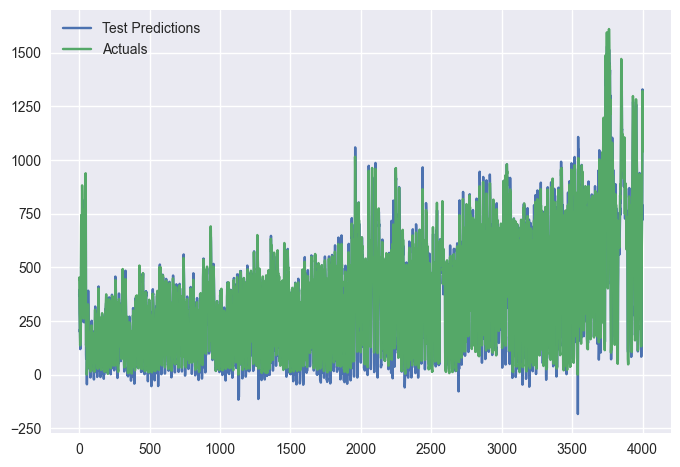

In [21]:
model = load_model('1H_Forecast/1H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(1,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D003_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D003_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 2 hours forecast

In [22]:
%%time

Trainer(2,6,12,50)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                17920     
                                                                 
 dense_16 (Dense)            (None, 8)                 520       
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 10:41:56.114251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:41:56.230777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/376 [..............................] - ETA: 11s - loss: 0.6398 - mae: 0.6393 - mse: 0.6398 - mape: 121.0682 

2023-02-10 10:41:56.433903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.4961 - mae: 0.5457 - mse: 0.4961 - mape: 191.4286

2023-02-10 10:42:02.440397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:42:02.488846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.49167, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 12s 29ms/step - loss: 0.4961 - mae: 0.5457 - mse: 0.4961 - mape: 191.4286 - val_loss: 0.4917 - val_mae: 0.5381 - val_mse: 0.4917 - val_mape: 165.6113
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.3436 - mae: 0.4231 - mse: 0.3436 - mape: 198.4438
Epoch 2: val_loss improved from 0.49167 to 0.40435, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.3436 - mae: 0.4231 - mse: 0.3436 - mape: 198.4438 - val_loss: 0.4044 - val_mae: 0.4749 - val_mse: 0.4044 - val_mape: 160.3921
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.2887 - mae: 0.3780 - mse: 0.2887 - mape: 187.4226
Epoch 3: val_loss improved from 0.40435 to 0.34192, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.2887 - mae: 0.3780 - mse: 0.2887 - mape: 187.4226 - val_loss: 0.3419 - val_mae: 0.4299 - val_mse: 0.3419 - val_mape: 150.0692
Epoch 4/50
374/376 [============================>.] - ETA: 0s - loss: 0.2500 - mae: 0.3480 - mse: 0.2500 - mape: 188.7675
Epoch 4: val_loss improved from 0.34192 to 0.30190, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.2500 - mae: 0.3482 - mse: 0.2500 - mape: 188.4479 - val_loss: 0.3019 - val_mae: 0.3997 - val_mse: 0.3019 - val_mape: 153.9359
Epoch 5/50
374/376 [============================>.] - ETA: 0s - loss: 0.2269 - mae: 0.3298 - mse: 0.2269 - mape: 185.1493
Epoch 5: val_loss improved from 0.30190 to 0.28041, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.2268 - mae: 0.3298 - mse: 0.2268 - mape: 184.8965 - val_loss: 0.2804 - val_mae: 0.3809 - val_mse: 0.2804 - val_mape: 153.5123
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.2133 - mae: 0.3185 - mse: 0.2133 - mape: 186.7449
Epoch 6: val_loss improved from 0.28041 to 0.26720, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.2133 - mae: 0.3185 - mse: 0.2133 - mape: 186.7449 - val_loss: 0.2672 - val_mae: 0.3689 - val_mse: 0.2672 - val_mape: 153.3526
Epoch 7/50
373/376 [============================>.] - ETA: 0s - loss: 0.2038 - mae: 0.3098 - mse: 0.2038 - mape: 181.2865
Epoch 7: val_loss improved from 0.26720 to 0.25672, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 9s 25ms/step - loss: 0.2034 - mae: 0.3096 - mse: 0.2034 - mape: 180.6152 - val_loss: 0.2567 - val_mae: 0.3616 - val_mse: 0.2567 - val_mape: 156.8155
Epoch 8/50
375/376 [============================>.] - ETA: 0s - loss: 0.1966 - mae: 0.3027 - mse: 0.1966 - mape: 175.1488
Epoch 8: val_loss did not improve from 0.25672
376/376 [==============================] - 6s 15ms/step - loss: 0.1968 - mae: 0.3029 - mse: 0.1968 - mape: 175.0435 - val_loss: 0.2570 - val_mae: 0.3599 - val_mse: 0.2570 - val_mape: 156.5605
Epoch 9/50
374/376 [============================>.] - ETA: 0s - loss: 0.1908 - mae: 0.2971 - mse: 0.1908 - mape: 186.9314
Epoch 9: val_loss improved from 0.25672 to 0.25129, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.1906 - mae: 0.2969 - mse: 0.1906 - mape: 186.4587 - val_loss: 0.2513 - val_mae: 0.3544 - val_mse: 0.2513 - val_mape: 153.3179
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.1854 - mae: 0.2915 - mse: 0.1854 - mape: 183.3891
Epoch 10: val_loss improved from 0.25129 to 0.24905, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.1854 - mae: 0.2915 - mse: 0.1854 - mape: 183.3891 - val_loss: 0.2490 - val_mae: 0.3527 - val_mse: 0.2490 - val_mape: 159.6150
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.1807 - mae: 0.2873 - mse: 0.1807 - mape: 188.5653
Epoch 11: val_loss improved from 0.24905 to 0.24567, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 9s 25ms/step - loss: 0.1807 - mae: 0.2873 - mse: 0.1807 - mape: 188.5653 - val_loss: 0.2457 - val_mae: 0.3453 - val_mse: 0.2457 - val_mape: 153.4056
Epoch 12/50
373/376 [============================>.] - ETA: 0s - loss: 0.1765 - mae: 0.2831 - mse: 0.1765 - mape: 198.8691
Epoch 12: val_loss improved from 0.24567 to 0.24224, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.1765 - mae: 0.2830 - mse: 0.1765 - mape: 197.9725 - val_loss: 0.2422 - val_mae: 0.3465 - val_mse: 0.2422 - val_mape: 154.3332
Epoch 13/50
374/376 [============================>.] - ETA: 0s - loss: 0.1726 - mae: 0.2783 - mse: 0.1726 - mape: 198.0419
Epoch 13: val_loss improved from 0.24224 to 0.23737, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1725 - mae: 0.2782 - mse: 0.1725 - mape: 197.7531 - val_loss: 0.2374 - val_mae: 0.3387 - val_mse: 0.2374 - val_mape: 151.3248
Epoch 14/50
375/376 [============================>.] - ETA: 0s - loss: 0.1691 - mae: 0.2749 - mse: 0.1691 - mape: 196.3537
Epoch 14: val_loss improved from 0.23737 to 0.22621, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1690 - mae: 0.2748 - mse: 0.1690 - mape: 196.2245 - val_loss: 0.2262 - val_mae: 0.3348 - val_mse: 0.2262 - val_mape: 154.9309
Epoch 15/50
374/376 [============================>.] - ETA: 0s - loss: 0.1659 - mae: 0.2712 - mse: 0.1659 - mape: 207.1792
Epoch 15: val_loss improved from 0.22621 to 0.22193, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1657 - mae: 0.2710 - mse: 0.1657 - mape: 206.6597 - val_loss: 0.2219 - val_mae: 0.3307 - val_mse: 0.2219 - val_mape: 153.2188
Epoch 16/50
375/376 [============================>.] - ETA: 0s - loss: 0.1628 - mae: 0.2679 - mse: 0.1628 - mape: 217.4335
Epoch 16: val_loss did not improve from 0.22193
376/376 [==============================] - 6s 17ms/step - loss: 0.1628 - mae: 0.2680 - mse: 0.1628 - mape: 217.3583 - val_loss: 0.2234 - val_mae: 0.3300 - val_mse: 0.2234 - val_mape: 151.4084
Epoch 17/50
376/376 [==============================] - ETA: 0s - loss: 0.1607 - mae: 0.2655 - mse: 0.1607 - mape: 222.2648
Epoch 17: val_loss improved from 0.22193 to 0.21716, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.1607 - mae: 0.2655 - mse: 0.1607 - mape: 222.2648 - val_loss: 0.2172 - val_mae: 0.3248 - val_mse: 0.2172 - val_mape: 152.7450
Epoch 18/50
375/376 [============================>.] - ETA: 0s - loss: 0.1583 - mae: 0.2632 - mse: 0.1583 - mape: 218.2703
Epoch 18: val_loss improved from 0.21716 to 0.21369, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1584 - mae: 0.2633 - mse: 0.1584 - mape: 218.2012 - val_loss: 0.2137 - val_mae: 0.3237 - val_mse: 0.2137 - val_mape: 151.7619
Epoch 19/50
375/376 [============================>.] - ETA: 0s - loss: 0.1566 - mae: 0.2625 - mse: 0.1566 - mape: 222.7987
Epoch 19: val_loss did not improve from 0.21369
376/376 [==============================] - 6s 17ms/step - loss: 0.1565 - mae: 0.2624 - mse: 0.1565 - mape: 222.6679 - val_loss: 0.2198 - val_mae: 0.3226 - val_mse: 0.2198 - val_mape: 147.3694
Epoch 20/50
374/376 [============================>.] - ETA: 0s - loss: 0.1554 - mae: 0.2609 - mse: 0.1554 - mape: 232.8085
Epoch 20: val_loss did not improve from 0.21369
376/376 [==============================] - 6s 17ms/step - loss: 0.1551 - mae: 0.2608 - mse: 0.1551 - mape: 232.2048 - val_loss: 0.2150 - val_mae: 0.3207 - val_mse: 0.2150 - val_mape: 149.5558
Epoch 21/50
373/376 [============================>.] - ETA: 0s - loss: 0.1545 - m

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.1529 - mae: 0.2596 - mse: 0.1529 - mape: 233.8622 - val_loss: 0.2090 - val_mae: 0.3202 - val_mse: 0.2090 - val_mape: 149.0941
Epoch 23/50
374/376 [============================>.] - ETA: 0s - loss: 0.1519 - mae: 0.2589 - mse: 0.1519 - mape: 234.5626
Epoch 23: val_loss did not improve from 0.20904
376/376 [==============================] - 6s 17ms/step - loss: 0.1517 - mae: 0.2588 - mse: 0.1517 - mape: 234.0813 - val_loss: 0.2110 - val_mae: 0.3191 - val_mse: 0.2110 - val_mape: 148.5238
Epoch 24/50
376/376 [==============================] - ETA: 0s - loss: 0.1512 - mae: 0.2584 - mse: 0.1512 - mape: 241.5521
Epoch 24: val_loss did not improve from 0.20904
376/376 [==============================] - 6s 17ms/step - loss: 0.1512 - mae: 0.2584 - mse: 0.1512 - mape: 241.5521 - val_loss: 0.2142 - val_mae: 0.3196 - val_mse: 0.2142 - val_mape: 144.2401
Epoch 25/50
375/376 [============================>.] - ETA: 0s - loss: 0.1507 - m

374/376 [============================>.] - ETA: 0s - loss: 0.1408 - mae: 0.2512 - mse: 0.1408 - mape: 244.3280
Epoch 45: val_loss did not improve from 0.20904
376/376 [==============================] - 6s 16ms/step - loss: 0.1407 - mae: 0.2511 - mse: 0.1407 - mape: 243.6732 - val_loss: 0.2285 - val_mae: 0.3321 - val_mse: 0.2285 - val_mape: 147.6238
Epoch 46/50
376/376 [==============================] - ETA: 0s - loss: 0.1405 - mae: 0.2506 - mse: 0.1405 - mape: 239.1925
Epoch 46: val_loss did not improve from 0.20904
376/376 [==============================] - 7s 18ms/step - loss: 0.1405 - mae: 0.2506 - mse: 0.1405 - mape: 239.1925 - val_loss: 0.2175 - val_mae: 0.3274 - val_mse: 0.2175 - val_mape: 145.7496
Epoch 47/50
374/376 [============================>.] - ETA: 0s - loss: 0.1401 - mae: 0.2500 - mse: 0.1401 - mape: 250.8817
Epoch 47: val_loss did not improve from 0.20904
376/376 [==============================] - 6s 16ms/step - loss: 0.1401 - mae: 0.2499 - mse: 0.1401 - mape: 250.2308

2023-02-10 10:48:19.633213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:48:19.806601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/376 [..............................] - ETA: 8:35 - loss: 0.8126 - mae: 0.7627 - mse: 0.8126 - mape: 317.5406

2023-02-10 10:48:20.064684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6698 - mae: 0.6397 - mse: 0.6698 - mape: 181.7705

2023-02-10 10:48:26.078092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:48:26.133197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.63980, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 13s 31ms/step - loss: 0.6698 - mae: 0.6397 - mse: 0.6698 - mape: 181.7705 - val_loss: 0.6398 - val_mae: 0.5978 - val_mse: 0.6398 - val_mape: 187.2091
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.3922 - mae: 0.4566 - mse: 0.3922 - mape: 234.7708
Epoch 2: val_loss improved from 0.63980 to 0.46015, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3922 - mae: 0.4566 - mse: 0.3922 - mape: 234.7708 - val_loss: 0.4602 - val_mae: 0.4987 - val_mse: 0.4602 - val_mape: 173.0682
Epoch 3/50
375/376 [============================>.] - ETA: 0s - loss: 0.3122 - mae: 0.3974 - mse: 0.3122 - mape: 206.8871
Epoch 3: val_loss improved from 0.46015 to 0.36844, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3120 - mae: 0.3973 - mse: 0.3120 - mape: 206.7716 - val_loss: 0.3684 - val_mae: 0.4421 - val_mse: 0.3684 - val_mape: 159.3068
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.2585 - mae: 0.3558 - mse: 0.2585 - mape: 201.5671
Epoch 4: val_loss improved from 0.36844 to 0.31836, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.2585 - mae: 0.3558 - mse: 0.2585 - mape: 201.5671 - val_loss: 0.3184 - val_mae: 0.4080 - val_mse: 0.3184 - val_mape: 153.2152
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.2307 - mae: 0.3332 - mse: 0.2307 - mape: 199.0975
Epoch 5: val_loss improved from 0.31836 to 0.29838, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2307 - mae: 0.3332 - mse: 0.2307 - mape: 199.0975 - val_loss: 0.2984 - val_mae: 0.3909 - val_mse: 0.2984 - val_mape: 152.9252
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.2158 - mae: 0.3198 - mse: 0.2158 - mape: 193.4416
Epoch 6: val_loss improved from 0.29838 to 0.29103, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2158 - mae: 0.3198 - mse: 0.2158 - mape: 193.4416 - val_loss: 0.2910 - val_mae: 0.3846 - val_mse: 0.2910 - val_mape: 156.1103
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.2058 - mae: 0.3108 - mse: 0.2058 - mape: 184.4042
Epoch 7: val_loss improved from 0.29103 to 0.27943, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2058 - mae: 0.3108 - mse: 0.2058 - mape: 184.4042 - val_loss: 0.2794 - val_mae: 0.3769 - val_mse: 0.2794 - val_mape: 153.8951
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.1977 - mae: 0.3032 - mse: 0.1977 - mape: 179.7159
Epoch 8: val_loss improved from 0.27943 to 0.27120, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.1977 - mae: 0.3032 - mse: 0.1977 - mape: 179.7159 - val_loss: 0.2712 - val_mae: 0.3708 - val_mse: 0.2712 - val_mape: 153.8158
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.1907 - mae: 0.2959 - mse: 0.1907 - mape: 183.4492
Epoch 9: val_loss improved from 0.27120 to 0.26155, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.1907 - mae: 0.2959 - mse: 0.1907 - mape: 183.4492 - val_loss: 0.2615 - val_mae: 0.3619 - val_mse: 0.2615 - val_mape: 153.7257
Epoch 10/50
375/376 [============================>.] - ETA: 0s - loss: 0.1844 - mae: 0.2899 - mse: 0.1844 - mape: 181.0110
Epoch 10: val_loss improved from 0.26155 to 0.25198, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.1845 - mae: 0.2900 - mse: 0.1845 - mape: 180.9579 - val_loss: 0.2520 - val_mae: 0.3567 - val_mse: 0.2520 - val_mape: 155.8294
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.1785 - mae: 0.2839 - mse: 0.1785 - mape: 188.7488
Epoch 11: val_loss improved from 0.25198 to 0.24930, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.1785 - mae: 0.2839 - mse: 0.1785 - mape: 188.7488 - val_loss: 0.2493 - val_mae: 0.3519 - val_mse: 0.2493 - val_mape: 151.6225
Epoch 12/50
375/376 [============================>.] - ETA: 0s - loss: 0.1737 - mae: 0.2791 - mse: 0.1737 - mape: 184.2420
Epoch 12: val_loss improved from 0.24930 to 0.24657, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.1738 - mae: 0.2792 - mse: 0.1738 - mape: 184.1831 - val_loss: 0.2466 - val_mae: 0.3457 - val_mse: 0.2466 - val_mape: 149.9634
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.1701 - mae: 0.2754 - mse: 0.1701 - mape: 193.0528
Epoch 13: val_loss improved from 0.24657 to 0.23297, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.1701 - mae: 0.2754 - mse: 0.1701 - mape: 193.0528 - val_loss: 0.2330 - val_mae: 0.3421 - val_mse: 0.2330 - val_mape: 153.6761
Epoch 14/50
373/376 [============================>.] - ETA: 0s - loss: 0.1656 - mae: 0.2717 - mse: 0.1656 - mape: 187.7610
Epoch 14: val_loss improved from 0.23297 to 0.22686, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.1661 - mae: 0.2721 - mse: 0.1661 - mape: 187.0872 - val_loss: 0.2269 - val_mae: 0.3373 - val_mse: 0.2269 - val_mape: 153.9196
Epoch 15/50
376/376 [==============================] - ETA: 0s - loss: 0.1632 - mae: 0.2688 - mse: 0.1632 - mape: 195.1128
Epoch 15: val_loss improved from 0.22686 to 0.22300, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.1632 - mae: 0.2688 - mse: 0.1632 - mape: 195.1128 - val_loss: 0.2230 - val_mae: 0.3350 - val_mse: 0.2230 - val_mape: 153.8703
Epoch 16/50
373/376 [============================>.] - ETA: 0s - loss: 0.1602 - mae: 0.2665 - mse: 0.1602 - mape: 188.3657
Epoch 16: val_loss improved from 0.22300 to 0.22042, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.1606 - mae: 0.2667 - mse: 0.1606 - mape: 190.6941 - val_loss: 0.2204 - val_mae: 0.3303 - val_mse: 0.2204 - val_mape: 150.0678
Epoch 17/50
376/376 [==============================] - ETA: 0s - loss: 0.1584 - mae: 0.2650 - mse: 0.1584 - mape: 195.4987
Epoch 17: val_loss did not improve from 0.22042
376/376 [==============================] - 6s 17ms/step - loss: 0.1584 - mae: 0.2650 - mse: 0.1584 - mape: 195.4987 - val_loss: 0.2224 - val_mae: 0.3288 - val_mse: 0.2224 - val_mape: 148.8896
Epoch 18/50
374/376 [============================>.] - ETA: 0s - loss: 0.1563 - mae: 0.2629 - mse: 0.1563 - mape: 196.1454
Epoch 18: val_loss improved from 0.22042 to 0.21579, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.1567 - mae: 0.2632 - mse: 0.1567 - mape: 195.6999 - val_loss: 0.2158 - val_mae: 0.3260 - val_mse: 0.2158 - val_mape: 151.1002
Epoch 19/50
373/376 [============================>.] - ETA: 0s - loss: 0.1554 - mae: 0.2620 - mse: 0.1554 - mape: 202.4753
Epoch 19: val_loss did not improve from 0.21579
376/376 [==============================] - 6s 17ms/step - loss: 0.1552 - mae: 0.2620 - mse: 0.1552 - mape: 201.6256 - val_loss: 0.2188 - val_mae: 0.3242 - val_mse: 0.2188 - val_mape: 148.0683
Epoch 20/50
376/376 [==============================] - ETA: 0s - loss: 0.1539 - mae: 0.2613 - mse: 0.1539 - mape: 204.4469
Epoch 20: val_loss improved from 0.21579 to 0.21506, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1539 - mae: 0.2613 - mse: 0.1539 - mape: 204.4469 - val_loss: 0.2151 - val_mae: 0.3249 - val_mse: 0.2151 - val_mape: 150.4659
Epoch 21/50
376/376 [==============================] - ETA: 0s - loss: 0.1526 - mae: 0.2603 - mse: 0.1526 - mape: 200.2044
Epoch 21: val_loss improved from 0.21506 to 0.21311, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1526 - mae: 0.2603 - mse: 0.1526 - mape: 200.2044 - val_loss: 0.2131 - val_mae: 0.3238 - val_mse: 0.2131 - val_mape: 154.2001
Epoch 22/50
375/376 [============================>.] - ETA: 0s - loss: 0.1520 - mae: 0.2602 - mse: 0.1520 - mape: 205.9515
Epoch 22: val_loss improved from 0.21311 to 0.21137, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1521 - mae: 0.2603 - mse: 0.1521 - mape: 205.8644 - val_loss: 0.2114 - val_mae: 0.3217 - val_mse: 0.2114 - val_mape: 150.4698
Epoch 23/50
374/376 [============================>.] - ETA: 0s - loss: 0.1513 - mae: 0.2592 - mse: 0.1513 - mape: 200.0431
Epoch 23: val_loss did not improve from 0.21137
376/376 [==============================] - 7s 19ms/step - loss: 0.1512 - mae: 0.2592 - mse: 0.1512 - mape: 199.5101 - val_loss: 0.2130 - val_mae: 0.3230 - val_mse: 0.2130 - val_mape: 149.9097
Epoch 24/50
375/376 [============================>.] - ETA: 0s - loss: 0.1506 - mae: 0.2583 - mse: 0.1506 - mape: 208.7650
Epoch 24: val_loss did not improve from 0.21137
376/376 [==============================] - 6s 16ms/step - loss: 0.1506 - mae: 0.2583 - mse: 0.1506 - mape: 208.9744 - val_loss: 0.2159 - val_mae: 0.3221 - val_mse: 0.2159 - val_mape: 146.7570
Epoch 25/50
376/376 [==============================] - ETA: 0s - loss: 0.1498 - m

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.1432 - mae: 0.2532 - mse: 0.1432 - mape: 203.7425 - val_loss: 0.2101 - val_mae: 0.3189 - val_mse: 0.2101 - val_mape: 145.4420
Epoch 36/50
376/376 [==============================] - ETA: 0s - loss: 0.1428 - mae: 0.2532 - mse: 0.1428 - mape: 208.7650
Epoch 36: val_loss did not improve from 0.21010
376/376 [==============================] - 7s 18ms/step - loss: 0.1428 - mae: 0.2532 - mse: 0.1428 - mape: 208.7650 - val_loss: 0.2140 - val_mae: 0.3189 - val_mse: 0.2140 - val_mape: 144.9126
Epoch 37/50
376/376 [==============================] - ETA: 0s - loss: 0.1424 - mae: 0.2523 - mse: 0.1424 - mape: 208.7652
Epoch 37: val_loss did not improve from 0.21010
376/376 [==============================] - 9s 23ms/step - loss: 0.1424 - mae: 0.2523 - mse: 0.1424 - mape: 208.7652 - val_loss: 0.2154 - val_mae: 0.3198 - val_mse: 0.2154 - val_mape: 143.6826
Epoch 38/50
376/376 [==============================] - ETA: 0s - loss: 0.1419 - m

2023-02-10 10:55:21.934945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:55:22.072159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/376 [..............................] - ETA: 8:41 - loss: 0.7332 - mae: 0.6893 - mse: 0.7332 - mape: 132.8522

2023-02-10 10:55:22.310788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6293 - mae: 0.6252 - mse: 0.6293 - mape: 218.3398

2023-02-10 10:55:29.818753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:55:29.906887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.56123, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 15s 36ms/step - loss: 0.6293 - mae: 0.6252 - mse: 0.6293 - mape: 218.3398 - val_loss: 0.5612 - val_mae: 0.5711 - val_mse: 0.5612 - val_mape: 213.7624
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.4022 - mae: 0.4642 - mse: 0.4022 - mape: 234.0086
Epoch 2: val_loss improved from 0.56123 to 0.43608, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.4022 - mae: 0.4642 - mse: 0.4022 - mape: 234.0086 - val_loss: 0.4361 - val_mae: 0.4952 - val_mse: 0.4361 - val_mape: 190.2910
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.3119 - mae: 0.3983 - mse: 0.3119 - mape: 200.7265
Epoch 3: val_loss improved from 0.43608 to 0.34455, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.3119 - mae: 0.3983 - mse: 0.3119 - mape: 200.7265 - val_loss: 0.3445 - val_mae: 0.4282 - val_mse: 0.3445 - val_mape: 157.8060
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.2500 - mae: 0.3499 - mse: 0.2500 - mape: 174.3524
Epoch 4: val_loss improved from 0.34455 to 0.29285, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.2500 - mae: 0.3499 - mse: 0.2500 - mape: 174.3524 - val_loss: 0.2929 - val_mae: 0.3882 - val_mse: 0.2929 - val_mape: 146.7033
Epoch 5/50
375/376 [============================>.] - ETA: 0s - loss: 0.2245 - mae: 0.3300 - mse: 0.2245 - mape: 169.6339
Epoch 5: val_loss improved from 0.29285 to 0.28020, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.2245 - mae: 0.3300 - mse: 0.2245 - mape: 169.5300 - val_loss: 0.2802 - val_mae: 0.3764 - val_mse: 0.2802 - val_mape: 145.1305
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.2096 - mae: 0.3169 - mse: 0.2096 - mape: 172.0224
Epoch 6: val_loss improved from 0.28020 to 0.26982, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.2096 - mae: 0.3169 - mse: 0.2096 - mape: 172.0224 - val_loss: 0.2698 - val_mae: 0.3671 - val_mse: 0.2698 - val_mape: 143.8712
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.1984 - mae: 0.3060 - mse: 0.1984 - mape: 171.8771
Epoch 7: val_loss improved from 0.26982 to 0.25837, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.1984 - mae: 0.3060 - mse: 0.1984 - mape: 171.8771 - val_loss: 0.2584 - val_mae: 0.3598 - val_mse: 0.2584 - val_mape: 143.0852
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.1893 - mae: 0.2972 - mse: 0.1893 - mape: 172.5481
Epoch 8: val_loss improved from 0.25837 to 0.25636, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1893 - mae: 0.2972 - mse: 0.1893 - mape: 172.5481 - val_loss: 0.2564 - val_mae: 0.3542 - val_mse: 0.2564 - val_mape: 138.5594
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.1820 - mae: 0.2908 - mse: 0.1820 - mape: 176.4424
Epoch 9: val_loss improved from 0.25636 to 0.23819, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 14s 38ms/step - loss: 0.1820 - mae: 0.2908 - mse: 0.1820 - mape: 176.4424 - val_loss: 0.2382 - val_mae: 0.3425 - val_mse: 0.2382 - val_mape: 142.8075
Epoch 10/50
373/376 [============================>.] - ETA: 0s - loss: 0.1760 - mae: 0.2835 - mse: 0.1760 - mape: 183.9515
Epoch 10: val_loss improved from 0.23819 to 0.23170, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1757 - mae: 0.2834 - mse: 0.1757 - mape: 183.8259 - val_loss: 0.2317 - val_mae: 0.3382 - val_mse: 0.2317 - val_mape: 140.7539
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.1707 - mae: 0.2782 - mse: 0.1707 - mape: 180.5537
Epoch 11: val_loss improved from 0.23170 to 0.22466, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1707 - mae: 0.2782 - mse: 0.1707 - mape: 180.5537 - val_loss: 0.2247 - val_mae: 0.3369 - val_mse: 0.2247 - val_mape: 142.2957
Epoch 12/50
374/376 [============================>.] - ETA: 0s - loss: 0.1669 - mae: 0.2747 - mse: 0.1669 - mape: 186.4351
Epoch 12: val_loss improved from 0.22466 to 0.22402, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1668 - mae: 0.2745 - mse: 0.1668 - mape: 186.0193 - val_loss: 0.2240 - val_mae: 0.3289 - val_mse: 0.2240 - val_mape: 138.8941
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.1637 - mae: 0.2711 - mse: 0.1637 - mape: 187.4108
Epoch 13: val_loss improved from 0.22402 to 0.22136, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1637 - mae: 0.2711 - mse: 0.1637 - mape: 187.4108 - val_loss: 0.2214 - val_mae: 0.3300 - val_mse: 0.2214 - val_mape: 142.0275
Epoch 14/50
375/376 [============================>.] - ETA: 0s - loss: 0.1612 - mae: 0.2688 - mse: 0.1612 - mape: 196.6616
Epoch 14: val_loss improved from 0.22136 to 0.21906, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1611 - mae: 0.2687 - mse: 0.1611 - mape: 196.5397 - val_loss: 0.2191 - val_mae: 0.3269 - val_mse: 0.2191 - val_mape: 140.8304
Epoch 15/50
374/376 [============================>.] - ETA: 0s - loss: 0.1590 - mae: 0.2671 - mse: 0.1590 - mape: 191.5149
Epoch 15: val_loss improved from 0.21906 to 0.21446, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.1588 - mae: 0.2670 - mse: 0.1588 - mape: 191.8099 - val_loss: 0.2145 - val_mae: 0.3229 - val_mse: 0.2145 - val_mape: 143.1893
Epoch 16/50
374/376 [============================>.] - ETA: 0s - loss: 0.1570 - mae: 0.2649 - mse: 0.1570 - mape: 201.7468
Epoch 16: val_loss did not improve from 0.21446
376/376 [==============================] - 7s 18ms/step - loss: 0.1568 - mae: 0.2649 - mse: 0.1568 - mape: 201.2517 - val_loss: 0.2148 - val_mae: 0.3254 - val_mse: 0.2148 - val_mape: 143.0003
Epoch 17/50
375/376 [============================>.] - ETA: 0s - loss: 0.1552 - mae: 0.2640 - mse: 0.1552 - mape: 202.2498
Epoch 17: val_loss did not improve from 0.21446
376/376 [==============================] - 6s 17ms/step - loss: 0.1552 - mae: 0.2640 - mse: 0.1552 - mape: 202.1282 - val_loss: 0.2152 - val_mae: 0.3229 - val_mse: 0.2152 - val_mape: 144.2812
Epoch 18/50
376/376 [==============================] - ETA: 0s - loss: 0.1535 - m

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1535 - mae: 0.2619 - mse: 0.1535 - mape: 201.1609 - val_loss: 0.2136 - val_mae: 0.3265 - val_mse: 0.2136 - val_mape: 147.8684
Epoch 19/50
376/376 [==============================] - ETA: 0s - loss: 0.1526 - mae: 0.2613 - mse: 0.1526 - mape: 198.5655
Epoch 19: val_loss did not improve from 0.21357
376/376 [==============================] - 7s 18ms/step - loss: 0.1526 - mae: 0.2613 - mse: 0.1526 - mape: 198.5655 - val_loss: 0.2136 - val_mae: 0.3212 - val_mse: 0.2136 - val_mape: 141.7230
Epoch 20/50
376/376 [==============================] - ETA: 0s - loss: 0.1514 - mae: 0.2606 - mse: 0.1514 - mape: 202.9999
Epoch 20: val_loss did not improve from 0.21357
376/376 [==============================] - 7s 18ms/step - loss: 0.1514 - mae: 0.2606 - mse: 0.1514 - mape: 202.9999 - val_loss: 0.2136 - val_mae: 0.3213 - val_mse: 0.2136 - val_mape: 143.1745
Epoch 21/50
375/376 [============================>.] - ETA: 0s - loss: 0.1503 - m

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1492 - mae: 0.2587 - mse: 0.1492 - mape: 208.2047 - val_loss: 0.2123 - val_mae: 0.3224 - val_mse: 0.2123 - val_mape: 144.6106
Epoch 23/50
375/376 [============================>.] - ETA: 0s - loss: 0.1489 - mae: 0.2585 - mse: 0.1489 - mape: 213.1075
Epoch 23: val_loss did not improve from 0.21232
376/376 [==============================] - 7s 18ms/step - loss: 0.1489 - mae: 0.2585 - mse: 0.1489 - mape: 212.9777 - val_loss: 0.2145 - val_mae: 0.3220 - val_mse: 0.2145 - val_mape: 142.9935
Epoch 24/50
376/376 [==============================] - ETA: 0s - loss: 0.1474 - mae: 0.2565 - mse: 0.1474 - mape: 202.5641
Epoch 24: val_loss did not improve from 0.21232
376/376 [==============================] - 7s 18ms/step - loss: 0.1474 - mae: 0.2565 - mse: 0.1474 - mape: 202.5641 - val_loss: 0.2140 - val_mae: 0.3216 - val_mse: 0.2140 - val_mape: 143.8377
Epoch 25/50
376/376 [==============================] - ETA: 0s - loss: 0.1467 - m

374/376 [============================>.] - ETA: 0s - loss: 0.1331 - mae: 0.2450 - mse: 0.1331 - mape: 217.3413
Epoch 45: val_loss did not improve from 0.21232
376/376 [==============================] - 7s 19ms/step - loss: 0.1332 - mae: 0.2450 - mse: 0.1332 - mape: 216.7996 - val_loss: 0.2268 - val_mae: 0.3263 - val_mse: 0.2268 - val_mape: 130.8864
Epoch 46/50
374/376 [============================>.] - ETA: 0s - loss: 0.1332 - mae: 0.2451 - mse: 0.1332 - mape: 214.2593
Epoch 46: val_loss did not improve from 0.21232
376/376 [==============================] - 7s 18ms/step - loss: 0.1331 - mae: 0.2450 - mse: 0.1331 - mape: 213.6340 - val_loss: 0.2262 - val_mae: 0.3274 - val_mse: 0.2262 - val_mape: 128.7736
Epoch 47/50
375/376 [============================>.] - ETA: 0s - loss: 0.1324 - mae: 0.2442 - mse: 0.1324 - mape: 216.3003
Epoch 47: val_loss did not improve from 0.21232
376/376 [==============================] - 7s 19ms/step - loss: 0.1323 - mae: 0.2441 - mse: 0.1323 - mape: 216.1723

2023-02-10 11:02:28.741360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:02:28.929547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:02:29.179617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.5892 - mae: 0.5989 - mse: 0.5892 - mape: 206.9785

2023-02-10 11:02:36.599831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:02:36.662698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.52424, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 15s 35ms/step - loss: 0.5892 - mae: 0.5989 - mse: 0.5892 - mape: 206.9785 - val_loss: 0.5242 - val_mae: 0.5566 - val_mse: 0.5242 - val_mape: 176.4856
Epoch 2/50
374/376 [============================>.] - ETA: 0s - loss: 0.3562 - mae: 0.4375 - mse: 0.3562 - mape: 207.2011
Epoch 2: val_loss improved from 0.52424 to 0.40269, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.3558 - mae: 0.4373 - mse: 0.3558 - mape: 206.9920 - val_loss: 0.4027 - val_mae: 0.4747 - val_mse: 0.4027 - val_mape: 162.8990
Epoch 3/50
374/376 [============================>.] - ETA: 0s - loss: 0.2769 - mae: 0.3769 - mse: 0.2769 - mape: 195.9556
Epoch 3: val_loss improved from 0.40269 to 0.34268, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2768 - mae: 0.3770 - mse: 0.2768 - mape: 195.6925 - val_loss: 0.3427 - val_mae: 0.4289 - val_mse: 0.3427 - val_mape: 152.9357
Epoch 4/50
374/376 [============================>.] - ETA: 0s - loss: 0.2403 - mae: 0.3476 - mse: 0.2403 - mape: 173.3794
Epoch 4: val_loss improved from 0.34268 to 0.31915, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.2401 - mae: 0.3473 - mse: 0.2401 - mape: 173.0156 - val_loss: 0.3192 - val_mae: 0.4108 - val_mse: 0.3192 - val_mape: 156.1915
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.2219 - mae: 0.3309 - mse: 0.2219 - mape: 171.8351
Epoch 5: val_loss improved from 0.31915 to 0.30461, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2219 - mae: 0.3309 - mse: 0.2219 - mape: 171.8351 - val_loss: 0.3046 - val_mae: 0.3976 - val_mse: 0.3046 - val_mape: 154.9532
Epoch 6/50
375/376 [============================>.] - ETA: 0s - loss: 0.2087 - mae: 0.3184 - mse: 0.2087 - mape: 167.1580
Epoch 6: val_loss improved from 0.30461 to 0.28826, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2087 - mae: 0.3184 - mse: 0.2087 - mape: 167.0813 - val_loss: 0.2883 - val_mae: 0.3865 - val_mse: 0.2883 - val_mape: 151.2832
Epoch 7/50
375/376 [============================>.] - ETA: 0s - loss: 0.1992 - mae: 0.3078 - mse: 0.1992 - mape: 169.5770
Epoch 7: val_loss improved from 0.28826 to 0.27841, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1992 - mae: 0.3077 - mse: 0.1992 - mape: 169.5030 - val_loss: 0.2784 - val_mae: 0.3777 - val_mse: 0.2784 - val_mape: 149.7817
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.1904 - mae: 0.2990 - mse: 0.1904 - mape: 159.9420
Epoch 8: val_loss improved from 0.27841 to 0.26975, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1904 - mae: 0.2990 - mse: 0.1904 - mape: 159.9420 - val_loss: 0.2697 - val_mae: 0.3722 - val_mse: 0.2697 - val_mape: 145.5652
Epoch 9/50
374/376 [============================>.] - ETA: 0s - loss: 0.1838 - mae: 0.2929 - mse: 0.1838 - mape: 163.2031
Epoch 9: val_loss improved from 0.26975 to 0.26590, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1836 - mae: 0.2927 - mse: 0.1836 - mape: 163.0701 - val_loss: 0.2659 - val_mae: 0.3666 - val_mse: 0.2659 - val_mape: 141.3002
Epoch 10/50
374/376 [============================>.] - ETA: 0s - loss: 0.1775 - mae: 0.2863 - mse: 0.1775 - mape: 164.8817
Epoch 10: val_loss improved from 0.26590 to 0.25329, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1778 - mae: 0.2864 - mse: 0.1778 - mape: 164.6436 - val_loss: 0.2533 - val_mae: 0.3579 - val_mse: 0.2533 - val_mape: 145.5985
Epoch 11/50
375/376 [============================>.] - ETA: 0s - loss: 0.1737 - mae: 0.2822 - mse: 0.1737 - mape: 172.2810
Epoch 11: val_loss improved from 0.25329 to 0.25155, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1736 - mae: 0.2821 - mse: 0.1736 - mape: 172.1835 - val_loss: 0.2516 - val_mae: 0.3539 - val_mse: 0.2516 - val_mape: 139.7329
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.1697 - mae: 0.2786 - mse: 0.1697 - mape: 175.5501
Epoch 12: val_loss improved from 0.25155 to 0.24600, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1697 - mae: 0.2786 - mse: 0.1697 - mape: 175.5501 - val_loss: 0.2460 - val_mae: 0.3502 - val_mse: 0.2460 - val_mape: 140.3258
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.1663 - mae: 0.2750 - mse: 0.1663 - mape: 174.7450
Epoch 13: val_loss improved from 0.24600 to 0.24156, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1663 - mae: 0.2750 - mse: 0.1663 - mape: 174.7450 - val_loss: 0.2416 - val_mae: 0.3460 - val_mse: 0.2416 - val_mape: 138.1432
Epoch 14/50
376/376 [==============================] - ETA: 0s - loss: 0.1634 - mae: 0.2719 - mse: 0.1634 - mape: 178.5195
Epoch 14: val_loss improved from 0.24156 to 0.23150, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1634 - mae: 0.2719 - mse: 0.1634 - mape: 178.5195 - val_loss: 0.2315 - val_mae: 0.3391 - val_mse: 0.2315 - val_mape: 138.3356
Epoch 15/50
375/376 [============================>.] - ETA: 0s - loss: 0.1610 - mae: 0.2694 - mse: 0.1610 - mape: 183.1253
Epoch 15: val_loss did not improve from 0.23150
376/376 [==============================] - 7s 18ms/step - loss: 0.1609 - mae: 0.2693 - mse: 0.1609 - mape: 183.0155 - val_loss: 0.2323 - val_mae: 0.3374 - val_mse: 0.2323 - val_mape: 135.0839
Epoch 16/50
374/376 [============================>.] - ETA: 0s - loss: 0.1582 - mae: 0.2667 - mse: 0.1582 - mape: 182.2341
Epoch 16: val_loss did not improve from 0.23150
376/376 [==============================] - 7s 18ms/step - loss: 0.1582 - mae: 0.2667 - mse: 0.1582 - mape: 181.7932 - val_loss: 0.2328 - val_mae: 0.3372 - val_mse: 0.2328 - val_mape: 133.7069
Epoch 17/50
375/376 [============================>.] - ETA: 0s - loss: 0.1562 - m

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1562 - mae: 0.2651 - mse: 0.1562 - mape: 184.6021 - val_loss: 0.2225 - val_mae: 0.3301 - val_mse: 0.2225 - val_mape: 137.2329
Epoch 18/50
374/376 [============================>.] - ETA: 0s - loss: 0.1541 - mae: 0.2625 - mse: 0.1541 - mape: 185.9614
Epoch 18: val_loss improved from 0.22251 to 0.21906, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1540 - mae: 0.2624 - mse: 0.1540 - mape: 185.6189 - val_loss: 0.2191 - val_mae: 0.3283 - val_mse: 0.2191 - val_mape: 137.6428
Epoch 19/50
374/376 [============================>.] - ETA: 0s - loss: 0.1510 - mae: 0.2606 - mse: 0.1510 - mape: 190.3011
Epoch 19: val_loss did not improve from 0.21906
376/376 [==============================] - 7s 18ms/step - loss: 0.1518 - mae: 0.2608 - mse: 0.1518 - mape: 190.4431 - val_loss: 0.2192 - val_mae: 0.3270 - val_mse: 0.2192 - val_mape: 136.7877
Epoch 20/50
375/376 [============================>.] - ETA: 0s - loss: 0.1497 - mae: 0.2588 - mse: 0.1497 - mape: 188.0140
Epoch 20: val_loss did not improve from 0.21906
376/376 [==============================] - 7s 17ms/step - loss: 0.1497 - mae: 0.2588 - mse: 0.1497 - mape: 187.9129 - val_loss: 0.2201 - val_mae: 0.3282 - val_mse: 0.2201 - val_mape: 134.4084
Epoch 21/50
375/376 [============================>.] - ETA: 0s - loss: 0.1480 - m

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1480 - mae: 0.2574 - mse: 0.1480 - mape: 190.6951 - val_loss: 0.2127 - val_mae: 0.3225 - val_mse: 0.2127 - val_mape: 136.7064
Epoch 22/50
374/376 [============================>.] - ETA: 0s - loss: 0.1463 - mae: 0.2555 - mse: 0.1463 - mape: 191.1064
Epoch 22: val_loss did not improve from 0.21269
376/376 [==============================] - 7s 19ms/step - loss: 0.1463 - mae: 0.2554 - mse: 0.1463 - mape: 190.7823 - val_loss: 0.2208 - val_mae: 0.3260 - val_mse: 0.2208 - val_mape: 134.0217
Epoch 23/50
373/376 [============================>.] - ETA: 0s - loss: 0.1454 - mae: 0.2553 - mse: 0.1454 - mape: 186.5507
Epoch 23: val_loss improved from 0.21269 to 0.21131, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1455 - mae: 0.2552 - mse: 0.1455 - mape: 185.7474 - val_loss: 0.2113 - val_mae: 0.3277 - val_mse: 0.2113 - val_mape: 142.9148
Epoch 24/50
376/376 [==============================] - ETA: 0s - loss: 0.1439 - mae: 0.2541 - mse: 0.1439 - mape: 193.4382
Epoch 24: val_loss did not improve from 0.21131
376/376 [==============================] - 7s 19ms/step - loss: 0.1439 - mae: 0.2541 - mse: 0.1439 - mape: 193.4382 - val_loss: 0.2135 - val_mae: 0.3197 - val_mse: 0.2135 - val_mape: 133.8006
Epoch 25/50
374/376 [============================>.] - ETA: 0s - loss: 0.1429 - mae: 0.2526 - mse: 0.1429 - mape: 186.8947
Epoch 25: val_loss did not improve from 0.21131
376/376 [==============================] - 7s 19ms/step - loss: 0.1429 - mae: 0.2526 - mse: 0.1429 - mape: 186.4898 - val_loss: 0.2176 - val_mae: 0.3240 - val_mse: 0.2176 - val_mape: 133.8377
Epoch 26/50
373/376 [============================>.] - ETA: 0s - loss: 0.1415 - m

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1415 - mae: 0.2516 - mse: 0.1415 - mape: 183.9547 - val_loss: 0.2090 - val_mae: 0.3215 - val_mse: 0.2090 - val_mape: 138.2446
Epoch 27/50
376/376 [==============================] - ETA: 0s - loss: 0.1406 - mae: 0.2511 - mse: 0.1406 - mape: 183.8640
Epoch 27: val_loss did not improve from 0.20905
376/376 [==============================] - 7s 18ms/step - loss: 0.1406 - mae: 0.2511 - mse: 0.1406 - mape: 183.8640 - val_loss: 0.2215 - val_mae: 0.3251 - val_mse: 0.2215 - val_mape: 132.4834
Epoch 28/50
375/376 [============================>.] - ETA: 0s - loss: 0.1393 - mae: 0.2498 - mse: 0.1393 - mape: 189.0570
Epoch 28: val_loss did not improve from 0.20905
376/376 [==============================] - 7s 17ms/step - loss: 0.1394 - mae: 0.2499 - mse: 0.1394 - mape: 188.9658 - val_loss: 0.2131 - val_mae: 0.3210 - val_mse: 0.2131 - val_mape: 132.9317
Epoch 29/50
375/376 [============================>.] - ETA: 0s - loss: 0.1387 - m

375/376 [============================>.] - ETA: 0s - loss: 0.1262 - mae: 0.2398 - mse: 0.1262 - mape: 205.3129
Epoch 49: val_loss did not improve from 0.20905
376/376 [==============================] - 7s 18ms/step - loss: 0.1262 - mae: 0.2397 - mse: 0.1262 - mape: 205.1882 - val_loss: 0.2280 - val_mae: 0.3331 - val_mse: 0.2280 - val_mape: 131.8419
Epoch 50/50
374/376 [============================>.] - ETA: 0s - loss: 0.1257 - mae: 0.2391 - mse: 0.1257 - mape: 197.6030
Epoch 50: val_loss did not improve from 0.20905
376/376 [==============================] - 7s 18ms/step - loss: 0.1256 - mae: 0.2390 - mse: 0.1256 - mape: 197.0880 - val_loss: 0.2199 - val_mae: 0.3284 - val_mse: 0.2199 - val_mape: 132.6680

-----------------------------------------------------------------------------------------------------------

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)      

2023-02-10 11:09:34.409517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:09:34.584027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/376 [..............................] - ETA: 8:46 - loss: 0.7557 - mae: 0.6936 - mse: 0.7557 - mape: 113.3009

2023-02-10 11:09:34.840052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.5682 - mae: 0.5908 - mse: 0.5682 - mape: 200.4357

2023-02-10 11:09:41.324411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:09:41.387743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.56405, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 14s 33ms/step - loss: 0.5682 - mae: 0.5908 - mse: 0.5682 - mape: 200.4357 - val_loss: 0.5641 - val_mae: 0.5784 - val_mse: 0.5641 - val_mape: 177.7902
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.3679 - mae: 0.4459 - mse: 0.3679 - mape: 228.9434
Epoch 2: val_loss improved from 0.56405 to 0.44620, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.3679 - mae: 0.4459 - mse: 0.3679 - mape: 228.9434 - val_loss: 0.4462 - val_mae: 0.5018 - val_mse: 0.4462 - val_mape: 175.3620
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.2951 - mae: 0.3875 - mse: 0.2951 - mape: 211.3581
Epoch 3: val_loss improved from 0.44620 to 0.36427, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.2951 - mae: 0.3875 - mse: 0.2951 - mape: 211.3581 - val_loss: 0.3643 - val_mae: 0.4483 - val_mse: 0.3643 - val_mape: 161.0383
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.2573 - mae: 0.3584 - mse: 0.2573 - mape: 198.3759
Epoch 4: val_loss improved from 0.36427 to 0.33430, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.2573 - mae: 0.3584 - mse: 0.2573 - mape: 198.3759 - val_loss: 0.3343 - val_mae: 0.4226 - val_mse: 0.3343 - val_mape: 150.5497
Epoch 5/50
375/376 [============================>.] - ETA: 0s - loss: 0.2320 - mae: 0.3373 - mse: 0.2320 - mape: 185.2829
Epoch 5: val_loss improved from 0.33430 to 0.30504, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.2320 - mae: 0.3373 - mse: 0.2320 - mape: 185.2716 - val_loss: 0.3050 - val_mae: 0.4003 - val_mse: 0.3050 - val_mape: 143.5224
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.2123 - mae: 0.3200 - mse: 0.2123 - mape: 176.7166
Epoch 6: val_loss improved from 0.30504 to 0.29093, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.2123 - mae: 0.3200 - mse: 0.2123 - mape: 176.7166 - val_loss: 0.2909 - val_mae: 0.3868 - val_mse: 0.2909 - val_mape: 136.4377
Epoch 7/50
375/376 [============================>.] - ETA: 0s - loss: 0.1963 - mae: 0.3056 - mse: 0.1963 - mape: 165.2740
Epoch 7: val_loss improved from 0.29093 to 0.27107, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 13s 33ms/step - loss: 0.1962 - mae: 0.3056 - mse: 0.1962 - mape: 165.3161 - val_loss: 0.2711 - val_mae: 0.3684 - val_mse: 0.2711 - val_mape: 127.1098
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.1841 - mae: 0.2933 - mse: 0.1841 - mape: 161.9733
Epoch 8: val_loss improved from 0.27107 to 0.25712, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 13s 33ms/step - loss: 0.1841 - mae: 0.2933 - mse: 0.1841 - mape: 161.9733 - val_loss: 0.2571 - val_mae: 0.3555 - val_mse: 0.2571 - val_mape: 124.8343
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.1758 - mae: 0.2850 - mse: 0.1758 - mape: 157.9202
Epoch 9: val_loss improved from 0.25712 to 0.24542, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.1758 - mae: 0.2850 - mse: 0.1758 - mape: 157.9202 - val_loss: 0.2454 - val_mae: 0.3476 - val_mse: 0.2454 - val_mape: 125.2788
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.1702 - mae: 0.2789 - mse: 0.1702 - mape: 154.4945
Epoch 10: val_loss improved from 0.24542 to 0.24075, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1702 - mae: 0.2789 - mse: 0.1702 - mape: 154.4945 - val_loss: 0.2408 - val_mae: 0.3424 - val_mse: 0.2408 - val_mape: 124.8460
Epoch 11/50
375/376 [============================>.] - ETA: 0s - loss: 0.1654 - mae: 0.2741 - mse: 0.1654 - mape: 158.3670
Epoch 11: val_loss improved from 0.24075 to 0.22716, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1654 - mae: 0.2740 - mse: 0.1654 - mape: 158.3114 - val_loss: 0.2272 - val_mae: 0.3314 - val_mse: 0.2272 - val_mape: 128.2780
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.1619 - mae: 0.2699 - mse: 0.1619 - mape: 162.8084
Epoch 12: val_loss improved from 0.22716 to 0.22699, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.1619 - mae: 0.2699 - mse: 0.1619 - mape: 162.8084 - val_loss: 0.2270 - val_mae: 0.3303 - val_mse: 0.2270 - val_mape: 126.9849
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.1583 - mae: 0.2666 - mse: 0.1583 - mape: 164.6511
Epoch 13: val_loss improved from 0.22699 to 0.21830, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.1583 - mae: 0.2666 - mse: 0.1583 - mape: 164.6511 - val_loss: 0.2183 - val_mae: 0.3259 - val_mse: 0.2183 - val_mape: 127.3977
Epoch 14/50
373/376 [============================>.] - ETA: 0s - loss: 0.1555 - mae: 0.2643 - mse: 0.1555 - mape: 169.6014
Epoch 14: val_loss did not improve from 0.21830
376/376 [==============================] - 7s 19ms/step - loss: 0.1555 - mae: 0.2643 - mse: 0.1555 - mape: 169.0847 - val_loss: 0.2186 - val_mae: 0.3231 - val_mse: 0.2186 - val_mape: 128.1289
Epoch 15/50
375/376 [============================>.] - ETA: 0s - loss: 0.1531 - mae: 0.2618 - mse: 0.1531 - mape: 180.4420
Epoch 15: val_loss improved from 0.21830 to 0.21301, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1532 - mae: 0.2619 - mse: 0.1532 - mape: 180.3979 - val_loss: 0.2130 - val_mae: 0.3203 - val_mse: 0.2130 - val_mape: 128.7328
Epoch 16/50
376/376 [==============================] - ETA: 0s - loss: 0.1511 - mae: 0.2600 - mse: 0.1511 - mape: 175.2272
Epoch 16: val_loss did not improve from 0.21301
376/376 [==============================] - 7s 19ms/step - loss: 0.1511 - mae: 0.2600 - mse: 0.1511 - mape: 175.2272 - val_loss: 0.2144 - val_mae: 0.3208 - val_mse: 0.2144 - val_mape: 128.0420
Epoch 17/50
374/376 [============================>.] - ETA: 0s - loss: 0.1487 - mae: 0.2586 - mse: 0.1487 - mape: 179.9943
Epoch 17: val_loss improved from 0.21301 to 0.21078, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.1487 - mae: 0.2585 - mse: 0.1487 - mape: 179.5930 - val_loss: 0.2108 - val_mae: 0.3205 - val_mse: 0.2108 - val_mape: 128.2436
Epoch 18/50
374/376 [============================>.] - ETA: 0s - loss: 0.1472 - mae: 0.2566 - mse: 0.1472 - mape: 185.4740
Epoch 18: val_loss did not improve from 0.21078
376/376 [==============================] - 7s 19ms/step - loss: 0.1472 - mae: 0.2566 - mse: 0.1472 - mape: 185.0542 - val_loss: 0.2159 - val_mae: 0.3206 - val_mse: 0.2159 - val_mape: 127.2614
Epoch 19/50
376/376 [==============================] - ETA: 0s - loss: 0.1458 - mae: 0.2557 - mse: 0.1458 - mape: 184.7153
Epoch 19: val_loss improved from 0.21078 to 0.20968, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 13s 33ms/step - loss: 0.1458 - mae: 0.2557 - mse: 0.1458 - mape: 184.7153 - val_loss: 0.2097 - val_mae: 0.3158 - val_mse: 0.2097 - val_mape: 128.9144
Epoch 20/50
375/376 [============================>.] - ETA: 0s - loss: 0.1440 - mae: 0.2548 - mse: 0.1440 - mape: 190.5614
Epoch 20: val_loss did not improve from 0.20968
376/376 [==============================] - 8s 22ms/step - loss: 0.1441 - mae: 0.2549 - mse: 0.1441 - mape: 190.5002 - val_loss: 0.2107 - val_mae: 0.3157 - val_mse: 0.2107 - val_mape: 128.6188
Epoch 21/50
374/376 [============================>.] - ETA: 0s - loss: 0.1427 - mae: 0.2531 - mse: 0.1427 - mape: 187.0661
Epoch 21: val_loss did not improve from 0.20968
376/376 [==============================] - 9s 24ms/step - loss: 0.1429 - mae: 0.2531 - mse: 0.1429 - mape: 186.6706 - val_loss: 0.2126 - val_mae: 0.3180 - val_mse: 0.2126 - val_mape: 129.3851
Epoch 22/50
374/376 [============================>.] - ETA: 0s - loss: 0.1417 - m

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.1415 - mae: 0.2525 - mse: 0.1415 - mape: 186.3675 - val_loss: 0.2078 - val_mae: 0.3162 - val_mse: 0.2078 - val_mape: 131.4913
Epoch 23/50
376/376 [==============================] - ETA: 0s - loss: 0.1405 - mae: 0.2514 - mse: 0.1405 - mape: 181.4026
Epoch 23: val_loss did not improve from 0.20777
376/376 [==============================] - 8s 22ms/step - loss: 0.1405 - mae: 0.2514 - mse: 0.1405 - mape: 181.4026 - val_loss: 0.2110 - val_mae: 0.3164 - val_mse: 0.2110 - val_mape: 130.3879
Epoch 24/50
374/376 [============================>.] - ETA: 0s - loss: 0.1394 - mae: 0.2507 - mse: 0.1394 - mape: 190.2617
Epoch 24: val_loss did not improve from 0.20777
376/376 [==============================] - 7s 17ms/step - loss: 0.1393 - mae: 0.2507 - mse: 0.1393 - mape: 190.5085 - val_loss: 0.2164 - val_mae: 0.3200 - val_mse: 0.2164 - val_mape: 129.1445
Epoch 25/50
375/376 [============================>.] - ETA: 0s - loss: 0.1385 - m

375/376 [============================>.] - ETA: 0s - loss: 0.1231 - mae: 0.2369 - mse: 0.1231 - mape: 204.8165
Epoch 45: val_loss did not improve from 0.20777
376/376 [==============================] - 6s 17ms/step - loss: 0.1231 - mae: 0.2369 - mse: 0.1231 - mape: 204.7473 - val_loss: 0.2275 - val_mae: 0.3255 - val_mse: 0.2275 - val_mape: 130.1901
Epoch 46/50
375/376 [============================>.] - ETA: 0s - loss: 0.1222 - mae: 0.2367 - mse: 0.1222 - mape: 213.1914
Epoch 46: val_loss did not improve from 0.20777
376/376 [==============================] - 7s 18ms/step - loss: 0.1221 - mae: 0.2367 - mse: 0.1221 - mape: 213.0949 - val_loss: 0.2241 - val_mae: 0.3251 - val_mse: 0.2241 - val_mape: 131.6358
Epoch 47/50
375/376 [============================>.] - ETA: 0s - loss: 0.1214 - mae: 0.2354 - mse: 0.1214 - mape: 197.4928
Epoch 47: val_loss did not improve from 0.20777
376/376 [==============================] - 7s 19ms/step - loss: 0.1214 - mae: 0.2354 - mse: 0.1214 - mape: 197.4204

2023-02-10 11:16:44.205721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:16:44.332128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:16:44.645533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6559 - mae: 0.6376 - mse: 0.6559 - mape: 161.2099

2023-02-10 11:16:50.670438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:16:50.728143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.61591, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 13s 30ms/step - loss: 0.6559 - mae: 0.6376 - mse: 0.6559 - mape: 161.2099 - val_loss: 0.6159 - val_mae: 0.5904 - val_mse: 0.6159 - val_mape: 170.4146
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.3722 - mae: 0.4450 - mse: 0.3722 - mape: 234.9057
Epoch 2: val_loss improved from 0.61591 to 0.43202, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.3722 - mae: 0.4450 - mse: 0.3722 - mape: 234.9057 - val_loss: 0.4320 - val_mae: 0.4843 - val_mse: 0.4320 - val_mape: 169.7121
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.2922 - mae: 0.3831 - mse: 0.2922 - mape: 215.3606
Epoch 3: val_loss improved from 0.43202 to 0.35518, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.2922 - mae: 0.3831 - mse: 0.2922 - mape: 215.3606 - val_loss: 0.3552 - val_mae: 0.4303 - val_mse: 0.3552 - val_mape: 146.6101
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.2469 - mae: 0.3481 - mse: 0.2469 - mape: 207.1805
Epoch 4: val_loss improved from 0.35518 to 0.32105, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.2469 - mae: 0.3481 - mse: 0.2469 - mape: 207.1805 - val_loss: 0.3211 - val_mae: 0.4058 - val_mse: 0.3211 - val_mape: 142.9115
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.2217 - mae: 0.3266 - mse: 0.2217 - mape: 196.3624
Epoch 5: val_loss improved from 0.32105 to 0.29271, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 13s 35ms/step - loss: 0.2217 - mae: 0.3266 - mse: 0.2217 - mape: 196.3624 - val_loss: 0.2927 - val_mae: 0.3863 - val_mse: 0.2927 - val_mape: 135.9951
Epoch 6/50
375/376 [============================>.] - ETA: 0s - loss: 0.2031 - mae: 0.3110 - mse: 0.2031 - mape: 181.0773
Epoch 6: val_loss improved from 0.29271 to 0.28534, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.2030 - mae: 0.3110 - mse: 0.2030 - mape: 181.0011 - val_loss: 0.2853 - val_mae: 0.3773 - val_mse: 0.2853 - val_mape: 134.4228
Epoch 7/50
375/376 [============================>.] - ETA: 0s - loss: 0.1901 - mae: 0.2972 - mse: 0.1901 - mape: 175.9936
Epoch 7: val_loss improved from 0.28534 to 0.25299, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1900 - mae: 0.2971 - mse: 0.1900 - mape: 175.9435 - val_loss: 0.2530 - val_mae: 0.3577 - val_mse: 0.2530 - val_mape: 140.4741
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.1805 - mae: 0.2888 - mse: 0.1805 - mape: 174.9963
Epoch 8: val_loss improved from 0.25299 to 0.24612, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.1805 - mae: 0.2888 - mse: 0.1805 - mape: 174.9963 - val_loss: 0.2461 - val_mae: 0.3502 - val_mse: 0.2461 - val_mape: 135.8216
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.1744 - mae: 0.2828 - mse: 0.1744 - mape: 178.1005
Epoch 9: val_loss improved from 0.24612 to 0.24316, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1744 - mae: 0.2828 - mse: 0.1744 - mape: 178.1005 - val_loss: 0.2432 - val_mae: 0.3505 - val_mse: 0.2432 - val_mape: 140.5184
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.1702 - mae: 0.2786 - mse: 0.1702 - mape: 183.1655
Epoch 10: val_loss improved from 0.24316 to 0.23291, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1702 - mae: 0.2786 - mse: 0.1702 - mape: 183.1655 - val_loss: 0.2329 - val_mae: 0.3397 - val_mse: 0.2329 - val_mape: 137.6398
Epoch 11/50
374/376 [============================>.] - ETA: 0s - loss: 0.1656 - mae: 0.2738 - mse: 0.1656 - mape: 198.1651
Epoch 11: val_loss improved from 0.23291 to 0.23180, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1662 - mae: 0.2740 - mse: 0.1662 - mape: 197.9576 - val_loss: 0.2318 - val_mae: 0.3361 - val_mse: 0.2318 - val_mape: 137.4398
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.1635 - mae: 0.2719 - mse: 0.1635 - mape: 193.1312
Epoch 12: val_loss improved from 0.23180 to 0.22668, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1635 - mae: 0.2719 - mse: 0.1635 - mape: 193.1312 - val_loss: 0.2267 - val_mae: 0.3329 - val_mse: 0.2267 - val_mape: 137.3061
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.1607 - mae: 0.2693 - mse: 0.1607 - mape: 200.0635
Epoch 13: val_loss improved from 0.22668 to 0.21845, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1607 - mae: 0.2693 - mse: 0.1607 - mape: 200.0635 - val_loss: 0.2185 - val_mae: 0.3298 - val_mse: 0.2185 - val_mape: 139.4079
Epoch 14/50
376/376 [==============================] - ETA: 0s - loss: 0.1579 - mae: 0.2663 - mse: 0.1579 - mape: 198.4414
Epoch 14: val_loss improved from 0.21845 to 0.21844, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1579 - mae: 0.2663 - mse: 0.1579 - mape: 198.4414 - val_loss: 0.2184 - val_mae: 0.3259 - val_mse: 0.2184 - val_mape: 138.7760
Epoch 15/50
375/376 [============================>.] - ETA: 0s - loss: 0.1562 - mae: 0.2642 - mse: 0.1562 - mape: 201.5691
Epoch 15: val_loss improved from 0.21844 to 0.21727, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1561 - mae: 0.2642 - mse: 0.1561 - mape: 201.5003 - val_loss: 0.2173 - val_mae: 0.3256 - val_mse: 0.2173 - val_mape: 139.4565
Epoch 16/50
375/376 [============================>.] - ETA: 0s - loss: 0.1541 - mae: 0.2628 - mse: 0.1541 - mape: 205.6777
Epoch 16: val_loss improved from 0.21727 to 0.21614, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1542 - mae: 0.2628 - mse: 0.1542 - mape: 205.6068 - val_loss: 0.2161 - val_mae: 0.3257 - val_mse: 0.2161 - val_mape: 141.0086
Epoch 17/50
376/376 [==============================] - ETA: 0s - loss: 0.1528 - mae: 0.2623 - mse: 0.1528 - mape: 198.2304
Epoch 17: val_loss did not improve from 0.21614
376/376 [==============================] - 7s 20ms/step - loss: 0.1528 - mae: 0.2623 - mse: 0.1528 - mape: 198.2304 - val_loss: 0.2180 - val_mae: 0.3280 - val_mse: 0.2180 - val_mape: 137.7020
Epoch 18/50
376/376 [==============================] - ETA: 0s - loss: 0.1504 - mae: 0.2598 - mse: 0.1504 - mape: 200.1107
Epoch 18: val_loss did not improve from 0.21614
376/376 [==============================] - 7s 19ms/step - loss: 0.1504 - mae: 0.2598 - mse: 0.1504 - mape: 200.1107 - val_loss: 0.2174 - val_mae: 0.3229 - val_mse: 0.2174 - val_mape: 134.8559
Epoch 19/50
375/376 [============================>.] - ETA: 0s - loss: 0.1494 - m

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1493 - mae: 0.2587 - mse: 0.1493 - mape: 194.9640 - val_loss: 0.2157 - val_mae: 0.3227 - val_mse: 0.2157 - val_mape: 136.6636
Epoch 20/50
375/376 [============================>.] - ETA: 0s - loss: 0.1473 - mae: 0.2565 - mse: 0.1473 - mape: 200.0818
Epoch 20: val_loss improved from 0.21568 to 0.20971, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.1473 - mae: 0.2565 - mse: 0.1473 - mape: 200.8105 - val_loss: 0.2097 - val_mae: 0.3200 - val_mse: 0.2097 - val_mape: 136.5987
Epoch 21/50
374/376 [============================>.] - ETA: 0s - loss: 0.1466 - mae: 0.2565 - mse: 0.1466 - mape: 203.6561
Epoch 21: val_loss did not improve from 0.20971
376/376 [==============================] - 7s 20ms/step - loss: 0.1464 - mae: 0.2564 - mse: 0.1464 - mape: 203.1863 - val_loss: 0.2113 - val_mae: 0.3202 - val_mse: 0.2113 - val_mape: 135.0379
Epoch 22/50
376/376 [==============================] - ETA: 0s - loss: 0.1450 - mae: 0.2549 - mse: 0.1450 - mape: 208.1499
Epoch 22: val_loss did not improve from 0.20971
376/376 [==============================] - 7s 20ms/step - loss: 0.1450 - mae: 0.2549 - mse: 0.1450 - mape: 208.1499 - val_loss: 0.2164 - val_mae: 0.3251 - val_mse: 0.2164 - val_mape: 135.6779
Epoch 23/50
375/376 [============================>.] - ETA: 0s - loss: 0.1439 - m

376/376 [==============================] - ETA: 0s - loss: 0.1257 - mae: 0.2395 - mse: 0.1257 - mape: 194.3554
Epoch 43: val_loss did not improve from 0.20971
376/376 [==============================] - 7s 18ms/step - loss: 0.1257 - mae: 0.2395 - mse: 0.1257 - mape: 194.3554 - val_loss: 0.2345 - val_mae: 0.3358 - val_mse: 0.2345 - val_mape: 131.9448
Epoch 44/50
373/376 [============================>.] - ETA: 0s - loss: 0.1250 - mae: 0.2383 - mse: 0.1250 - mape: 203.3813
Epoch 44: val_loss did not improve from 0.20971
376/376 [==============================] - 6s 17ms/step - loss: 0.1250 - mae: 0.2382 - mse: 0.1250 - mape: 203.6987 - val_loss: 0.2404 - val_mae: 0.3400 - val_mse: 0.2404 - val_mape: 132.0418
Epoch 45/50
373/376 [============================>.] - ETA: 0s - loss: 0.1239 - mae: 0.2378 - mse: 0.1239 - mape: 193.8201
Epoch 45: val_loss did not improve from 0.20971
376/376 [==============================] - 7s 18ms/step - loss: 0.1242 - mae: 0.2380 - mse: 0.1242 - mape: 192.9884

2023-02-10 11:24:17.377989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:24:17.498969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:24:17.762821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.5505 - mae: 0.5667 - mse: 0.5505 - mape: 192.5117

2023-02-10 11:24:26.018808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:24:26.086312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.56954, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 17s 39ms/step - loss: 0.5505 - mae: 0.5667 - mse: 0.5505 - mape: 192.5117 - val_loss: 0.5695 - val_mae: 0.5638 - val_mse: 0.5695 - val_mape: 194.5761
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.3739 - mae: 0.4445 - mse: 0.3739 - mape: 221.5191
Epoch 2: val_loss improved from 0.56954 to 0.41172, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 13s 35ms/step - loss: 0.3739 - mae: 0.4445 - mse: 0.3739 - mape: 221.5191 - val_loss: 0.4117 - val_mae: 0.4717 - val_mse: 0.4117 - val_mape: 167.3254
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.2898 - mae: 0.3810 - mse: 0.2898 - mape: 198.2529
Epoch 3: val_loss improved from 0.41172 to 0.33220, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 14s 36ms/step - loss: 0.2898 - mae: 0.3810 - mse: 0.2898 - mape: 198.2529 - val_loss: 0.3322 - val_mae: 0.4194 - val_mse: 0.3322 - val_mape: 145.8122
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.2412 - mae: 0.3453 - mse: 0.2412 - mape: 188.6049
Epoch 4: val_loss improved from 0.33220 to 0.30204, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 13s 36ms/step - loss: 0.2412 - mae: 0.3453 - mse: 0.2412 - mape: 188.6049 - val_loss: 0.3020 - val_mae: 0.3915 - val_mse: 0.3020 - val_mape: 136.6918
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.2116 - mae: 0.3187 - mse: 0.2116 - mape: 180.1629
Epoch 5: val_loss improved from 0.30204 to 0.27175, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 14s 36ms/step - loss: 0.2116 - mae: 0.3187 - mse: 0.2116 - mape: 180.1629 - val_loss: 0.2717 - val_mae: 0.3710 - val_mse: 0.2717 - val_mape: 140.5092
Epoch 6/50
375/376 [============================>.] - ETA: 0s - loss: 0.1945 - mae: 0.3029 - mse: 0.1945 - mape: 175.0308
Epoch 6: val_loss improved from 0.27175 to 0.25644, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 14s 36ms/step - loss: 0.1945 - mae: 0.3028 - mse: 0.1945 - mape: 174.9538 - val_loss: 0.2564 - val_mae: 0.3610 - val_mse: 0.2564 - val_mape: 140.7344
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.1846 - mae: 0.2939 - mse: 0.1846 - mape: 164.7430
Epoch 7: val_loss improved from 0.25644 to 0.25136, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 14s 37ms/step - loss: 0.1846 - mae: 0.2939 - mse: 0.1846 - mape: 164.7430 - val_loss: 0.2514 - val_mae: 0.3552 - val_mse: 0.2514 - val_mape: 143.0941
Epoch 8/50
374/376 [============================>.] - ETA: 0s - loss: 0.1786 - mae: 0.2867 - mse: 0.1786 - mape: 166.2670
Epoch 8: val_loss improved from 0.25136 to 0.24370, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.1783 - mae: 0.2865 - mse: 0.1783 - mape: 165.9095 - val_loss: 0.2437 - val_mae: 0.3508 - val_mse: 0.2437 - val_mape: 144.7742
Epoch 9/50
375/376 [============================>.] - ETA: 0s - loss: 0.1732 - mae: 0.2813 - mse: 0.1732 - mape: 166.6782
Epoch 9: val_loss did not improve from 0.24370
376/376 [==============================] - 7s 18ms/step - loss: 0.1732 - mae: 0.2813 - mse: 0.1732 - mape: 166.6288 - val_loss: 0.2442 - val_mae: 0.3501 - val_mse: 0.2442 - val_mape: 145.7149
Epoch 10/50
375/376 [============================>.] - ETA: 0s - loss: 0.1696 - mae: 0.2773 - mse: 0.1696 - mape: 165.9739
Epoch 10: val_loss improved from 0.24370 to 0.23807, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.1695 - mae: 0.2772 - mse: 0.1695 - mape: 165.8975 - val_loss: 0.2381 - val_mae: 0.3472 - val_mse: 0.2381 - val_mape: 143.3045
Epoch 11/50
375/376 [============================>.] - ETA: 0s - loss: 0.1660 - mae: 0.2737 - mse: 0.1660 - mape: 165.4710
Epoch 11: val_loss improved from 0.23807 to 0.23601, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1659 - mae: 0.2736 - mse: 0.1659 - mape: 165.3973 - val_loss: 0.2360 - val_mae: 0.3408 - val_mse: 0.2360 - val_mape: 144.8411
Epoch 12/50
374/376 [============================>.] - ETA: 0s - loss: 0.1637 - mae: 0.2715 - mse: 0.1637 - mape: 180.7519
Epoch 12: val_loss improved from 0.23601 to 0.22680, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1634 - mae: 0.2712 - mse: 0.1634 - mape: 180.4482 - val_loss: 0.2268 - val_mae: 0.3358 - val_mse: 0.2268 - val_mape: 144.5078
Epoch 13/50
374/376 [============================>.] - ETA: 0s - loss: 0.1604 - mae: 0.2679 - mse: 0.1604 - mape: 175.8588
Epoch 13: val_loss improved from 0.22680 to 0.22655, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.1602 - mae: 0.2678 - mse: 0.1602 - mape: 175.6767 - val_loss: 0.2265 - val_mae: 0.3356 - val_mse: 0.2265 - val_mape: 142.8662
Epoch 14/50
376/376 [==============================] - ETA: 0s - loss: 0.1575 - mae: 0.2654 - mse: 0.1575 - mape: 169.3988
Epoch 14: val_loss improved from 0.22655 to 0.22343, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.1575 - mae: 0.2654 - mse: 0.1575 - mape: 169.3988 - val_loss: 0.2234 - val_mae: 0.3325 - val_mse: 0.2234 - val_mape: 142.5135
Epoch 15/50
376/376 [==============================] - ETA: 0s - loss: 0.1550 - mae: 0.2640 - mse: 0.1550 - mape: 182.7006
Epoch 15: val_loss improved from 0.22343 to 0.22259, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1550 - mae: 0.2640 - mse: 0.1550 - mape: 182.7006 - val_loss: 0.2226 - val_mae: 0.3319 - val_mse: 0.2226 - val_mape: 140.4191
Epoch 16/50
376/376 [==============================] - ETA: 0s - loss: 0.1529 - mae: 0.2611 - mse: 0.1529 - mape: 181.9922
Epoch 16: val_loss improved from 0.22259 to 0.22080, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.1529 - mae: 0.2611 - mse: 0.1529 - mape: 181.9922 - val_loss: 0.2208 - val_mae: 0.3302 - val_mse: 0.2208 - val_mape: 137.6788
Epoch 17/50
376/376 [==============================] - ETA: 0s - loss: 0.1513 - mae: 0.2602 - mse: 0.1513 - mape: 196.6130
Epoch 17: val_loss improved from 0.22080 to 0.21617, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1513 - mae: 0.2602 - mse: 0.1513 - mape: 196.6130 - val_loss: 0.2162 - val_mae: 0.3298 - val_mse: 0.2162 - val_mape: 139.9293
Epoch 18/50
374/376 [============================>.] - ETA: 0s - loss: 0.1496 - mae: 0.2587 - mse: 0.1496 - mape: 191.4177
Epoch 18: val_loss did not improve from 0.21617
376/376 [==============================] - 7s 20ms/step - loss: 0.1495 - mae: 0.2586 - mse: 0.1495 - mape: 191.0729 - val_loss: 0.2214 - val_mae: 0.3285 - val_mse: 0.2214 - val_mape: 135.6969
Epoch 19/50
376/376 [==============================] - ETA: 0s - loss: 0.1480 - mae: 0.2581 - mse: 0.1480 - mape: 183.5260
Epoch 19: val_loss did not improve from 0.21617
376/376 [==============================] - 7s 19ms/step - loss: 0.1480 - mae: 0.2581 - mse: 0.1480 - mape: 183.5260 - val_loss: 0.2204 - val_mae: 0.3281 - val_mse: 0.2204 - val_mape: 132.9979
Epoch 20/50
374/376 [============================>.] - ETA: 0s - loss: 0.1466 - m

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.1435 - mae: 0.2536 - mse: 0.1435 - mape: 190.3420 - val_loss: 0.2161 - val_mae: 0.3256 - val_mse: 0.2161 - val_mape: 133.0792
Epoch 23/50
376/376 [==============================] - ETA: 0s - loss: 0.1427 - mae: 0.2523 - mse: 0.1427 - mape: 200.7473
Epoch 23: val_loss improved from 0.21615 to 0.21127, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.1427 - mae: 0.2523 - mse: 0.1427 - mape: 200.7473 - val_loss: 0.2113 - val_mae: 0.3253 - val_mse: 0.2113 - val_mape: 137.1407
Epoch 24/50
376/376 [==============================] - ETA: 0s - loss: 0.1417 - mae: 0.2514 - mse: 0.1417 - mape: 192.0004
Epoch 24: val_loss did not improve from 0.21127
376/376 [==============================] - 7s 20ms/step - loss: 0.1417 - mae: 0.2514 - mse: 0.1417 - mape: 192.0004 - val_loss: 0.2179 - val_mae: 0.3258 - val_mse: 0.2179 - val_mape: 130.1607
Epoch 25/50
373/376 [============================>.] - ETA: 0s - loss: 0.1396 - mae: 0.2505 - mse: 0.1396 - mape: 206.0658
Epoch 25: val_loss did not improve from 0.21127
376/376 [==============================] - 7s 20ms/step - loss: 0.1402 - mae: 0.2508 - mse: 0.1402 - mape: 205.2730 - val_loss: 0.2134 - val_mae: 0.3225 - val_mse: 0.2134 - val_mape: 130.5151
Epoch 26/50
375/376 [============================>.] - ETA: 0s - loss: 0.1388 - m

374/376 [============================>.] - ETA: 0s - loss: 0.1222 - mae: 0.2348 - mse: 0.1222 - mape: 204.4447
Epoch 46: val_loss did not improve from 0.21127
376/376 [==============================] - 9s 23ms/step - loss: 0.1222 - mae: 0.2350 - mse: 0.1222 - mape: 203.9968 - val_loss: 0.2285 - val_mae: 0.3277 - val_mse: 0.2285 - val_mape: 121.2451
Epoch 47/50
376/376 [==============================] - ETA: 0s - loss: 0.1208 - mae: 0.2338 - mse: 0.1208 - mape: 211.7957
Epoch 47: val_loss did not improve from 0.21127
376/376 [==============================] - 8s 21ms/step - loss: 0.1208 - mae: 0.2338 - mse: 0.1208 - mape: 211.7957 - val_loss: 0.2238 - val_mae: 0.3258 - val_mse: 0.2238 - val_mape: 121.9087
Epoch 48/50
376/376 [==============================] - ETA: 0s - loss: 0.1205 - mae: 0.2330 - mse: 0.1205 - mape: 207.7371
Epoch 48: val_loss did not improve from 0.21127
376/376 [==============================] - 9s 23ms/step - loss: 0.1205 - mae: 0.2330 - mse: 0.1205 - mape: 207.7371

In [23]:
%%time

modelsEvaluator(2,6,12)

(12009, 6, 5) (12009,) (4004, 6, 5) (4004,) (4004, 6, 5) (4004,)
Loading: 2H_Forecast/2H_ForecastModel_6_SizeWindow/


2023-02-10 11:32:26.071633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:32:26.155856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 38s

2023-02-10 11:32:28.684519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:32:28.725965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12009, 7, 5) (12009,) (4003, 7, 5) (4003,) (4004, 7, 5) (4004,)
Loading: 2H_Forecast/2H_ForecastModel_7_SizeWindow/


2023-02-10 11:32:33.375697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:32:33.440258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 40s

2023-02-10 11:32:35.816041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:32:35.851945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 6ms/step
(12009, 8, 5) (12009,) (4003, 8, 5) (4003,) (4003, 8, 5) (4003,)
Loading: 2H_Forecast/2H_ForecastModel_8_SizeWindow/


2023-02-10 11:32:41.161367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:32:41.229295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 42s

2023-02-10 11:32:43.160247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:32:43.200163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 7ms/step
(12008, 9, 5) (12008,) (4003, 9, 5) (4003,) (4003, 9, 5) (4003,)
Loading: 2H_Forecast/2H_ForecastModel_9_SizeWindow/


2023-02-10 11:32:48.209502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:32:48.285407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  6/126 [>.............................] - ETA: 1s 

2023-02-10 11:32:50.199426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:32:50.233726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12007, 10, 5) (12007,) (4003, 10, 5) (4003,) (4003, 10, 5) (4003,)
Loading: 2H_Forecast/2H_ForecastModel_10_SizeWindow/


2023-02-10 11:32:55.588676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:32:55.685423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  7/126 [>.............................] - ETA: 1s 

2023-02-10 11:32:58.004328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:32:58.040137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12006, 11, 5) (12006,) (4003, 11, 5) (4003,) (4003, 11, 5) (4003,)
Loading: 2H_Forecast/2H_ForecastModel_11_SizeWindow/


2023-02-10 11:33:02.442502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:33:02.514057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 47s

2023-02-10 11:33:05.179743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:33:05.241043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 7ms/step
(12006, 12, 5) (12006,) (4002, 12, 5) (4002,) (4003, 12, 5) (4003,)
Loading: 2H_Forecast/2H_ForecastModel_12_SizeWindow/


2023-02-10 11:33:10.626858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:33:10.692140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 37s

2023-02-10 11:33:12.736764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:33:12.773208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
CPU times: user 39.9 s, sys: 7.83 s, total: 47.7 s
Wall time: 51.9 s


  1/126 [..............................] - ETA: 43s

2023-02-10 11:33:17.737633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:33:17.779852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 8ms/step


,Test Predictions,Actuals
0,296.817871,443.681667
1,307.440308,452.508000
2,305.909882,354.636000
3,353.325958,308.158333
4,272.423981,252.036667
5,267.940369,234.740000
6,202.574142,188.511667
7,233.304077,136.190000
8,181.962112,150.125000
9,153.810074,151.265000


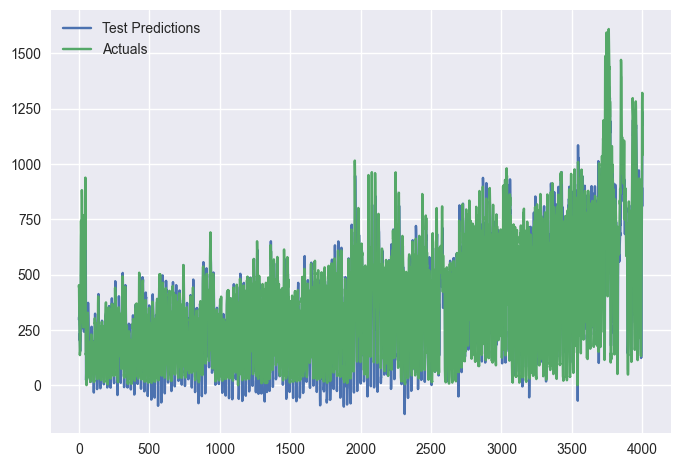

In [24]:
model = load_model('2H_Forecast/2H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(2,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D003_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D003_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 3 hours forecast

In [25]:
%%time

Trainer(3,6,12,50)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 64)                17920     
                                                                 
 dense_30 (Dense)            (None, 8)                 520       
                                                                 
 dense_31 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 11:33:20.387046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:33:20.521393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/376 [..............................] - ETA: 8:58 - loss: 1.1268 - mae: 0.8621 - mse: 1.1268 - mape: 1735.0769

2023-02-10 11:33:20.845437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.5722 - mae: 0.5896 - mse: 0.5722 - mape: 174.6192

2023-02-10 11:33:28.769981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:33:28.826230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.55656, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 16s 38ms/step - loss: 0.5722 - mae: 0.5896 - mse: 0.5722 - mape: 174.6192 - val_loss: 0.5566 - val_mae: 0.5681 - val_mse: 0.5566 - val_mape: 207.4949
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.4417 - mae: 0.4913 - mse: 0.4417 - mape: 204.2875
Epoch 2: val_loss improved from 0.55656 to 0.50995, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.4417 - mae: 0.4913 - mse: 0.4417 - mape: 204.2875 - val_loss: 0.5099 - val_mae: 0.5381 - val_mse: 0.5099 - val_mape: 201.5751
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.3984 - mae: 0.4601 - mse: 0.3984 - mape: 194.4261
Epoch 3: val_loss improved from 0.50995 to 0.47538, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.3984 - mae: 0.4601 - mse: 0.3984 - mape: 194.4261 - val_loss: 0.4754 - val_mae: 0.5148 - val_mse: 0.4754 - val_mape: 197.0840
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.3607 - mae: 0.4338 - mse: 0.3607 - mape: 176.8661
Epoch 4: val_loss improved from 0.47538 to 0.43266, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3607 - mae: 0.4338 - mse: 0.3607 - mape: 176.8661 - val_loss: 0.4327 - val_mae: 0.4892 - val_mse: 0.4327 - val_mape: 189.8779
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.3318 - mae: 0.4120 - mse: 0.3318 - mape: 176.3870
Epoch 5: val_loss improved from 0.43266 to 0.41441, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3318 - mae: 0.4120 - mse: 0.3318 - mape: 176.3870 - val_loss: 0.4144 - val_mae: 0.4737 - val_mse: 0.4144 - val_mape: 175.2576
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.3153 - mae: 0.3974 - mse: 0.3153 - mape: 166.7885
Epoch 6: val_loss improved from 0.41441 to 0.40693, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3153 - mae: 0.3974 - mse: 0.3153 - mape: 166.7885 - val_loss: 0.4069 - val_mae: 0.4663 - val_mse: 0.4069 - val_mape: 168.4227
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.3057 - mae: 0.3896 - mse: 0.3057 - mape: 175.1247
Epoch 7: val_loss did not improve from 0.40693
376/376 [==============================] - 7s 17ms/step - loss: 0.3057 - mae: 0.3896 - mse: 0.3057 - mape: 175.1247 - val_loss: 0.4071 - val_mae: 0.4644 - val_mse: 0.4071 - val_mape: 167.6898
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.2990 - mae: 0.3834 - mse: 0.2990 - mape: 169.6543
Epoch 8: val_loss improved from 0.40693 to 0.40533, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.2990 - mae: 0.3834 - mse: 0.2990 - mape: 169.6543 - val_loss: 0.4053 - val_mae: 0.4643 - val_mse: 0.4053 - val_mape: 169.3563
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.2935 - mae: 0.3790 - mse: 0.2935 - mape: 169.7798
Epoch 9: val_loss did not improve from 0.40533
376/376 [==============================] - 6s 17ms/step - loss: 0.2935 - mae: 0.3790 - mse: 0.2935 - mape: 169.7798 - val_loss: 0.4143 - val_mae: 0.4666 - val_mse: 0.4143 - val_mape: 166.2291
Epoch 10/50
374/376 [============================>.] - ETA: 0s - loss: 0.2889 - mae: 0.3752 - mse: 0.2889 - mape: 181.8503
Epoch 10: val_loss did not improve from 0.40533
376/376 [==============================] - 7s 18ms/step - loss: 0.2887 - mae: 0.3750 - mse: 0.2887 - mape: 181.4715 - val_loss: 0.4092 - val_mae: 0.4634 - val_mse: 0.4092 - val_mape: 166.0690
Epoch 11/50
374/376 [============================>.] - ETA: 0s - loss: 0.2855 - mae

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.2850 - mae: 0.3725 - mse: 0.2850 - mape: 173.6373 - val_loss: 0.4011 - val_mae: 0.4613 - val_mse: 0.4011 - val_mape: 176.0743
Epoch 12/50
373/376 [============================>.] - ETA: 0s - loss: 0.2827 - mae: 0.3692 - mse: 0.2827 - mape: 178.9053
Epoch 12: val_loss did not improve from 0.40114
376/376 [==============================] - 6s 15ms/step - loss: 0.2819 - mae: 0.3688 - mse: 0.2819 - mape: 178.5590 - val_loss: 0.4031 - val_mae: 0.4614 - val_mse: 0.4031 - val_mape: 170.7769
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.2788 - mae: 0.3668 - mse: 0.2788 - mape: 170.3967
Epoch 13: val_loss did not improve from 0.40114
376/376 [==============================] - 6s 15ms/step - loss: 0.2788 - mae: 0.3668 - mse: 0.2788 - mape: 170.3967 - val_loss: 0.4168 - val_mae: 0.4665 - val_mse: 0.4168 - val_mape: 168.7460
Epoch 14/50
373/376 [============================>.] - ETA: 0s - loss: 0.2765 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.2736 - mae: 0.3628 - mse: 0.2736 - mape: 173.4278 - val_loss: 0.3966 - val_mae: 0.4578 - val_mse: 0.3966 - val_mape: 173.1800
Epoch 16/50
373/376 [============================>.] - ETA: 0s - loss: 0.2722 - mae: 0.3619 - mse: 0.2722 - mape: 168.9684
Epoch 16: val_loss did not improve from 0.39655
376/376 [==============================] - 6s 15ms/step - loss: 0.2718 - mae: 0.3613 - mse: 0.2718 - mape: 169.2624 - val_loss: 0.4012 - val_mae: 0.4572 - val_mse: 0.4012 - val_mape: 171.9912
Epoch 17/50
376/376 [==============================] - ETA: 0s - loss: 0.2699 - mae: 0.3589 - mse: 0.2699 - mape: 175.6955
Epoch 17: val_loss did not improve from 0.39655
376/376 [==============================] - 6s 16ms/step - loss: 0.2699 - mae: 0.3589 - mse: 0.2699 - mape: 175.6955 - val_loss: 0.4045 - val_mae: 0.4608 - val_mse: 0.4045 - val_mape: 170.3092
Epoch 18/50
375/376 [============================>.] - ETA: 0s - loss: 0.2679 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2571 - mae: 0.3491 - mse: 0.2571 - mape: 171.3281 - val_loss: 0.3952 - val_mae: 0.4545 - val_mse: 0.3952 - val_mape: 174.0550
Epoch 25/50
376/376 [==============================] - ETA: 0s - loss: 0.2555 - mae: 0.3476 - mse: 0.2555 - mape: 171.5495
Epoch 25: val_loss did not improve from 0.39524
376/376 [==============================] - 6s 17ms/step - loss: 0.2555 - mae: 0.3476 - mse: 0.2555 - mape: 171.5495 - val_loss: 0.4003 - val_mae: 0.4553 - val_mse: 0.4003 - val_mape: 170.0434
Epoch 26/50
376/376 [==============================] - ETA: 0s - loss: 0.2547 - mae: 0.3469 - mse: 0.2547 - mape: 170.3219
Epoch 26: val_loss improved from 0.39524 to 0.38806, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2547 - mae: 0.3469 - mse: 0.2547 - mape: 170.3219 - val_loss: 0.3881 - val_mae: 0.4500 - val_mse: 0.3881 - val_mape: 174.8941
Epoch 27/50
376/376 [==============================] - ETA: 0s - loss: 0.2529 - mae: 0.3454 - mse: 0.2529 - mape: 180.6150
Epoch 27: val_loss did not improve from 0.38806
376/376 [==============================] - 7s 18ms/step - loss: 0.2529 - mae: 0.3454 - mse: 0.2529 - mape: 180.6150 - val_loss: 0.3902 - val_mae: 0.4522 - val_mse: 0.3902 - val_mape: 175.7346
Epoch 28/50
376/376 [==============================] - ETA: 0s - loss: 0.2518 - mae: 0.3445 - mse: 0.2518 - mape: 173.8253
Epoch 28: val_loss did not improve from 0.38806
376/376 [==============================] - 7s 17ms/step - loss: 0.2518 - mae: 0.3445 - mse: 0.2518 - mape: 173.8253 - val_loss: 0.3984 - val_mae: 0.4530 - val_mse: 0.3984 - val_mape: 169.9185
Epoch 29/50
375/376 [============================>.] - ETA: 0s - loss: 0.2501 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2502 - mae: 0.3436 - mse: 0.2502 - mape: 182.8876 - val_loss: 0.3853 - val_mae: 0.4496 - val_mse: 0.3853 - val_mape: 173.6297
Epoch 30/50
376/376 [==============================] - ETA: 0s - loss: 0.2494 - mae: 0.3423 - mse: 0.2494 - mape: 179.5313
Epoch 30: val_loss did not improve from 0.38535
376/376 [==============================] - 6s 16ms/step - loss: 0.2494 - mae: 0.3423 - mse: 0.2494 - mape: 179.5313 - val_loss: 0.3881 - val_mae: 0.4503 - val_mse: 0.3881 - val_mape: 174.3099
Epoch 31/50
375/376 [============================>.] - ETA: 0s - loss: 0.2480 - mae: 0.3417 - mse: 0.2480 - mape: 182.6580
Epoch 31: val_loss improved from 0.38535 to 0.38467, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2480 - mae: 0.3417 - mse: 0.2480 - mape: 182.6172 - val_loss: 0.3847 - val_mae: 0.4473 - val_mse: 0.3847 - val_mape: 172.6758
Epoch 32/50
374/376 [============================>.] - ETA: 0s - loss: 0.2470 - mae: 0.3405 - mse: 0.2470 - mape: 180.3804
Epoch 32: val_loss improved from 0.38467 to 0.38313, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.2470 - mae: 0.3405 - mse: 0.2470 - mape: 179.9527 - val_loss: 0.3831 - val_mae: 0.4481 - val_mse: 0.3831 - val_mape: 174.9181
Epoch 33/50
373/376 [============================>.] - ETA: 0s - loss: 0.2454 - mae: 0.3395 - mse: 0.2454 - mape: 185.6175
Epoch 33: val_loss improved from 0.38313 to 0.37866, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.2457 - mae: 0.3395 - mse: 0.2457 - mape: 185.0763 - val_loss: 0.3787 - val_mae: 0.4470 - val_mse: 0.3787 - val_mape: 174.2423
Epoch 34/50
376/376 [==============================] - ETA: 0s - loss: 0.2446 - mae: 0.3396 - mse: 0.2446 - mape: 187.8097
Epoch 34: val_loss did not improve from 0.37866
376/376 [==============================] - 6s 17ms/step - loss: 0.2446 - mae: 0.3396 - mse: 0.2446 - mape: 187.8097 - val_loss: 0.3795 - val_mae: 0.4469 - val_mse: 0.3795 - val_mape: 174.7446
Epoch 35/50
373/376 [============================>.] - ETA: 0s - loss: 0.2432 - mae: 0.3381 - mse: 0.2432 - mape: 190.8325
Epoch 35: val_loss did not improve from 0.37866
376/376 [==============================] - 7s 17ms/step - loss: 0.2435 - mae: 0.3383 - mse: 0.2435 - mape: 190.9212 - val_loss: 0.3812 - val_mae: 0.4498 - val_mse: 0.3812 - val_mape: 174.5423
Epoch 36/50
373/376 [============================>.] - ETA: 0s - loss: 0.2426 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.2423 - mae: 0.3370 - mse: 0.2423 - mape: 191.9233 - val_loss: 0.3754 - val_mae: 0.4450 - val_mse: 0.3754 - val_mape: 174.8339
Epoch 37/50
376/376 [==============================] - ETA: 0s - loss: 0.2413 - mae: 0.3369 - mse: 0.2413 - mape: 201.7984
Epoch 37: val_loss improved from 0.37539 to 0.37345, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.2413 - mae: 0.3369 - mse: 0.2413 - mape: 201.7984 - val_loss: 0.3735 - val_mae: 0.4432 - val_mse: 0.3735 - val_mape: 174.6036
Epoch 38/50
373/376 [============================>.] - ETA: 0s - loss: 0.2399 - mae: 0.3354 - mse: 0.2399 - mape: 191.6440
Epoch 38: val_loss did not improve from 0.37345
376/376 [==============================] - 6s 17ms/step - loss: 0.2402 - mae: 0.3356 - mse: 0.2402 - mape: 191.1754 - val_loss: 0.3857 - val_mae: 0.4471 - val_mse: 0.3857 - val_mape: 172.3826
Epoch 39/50
373/376 [============================>.] - ETA: 0s - loss: 0.2393 - mae: 0.3356 - mse: 0.2393 - mape: 194.2920
Epoch 39: val_loss did not improve from 0.37345
376/376 [==============================] - 6s 17ms/step - loss: 0.2395 - mae: 0.3358 - mse: 0.2395 - mape: 194.0367 - val_loss: 0.3785 - val_mae: 0.4456 - val_mse: 0.3785 - val_mape: 173.5931
Epoch 40/50
374/376 [============================>.] - ETA: 0s - loss: 0.2377 - m

2023-02-10 11:40:01.226607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:40:01.360977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/376 [..............................] - ETA: 8:56 - loss: 0.6366 - mae: 0.6954 - mse: 0.6366 - mape: 104.3874

2023-02-10 11:40:01.662079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6334 - mae: 0.6279 - mse: 0.6334 - mape: 203.1560

2023-02-10 11:40:07.961956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:40:08.014816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.66934, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 13s 30ms/step - loss: 0.6334 - mae: 0.6279 - mse: 0.6334 - mape: 203.1560 - val_loss: 0.6693 - val_mae: 0.6235 - val_mse: 0.6693 - val_mape: 197.4772
Epoch 2/50
375/376 [============================>.] - ETA: 0s - loss: 0.4725 - mae: 0.5155 - mse: 0.4725 - mape: 243.2330
Epoch 2: val_loss improved from 0.66934 to 0.56748, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.4726 - mae: 0.5156 - mse: 0.4726 - mape: 243.2524 - val_loss: 0.5675 - val_mae: 0.5695 - val_mse: 0.5675 - val_mape: 201.1563
Epoch 3/50
374/376 [============================>.] - ETA: 0s - loss: 0.4177 - mae: 0.4761 - mse: 0.4177 - mape: 225.9863
Epoch 3: val_loss improved from 0.56748 to 0.50989, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 9s 25ms/step - loss: 0.4179 - mae: 0.4763 - mse: 0.4179 - mape: 225.4639 - val_loss: 0.5099 - val_mae: 0.5315 - val_mse: 0.5099 - val_mape: 189.9926
Epoch 4/50
374/376 [============================>.] - ETA: 0s - loss: 0.3717 - mae: 0.4431 - mse: 0.3717 - mape: 209.0522
Epoch 4: val_loss improved from 0.50989 to 0.45246, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.3715 - mae: 0.4431 - mse: 0.3715 - mape: 209.8865 - val_loss: 0.4525 - val_mae: 0.4972 - val_mse: 0.4525 - val_mape: 182.6640
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.3401 - mae: 0.4198 - mse: 0.3401 - mape: 192.3648
Epoch 5: val_loss improved from 0.45246 to 0.42258, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3401 - mae: 0.4198 - mse: 0.3401 - mape: 192.3648 - val_loss: 0.4226 - val_mae: 0.4777 - val_mse: 0.4226 - val_mape: 177.0303
Epoch 6/50
375/376 [============================>.] - ETA: 0s - loss: 0.3225 - mae: 0.4054 - mse: 0.3225 - mape: 189.9175
Epoch 6: val_loss did not improve from 0.42258
376/376 [==============================] - 6s 17ms/step - loss: 0.3225 - mae: 0.4054 - mse: 0.3225 - mape: 189.9417 - val_loss: 0.4247 - val_mae: 0.4734 - val_mse: 0.4247 - val_mape: 166.1758
Epoch 7/50
374/376 [============================>.] - ETA: 0s - loss: 0.3096 - mae: 0.3959 - mse: 0.3096 - mape: 174.1148
Epoch 7: val_loss improved from 0.42258 to 0.41408, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.3104 - mae: 0.3963 - mse: 0.3104 - mape: 173.8095 - val_loss: 0.4141 - val_mae: 0.4681 - val_mse: 0.4141 - val_mape: 170.2507
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.3018 - mae: 0.3888 - mse: 0.3018 - mape: 171.3503
Epoch 8: val_loss did not improve from 0.41408
376/376 [==============================] - 6s 16ms/step - loss: 0.3018 - mae: 0.3888 - mse: 0.3018 - mape: 171.3503 - val_loss: 0.4146 - val_mae: 0.4640 - val_mse: 0.4146 - val_mape: 167.0887
Epoch 9/50
374/376 [============================>.] - ETA: 0s - loss: 0.2941 - mae: 0.3825 - mse: 0.2941 - mape: 175.5105
Epoch 9: val_loss did not improve from 0.41408
376/376 [==============================] - 6s 16ms/step - loss: 0.2939 - mae: 0.3823 - mse: 0.2939 - mape: 175.5602 - val_loss: 0.4187 - val_mae: 0.4616 - val_mse: 0.4187 - val_mape: 157.7820
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.2880 - mae: 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.2880 - mae: 0.3766 - mse: 0.2880 - mape: 170.1530 - val_loss: 0.4015 - val_mae: 0.4566 - val_mse: 0.4015 - val_mape: 162.9168
Epoch 11/50
375/376 [============================>.] - ETA: 0s - loss: 0.2823 - mae: 0.3712 - mse: 0.2823 - mape: 169.4282
Epoch 11: val_loss did not improve from 0.40150
376/376 [==============================] - 6s 16ms/step - loss: 0.2823 - mae: 0.3712 - mse: 0.2823 - mape: 169.3502 - val_loss: 0.4131 - val_mae: 0.4583 - val_mse: 0.4131 - val_mape: 159.1122
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.2784 - mae: 0.3679 - mse: 0.2784 - mape: 174.2724
Epoch 12: val_loss improved from 0.40150 to 0.39616, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.2784 - mae: 0.3679 - mse: 0.2784 - mape: 174.2724 - val_loss: 0.3962 - val_mae: 0.4500 - val_mse: 0.3962 - val_mape: 160.2172
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.2742 - mae: 0.3638 - mse: 0.2742 - mape: 173.9474
Epoch 13: val_loss improved from 0.39616 to 0.39162, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.2742 - mae: 0.3638 - mse: 0.2742 - mape: 173.9474 - val_loss: 0.3916 - val_mae: 0.4506 - val_mse: 0.3916 - val_mape: 161.5441
Epoch 14/50
376/376 [==============================] - ETA: 0s - loss: 0.2703 - mae: 0.3608 - mse: 0.2703 - mape: 174.6067
Epoch 14: val_loss improved from 0.39162 to 0.39056, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.2703 - mae: 0.3608 - mse: 0.2703 - mape: 174.6067 - val_loss: 0.3906 - val_mae: 0.4479 - val_mse: 0.3906 - val_mape: 159.1200
Epoch 15/50
375/376 [============================>.] - ETA: 0s - loss: 0.2671 - mae: 0.3578 - mse: 0.2671 - mape: 163.2689
Epoch 15: val_loss improved from 0.39056 to 0.38942, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.2671 - mae: 0.3578 - mse: 0.2671 - mape: 169.5815 - val_loss: 0.3894 - val_mae: 0.4451 - val_mse: 0.3894 - val_mape: 162.1539
Epoch 16/50
375/376 [============================>.] - ETA: 0s - loss: 0.2640 - mae: 0.3548 - mse: 0.2640 - mape: 180.6692
Epoch 16: val_loss improved from 0.38942 to 0.38733, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.2641 - mae: 0.3548 - mse: 0.2641 - mape: 180.5703 - val_loss: 0.3873 - val_mae: 0.4446 - val_mse: 0.3873 - val_mape: 161.2766
Epoch 17/50
373/376 [============================>.] - ETA: 0s - loss: 0.2611 - mae: 0.3520 - mse: 0.2611 - mape: 177.4040
Epoch 17: val_loss improved from 0.38733 to 0.37424, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.2612 - mae: 0.3522 - mse: 0.2612 - mape: 178.2014 - val_loss: 0.3742 - val_mae: 0.4405 - val_mse: 0.3742 - val_mape: 164.1078
Epoch 18/50
375/376 [============================>.] - ETA: 0s - loss: 0.2593 - mae: 0.3506 - mse: 0.2593 - mape: 174.7750
Epoch 18: val_loss did not improve from 0.37424
376/376 [==============================] - 6s 16ms/step - loss: 0.2591 - mae: 0.3504 - mse: 0.2591 - mape: 174.6711 - val_loss: 0.3773 - val_mae: 0.4400 - val_mse: 0.3773 - val_mape: 161.5149
Epoch 19/50
375/376 [============================>.] - ETA: 0s - loss: 0.2567 - mae: 0.3482 - mse: 0.2567 - mape: 176.6379
Epoch 19: val_loss improved from 0.37424 to 0.37220, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.2566 - mae: 0.3480 - mse: 0.2566 - mape: 176.5316 - val_loss: 0.3722 - val_mae: 0.4385 - val_mse: 0.3722 - val_mape: 164.9341
Epoch 20/50
376/376 [==============================] - ETA: 0s - loss: 0.2550 - mae: 0.3468 - mse: 0.2550 - mape: 168.7936
Epoch 20: val_loss did not improve from 0.37220
376/376 [==============================] - 6s 16ms/step - loss: 0.2550 - mae: 0.3468 - mse: 0.2550 - mape: 168.7936 - val_loss: 0.3729 - val_mae: 0.4380 - val_mse: 0.3729 - val_mape: 161.3154
Epoch 21/50
374/376 [============================>.] - ETA: 0s - loss: 0.2523 - mae: 0.3450 - mse: 0.2523 - mape: 185.7687
Epoch 21: val_loss did not improve from 0.37220
376/376 [==============================] - 6s 16ms/step - loss: 0.2526 - mae: 0.3450 - mse: 0.2526 - mape: 185.3706 - val_loss: 0.3879 - val_mae: 0.4425 - val_mse: 0.3879 - val_mape: 159.8802
Epoch 22/50
376/376 [==============================] - ETA: 0s - loss: 0.2509 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.2490 - mae: 0.3424 - mse: 0.2490 - mape: 186.9840 - val_loss: 0.3700 - val_mae: 0.4379 - val_mse: 0.3700 - val_mape: 161.6037
Epoch 24/50
374/376 [============================>.] - ETA: 0s - loss: 0.2471 - mae: 0.3401 - mse: 0.2471 - mape: 185.8721
Epoch 24: val_loss did not improve from 0.37004
376/376 [==============================] - 6s 16ms/step - loss: 0.2471 - mae: 0.3402 - mse: 0.2471 - mape: 185.5827 - val_loss: 0.3775 - val_mae: 0.4395 - val_mse: 0.3775 - val_mape: 160.0695
Epoch 25/50
376/376 [==============================] - ETA: 0s - loss: 0.2455 - mae: 0.3391 - mse: 0.2455 - mape: 191.6175
Epoch 25: val_loss did not improve from 0.37004
376/376 [==============================] - 6s 16ms/step - loss: 0.2455 - mae: 0.3391 - mse: 0.2455 - mape: 191.6175 - val_loss: 0.3747 - val_mae: 0.4364 - val_mse: 0.3747 - val_mape: 160.9276
Epoch 26/50
376/376 [==============================] - ETA: 0s - loss: 0.2433 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.2417 - mae: 0.3363 - mse: 0.2417 - mape: 197.6647 - val_loss: 0.3678 - val_mae: 0.4345 - val_mse: 0.3678 - val_mape: 162.4506
Epoch 28/50
375/376 [============================>.] - ETA: 0s - loss: 0.2401 - mae: 0.3350 - mse: 0.2401 - mape: 198.1090
Epoch 28: val_loss did not improve from 0.36781
376/376 [==============================] - 7s 17ms/step - loss: 0.2400 - mae: 0.3349 - mse: 0.2400 - mape: 197.9771 - val_loss: 0.3718 - val_mae: 0.4362 - val_mse: 0.3718 - val_mape: 161.0310
Epoch 29/50
375/376 [============================>.] - ETA: 0s - loss: 0.2389 - mae: 0.3347 - mse: 0.2389 - mape: 194.9728
Epoch 29: val_loss did not improve from 0.36781
376/376 [==============================] - 6s 17ms/step - loss: 0.2389 - mae: 0.3346 - mse: 0.2389 - mape: 194.8705 - val_loss: 0.3684 - val_mae: 0.4348 - val_mse: 0.3684 - val_mape: 163.3642
Epoch 30/50
376/376 [==============================] - ETA: 0s - loss: 0.2370 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2309 - mae: 0.3286 - mse: 0.2309 - mape: 200.5304 - val_loss: 0.3653 - val_mae: 0.4285 - val_mse: 0.3653 - val_mape: 168.2260
Epoch 35/50
374/376 [============================>.] - ETA: 0s - loss: 0.2296 - mae: 0.3279 - mse: 0.2296 - mape: 198.8049
Epoch 35: val_loss did not improve from 0.36526
376/376 [==============================] - 7s 18ms/step - loss: 0.2296 - mae: 0.3277 - mse: 0.2296 - mape: 198.5367 - val_loss: 0.3713 - val_mae: 0.4338 - val_mse: 0.3713 - val_mape: 165.5289
Epoch 36/50
376/376 [==============================] - ETA: 0s - loss: 0.2281 - mae: 0.3267 - mse: 0.2281 - mape: 207.1940
Epoch 36: val_loss did not improve from 0.36526
376/376 [==============================] - 7s 19ms/step - loss: 0.2281 - mae: 0.3267 - mse: 0.2281 - mape: 207.1940 - val_loss: 0.3880 - val_mae: 0.4387 - val_mse: 0.3880 - val_mape: 163.2850
Epoch 37/50
376/376 [==============================] - ETA: 0s - loss: 0.2270 - m

2023-02-10 11:46:37.620384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:46:37.760985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:46:38.149295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6642 - mae: 0.6443 - mse: 0.6642 - mape: 216.3282

2023-02-10 11:46:46.769170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:46:46.837700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.65046, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 17s 38ms/step - loss: 0.6642 - mae: 0.6443 - mse: 0.6642 - mape: 216.3282 - val_loss: 0.6505 - val_mae: 0.6180 - val_mse: 0.6505 - val_mape: 195.8624
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.4504 - mae: 0.5011 - mse: 0.4504 - mape: 243.6711
Epoch 2: val_loss improved from 0.65046 to 0.53461, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 33ms/step - loss: 0.4504 - mae: 0.5011 - mse: 0.4504 - mape: 243.6711 - val_loss: 0.5346 - val_mae: 0.5520 - val_mse: 0.5346 - val_mape: 198.1748
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.3859 - mae: 0.4540 - mse: 0.3859 - mape: 221.2663
Epoch 3: val_loss improved from 0.53461 to 0.47737, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.3859 - mae: 0.4540 - mse: 0.3859 - mape: 221.2663 - val_loss: 0.4774 - val_mae: 0.5136 - val_mse: 0.4774 - val_mape: 187.9096
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.3472 - mae: 0.4271 - mse: 0.3472 - mape: 202.9573
Epoch 4: val_loss improved from 0.47737 to 0.44690, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.3472 - mae: 0.4271 - mse: 0.3472 - mape: 202.9573 - val_loss: 0.4469 - val_mae: 0.4912 - val_mse: 0.4469 - val_mape: 179.7248
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.3252 - mae: 0.4112 - mse: 0.3252 - mape: 199.8596
Epoch 5: val_loss did not improve from 0.44690
376/376 [==============================] - 7s 20ms/step - loss: 0.3252 - mae: 0.4112 - mse: 0.3252 - mape: 199.8596 - val_loss: 0.4495 - val_mae: 0.4877 - val_mse: 0.4495 - val_mape: 179.7511
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.3120 - mae: 0.3999 - mse: 0.3120 - mape: 194.8514
Epoch 6: val_loss did not improve from 0.44690
376/376 [==============================] - 7s 18ms/step - loss: 0.3120 - mae: 0.3999 - mse: 0.3120 - mape: 194.8514 - val_loss: 0.4490 - val_mae: 0.4848 - val_mse: 0.4490 - val_mape: 172.4640
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.3022 - mae: 0

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 17s 46ms/step - loss: 0.3022 - mae: 0.3917 - mse: 0.3022 - mape: 185.7355 - val_loss: 0.4253 - val_mae: 0.4725 - val_mse: 0.4253 - val_mape: 172.1916
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.2944 - mae: 0.3855 - mse: 0.2944 - mape: 190.6441
Epoch 8: val_loss improved from 0.42535 to 0.42041, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 15s 39ms/step - loss: 0.2944 - mae: 0.3855 - mse: 0.2944 - mape: 190.6441 - val_loss: 0.4204 - val_mae: 0.4669 - val_mse: 0.4204 - val_mape: 164.9032
Epoch 9/50
375/376 [============================>.] - ETA: 0s - loss: 0.2878 - mae: 0.3791 - mse: 0.2878 - mape: 186.1131
Epoch 9: val_loss did not improve from 0.42041
376/376 [==============================] - 7s 18ms/step - loss: 0.2879 - mae: 0.3792 - mse: 0.2879 - mape: 186.0495 - val_loss: 0.4214 - val_mae: 0.4664 - val_mse: 0.4214 - val_mape: 162.3521
Epoch 10/50
374/376 [============================>.] - ETA: 0s - loss: 0.2817 - mae: 0.3731 - mse: 0.2817 - mape: 177.3320
Epoch 10: val_loss did not improve from 0.42041
376/376 [==============================] - 6s 17ms/step - loss: 0.2817 - mae: 0.3731 - mse: 0.2817 - mape: 176.9433 - val_loss: 0.4258 - val_mae: 0.4677 - val_mse: 0.4258 - val_mape: 165.2103
Epoch 11/50
374/376 [============================>.] - ETA: 0s - loss: 0.2767 - mae

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.2766 - mae: 0.3695 - mse: 0.2766 - mape: 183.2401 - val_loss: 0.4127 - val_mae: 0.4603 - val_mse: 0.4127 - val_mape: 163.3503
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.2723 - mae: 0.3650 - mse: 0.2723 - mape: 175.3583
Epoch 12: val_loss improved from 0.41265 to 0.40888, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 16s 42ms/step - loss: 0.2723 - mae: 0.3650 - mse: 0.2723 - mape: 175.3583 - val_loss: 0.4089 - val_mae: 0.4612 - val_mse: 0.4089 - val_mape: 164.5233
Epoch 13/50
374/376 [============================>.] - ETA: 0s - loss: 0.2682 - mae: 0.3622 - mse: 0.2682 - mape: 178.5967
Epoch 13: val_loss improved from 0.40888 to 0.40801, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 16s 41ms/step - loss: 0.2682 - mae: 0.3622 - mse: 0.2682 - mape: 178.2902 - val_loss: 0.4080 - val_mae: 0.4580 - val_mse: 0.4080 - val_mape: 164.8989
Epoch 14/50
376/376 [==============================] - ETA: 0s - loss: 0.2649 - mae: 0.3583 - mse: 0.2649 - mape: 169.5498
Epoch 14: val_loss improved from 0.40801 to 0.40525, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 21s 55ms/step - loss: 0.2649 - mae: 0.3583 - mse: 0.2649 - mape: 169.5498 - val_loss: 0.4052 - val_mae: 0.4571 - val_mse: 0.4052 - val_mape: 161.4401
Epoch 15/50
376/376 [==============================] - ETA: 0s - loss: 0.2614 - mae: 0.3555 - mse: 0.2614 - mape: 178.2317
Epoch 15: val_loss improved from 0.40525 to 0.40025, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 36ms/step - loss: 0.2614 - mae: 0.3555 - mse: 0.2614 - mape: 178.2317 - val_loss: 0.4003 - val_mae: 0.4531 - val_mse: 0.4003 - val_mape: 160.7654
Epoch 16/50
376/376 [==============================] - ETA: 0s - loss: 0.2584 - mae: 0.3527 - mse: 0.2584 - mape: 183.9656
Epoch 16: val_loss improved from 0.40025 to 0.39348, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 14s 38ms/step - loss: 0.2584 - mae: 0.3527 - mse: 0.2584 - mape: 183.9656 - val_loss: 0.3935 - val_mae: 0.4492 - val_mse: 0.3935 - val_mape: 163.4360
Epoch 17/50
376/376 [==============================] - ETA: 0s - loss: 0.2557 - mae: 0.3504 - mse: 0.2557 - mape: 175.4231
Epoch 17: val_loss did not improve from 0.39348
376/376 [==============================] - 7s 20ms/step - loss: 0.2557 - mae: 0.3504 - mse: 0.2557 - mape: 175.4231 - val_loss: 0.3954 - val_mae: 0.4479 - val_mse: 0.3954 - val_mape: 162.1708
Epoch 18/50
376/376 [==============================] - ETA: 0s - loss: 0.2527 - mae: 0.3485 - mse: 0.2527 - mape: 175.4339
Epoch 18: val_loss did not improve from 0.39348
376/376 [==============================] - 7s 18ms/step - loss: 0.2527 - mae: 0.3485 - mse: 0.2527 - mape: 175.4339 - val_loss: 0.3971 - val_mae: 0.4497 - val_mse: 0.3971 - val_mape: 160.4434
Epoch 19/50
376/376 [==============================] - ETA: 0s - loss: 0.2502 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2502 - mae: 0.3463 - mse: 0.2502 - mape: 183.0300 - val_loss: 0.3818 - val_mae: 0.4431 - val_mse: 0.3818 - val_mape: 164.4919
Epoch 20/50
376/376 [==============================] - ETA: 0s - loss: 0.2479 - mae: 0.3445 - mse: 0.2479 - mape: 177.9067
Epoch 20: val_loss improved from 0.38184 to 0.38022, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2479 - mae: 0.3445 - mse: 0.2479 - mape: 177.9067 - val_loss: 0.3802 - val_mae: 0.4407 - val_mse: 0.3802 - val_mape: 162.4329
Epoch 21/50
375/376 [============================>.] - ETA: 0s - loss: 0.2456 - mae: 0.3427 - mse: 0.2456 - mape: 177.1781
Epoch 21: val_loss improved from 0.38022 to 0.37570, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2456 - mae: 0.3427 - mse: 0.2456 - mape: 177.1129 - val_loss: 0.3757 - val_mae: 0.4417 - val_mse: 0.3757 - val_mape: 161.8643
Epoch 22/50
375/376 [============================>.] - ETA: 0s - loss: 0.2429 - mae: 0.3406 - mse: 0.2429 - mape: 184.3403
Epoch 22: val_loss did not improve from 0.37570
376/376 [==============================] - 7s 18ms/step - loss: 0.2427 - mae: 0.3405 - mse: 0.2427 - mape: 184.2537 - val_loss: 0.3840 - val_mae: 0.4447 - val_mse: 0.3840 - val_mape: 164.1037
Epoch 23/50
373/376 [============================>.] - ETA: 0s - loss: 0.2411 - mae: 0.3395 - mse: 0.2411 - mape: 185.3969
Epoch 23: val_loss did not improve from 0.37570
376/376 [==============================] - 6s 17ms/step - loss: 0.2409 - mae: 0.3394 - mse: 0.2409 - mape: 185.1658 - val_loss: 0.3780 - val_mae: 0.4419 - val_mse: 0.3780 - val_mape: 159.6841
Epoch 24/50
376/376 [==============================] - ETA: 0s - loss: 0.2385 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.2385 - mae: 0.3383 - mse: 0.2385 - mape: 184.8431 - val_loss: 0.3750 - val_mae: 0.4379 - val_mse: 0.3750 - val_mape: 161.7472
Epoch 25/50
373/376 [============================>.] - ETA: 0s - loss: 0.2356 - mae: 0.3358 - mse: 0.2356 - mape: 184.7581
Epoch 25: val_loss did not improve from 0.37498
376/376 [==============================] - 7s 19ms/step - loss: 0.2360 - mae: 0.3362 - mse: 0.2360 - mape: 183.9999 - val_loss: 0.3853 - val_mae: 0.4424 - val_mse: 0.3853 - val_mape: 159.1164
Epoch 26/50
375/376 [============================>.] - ETA: 0s - loss: 0.2344 - mae: 0.3346 - mse: 0.2344 - mape: 188.9547
Epoch 26: val_loss did not improve from 0.37498
376/376 [==============================] - 9s 25ms/step - loss: 0.2344 - mae: 0.3346 - mse: 0.2344 - mape: 188.8471 - val_loss: 0.3883 - val_mae: 0.4426 - val_mse: 0.3883 - val_mape: 155.6625
Epoch 27/50
376/376 [==============================] - ETA: 0s - loss: 0.2326 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2234 - mae: 0.3281 - mse: 0.2234 - mape: 180.8528 - val_loss: 0.3749 - val_mae: 0.4408 - val_mse: 0.3749 - val_mape: 164.3534
Epoch 33/50
373/376 [============================>.] - ETA: 0s - loss: 0.2217 - mae: 0.3262 - mse: 0.2217 - mape: 188.4201
Epoch 33: val_loss did not improve from 0.37487
376/376 [==============================] - 7s 18ms/step - loss: 0.2219 - mae: 0.3263 - mse: 0.2219 - mape: 187.8998 - val_loss: 0.3882 - val_mae: 0.4437 - val_mse: 0.3882 - val_mape: 159.1859
Epoch 34/50
376/376 [==============================] - ETA: 0s - loss: 0.2202 - mae: 0.3258 - mse: 0.2202 - mape: 196.1284
Epoch 34: val_loss did not improve from 0.37487
376/376 [==============================] - 9s 23ms/step - loss: 0.2202 - mae: 0.3258 - mse: 0.2202 - mape: 196.1284 - val_loss: 0.3880 - val_mae: 0.4428 - val_mse: 0.3880 - val_mape: 160.4556
Epoch 35/50
376/376 [==============================] - ETA: 0s - loss: 0.2183 - m

2023-02-10 11:54:18.322079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:54:18.461256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:54:18.792443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6243 - mae: 0.6155 - mse: 0.6243 - mape: 211.6768

2023-02-10 11:54:25.502742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:54:25.573535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.61243, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 14s 33ms/step - loss: 0.6243 - mae: 0.6155 - mse: 0.6243 - mape: 211.6768 - val_loss: 0.6124 - val_mae: 0.5965 - val_mse: 0.6124 - val_mape: 216.4411
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.4508 - mae: 0.5029 - mse: 0.4508 - mape: 244.9358
Epoch 2: val_loss improved from 0.61243 to 0.51739, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4508 - mae: 0.5029 - mse: 0.4508 - mape: 244.9358 - val_loss: 0.5174 - val_mae: 0.5422 - val_mse: 0.5174 - val_mape: 211.7782
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.3895 - mae: 0.4582 - mse: 0.3895 - mape: 223.3355
Epoch 3: val_loss improved from 0.51739 to 0.47710, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3895 - mae: 0.4582 - mse: 0.3895 - mape: 223.3355 - val_loss: 0.4771 - val_mae: 0.5120 - val_mse: 0.4771 - val_mape: 201.6167
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.3478 - mae: 0.4252 - mse: 0.3478 - mape: 209.9644
Epoch 4: val_loss improved from 0.47710 to 0.45762, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 31ms/step - loss: 0.3478 - mae: 0.4252 - mse: 0.3478 - mape: 209.9644 - val_loss: 0.4576 - val_mae: 0.4920 - val_mse: 0.4576 - val_mape: 185.5367
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.3234 - mae: 0.4072 - mse: 0.3234 - mape: 198.4176
Epoch 5: val_loss improved from 0.45762 to 0.44045, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3234 - mae: 0.4072 - mse: 0.3234 - mape: 198.4176 - val_loss: 0.4405 - val_mae: 0.4803 - val_mse: 0.4405 - val_mape: 174.7855
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.3077 - mae: 0.3955 - mse: 0.3077 - mape: 184.8320
Epoch 6: val_loss improved from 0.44045 to 0.42982, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3077 - mae: 0.3955 - mse: 0.3077 - mape: 184.8320 - val_loss: 0.4298 - val_mae: 0.4720 - val_mse: 0.4298 - val_mape: 168.1550
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.2949 - mae: 0.3851 - mse: 0.2949 - mape: 187.3693
Epoch 7: val_loss improved from 0.42982 to 0.40951, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2949 - mae: 0.3851 - mse: 0.2949 - mape: 187.3693 - val_loss: 0.4095 - val_mae: 0.4620 - val_mse: 0.4095 - val_mape: 172.3183
Epoch 8/50
375/376 [============================>.] - ETA: 0s - loss: 0.2836 - mae: 0.3758 - mse: 0.2836 - mape: 168.3755
Epoch 8: val_loss improved from 0.40951 to 0.40673, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2837 - mae: 0.3759 - mse: 0.2837 - mape: 168.4041 - val_loss: 0.4067 - val_mae: 0.4571 - val_mse: 0.4067 - val_mape: 159.6727
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.2749 - mae: 0.3679 - mse: 0.2749 - mape: 166.5836
Epoch 9: val_loss improved from 0.40673 to 0.39011, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.2749 - mae: 0.3679 - mse: 0.2749 - mape: 166.5836 - val_loss: 0.3901 - val_mae: 0.4506 - val_mse: 0.3901 - val_mape: 164.2503
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.2682 - mae: 0.3625 - mse: 0.2682 - mape: 165.8005
Epoch 10: val_loss improved from 0.39011 to 0.37926, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.2682 - mae: 0.3625 - mse: 0.2682 - mape: 165.8005 - val_loss: 0.3793 - val_mae: 0.4435 - val_mse: 0.3793 - val_mape: 166.1338
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.2625 - mae: 0.3568 - mse: 0.2625 - mape: 169.1295
Epoch 11: val_loss did not improve from 0.37926
376/376 [==============================] - 7s 19ms/step - loss: 0.2625 - mae: 0.3568 - mse: 0.2625 - mape: 169.1295 - val_loss: 0.3843 - val_mae: 0.4428 - val_mse: 0.3843 - val_mape: 158.4133
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.2579 - mae: 0.3531 - mse: 0.2579 - mape: 165.5007
Epoch 12: val_loss improved from 0.37926 to 0.37496, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2579 - mae: 0.3531 - mse: 0.2579 - mape: 165.5007 - val_loss: 0.3750 - val_mae: 0.4399 - val_mse: 0.3750 - val_mape: 160.9904
Epoch 13/50
375/376 [============================>.] - ETA: 0s - loss: 0.2540 - mae: 0.3497 - mse: 0.2540 - mape: 164.2967
Epoch 13: val_loss improved from 0.37496 to 0.36851, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2539 - mae: 0.3496 - mse: 0.2539 - mape: 164.2297 - val_loss: 0.3685 - val_mae: 0.4354 - val_mse: 0.3685 - val_mape: 161.1230
Epoch 14/50
376/376 [==============================] - ETA: 0s - loss: 0.2509 - mae: 0.3467 - mse: 0.2509 - mape: 165.4196
Epoch 14: val_loss did not improve from 0.36851
376/376 [==============================] - 7s 18ms/step - loss: 0.2509 - mae: 0.3467 - mse: 0.2509 - mape: 165.4196 - val_loss: 0.3716 - val_mae: 0.4347 - val_mse: 0.3716 - val_mape: 159.7876
Epoch 15/50
375/376 [============================>.] - ETA: 0s - loss: 0.2478 - mae: 0.3436 - mse: 0.2478 - mape: 162.5484
Epoch 15: val_loss did not improve from 0.36851
376/376 [==============================] - 7s 17ms/step - loss: 0.2477 - mae: 0.3436 - mse: 0.2477 - mape: 162.4841 - val_loss: 0.3733 - val_mae: 0.4353 - val_mse: 0.3733 - val_mape: 158.1554
Epoch 16/50
374/376 [============================>.] - ETA: 0s - loss: 0.2450 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2454 - mae: 0.3418 - mse: 0.2454 - mape: 163.2391 - val_loss: 0.3679 - val_mae: 0.4326 - val_mse: 0.3679 - val_mape: 161.9415
Epoch 17/50
376/376 [==============================] - ETA: 0s - loss: 0.2426 - mae: 0.3398 - mse: 0.2426 - mape: 160.9018
Epoch 17: val_loss did not improve from 0.36786
376/376 [==============================] - 7s 17ms/step - loss: 0.2426 - mae: 0.3398 - mse: 0.2426 - mape: 160.9018 - val_loss: 0.3707 - val_mae: 0.4356 - val_mse: 0.3707 - val_mape: 163.7906
Epoch 18/50
376/376 [==============================] - ETA: 0s - loss: 0.2403 - mae: 0.3374 - mse: 0.2403 - mape: 169.0320
Epoch 18: val_loss did not improve from 0.36786
376/376 [==============================] - 7s 19ms/step - loss: 0.2403 - mae: 0.3374 - mse: 0.2403 - mape: 169.0320 - val_loss: 0.3770 - val_mae: 0.4354 - val_mse: 0.3770 - val_mape: 159.6443
Epoch 19/50
373/376 [============================>.] - ETA: 0s - loss: 0.2376 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2336 - mae: 0.3326 - mse: 0.2336 - mape: 156.7306 - val_loss: 0.3562 - val_mae: 0.4303 - val_mse: 0.3562 - val_mape: 161.4898
Epoch 22/50
374/376 [============================>.] - ETA: 0s - loss: 0.2319 - mae: 0.3308 - mse: 0.2319 - mape: 160.4528
Epoch 22: val_loss did not improve from 0.35619
376/376 [==============================] - 7s 17ms/step - loss: 0.2318 - mae: 0.3308 - mse: 0.2318 - mape: 161.5345 - val_loss: 0.3580 - val_mae: 0.4290 - val_mse: 0.3580 - val_mape: 163.0511
Epoch 23/50
373/376 [============================>.] - ETA: 0s - loss: 0.2292 - mae: 0.3287 - mse: 0.2292 - mape: 165.3952
Epoch 23: val_loss did not improve from 0.35619
376/376 [==============================] - 7s 18ms/step - loss: 0.2295 - mae: 0.3288 - mse: 0.2295 - mape: 164.8720 - val_loss: 0.3664 - val_mae: 0.4320 - val_mse: 0.3664 - val_mape: 161.3009
Epoch 24/50
376/376 [==============================] - ETA: 0s - loss: 0.2276 - m

373/376 [============================>.] - ETA: 0s - loss: 0.1968 - mae: 0.3057 - mse: 0.1968 - mape: 181.7708
Epoch 44: val_loss did not improve from 0.35619
376/376 [==============================] - 7s 18ms/step - loss: 0.1973 - mae: 0.3061 - mse: 0.1973 - mape: 181.5480 - val_loss: 0.3835 - val_mae: 0.4444 - val_mse: 0.3835 - val_mape: 175.0323
Epoch 45/50
376/376 [==============================] - ETA: 0s - loss: 0.1957 - mae: 0.3047 - mse: 0.1957 - mape: 189.9846
Epoch 45: val_loss did not improve from 0.35619
376/376 [==============================] - 11s 28ms/step - loss: 0.1957 - mae: 0.3047 - mse: 0.1957 - mape: 189.9846 - val_loss: 0.3891 - val_mae: 0.4455 - val_mse: 0.3891 - val_mape: 177.0984
Epoch 46/50
376/376 [==============================] - ETA: 0s - loss: 0.1943 - mae: 0.3031 - mse: 0.1943 - mape: 176.2615
Epoch 46: val_loss did not improve from 0.35619
376/376 [==============================] - 11s 28ms/step - loss: 0.1943 - mae: 0.3031 - mse: 0.1943 - mape: 176.26

2023-02-10 12:01:21.781842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:01:21.936280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:01:22.267999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6737 - mae: 0.6446 - mse: 0.6737 - mape: 178.5453

2023-02-10 12:01:31.167630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:01:31.246541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.74625, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 17s 41ms/step - loss: 0.6737 - mae: 0.6446 - mse: 0.6737 - mape: 178.5453 - val_loss: 0.7463 - val_mae: 0.6454 - val_mse: 0.7463 - val_mape: 219.5527
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.4801 - mae: 0.5188 - mse: 0.4801 - mape: 247.3560
Epoch 2: val_loss improved from 0.74625 to 0.57979, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.4801 - mae: 0.5188 - mse: 0.4801 - mape: 247.3560 - val_loss: 0.5798 - val_mae: 0.5647 - val_mse: 0.5798 - val_mape: 217.0608
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.4159 - mae: 0.4715 - mse: 0.4159 - mape: 245.6089
Epoch 3: val_loss improved from 0.57979 to 0.51954, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 13s 36ms/step - loss: 0.4159 - mae: 0.4715 - mse: 0.4159 - mape: 245.6089 - val_loss: 0.5195 - val_mae: 0.5249 - val_mse: 0.5195 - val_mape: 195.8038
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.3700 - mae: 0.4361 - mse: 0.3700 - mape: 239.0357
Epoch 4: val_loss improved from 0.51954 to 0.46865, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.3700 - mae: 0.4361 - mse: 0.3700 - mape: 239.0357 - val_loss: 0.4686 - val_mae: 0.4963 - val_mse: 0.4686 - val_mape: 191.8450
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.3376 - mae: 0.4125 - mse: 0.3376 - mape: 222.1049
Epoch 5: val_loss improved from 0.46865 to 0.46140, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.3376 - mae: 0.4125 - mse: 0.3376 - mape: 222.1049 - val_loss: 0.4614 - val_mae: 0.4870 - val_mse: 0.4614 - val_mape: 178.7714
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.3116 - mae: 0.3945 - mse: 0.3116 - mape: 201.8433
Epoch 6: val_loss improved from 0.46140 to 0.44403, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.3116 - mae: 0.3945 - mse: 0.3116 - mape: 201.8433 - val_loss: 0.4440 - val_mae: 0.4772 - val_mse: 0.4440 - val_mape: 171.0384
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.2932 - mae: 0.3812 - mse: 0.2932 - mape: 202.1098
Epoch 7: val_loss improved from 0.44403 to 0.42046, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.2932 - mae: 0.3812 - mse: 0.2932 - mape: 202.1098 - val_loss: 0.4205 - val_mae: 0.4664 - val_mse: 0.4205 - val_mape: 170.4790
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.2795 - mae: 0.3701 - mse: 0.2795 - mape: 210.5860
Epoch 8: val_loss did not improve from 0.42046
376/376 [==============================] - 8s 21ms/step - loss: 0.2795 - mae: 0.3701 - mse: 0.2795 - mape: 210.5860 - val_loss: 0.4444 - val_mae: 0.4754 - val_mse: 0.4444 - val_mape: 157.4854
Epoch 9/50
375/376 [============================>.] - ETA: 0s - loss: 0.2704 - mae: 0.3640 - mse: 0.2704 - mape: 191.7988
Epoch 9: val_loss improved from 0.42046 to 0.40305, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.2703 - mae: 0.3639 - mse: 0.2703 - mape: 191.7294 - val_loss: 0.4031 - val_mae: 0.4558 - val_mse: 0.4031 - val_mape: 167.2690
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.2631 - mae: 0.3574 - mse: 0.2631 - mape: 182.9464
Epoch 10: val_loss did not improve from 0.40305
376/376 [==============================] - 7s 18ms/step - loss: 0.2631 - mae: 0.3574 - mse: 0.2631 - mape: 182.9464 - val_loss: 0.4041 - val_mae: 0.4548 - val_mse: 0.4041 - val_mape: 164.5114
Epoch 11/50
374/376 [============================>.] - ETA: 0s - loss: 0.2581 - mae: 0.3531 - mse: 0.2581 - mape: 186.5386
Epoch 11: val_loss improved from 0.40305 to 0.39672, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2581 - mae: 0.3532 - mse: 0.2581 - mape: 186.1974 - val_loss: 0.3967 - val_mae: 0.4523 - val_mse: 0.3967 - val_mape: 167.0126
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.2545 - mae: 0.3497 - mse: 0.2545 - mape: 180.8886
Epoch 12: val_loss improved from 0.39672 to 0.38914, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2545 - mae: 0.3497 - mse: 0.2545 - mape: 180.8886 - val_loss: 0.3891 - val_mae: 0.4470 - val_mse: 0.3891 - val_mape: 166.2695
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.2503 - mae: 0.3468 - mse: 0.2503 - mape: 187.1214
Epoch 13: val_loss improved from 0.38914 to 0.38782, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.2503 - mae: 0.3468 - mse: 0.2503 - mape: 187.1214 - val_loss: 0.3878 - val_mae: 0.4448 - val_mse: 0.3878 - val_mape: 166.3456
Epoch 14/50
376/376 [==============================] - ETA: 0s - loss: 0.2473 - mae: 0.3446 - mse: 0.2473 - mape: 189.0413
Epoch 14: val_loss did not improve from 0.38782
376/376 [==============================] - 7s 18ms/step - loss: 0.2473 - mae: 0.3446 - mse: 0.2473 - mape: 189.0413 - val_loss: 0.3879 - val_mae: 0.4488 - val_mse: 0.3879 - val_mape: 166.0095
Epoch 15/50
376/376 [==============================] - ETA: 0s - loss: 0.2451 - mae: 0.3426 - mse: 0.2451 - mape: 185.6728
Epoch 15: val_loss did not improve from 0.38782
376/376 [==============================] - 8s 21ms/step - loss: 0.2451 - mae: 0.3426 - mse: 0.2451 - mape: 185.6728 - val_loss: 0.3886 - val_mae: 0.4458 - val_mse: 0.3886 - val_mape: 168.7093
Epoch 16/50
376/376 [==============================] - ETA: 0s - loss: 0.2419 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2419 - mae: 0.3401 - mse: 0.2419 - mape: 175.9096 - val_loss: 0.3865 - val_mae: 0.4470 - val_mse: 0.3865 - val_mape: 164.8840
Epoch 17/50
373/376 [============================>.] - ETA: 0s - loss: 0.2398 - mae: 0.3385 - mse: 0.2398 - mape: 180.9179
Epoch 17: val_loss improved from 0.38650 to 0.38598, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.2398 - mae: 0.3387 - mse: 0.2398 - mape: 180.6553 - val_loss: 0.3860 - val_mae: 0.4466 - val_mse: 0.3860 - val_mape: 168.6347
Epoch 18/50
375/376 [============================>.] - ETA: 0s - loss: 0.2373 - mae: 0.3367 - mse: 0.2373 - mape: 179.0287
Epoch 18: val_loss improved from 0.38598 to 0.38518, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2372 - mae: 0.3366 - mse: 0.2372 - mape: 178.9596 - val_loss: 0.3852 - val_mae: 0.4447 - val_mse: 0.3852 - val_mape: 169.0526
Epoch 19/50
376/376 [==============================] - ETA: 0s - loss: 0.2351 - mae: 0.3359 - mse: 0.2351 - mape: 178.8991
Epoch 19: val_loss did not improve from 0.38518
376/376 [==============================] - 8s 20ms/step - loss: 0.2351 - mae: 0.3359 - mse: 0.2351 - mape: 178.8991 - val_loss: 0.3883 - val_mae: 0.4481 - val_mse: 0.3883 - val_mape: 168.0452
Epoch 20/50
376/376 [==============================] - ETA: 0s - loss: 0.2324 - mae: 0.3334 - mse: 0.2324 - mape: 176.8526
Epoch 20: val_loss did not improve from 0.38518
376/376 [==============================] - 7s 18ms/step - loss: 0.2324 - mae: 0.3334 - mse: 0.2324 - mape: 176.8526 - val_loss: 0.3925 - val_mae: 0.4479 - val_mse: 0.3925 - val_mape: 168.6416
Epoch 21/50
375/376 [============================>.] - ETA: 0s - loss: 0.2305 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2280 - mae: 0.3303 - mse: 0.2280 - mape: 168.6664 - val_loss: 0.3790 - val_mae: 0.4443 - val_mse: 0.3790 - val_mape: 170.9952
Epoch 23/50
374/376 [============================>.] - ETA: 0s - loss: 0.2259 - mae: 0.3285 - mse: 0.2259 - mape: 175.2823
Epoch 23: val_loss improved from 0.37897 to 0.37846, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2260 - mae: 0.3286 - mse: 0.2260 - mape: 175.2699 - val_loss: 0.3785 - val_mae: 0.4421 - val_mse: 0.3785 - val_mape: 170.2233
Epoch 24/50
376/376 [==============================] - ETA: 0s - loss: 0.2234 - mae: 0.3264 - mse: 0.2234 - mape: 171.5922
Epoch 24: val_loss did not improve from 0.37846
376/376 [==============================] - 10s 25ms/step - loss: 0.2234 - mae: 0.3264 - mse: 0.2234 - mape: 171.5922 - val_loss: 0.3875 - val_mae: 0.4455 - val_mse: 0.3875 - val_mape: 172.2561
Epoch 25/50
375/376 [============================>.] - ETA: 0s - loss: 0.2219 - mae: 0.3254 - mse: 0.2219 - mape: 166.8163
Epoch 25: val_loss did not improve from 0.37846
376/376 [==============================] - 8s 22ms/step - loss: 0.2219 - mae: 0.3254 - mse: 0.2219 - mape: 166.7809 - val_loss: 0.3979 - val_mae: 0.4500 - val_mse: 0.3979 - val_mape: 170.7634
Epoch 26/50
376/376 [==============================] - ETA: 0s - loss: 0.2195 - 

375/376 [============================>.] - ETA: 0s - loss: 0.1887 - mae: 0.3008 - mse: 0.1887 - mape: 187.3981
Epoch 46: val_loss did not improve from 0.37846
376/376 [==============================] - 7s 20ms/step - loss: 0.1887 - mae: 0.3008 - mse: 0.1887 - mape: 187.3428 - val_loss: 0.4273 - val_mae: 0.4650 - val_mse: 0.4273 - val_mape: 172.6685
Epoch 47/50
374/376 [============================>.] - ETA: 0s - loss: 0.1880 - mae: 0.2997 - mse: 0.1880 - mape: 190.3756
Epoch 47: val_loss did not improve from 0.37846
376/376 [==============================] - 8s 22ms/step - loss: 0.1882 - mae: 0.2998 - mse: 0.1882 - mape: 190.0252 - val_loss: 0.4169 - val_mae: 0.4599 - val_mse: 0.4169 - val_mape: 175.5343
Epoch 48/50
376/376 [==============================] - ETA: 0s - loss: 0.1871 - mae: 0.2991 - mse: 0.1871 - mape: 189.3659
Epoch 48: val_loss did not improve from 0.37846
376/376 [==============================] - 9s 24ms/step - loss: 0.1871 - mae: 0.2991 - mse: 0.1871 - mape: 189.3659

2023-02-10 12:08:48.855416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:08:48.995956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:08:49.272283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.5847 - mae: 0.5811 - mse: 0.5847 - mape: 186.8129

2023-02-10 12:08:55.891169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:08:55.949229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.68837, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 14s 33ms/step - loss: 0.5847 - mae: 0.5811 - mse: 0.5847 - mape: 186.8129 - val_loss: 0.6884 - val_mae: 0.6065 - val_mse: 0.6884 - val_mape: 202.6835
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.4279 - mae: 0.4790 - mse: 0.4279 - mape: 227.7496
Epoch 2: val_loss improved from 0.68837 to 0.52037, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.4279 - mae: 0.4790 - mse: 0.4279 - mape: 227.7496 - val_loss: 0.5204 - val_mae: 0.5253 - val_mse: 0.5204 - val_mape: 207.6239
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.3709 - mae: 0.4364 - mse: 0.3709 - mape: 221.4510
Epoch 3: val_loss improved from 0.52037 to 0.48153, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.3709 - mae: 0.4364 - mse: 0.3709 - mape: 221.4510 - val_loss: 0.4815 - val_mae: 0.4992 - val_mse: 0.4815 - val_mape: 189.0611
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.3377 - mae: 0.4114 - mse: 0.3377 - mape: 207.8699
Epoch 4: val_loss improved from 0.48153 to 0.46373, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 14s 37ms/step - loss: 0.3377 - mae: 0.4114 - mse: 0.3377 - mape: 207.8699 - val_loss: 0.4637 - val_mae: 0.4892 - val_mse: 0.4637 - val_mape: 192.7522
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.3144 - mae: 0.3952 - mse: 0.3144 - mape: 199.9093
Epoch 5: val_loss improved from 0.46373 to 0.43841, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 13s 33ms/step - loss: 0.3144 - mae: 0.3952 - mse: 0.3144 - mape: 199.9093 - val_loss: 0.4384 - val_mae: 0.4739 - val_mse: 0.4384 - val_mape: 181.8680
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.2950 - mae: 0.3815 - mse: 0.2950 - mape: 189.3728
Epoch 6: val_loss improved from 0.43841 to 0.41941, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2950 - mae: 0.3815 - mse: 0.2950 - mape: 189.3728 - val_loss: 0.4194 - val_mae: 0.4589 - val_mse: 0.4194 - val_mape: 171.6291
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.2805 - mae: 0.3698 - mse: 0.2805 - mape: 193.9433
Epoch 7: val_loss improved from 0.41941 to 0.40410, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.2805 - mae: 0.3698 - mse: 0.2805 - mape: 193.9433 - val_loss: 0.4041 - val_mae: 0.4518 - val_mse: 0.4041 - val_mape: 162.3462
Epoch 8/50
375/376 [============================>.] - ETA: 0s - loss: 0.2713 - mae: 0.3627 - mse: 0.2713 - mape: 193.4491
Epoch 8: val_loss improved from 0.40410 to 0.39527, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 13s 33ms/step - loss: 0.2714 - mae: 0.3627 - mse: 0.2714 - mape: 193.4159 - val_loss: 0.3953 - val_mae: 0.4504 - val_mse: 0.3953 - val_mape: 165.1656
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.2645 - mae: 0.3578 - mse: 0.2645 - mape: 185.4168
Epoch 9: val_loss did not improve from 0.39527
376/376 [==============================] - 7s 19ms/step - loss: 0.2645 - mae: 0.3578 - mse: 0.2645 - mape: 185.4168 - val_loss: 0.4056 - val_mae: 0.4510 - val_mse: 0.4056 - val_mape: 159.6626
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.2602 - mae: 0.3532 - mse: 0.2602 - mape: 191.6399
Epoch 10: val_loss improved from 0.39527 to 0.39420, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 15s 41ms/step - loss: 0.2602 - mae: 0.3532 - mse: 0.2602 - mape: 191.6399 - val_loss: 0.3942 - val_mae: 0.4475 - val_mse: 0.3942 - val_mape: 157.3606
Epoch 11/50
375/376 [============================>.] - ETA: 0s - loss: 0.2565 - mae: 0.3511 - mse: 0.2565 - mape: 185.2422
Epoch 11: val_loss did not improve from 0.39420
376/376 [==============================] - 10s 27ms/step - loss: 0.2564 - mae: 0.3511 - mse: 0.2564 - mape: 185.4826 - val_loss: 0.4025 - val_mae: 0.4494 - val_mse: 0.4025 - val_mape: 155.6467
Epoch 12/50
373/376 [============================>.] - ETA: 0s - loss: 0.2537 - mae: 0.3493 - mse: 0.2537 - mape: 193.0528
Epoch 12: val_loss did not improve from 0.39420
376/376 [==============================] - 7s 18ms/step - loss: 0.2532 - mae: 0.3491 - mse: 0.2532 - mape: 192.4396 - val_loss: 0.3963 - val_mae: 0.4462 - val_mse: 0.3963 - val_mape: 156.5213
Epoch 13/50
373/376 [============================>.] - ETA: 0s - loss: 0.2502 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.2499 - mae: 0.3461 - mse: 0.2499 - mape: 192.1282 - val_loss: 0.3813 - val_mae: 0.4419 - val_mse: 0.3813 - val_mape: 162.3208
Epoch 14/50
376/376 [==============================] - ETA: 0s - loss: 0.2467 - mae: 0.3439 - mse: 0.2467 - mape: 198.5837
Epoch 14: val_loss did not improve from 0.38126
376/376 [==============================] - 7s 18ms/step - loss: 0.2467 - mae: 0.3439 - mse: 0.2467 - mape: 198.5837 - val_loss: 0.3995 - val_mae: 0.4480 - val_mse: 0.3995 - val_mape: 159.1218
Epoch 15/50
376/376 [==============================] - ETA: 0s - loss: 0.2450 - mae: 0.3430 - mse: 0.2450 - mape: 172.6184
Epoch 15: val_loss did not improve from 0.38126
376/376 [==============================] - 7s 19ms/step - loss: 0.2450 - mae: 0.3430 - mse: 0.2450 - mape: 172.6184 - val_loss: 0.3841 - val_mae: 0.4410 - val_mse: 0.3841 - val_mape: 157.5961
Epoch 16/50
376/376 [==============================] - ETA: 0s - loss: 0.2412 - m

376/376 [==============================] - ETA: 0s - loss: 0.2006 - mae: 0.3088 - mse: 0.2006 - mape: 173.1061
Epoch 36: val_loss did not improve from 0.38126
376/376 [==============================] - 7s 17ms/step - loss: 0.2006 - mae: 0.3088 - mse: 0.2006 - mape: 173.1061 - val_loss: 0.4156 - val_mae: 0.4584 - val_mse: 0.4156 - val_mape: 166.3128
Epoch 37/50
375/376 [============================>.] - ETA: 0s - loss: 0.1996 - mae: 0.3079 - mse: 0.1996 - mape: 164.5014
Epoch 37: val_loss did not improve from 0.38126
376/376 [==============================] - 7s 19ms/step - loss: 0.1997 - mae: 0.3079 - mse: 0.1997 - mape: 164.4521 - val_loss: 0.4463 - val_mae: 0.4744 - val_mse: 0.4463 - val_mape: 159.8543
Epoch 38/50
376/376 [==============================] - ETA: 0s - loss: 0.1983 - mae: 0.3078 - mse: 0.1983 - mape: 166.3363
Epoch 38: val_loss did not improve from 0.38126
376/376 [==============================] - 7s 18ms/step - loss: 0.1983 - mae: 0.3078 - mse: 0.1983 - mape: 166.3363

2023-02-10 12:15:36.285553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:15:36.470065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:15:36.935538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6604 - mae: 0.6488 - mse: 0.6604 - mape: 191.8666

2023-02-10 12:15:45.300900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:15:45.371321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.64618, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 18s 42ms/step - loss: 0.6604 - mae: 0.6488 - mse: 0.6604 - mape: 191.8666 - val_loss: 0.6462 - val_mae: 0.6129 - val_mse: 0.6462 - val_mape: 198.9264
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.4601 - mae: 0.5101 - mse: 0.4601 - mape: 244.2690
Epoch 2: val_loss improved from 0.64618 to 0.56362, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 13s 35ms/step - loss: 0.4601 - mae: 0.5101 - mse: 0.4601 - mape: 244.2690 - val_loss: 0.5636 - val_mae: 0.5649 - val_mse: 0.5636 - val_mape: 217.6091
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.3986 - mae: 0.4623 - mse: 0.3986 - mape: 242.8723
Epoch 3: val_loss improved from 0.56362 to 0.51332, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 16s 42ms/step - loss: 0.3986 - mae: 0.4623 - mse: 0.3986 - mape: 242.8723 - val_loss: 0.5133 - val_mae: 0.5315 - val_mse: 0.5133 - val_mape: 209.8290
Epoch 4/50
375/376 [============================>.] - ETA: 0s - loss: 0.3601 - mae: 0.4315 - mse: 0.3601 - mape: 229.6988
Epoch 4: val_loss improved from 0.51332 to 0.49152, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 14s 37ms/step - loss: 0.3600 - mae: 0.4315 - mse: 0.3600 - mape: 229.6169 - val_loss: 0.4915 - val_mae: 0.5130 - val_mse: 0.4915 - val_mape: 205.8181
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.3353 - mae: 0.4122 - mse: 0.3353 - mape: 224.2380
Epoch 5: val_loss improved from 0.49152 to 0.45435, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 14s 37ms/step - loss: 0.3353 - mae: 0.4122 - mse: 0.3353 - mape: 224.2380 - val_loss: 0.4544 - val_mae: 0.4924 - val_mse: 0.4544 - val_mape: 199.3133
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.3157 - mae: 0.3976 - mse: 0.3157 - mape: 212.1910
Epoch 6: val_loss improved from 0.45435 to 0.45380, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 16s 42ms/step - loss: 0.3157 - mae: 0.3976 - mse: 0.3157 - mape: 212.1910 - val_loss: 0.4538 - val_mae: 0.4867 - val_mse: 0.4538 - val_mape: 186.0061
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.2973 - mae: 0.3850 - mse: 0.2973 - mape: 201.0997
Epoch 7: val_loss improved from 0.45380 to 0.45319, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.2973 - mae: 0.3850 - mse: 0.2973 - mape: 201.0997 - val_loss: 0.4532 - val_mae: 0.4827 - val_mse: 0.4532 - val_mape: 178.8002
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.2831 - mae: 0.3740 - mse: 0.2831 - mape: 182.2673
Epoch 8: val_loss improved from 0.45319 to 0.41540, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.2831 - mae: 0.3740 - mse: 0.2831 - mape: 182.2673 - val_loss: 0.4154 - val_mae: 0.4645 - val_mse: 0.4154 - val_mape: 171.9057
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.2717 - mae: 0.3661 - mse: 0.2717 - mape: 188.9536
Epoch 9: val_loss did not improve from 0.41540
376/376 [==============================] - 7s 19ms/step - loss: 0.2717 - mae: 0.3661 - mse: 0.2717 - mape: 188.9536 - val_loss: 0.4305 - val_mae: 0.4674 - val_mse: 0.4305 - val_mape: 168.3161
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.2635 - mae: 0.3585 - mse: 0.2635 - mape: 178.4769
Epoch 10: val_loss did not improve from 0.41540
376/376 [==============================] - 8s 22ms/step - loss: 0.2635 - mae: 0.3585 - mse: 0.2635 - mape: 178.4769 - val_loss: 0.4192 - val_mae: 0.4616 - val_mse: 0.4192 - val_mape: 157.8329
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.2561 - mae

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.2561 - mae: 0.3531 - mse: 0.2561 - mape: 162.8440 - val_loss: 0.4075 - val_mae: 0.4547 - val_mse: 0.4075 - val_mape: 157.2867
Epoch 12/50
374/376 [============================>.] - ETA: 0s - loss: 0.2509 - mae: 0.3489 - mse: 0.2509 - mape: 169.5950
Epoch 12: val_loss did not improve from 0.40747
376/376 [==============================] - 7s 18ms/step - loss: 0.2509 - mae: 0.3488 - mse: 0.2509 - mape: 169.4877 - val_loss: 0.4226 - val_mae: 0.4629 - val_mse: 0.4226 - val_mape: 156.6265
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.2466 - mae: 0.3448 - mse: 0.2466 - mape: 166.2417
Epoch 13: val_loss did not improve from 0.40747
376/376 [==============================] - 7s 18ms/step - loss: 0.2466 - mae: 0.3448 - mse: 0.2466 - mape: 166.2417 - val_loss: 0.4100 - val_mae: 0.4564 - val_mse: 0.4100 - val_mape: 159.1579
Epoch 14/50
376/376 [==============================] - ETA: 0s - loss: 0.2427 - m

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.2349 - mae: 0.3347 - mse: 0.2349 - mape: 164.6221 - val_loss: 0.4051 - val_mae: 0.4544 - val_mse: 0.4051 - val_mape: 157.3574
Epoch 17/50
376/376 [==============================] - ETA: 0s - loss: 0.2314 - mae: 0.3315 - mse: 0.2314 - mape: 160.1715
Epoch 17: val_loss did not improve from 0.40509
376/376 [==============================] - 7s 19ms/step - loss: 0.2314 - mae: 0.3315 - mse: 0.2314 - mape: 160.1715 - val_loss: 0.4221 - val_mae: 0.4618 - val_mse: 0.4221 - val_mape: 160.8657
Epoch 18/50
376/376 [==============================] - ETA: 0s - loss: 0.2276 - mae: 0.3290 - mse: 0.2276 - mape: 155.3104
Epoch 18: val_loss did not improve from 0.40509
376/376 [==============================] - 7s 18ms/step - loss: 0.2276 - mae: 0.3290 - mse: 0.2276 - mape: 155.3104 - val_loss: 0.4306 - val_mae: 0.4643 - val_mse: 0.4306 - val_mape: 158.8990
Epoch 19/50
374/376 [============================>.] - ETA: 0s - loss: 0.2248 - m

375/376 [============================>.] - ETA: 0s - loss: 0.1793 - mae: 0.2879 - mse: 0.1793 - mape: 160.7547
Epoch 39: val_loss did not improve from 0.40509
376/376 [==============================] - 7s 18ms/step - loss: 0.1794 - mae: 0.2879 - mse: 0.1794 - mape: 160.7434 - val_loss: 0.4981 - val_mae: 0.4933 - val_mse: 0.4981 - val_mape: 181.0470
Epoch 40/50
374/376 [============================>.] - ETA: 0s - loss: 0.1781 - mae: 0.2854 - mse: 0.1781 - mape: 149.2374
Epoch 40: val_loss did not improve from 0.40509
376/376 [==============================] - 7s 19ms/step - loss: 0.1782 - mae: 0.2855 - mse: 0.1782 - mape: 155.7440 - val_loss: 0.5090 - val_mae: 0.4959 - val_mse: 0.5090 - val_mape: 180.9577
Epoch 41/50
376/376 [==============================] - ETA: 0s - loss: 0.1770 - mae: 0.2855 - mse: 0.1770 - mape: 149.3245
Epoch 41: val_loss did not improve from 0.40509
376/376 [==============================] - 7s 19ms/step - loss: 0.1770 - mae: 0.2855 - mse: 0.1770 - mape: 149.3245

In [26]:
%%time

modelsEvaluator(3,6,12)

(12009, 6, 5) (12009,) (4003, 6, 5) (4003,) (4004, 6, 5) (4004,)
Loading: 3H_Forecast/3H_ForecastModel_6_SizeWindow/


2023-02-10 12:22:36.523950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:22:36.623072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 39s

2023-02-10 12:22:38.554212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:22:38.604816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12009, 7, 5) (12009,) (4003, 7, 5) (4003,) (4003, 7, 5) (4003,)
Loading: 3H_Forecast/3H_ForecastModel_7_SizeWindow/


2023-02-10 12:22:43.524346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:22:43.641890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 46s

2023-02-10 12:22:45.827263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:22:45.887775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12008, 8, 5) (12008,) (4003, 8, 5) (4003,) (4003, 8, 5) (4003,)
Loading: 3H_Forecast/3H_ForecastModel_8_SizeWindow/


2023-02-10 12:22:50.829073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:22:50.900091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 42s

2023-02-10 12:22:53.064563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:22:53.102349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12007, 9, 5) (12007,) (4003, 9, 5) (4003,) (4003, 9, 5) (4003,)
Loading: 3H_Forecast/3H_ForecastModel_9_SizeWindow/


2023-02-10 12:22:58.152919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:22:58.209102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 44s

2023-02-10 12:23:00.161364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:00.195262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12006, 10, 5) (12006,) (4003, 10, 5) (4003,) (4003, 10, 5) (4003,)
Loading: 3H_Forecast/3H_ForecastModel_10_SizeWindow/


2023-02-10 12:23:05.310923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:05.397848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 41s

2023-02-10 12:23:07.519299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:07.558252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12006, 11, 5) (12006,) (4002, 11, 5) (4002,) (4003, 11, 5) (4003,)
Loading: 3H_Forecast/3H_ForecastModel_11_SizeWindow/


2023-02-10 12:23:12.096392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:12.148587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 2s 12ms/step - loss: 0.3908 - mae: 0.4568 - mse: 0.3908 - mape: 295.2423


2023-02-10 12:23:14.821341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:14.862489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 2s 6ms/step
(12006, 12, 5) (12006,) (4002, 12, 5) (4002,) (4002, 12, 5) (4002,)
Loading: 3H_Forecast/3H_ForecastModel_12_SizeWindow/


2023-02-10 12:23:19.781805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:19.856341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 40s

2023-02-10 12:23:21.932025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:21.969926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
CPU times: user 40.3 s, sys: 7.89 s, total: 48.2 s
Wall time: 50.8 s


2023-02-10 12:28:23.097777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:28:23.148965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 7ms/step


,Test Predictions,Actuals
0,226.103516,452.508000
1,154.710434,354.636000
2,123.463387,308.158333
3,140.670578,252.036667
4,146.236435,234.740000
5,168.794357,188.511667
6,188.105728,136.190000
7,221.997894,150.125000
8,232.313583,151.265000
9,223.849335,179.690000


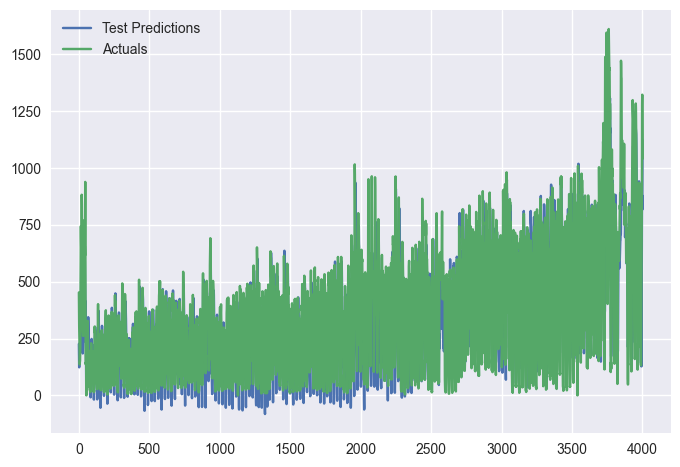

In [28]:
model = load_model('3H_Forecast/3H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(3,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D003_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D003_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 4 hours forecast

In [29]:
%%time

Trainer(4,6,12,50)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 64)                17920     
                                                                 
 dense_44 (Dense)            (None, 8)                 520       
                                                                 
 dense_45 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 12:28:26.636795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:28:26.774440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:28:27.339715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6464 - mae: 0.6384 - mse: 0.6464 - mape: 180.1881

2023-02-10 12:28:35.000982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:28:35.073472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.68585, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 16s 35ms/step - loss: 0.6464 - mae: 0.6384 - mse: 0.6464 - mape: 180.1881 - val_loss: 0.6858 - val_mae: 0.6372 - val_mse: 0.6858 - val_mape: 197.2116
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5011 - mae: 0.5363 - mse: 0.5011 - mape: 236.1574
Epoch 2: val_loss improved from 0.68585 to 0.63663, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.5011 - mae: 0.5363 - mse: 0.5011 - mape: 236.1574 - val_loss: 0.6366 - val_mae: 0.6040 - val_mse: 0.6366 - val_mape: 199.7576
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.4562 - mae: 0.5055 - mse: 0.4562 - mape: 241.8668
Epoch 3: val_loss improved from 0.63663 to 0.58070, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4562 - mae: 0.5055 - mse: 0.4562 - mape: 241.8668 - val_loss: 0.5807 - val_mae: 0.5732 - val_mse: 0.5807 - val_mape: 198.6302
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4227 - mae: 0.4815 - mse: 0.4227 - mape: 230.3006
Epoch 4: val_loss improved from 0.58070 to 0.54873, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.4227 - mae: 0.4815 - mse: 0.4227 - mape: 230.3006 - val_loss: 0.5487 - val_mae: 0.5526 - val_mse: 0.5487 - val_mape: 185.8608
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.3998 - mae: 0.4655 - mse: 0.3998 - mape: 230.3423
Epoch 5: val_loss improved from 0.54873 to 0.53705, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3998 - mae: 0.4655 - mse: 0.3998 - mape: 230.3423 - val_loss: 0.5370 - val_mae: 0.5443 - val_mse: 0.5370 - val_mape: 194.7719
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.3852 - mae: 0.4546 - mse: 0.3852 - mape: 225.9465
Epoch 6: val_loss did not improve from 0.53705
376/376 [==============================] - 6s 17ms/step - loss: 0.3852 - mae: 0.4546 - mse: 0.3852 - mape: 225.9465 - val_loss: 0.5422 - val_mae: 0.5429 - val_mse: 0.5422 - val_mape: 191.4773
Epoch 7/50
374/376 [============================>.] - ETA: 0s - loss: 0.3748 - mae: 0.4464 - mse: 0.3748 - mape: 222.1696
Epoch 7: val_loss improved from 0.53705 to 0.53124, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3755 - mae: 0.4466 - mse: 0.3755 - mape: 221.8344 - val_loss: 0.5312 - val_mae: 0.5381 - val_mse: 0.5312 - val_mape: 195.0761
Epoch 8/50
375/376 [============================>.] - ETA: 0s - loss: 0.3685 - mae: 0.4413 - mse: 0.3685 - mape: 220.6779
Epoch 8: val_loss improved from 0.53124 to 0.52865, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3683 - mae: 0.4412 - mse: 0.3683 - mape: 220.5502 - val_loss: 0.5287 - val_mae: 0.5347 - val_mse: 0.5287 - val_mape: 190.0884
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.3625 - mae: 0.4371 - mse: 0.3625 - mape: 214.6177
Epoch 9: val_loss improved from 0.52865 to 0.51874, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.3625 - mae: 0.4371 - mse: 0.3625 - mape: 214.6177 - val_loss: 0.5187 - val_mae: 0.5305 - val_mse: 0.5187 - val_mape: 190.1830
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.3581 - mae: 0.4331 - mse: 0.3581 - mape: 219.0680
Epoch 10: val_loss did not improve from 0.51874
376/376 [==============================] - 7s 19ms/step - loss: 0.3581 - mae: 0.4331 - mse: 0.3581 - mape: 219.0680 - val_loss: 0.5243 - val_mae: 0.5313 - val_mse: 0.5243 - val_mape: 190.3593
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.3542 - mae: 0.4291 - mse: 0.3542 - mape: 206.9662
Epoch 11: val_loss did not improve from 0.51874
376/376 [==============================] - 6s 17ms/step - loss: 0.3542 - mae: 0.4291 - mse: 0.3542 - mape: 206.9662 - val_loss: 0.5300 - val_mae: 0.5322 - val_mse: 0.5300 - val_mape: 179.9332
Epoch 12/50
374/376 [============================>.] - ETA: 0s - loss: 0.3507 - m

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.3471 - mae: 0.4239 - mse: 0.3471 - mape: 205.8612 - val_loss: 0.5166 - val_mae: 0.5254 - val_mse: 0.5166 - val_mape: 180.7599
Epoch 14/50
375/376 [============================>.] - ETA: 0s - loss: 0.3437 - mae: 0.4213 - mse: 0.3437 - mape: 204.0669
Epoch 14: val_loss did not improve from 0.51661
376/376 [==============================] - 7s 18ms/step - loss: 0.3442 - mae: 0.4215 - mse: 0.3442 - mape: 203.9726 - val_loss: 0.5173 - val_mae: 0.5254 - val_mse: 0.5173 - val_mape: 184.7727
Epoch 15/50
374/376 [============================>.] - ETA: 0s - loss: 0.3413 - mae: 0.4190 - mse: 0.3413 - mape: 200.7354
Epoch 15: val_loss did not improve from 0.51661
376/376 [==============================] - 6s 17ms/step - loss: 0.3413 - mae: 0.4190 - mse: 0.3413 - mape: 200.2931 - val_loss: 0.5210 - val_mae: 0.5262 - val_mse: 0.5210 - val_mape: 182.0585
Epoch 16/50
376/376 [==============================] - ETA: 0s - loss: 0.3386 - m

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3386 - mae: 0.4172 - mse: 0.3386 - mape: 203.7860 - val_loss: 0.5120 - val_mae: 0.5226 - val_mse: 0.5120 - val_mape: 194.2061
Epoch 17/50
376/376 [==============================] - ETA: 0s - loss: 0.3363 - mae: 0.4144 - mse: 0.3363 - mape: 205.0217
Epoch 17: val_loss did not improve from 0.51197
376/376 [==============================] - 7s 18ms/step - loss: 0.3363 - mae: 0.4144 - mse: 0.3363 - mape: 205.0217 - val_loss: 0.5186 - val_mae: 0.5243 - val_mse: 0.5186 - val_mape: 182.1136
Epoch 18/50
376/376 [==============================] - ETA: 0s - loss: 0.3339 - mae: 0.4143 - mse: 0.3339 - mape: 196.9137
Epoch 18: val_loss did not improve from 0.51197
376/376 [==============================] - 6s 17ms/step - loss: 0.3339 - mae: 0.4143 - mse: 0.3339 - mape: 196.9137 - val_loss: 0.5223 - val_mae: 0.5254 - val_mse: 0.5223 - val_mape: 183.7793
Epoch 19/50
375/376 [============================>.] - ETA: 0s - loss: 0.3310 - m

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3312 - mae: 0.4108 - mse: 0.3312 - mape: 197.8924 - val_loss: 0.5071 - val_mae: 0.5227 - val_mse: 0.5071 - val_mape: 194.0054
Epoch 20/50
376/376 [==============================] - ETA: 0s - loss: 0.3295 - mae: 0.4100 - mse: 0.3295 - mape: 194.8720
Epoch 20: val_loss did not improve from 0.50714
376/376 [==============================] - 7s 18ms/step - loss: 0.3295 - mae: 0.4100 - mse: 0.3295 - mape: 194.8720 - val_loss: 0.5242 - val_mae: 0.5263 - val_mse: 0.5242 - val_mape: 180.3177
Epoch 21/50
376/376 [==============================] - ETA: 0s - loss: 0.3278 - mae: 0.4085 - mse: 0.3278 - mape: 197.8487
Epoch 21: val_loss did not improve from 0.50714
376/376 [==============================] - 7s 17ms/step - loss: 0.3278 - mae: 0.4085 - mse: 0.3278 - mape: 197.8487 - val_loss: 0.5311 - val_mae: 0.5300 - val_mse: 0.5311 - val_mape: 182.8946
Epoch 22/50
375/376 [============================>.] - ETA: 0s - loss: 0.3255 - m

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3094 - mae: 0.3954 - mse: 0.3094 - mape: 193.0061 - val_loss: 0.5037 - val_mae: 0.5196 - val_mse: 0.5037 - val_mape: 190.6911
Epoch 33/50
375/376 [============================>.] - ETA: 0s - loss: 0.3085 - mae: 0.3948 - mse: 0.3085 - mape: 198.3958
Epoch 33: val_loss did not improve from 0.50368
376/376 [==============================] - 6s 17ms/step - loss: 0.3083 - mae: 0.3948 - mse: 0.3083 - mape: 198.2877 - val_loss: 0.5129 - val_mae: 0.5229 - val_mse: 0.5129 - val_mape: 185.7025
Epoch 34/50
374/376 [============================>.] - ETA: 0s - loss: 0.3070 - mae: 0.3932 - mse: 0.3070 - mape: 195.8369
Epoch 34: val_loss did not improve from 0.50368
376/376 [==============================] - 6s 17ms/step - loss: 0.3065 - mae: 0.3929 - mse: 0.3065 - mape: 195.5270 - val_loss: 0.5248 - val_mae: 0.5265 - val_mse: 0.5248 - val_mape: 183.8961
Epoch 35/50
373/376 [============================>.] - ETA: 0s - loss: 0.3049 - m

2023-02-10 12:34:47.176302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:34:47.325399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:34:47.639935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6226 - mae: 0.6200 - mse: 0.6226 - mape: 184.4706

2023-02-10 12:34:54.384928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:34:54.439314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.66547, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 15s 33ms/step - loss: 0.6226 - mae: 0.6200 - mse: 0.6226 - mape: 184.4706 - val_loss: 0.6655 - val_mae: 0.6193 - val_mse: 0.6655 - val_mape: 200.5361
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5074 - mae: 0.5385 - mse: 0.5074 - mape: 248.8876
Epoch 2: val_loss improved from 0.66547 to 0.60269, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.5074 - mae: 0.5385 - mse: 0.5074 - mape: 248.8876 - val_loss: 0.6027 - val_mae: 0.5851 - val_mse: 0.6027 - val_mape: 216.8479
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.4686 - mae: 0.5122 - mse: 0.4686 - mape: 245.1627
Epoch 3: val_loss improved from 0.60269 to 0.55797, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4686 - mae: 0.5122 - mse: 0.4686 - mape: 245.1627 - val_loss: 0.5580 - val_mae: 0.5579 - val_mse: 0.5580 - val_mape: 218.1385
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4327 - mae: 0.4849 - mse: 0.4327 - mape: 237.3836
Epoch 4: val_loss improved from 0.55797 to 0.53145, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4327 - mae: 0.4849 - mse: 0.4327 - mape: 237.3836 - val_loss: 0.5315 - val_mae: 0.5380 - val_mse: 0.5315 - val_mape: 208.7004
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4032 - mae: 0.4633 - mse: 0.4032 - mape: 231.5566
Epoch 5: val_loss improved from 0.53145 to 0.52455, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.4032 - mae: 0.4633 - mse: 0.4032 - mape: 231.5566 - val_loss: 0.5245 - val_mae: 0.5293 - val_mse: 0.5245 - val_mape: 199.6583
Epoch 6/50
374/376 [============================>.] - ETA: 0s - loss: 0.3858 - mae: 0.4505 - mse: 0.3858 - mape: 228.9340
Epoch 6: val_loss improved from 0.52455 to 0.52070, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.3852 - mae: 0.4502 - mse: 0.3852 - mape: 228.7174 - val_loss: 0.5207 - val_mae: 0.5265 - val_mse: 0.5207 - val_mape: 201.7238
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.3740 - mae: 0.4413 - mse: 0.3740 - mape: 234.7847
Epoch 7: val_loss did not improve from 0.52070
376/376 [==============================] - 7s 18ms/step - loss: 0.3740 - mae: 0.4413 - mse: 0.3740 - mape: 234.7847 - val_loss: 0.5466 - val_mae: 0.5344 - val_mse: 0.5466 - val_mape: 195.5410
Epoch 8/50
373/376 [============================>.] - ETA: 0s - loss: 0.3651 - mae: 0.4347 - mse: 0.3651 - mape: 226.0950
Epoch 8: val_loss improved from 0.52070 to 0.51803, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3651 - mae: 0.4346 - mse: 0.3651 - mape: 225.5162 - val_loss: 0.5180 - val_mae: 0.5256 - val_mse: 0.5180 - val_mape: 202.5815
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.3586 - mae: 0.4291 - mse: 0.3586 - mape: 217.2721
Epoch 9: val_loss did not improve from 0.51803
376/376 [==============================] - 7s 18ms/step - loss: 0.3586 - mae: 0.4291 - mse: 0.3586 - mape: 217.2721 - val_loss: 0.5273 - val_mae: 0.5274 - val_mse: 0.5273 - val_mape: 201.5455
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.3527 - mae: 0.4250 - mse: 0.3527 - mape: 218.4532
Epoch 10: val_loss did not improve from 0.51803
376/376 [==============================] - 7s 18ms/step - loss: 0.3527 - mae: 0.4250 - mse: 0.3527 - mape: 218.4532 - val_loss: 0.5436 - val_mae: 0.5327 - val_mse: 0.5436 - val_mape: 195.4816
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.3481 - mae

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3260 - mae: 0.4048 - mse: 0.3260 - mape: 192.0332 - val_loss: 0.5083 - val_mae: 0.5168 - val_mse: 0.5083 - val_mape: 195.0559
Epoch 18/50
375/376 [============================>.] - ETA: 0s - loss: 0.3231 - mae: 0.4028 - mse: 0.3231 - mape: 201.6193
Epoch 18: val_loss did not improve from 0.50835
376/376 [==============================] - 7s 17ms/step - loss: 0.3230 - mae: 0.4028 - mse: 0.3230 - mape: 201.7161 - val_loss: 0.5120 - val_mae: 0.5176 - val_mse: 0.5120 - val_mape: 190.7151
Epoch 19/50
375/376 [============================>.] - ETA: 0s - loss: 0.3210 - mae: 0.4008 - mse: 0.3210 - mape: 197.7057
Epoch 19: val_loss did not improve from 0.50835
376/376 [==============================] - 6s 17ms/step - loss: 0.3208 - mae: 0.4007 - mse: 0.3208 - mape: 197.6088 - val_loss: 0.5142 - val_mae: 0.5188 - val_mse: 0.5142 - val_mape: 187.2885
Epoch 20/50
375/376 [============================>.] - ETA: 0s - loss: 0.3183 - m

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.3162 - mae: 0.3980 - mse: 0.3162 - mape: 194.9639 - val_loss: 0.4961 - val_mae: 0.5132 - val_mse: 0.4961 - val_mape: 201.7532
Epoch 22/50
376/376 [==============================] - ETA: 0s - loss: 0.3140 - mae: 0.3973 - mse: 0.3140 - mape: 189.2130
Epoch 22: val_loss improved from 0.49614 to 0.49483, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.3140 - mae: 0.3973 - mse: 0.3140 - mape: 189.2130 - val_loss: 0.4948 - val_mae: 0.5132 - val_mse: 0.4948 - val_mape: 198.7532
Epoch 23/50
375/376 [============================>.] - ETA: 0s - loss: 0.3127 - mae: 0.3952 - mse: 0.3127 - mape: 185.4346
Epoch 23: val_loss did not improve from 0.49483
376/376 [==============================] - 8s 20ms/step - loss: 0.3125 - mae: 0.3951 - mse: 0.3125 - mape: 185.3762 - val_loss: 0.5092 - val_mae: 0.5150 - val_mse: 0.5092 - val_mape: 185.1353
Epoch 24/50
375/376 [============================>.] - ETA: 0s - loss: 0.3108 - mae: 0.3942 - mse: 0.3108 - mape: 193.5782
Epoch 24: val_loss did not improve from 0.49483
376/376 [==============================] - 7s 20ms/step - loss: 0.3107 - mae: 0.3941 - mse: 0.3107 - mape: 193.4818 - val_loss: 0.5133 - val_mae: 0.5176 - val_mse: 0.5133 - val_mape: 186.1960
Epoch 25/50
373/376 [============================>.] - ETA: 0s - loss: 0.3083 - m

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.2973 - mae: 0.3861 - mse: 0.2973 - mape: 172.8913 - val_loss: 0.4918 - val_mae: 0.5104 - val_mse: 0.4918 - val_mape: 191.8738
Epoch 33/50
376/376 [==============================] - ETA: 0s - loss: 0.2953 - mae: 0.3840 - mse: 0.2953 - mape: 183.1271
Epoch 33: val_loss did not improve from 0.49179
376/376 [==============================] - 7s 18ms/step - loss: 0.2953 - mae: 0.3840 - mse: 0.2953 - mape: 183.1271 - val_loss: 0.5051 - val_mae: 0.5147 - val_mse: 0.5051 - val_mape: 187.1822
Epoch 34/50
374/376 [============================>.] - ETA: 0s - loss: 0.2934 - mae: 0.3835 - mse: 0.2934 - mape: 178.2505
Epoch 34: val_loss did not improve from 0.49179
376/376 [==============================] - 7s 19ms/step - loss: 0.2933 - mae: 0.3835 - mse: 0.2933 - mape: 178.1503 - val_loss: 0.5171 - val_mae: 0.5197 - val_mse: 0.5171 - val_mape: 190.6027
Epoch 35/50
374/376 [============================>.] - ETA: 0s - loss: 0.2925 - m

2023-02-10 12:41:37.708468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:41:37.864136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:41:38.298849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6449 - mae: 0.6383 - mse: 0.6449 - mape: 216.3556

2023-02-10 12:41:45.573528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:41:45.629623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.69534, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 15s 35ms/step - loss: 0.6449 - mae: 0.6383 - mse: 0.6449 - mape: 216.3556 - val_loss: 0.6953 - val_mae: 0.6399 - val_mse: 0.6953 - val_mape: 191.2293
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5158 - mae: 0.5488 - mse: 0.5158 - mape: 251.0159
Epoch 2: val_loss improved from 0.69534 to 0.63764, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 17s 46ms/step - loss: 0.5158 - mae: 0.5488 - mse: 0.5158 - mape: 251.0159 - val_loss: 0.6376 - val_mae: 0.6078 - val_mse: 0.6376 - val_mape: 222.5969
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.4709 - mae: 0.5167 - mse: 0.4709 - mape: 259.7329
Epoch 3: val_loss improved from 0.63764 to 0.60147, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 14s 36ms/step - loss: 0.4709 - mae: 0.5167 - mse: 0.4709 - mape: 259.7329 - val_loss: 0.6015 - val_mae: 0.5845 - val_mse: 0.6015 - val_mape: 226.2524
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4352 - mae: 0.4907 - mse: 0.4352 - mape: 248.6692
Epoch 4: val_loss improved from 0.60147 to 0.57021, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.4352 - mae: 0.4907 - mse: 0.4352 - mape: 248.6692 - val_loss: 0.5702 - val_mae: 0.5633 - val_mse: 0.5702 - val_mape: 230.1947
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4109 - mae: 0.4714 - mse: 0.4109 - mape: 259.4895
Epoch 5: val_loss improved from 0.57021 to 0.55202, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 36ms/step - loss: 0.4109 - mae: 0.4714 - mse: 0.4109 - mape: 259.4895 - val_loss: 0.5520 - val_mae: 0.5500 - val_mse: 0.5520 - val_mape: 231.3488
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.3961 - mae: 0.4610 - mse: 0.3961 - mape: 260.7587
Epoch 6: val_loss improved from 0.55202 to 0.53648, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 35ms/step - loss: 0.3961 - mae: 0.4610 - mse: 0.3961 - mape: 260.7587 - val_loss: 0.5365 - val_mae: 0.5385 - val_mse: 0.5365 - val_mape: 226.6045
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.3850 - mae: 0.4520 - mse: 0.3850 - mape: 256.8652
Epoch 7: val_loss did not improve from 0.53648
376/376 [==============================] - 9s 23ms/step - loss: 0.3850 - mae: 0.4520 - mse: 0.3850 - mape: 256.8652 - val_loss: 0.5411 - val_mae: 0.5371 - val_mse: 0.5411 - val_mape: 227.7191
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.3757 - mae: 0.4434 - mse: 0.3757 - mape: 262.0145
Epoch 8: val_loss did not improve from 0.53648
376/376 [==============================] - 9s 24ms/step - loss: 0.3757 - mae: 0.4434 - mse: 0.3757 - mape: 262.0145 - val_loss: 0.5366 - val_mae: 0.5318 - val_mse: 0.5366 - val_mape: 213.3732
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.3674 - mae: 0

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 35ms/step - loss: 0.3674 - mae: 0.4378 - mse: 0.3674 - mape: 249.2175 - val_loss: 0.5230 - val_mae: 0.5246 - val_mse: 0.5230 - val_mape: 196.3751
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.3614 - mae: 0.4322 - mse: 0.3614 - mape: 238.2347
Epoch 10: val_loss improved from 0.52305 to 0.52006, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.3614 - mae: 0.4322 - mse: 0.3614 - mape: 238.2347 - val_loss: 0.5201 - val_mae: 0.5233 - val_mse: 0.5201 - val_mape: 207.0754
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.3548 - mae: 0.4273 - mse: 0.3548 - mape: 236.4882
Epoch 11: val_loss improved from 0.52006 to 0.51497, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 15s 39ms/step - loss: 0.3548 - mae: 0.4273 - mse: 0.3548 - mape: 236.4882 - val_loss: 0.5150 - val_mae: 0.5213 - val_mse: 0.5150 - val_mape: 214.9092
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.3497 - mae: 0.4226 - mse: 0.3497 - mape: 234.0677
Epoch 12: val_loss did not improve from 0.51497
376/376 [==============================] - 10s 25ms/step - loss: 0.3497 - mae: 0.4226 - mse: 0.3497 - mape: 234.0677 - val_loss: 0.5177 - val_mae: 0.5212 - val_mse: 0.5177 - val_mape: 206.8672
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.3442 - mae: 0.4188 - mse: 0.3442 - mape: 223.2781
Epoch 13: val_loss improved from 0.51497 to 0.50905, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 17s 44ms/step - loss: 0.3442 - mae: 0.4188 - mse: 0.3442 - mape: 223.2781 - val_loss: 0.5091 - val_mae: 0.5172 - val_mse: 0.5091 - val_mape: 201.0886
Epoch 14/50
376/376 [==============================] - ETA: 0s - loss: 0.3396 - mae: 0.4143 - mse: 0.3396 - mape: 222.9151
Epoch 14: val_loss did not improve from 0.50905
376/376 [==============================] - 9s 24ms/step - loss: 0.3396 - mae: 0.4143 - mse: 0.3396 - mape: 222.9151 - val_loss: 0.5119 - val_mae: 0.5173 - val_mse: 0.5119 - val_mape: 200.3392
Epoch 15/50
375/376 [============================>.] - ETA: 0s - loss: 0.3346 - mae: 0.4104 - mse: 0.3346 - mape: 216.2472
Epoch 15: val_loss improved from 0.50905 to 0.50237, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.3346 - mae: 0.4104 - mse: 0.3346 - mape: 216.1447 - val_loss: 0.5024 - val_mae: 0.5133 - val_mse: 0.5024 - val_mape: 197.5944
Epoch 16/50
375/376 [============================>.] - ETA: 0s - loss: 0.3299 - mae: 0.4075 - mse: 0.3299 - mape: 214.9305
Epoch 16: val_loss did not improve from 0.50237
376/376 [==============================] - 8s 20ms/step - loss: 0.3298 - mae: 0.4075 - mse: 0.3298 - mape: 214.9284 - val_loss: 0.5146 - val_mae: 0.5179 - val_mse: 0.5146 - val_mape: 198.3472
Epoch 17/50
375/376 [============================>.] - ETA: 0s - loss: 0.3260 - mae: 0.4036 - mse: 0.3260 - mape: 209.9957
Epoch 17: val_loss improved from 0.50237 to 0.49925, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.3258 - mae: 0.4035 - mse: 0.3258 - mape: 209.8940 - val_loss: 0.4993 - val_mae: 0.5106 - val_mse: 0.4993 - val_mape: 196.6611
Epoch 18/50
376/376 [==============================] - ETA: 0s - loss: 0.3216 - mae: 0.4007 - mse: 0.3216 - mape: 205.2659
Epoch 18: val_loss improved from 0.49925 to 0.49636, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 35ms/step - loss: 0.3216 - mae: 0.4007 - mse: 0.3216 - mape: 205.2659 - val_loss: 0.4964 - val_mae: 0.5099 - val_mse: 0.4964 - val_mape: 199.2978
Epoch 19/50
376/376 [==============================] - ETA: 0s - loss: 0.3168 - mae: 0.3968 - mse: 0.3168 - mape: 207.5814
Epoch 19: val_loss improved from 0.49636 to 0.49216, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.3168 - mae: 0.3968 - mse: 0.3168 - mape: 207.5814 - val_loss: 0.4922 - val_mae: 0.5081 - val_mse: 0.4922 - val_mape: 199.9814
Epoch 20/50
374/376 [============================>.] - ETA: 0s - loss: 0.3135 - mae: 0.3944 - mse: 0.3135 - mape: 203.3813
Epoch 20: val_loss did not improve from 0.49216
376/376 [==============================] - 8s 20ms/step - loss: 0.3130 - mae: 0.3940 - mse: 0.3130 - mape: 202.8634 - val_loss: 0.5125 - val_mae: 0.5150 - val_mse: 0.5125 - val_mape: 195.0704
Epoch 21/50
376/376 [==============================] - ETA: 0s - loss: 0.3094 - mae: 0.3911 - mse: 0.3094 - mape: 204.3030
Epoch 21: val_loss did not improve from 0.49216
376/376 [==============================] - 7s 19ms/step - loss: 0.3094 - mae: 0.3911 - mse: 0.3094 - mape: 204.3030 - val_loss: 0.4946 - val_mae: 0.5085 - val_mse: 0.4946 - val_mape: 191.8147
Epoch 22/50
376/376 [==============================] - ETA: 0s - loss: 0.3051 - m

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.3051 - mae: 0.3879 - mse: 0.3051 - mape: 197.8970 - val_loss: 0.4898 - val_mae: 0.5063 - val_mse: 0.4898 - val_mape: 195.4609
Epoch 23/50
375/376 [============================>.] - ETA: 0s - loss: 0.3020 - mae: 0.3858 - mse: 0.3020 - mape: 192.8288
Epoch 23: val_loss did not improve from 0.48982
376/376 [==============================] - 7s 18ms/step - loss: 0.3019 - mae: 0.3857 - mse: 0.3019 - mape: 192.7372 - val_loss: 0.4961 - val_mae: 0.5076 - val_mse: 0.4961 - val_mape: 189.8532
Epoch 24/50
376/376 [==============================] - ETA: 0s - loss: 0.2984 - mae: 0.3835 - mse: 0.2984 - mape: 197.0530
Epoch 24: val_loss improved from 0.48982 to 0.48493, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 13s 35ms/step - loss: 0.2984 - mae: 0.3835 - mse: 0.2984 - mape: 197.0530 - val_loss: 0.4849 - val_mae: 0.5047 - val_mse: 0.4849 - val_mape: 198.4101
Epoch 25/50
376/376 [==============================] - ETA: 0s - loss: 0.2952 - mae: 0.3813 - mse: 0.2952 - mape: 207.4600
Epoch 25: val_loss did not improve from 0.48493
376/376 [==============================] - 12s 31ms/step - loss: 0.2952 - mae: 0.3813 - mse: 0.2952 - mape: 207.4600 - val_loss: 0.5028 - val_mae: 0.5111 - val_mse: 0.5028 - val_mape: 199.1393
Epoch 26/50
376/376 [==============================] - ETA: 0s - loss: 0.2930 - mae: 0.3804 - mse: 0.2930 - mape: 199.4967
Epoch 26: val_loss did not improve from 0.48493
376/376 [==============================] - 8s 22ms/step - loss: 0.2930 - mae: 0.3804 - mse: 0.2930 - mape: 199.4967 - val_loss: 0.4894 - val_mae: 0.5067 - val_mse: 0.4894 - val_mape: 194.3772
Epoch 27/50
374/376 [============================>.] - ETA: 0s - loss: 0.2899 - 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.2873 - mae: 0.3764 - mse: 0.2873 - mape: 200.8725 - val_loss: 0.4833 - val_mae: 0.5056 - val_mse: 0.4833 - val_mape: 194.5670
Epoch 29/50
375/376 [============================>.] - ETA: 0s - loss: 0.2846 - mae: 0.3748 - mse: 0.2846 - mape: 216.3732
Epoch 29: val_loss improved from 0.48329 to 0.48263, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 14s 37ms/step - loss: 0.2845 - mae: 0.3748 - mse: 0.2845 - mape: 216.3038 - val_loss: 0.4826 - val_mae: 0.5056 - val_mse: 0.4826 - val_mape: 198.0323
Epoch 30/50
376/376 [==============================] - ETA: 0s - loss: 0.2821 - mae: 0.3733 - mse: 0.2821 - mape: 213.0229
Epoch 30: val_loss did not improve from 0.48263
376/376 [==============================] - 8s 22ms/step - loss: 0.2821 - mae: 0.3733 - mse: 0.2821 - mape: 213.0229 - val_loss: 0.5053 - val_mae: 0.5137 - val_mse: 0.5053 - val_mape: 197.5871
Epoch 31/50
375/376 [============================>.] - ETA: 0s - loss: 0.2808 - mae: 0.3723 - mse: 0.2808 - mape: 205.0030
Epoch 31: val_loss did not improve from 0.48263
376/376 [==============================] - 10s 27ms/step - loss: 0.2807 - mae: 0.3724 - mse: 0.2807 - mape: 204.9616 - val_loss: 0.5098 - val_mae: 0.5152 - val_mse: 0.5098 - val_mape: 196.1352
Epoch 32/50
374/376 [============================>.] - ETA: 0s - loss: 0.2777 - 

                                                                 
 dense_50 (Dense)            (None, 8)                 520       
                                                                 
 dense_51 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 12:49:42.405371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:49:42.596384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:49:43.125813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6356 - mae: 0.6274 - mse: 0.6356 - mape: 187.7357

2023-02-10 12:49:50.017613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:49:50.076436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.70471, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 14s 33ms/step - loss: 0.6356 - mae: 0.6274 - mse: 0.6356 - mape: 187.7357 - val_loss: 0.7047 - val_mae: 0.6374 - val_mse: 0.7047 - val_mape: 209.9684
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5197 - mae: 0.5459 - mse: 0.5197 - mape: 258.9853
Epoch 2: val_loss improved from 0.70471 to 0.67100, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.5197 - mae: 0.5459 - mse: 0.5197 - mape: 258.9853 - val_loss: 0.6710 - val_mae: 0.6143 - val_mse: 0.6710 - val_mape: 219.1298
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.4785 - mae: 0.5155 - mse: 0.4785 - mape: 259.9389
Epoch 3: val_loss improved from 0.67100 to 0.62113, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.4785 - mae: 0.5155 - mse: 0.4785 - mape: 259.9389 - val_loss: 0.6211 - val_mae: 0.5854 - val_mse: 0.6211 - val_mape: 225.0235
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4459 - mae: 0.4916 - mse: 0.4459 - mape: 259.5189
Epoch 4: val_loss improved from 0.62113 to 0.58746, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4459 - mae: 0.4916 - mse: 0.4459 - mape: 259.5189 - val_loss: 0.5875 - val_mae: 0.5655 - val_mse: 0.5875 - val_mape: 227.7112
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4221 - mae: 0.4723 - mse: 0.4221 - mape: 261.7838
Epoch 5: val_loss improved from 0.58746 to 0.58136, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.4221 - mae: 0.4723 - mse: 0.4221 - mape: 261.7838 - val_loss: 0.5814 - val_mae: 0.5592 - val_mse: 0.5814 - val_mape: 225.8603
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.4034 - mae: 0.4595 - mse: 0.4034 - mape: 264.1852
Epoch 6: val_loss improved from 0.58136 to 0.55872, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.4034 - mae: 0.4595 - mse: 0.4034 - mape: 264.1852 - val_loss: 0.5587 - val_mae: 0.5462 - val_mse: 0.5587 - val_mape: 219.7829
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.3873 - mae: 0.4491 - mse: 0.3873 - mape: 259.2382
Epoch 7: val_loss improved from 0.55872 to 0.55048, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3873 - mae: 0.4491 - mse: 0.3873 - mape: 259.2382 - val_loss: 0.5505 - val_mae: 0.5404 - val_mse: 0.5505 - val_mape: 218.0585
Epoch 8/50
375/376 [============================>.] - ETA: 0s - loss: 0.3736 - mae: 0.4402 - mse: 0.3736 - mape: 247.2380
Epoch 8: val_loss did not improve from 0.55048
376/376 [==============================] - 7s 17ms/step - loss: 0.3736 - mae: 0.4402 - mse: 0.3736 - mape: 247.1736 - val_loss: 0.5517 - val_mae: 0.5404 - val_mse: 0.5517 - val_mape: 226.7051
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.3616 - mae: 0.4316 - mse: 0.3616 - mape: 236.5576
Epoch 9: val_loss improved from 0.55048 to 0.54416, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.3616 - mae: 0.4316 - mse: 0.3616 - mape: 236.5576 - val_loss: 0.5442 - val_mae: 0.5343 - val_mse: 0.5442 - val_mape: 204.9962
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.3490 - mae: 0.4242 - mse: 0.3490 - mape: 226.1532
Epoch 10: val_loss improved from 0.54416 to 0.53677, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.3490 - mae: 0.4242 - mse: 0.3490 - mape: 226.1532 - val_loss: 0.5368 - val_mae: 0.5297 - val_mse: 0.5368 - val_mape: 210.8158
Epoch 11/50
375/376 [============================>.] - ETA: 0s - loss: 0.3388 - mae: 0.4159 - mse: 0.3388 - mape: 210.7829
Epoch 11: val_loss improved from 0.53677 to 0.52193, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.3388 - mae: 0.4159 - mse: 0.3388 - mape: 210.7035 - val_loss: 0.5219 - val_mae: 0.5228 - val_mse: 0.5219 - val_mape: 204.3278
Epoch 12/50
375/376 [============================>.] - ETA: 0s - loss: 0.3303 - mae: 0.4095 - mse: 0.3303 - mape: 206.6329
Epoch 12: val_loss improved from 0.52193 to 0.50971, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3302 - mae: 0.4094 - mse: 0.3302 - mape: 206.6638 - val_loss: 0.5097 - val_mae: 0.5160 - val_mse: 0.5097 - val_mape: 200.0503
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.3230 - mae: 0.4034 - mse: 0.3230 - mape: 196.4993
Epoch 13: val_loss did not improve from 0.50971
376/376 [==============================] - 6s 17ms/step - loss: 0.3230 - mae: 0.4034 - mse: 0.3230 - mape: 196.4993 - val_loss: 0.5335 - val_mae: 0.5240 - val_mse: 0.5335 - val_mape: 194.5724
Epoch 14/50
374/376 [============================>.] - ETA: 0s - loss: 0.3175 - mae: 0.3995 - mse: 0.3175 - mape: 195.4847
Epoch 14: val_loss improved from 0.50971 to 0.50704, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3173 - mae: 0.3996 - mse: 0.3173 - mape: 195.4054 - val_loss: 0.5070 - val_mae: 0.5133 - val_mse: 0.5070 - val_mape: 199.2612
Epoch 15/50
375/376 [============================>.] - ETA: 0s - loss: 0.3123 - mae: 0.3952 - mse: 0.3123 - mape: 197.9770
Epoch 15: val_loss improved from 0.50704 to 0.49950, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3123 - mae: 0.3952 - mse: 0.3123 - mape: 197.9179 - val_loss: 0.4995 - val_mae: 0.5109 - val_mse: 0.4995 - val_mape: 196.0562
Epoch 16/50
376/376 [==============================] - ETA: 0s - loss: 0.3078 - mae: 0.3913 - mse: 0.3078 - mape: 205.5162
Epoch 16: val_loss did not improve from 0.49950
376/376 [==============================] - 9s 24ms/step - loss: 0.3078 - mae: 0.3913 - mse: 0.3078 - mape: 205.5162 - val_loss: 0.5013 - val_mae: 0.5111 - val_mse: 0.5013 - val_mape: 192.4548
Epoch 17/50
375/376 [============================>.] - ETA: 0s - loss: 0.3046 - mae: 0.3898 - mse: 0.3046 - mape: 210.9040
Epoch 17: val_loss did not improve from 0.49950
376/376 [==============================] - 8s 21ms/step - loss: 0.3046 - mae: 0.3899 - mse: 0.3046 - mape: 210.8819 - val_loss: 0.5034 - val_mae: 0.5126 - val_mse: 0.5034 - val_mape: 196.0570
Epoch 18/50
376/376 [==============================] - ETA: 0s - loss: 0.3012 - m

374/376 [============================>.] - ETA: 0s - loss: 0.2587 - mae: 0.3577 - mse: 0.2587 - mape: 202.5252
Epoch 38: val_loss did not improve from 0.49950
376/376 [==============================] - 8s 20ms/step - loss: 0.2586 - mae: 0.3576 - mse: 0.2586 - mape: 202.0868 - val_loss: 0.5403 - val_mae: 0.5314 - val_mse: 0.5403 - val_mape: 199.3692
Epoch 39/50
375/376 [============================>.] - ETA: 0s - loss: 0.2568 - mae: 0.3566 - mse: 0.2568 - mape: 194.7313
Epoch 39: val_loss did not improve from 0.49950
376/376 [==============================] - 7s 18ms/step - loss: 0.2568 - mae: 0.3566 - mse: 0.2568 - mape: 194.7565 - val_loss: 0.5797 - val_mae: 0.5444 - val_mse: 0.5797 - val_mape: 202.2154
Epoch 40/50
375/376 [============================>.] - ETA: 0s - loss: 0.2552 - mae: 0.3552 - mse: 0.2552 - mape: 200.4803
Epoch 40: val_loss did not improve from 0.49950
376/376 [==============================] - 7s 18ms/step - loss: 0.2551 - mae: 0.3551 - mse: 0.2551 - mape: 200.4030

2023-02-10 12:56:20.981985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:56:21.131855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:56:21.574522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6988 - mae: 0.6605 - mse: 0.6988 - mape: 224.7604

2023-02-10 12:56:29.966344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:56:30.028000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.74696, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 16s 38ms/step - loss: 0.6988 - mae: 0.6605 - mse: 0.6988 - mape: 224.7604 - val_loss: 0.7470 - val_mae: 0.6572 - val_mse: 0.7470 - val_mape: 223.8762
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5271 - mae: 0.5540 - mse: 0.5271 - mape: 264.5715
Epoch 2: val_loss improved from 0.74696 to 0.64568, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.5271 - mae: 0.5540 - mse: 0.5271 - mape: 264.5715 - val_loss: 0.6457 - val_mae: 0.6116 - val_mse: 0.6457 - val_mape: 232.3294
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.4806 - mae: 0.5221 - mse: 0.4806 - mape: 273.1559
Epoch 3: val_loss improved from 0.64568 to 0.62263, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4806 - mae: 0.5221 - mse: 0.4806 - mape: 273.1559 - val_loss: 0.6226 - val_mae: 0.5944 - val_mse: 0.6226 - val_mape: 229.4331
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4438 - mae: 0.4948 - mse: 0.4438 - mape: 263.3504
Epoch 4: val_loss improved from 0.62263 to 0.57719, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4438 - mae: 0.4948 - mse: 0.4438 - mape: 263.3504 - val_loss: 0.5772 - val_mae: 0.5691 - val_mse: 0.5772 - val_mape: 229.8227
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4154 - mae: 0.4726 - mse: 0.4154 - mape: 268.1732
Epoch 5: val_loss did not improve from 0.57719
376/376 [==============================] - 6s 16ms/step - loss: 0.4154 - mae: 0.4726 - mse: 0.4154 - mape: 268.1732 - val_loss: 0.5911 - val_mae: 0.5675 - val_mse: 0.5911 - val_mape: 224.6657
Epoch 6/50
374/376 [============================>.] - ETA: 0s - loss: 0.3949 - mae: 0.4568 - mse: 0.3949 - mape: 265.7359
Epoch 6: val_loss did not improve from 0.57719
376/376 [==============================] - 7s 18ms/step - loss: 0.3948 - mae: 0.4568 - mse: 0.3948 - mape: 265.2392 - val_loss: 0.5911 - val_mae: 0.5612 - val_mse: 0.5911 - val_mape: 202.0515
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.3780 - mae: 0

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.3780 - mae: 0.4453 - mse: 0.3780 - mape: 264.3318 - val_loss: 0.5761 - val_mae: 0.5518 - val_mse: 0.5761 - val_mape: 202.1477
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.3633 - mae: 0.4347 - mse: 0.3633 - mape: 247.8760
Epoch 8: val_loss improved from 0.57609 to 0.55100, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.3633 - mae: 0.4347 - mse: 0.3633 - mape: 247.8760 - val_loss: 0.5510 - val_mae: 0.5389 - val_mse: 0.5510 - val_mape: 196.2430
Epoch 9/50
374/376 [============================>.] - ETA: 0s - loss: 0.3496 - mae: 0.4261 - mse: 0.3496 - mape: 232.7554
Epoch 9: val_loss improved from 0.55100 to 0.54996, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3494 - mae: 0.4261 - mse: 0.3494 - mape: 232.4105 - val_loss: 0.5500 - val_mae: 0.5377 - val_mse: 0.5500 - val_mape: 203.8393
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.3372 - mae: 0.4167 - mse: 0.3372 - mape: 220.4433
Epoch 10: val_loss improved from 0.54996 to 0.54817, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3372 - mae: 0.4167 - mse: 0.3372 - mape: 220.4433 - val_loss: 0.5482 - val_mae: 0.5319 - val_mse: 0.5482 - val_mape: 188.3853
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.3268 - mae: 0.4101 - mse: 0.3268 - mape: 215.3887
Epoch 11: val_loss improved from 0.54817 to 0.53329, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3268 - mae: 0.4101 - mse: 0.3268 - mape: 215.3887 - val_loss: 0.5333 - val_mae: 0.5274 - val_mse: 0.5333 - val_mape: 202.1861
Epoch 12/50
373/376 [============================>.] - ETA: 0s - loss: 0.3179 - mae: 0.4036 - mse: 0.3179 - mape: 212.0990
Epoch 12: val_loss did not improve from 0.53329
376/376 [==============================] - 7s 18ms/step - loss: 0.3176 - mae: 0.4035 - mse: 0.3176 - mape: 211.4283 - val_loss: 0.5482 - val_mae: 0.5269 - val_mse: 0.5482 - val_mape: 182.1565
Epoch 13/50
374/376 [============================>.] - ETA: 0s - loss: 0.3111 - mae: 0.3985 - mse: 0.3111 - mape: 200.2533
Epoch 13: val_loss improved from 0.53329 to 0.51648, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.3109 - mae: 0.3985 - mse: 0.3109 - mape: 200.0402 - val_loss: 0.5165 - val_mae: 0.5195 - val_mse: 0.5165 - val_mape: 201.5362
Epoch 14/50
373/376 [============================>.] - ETA: 0s - loss: 0.3055 - mae: 0.3936 - mse: 0.3055 - mape: 210.8395
Epoch 14: val_loss did not improve from 0.51648
376/376 [==============================] - 6s 17ms/step - loss: 0.3051 - mae: 0.3934 - mse: 0.3051 - mape: 210.0108 - val_loss: 0.5339 - val_mae: 0.5235 - val_mse: 0.5339 - val_mape: 189.7505
Epoch 15/50
376/376 [==============================] - ETA: 0s - loss: 0.2997 - mae: 0.3896 - mse: 0.2997 - mape: 202.5092
Epoch 15: val_loss did not improve from 0.51648
376/376 [==============================] - 6s 17ms/step - loss: 0.2997 - mae: 0.3896 - mse: 0.2997 - mape: 202.5092 - val_loss: 0.5317 - val_mae: 0.5199 - val_mse: 0.5317 - val_mape: 182.1762
Epoch 16/50
376/376 [==============================] - ETA: 0s - loss: 0.2947 - m

375/376 [============================>.] - ETA: 0s - loss: 0.2415 - mae: 0.3486 - mse: 0.2415 - mape: 189.8377
Epoch 36: val_loss did not improve from 0.51648
376/376 [==============================] - 7s 19ms/step - loss: 0.2416 - mae: 0.3486 - mse: 0.2416 - mape: 189.8480 - val_loss: 0.5888 - val_mae: 0.5428 - val_mse: 0.5888 - val_mape: 201.5946
Epoch 37/50
376/376 [==============================] - ETA: 0s - loss: 0.2394 - mae: 0.3472 - mse: 0.2394 - mape: 182.7017
Epoch 37: val_loss did not improve from 0.51648
376/376 [==============================] - 9s 23ms/step - loss: 0.2394 - mae: 0.3472 - mse: 0.2394 - mape: 182.7017 - val_loss: 0.6037 - val_mae: 0.5490 - val_mse: 0.6037 - val_mape: 200.5028
Epoch 38/50
376/376 [==============================] - ETA: 0s - loss: 0.2377 - mae: 0.3456 - mse: 0.2377 - mape: 187.2897
Epoch 38: val_loss did not improve from 0.51648
376/376 [==============================] - 8s 21ms/step - loss: 0.2377 - mae: 0.3456 - mse: 0.2377 - mape: 187.2897

2023-02-10 13:02:40.012549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:02:40.144524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:02:40.546938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6820 - mae: 0.6498 - mse: 0.6820 - mape: 195.1045

2023-02-10 13:02:47.821223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:02:47.888839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.69205, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 15s 34ms/step - loss: 0.6820 - mae: 0.6498 - mse: 0.6820 - mape: 195.1045 - val_loss: 0.6921 - val_mae: 0.6271 - val_mse: 0.6921 - val_mape: 222.8974
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5019 - mae: 0.5354 - mse: 0.5019 - mape: 250.6547
Epoch 2: val_loss improved from 0.69205 to 0.60111, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 13s 34ms/step - loss: 0.5019 - mae: 0.5354 - mse: 0.5019 - mape: 250.6547 - val_loss: 0.6011 - val_mae: 0.5794 - val_mse: 0.6011 - val_mape: 220.5583
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.4541 - mae: 0.4995 - mse: 0.4541 - mape: 250.6084
Epoch 3: val_loss improved from 0.60111 to 0.55890, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4541 - mae: 0.4995 - mse: 0.4541 - mape: 250.6084 - val_loss: 0.5589 - val_mae: 0.5534 - val_mse: 0.5589 - val_mape: 218.0654
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4200 - mae: 0.4742 - mse: 0.4200 - mape: 246.5834
Epoch 4: val_loss improved from 0.55890 to 0.54754, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4200 - mae: 0.4742 - mse: 0.4200 - mape: 246.5834 - val_loss: 0.5475 - val_mae: 0.5424 - val_mse: 0.5475 - val_mape: 210.1813
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.3938 - mae: 0.4550 - mse: 0.3938 - mape: 232.5850
Epoch 5: val_loss improved from 0.54754 to 0.53056, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.3938 - mae: 0.4550 - mse: 0.3938 - mape: 232.5850 - val_loss: 0.5306 - val_mae: 0.5334 - val_mse: 0.5306 - val_mape: 208.0593
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.3746 - mae: 0.4416 - mse: 0.3746 - mape: 232.9296
Epoch 6: val_loss improved from 0.53056 to 0.51751, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3746 - mae: 0.4416 - mse: 0.3746 - mape: 232.9296 - val_loss: 0.5175 - val_mae: 0.5231 - val_mse: 0.5175 - val_mape: 198.9375
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.3597 - mae: 0.4321 - mse: 0.3597 - mape: 228.2444
Epoch 7: val_loss did not improve from 0.51751
376/376 [==============================] - 8s 21ms/step - loss: 0.3597 - mae: 0.4321 - mse: 0.3597 - mape: 228.2444 - val_loss: 0.5428 - val_mae: 0.5319 - val_mse: 0.5428 - val_mape: 199.1614
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.3458 - mae: 0.4224 - mse: 0.3458 - mape: 213.4921
Epoch 8: val_loss did not improve from 0.51751
376/376 [==============================] - 7s 19ms/step - loss: 0.3458 - mae: 0.4224 - mse: 0.3458 - mape: 213.4921 - val_loss: 0.5336 - val_mae: 0.5265 - val_mse: 0.5336 - val_mape: 193.5709
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.3346 - mae: 0

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.3346 - mae: 0.4151 - mse: 0.3346 - mape: 208.5384 - val_loss: 0.5148 - val_mae: 0.5195 - val_mse: 0.5148 - val_mape: 193.1964
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.3256 - mae: 0.4080 - mse: 0.3256 - mape: 203.0503
Epoch 10: val_loss improved from 0.51479 to 0.50421, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.3256 - mae: 0.4080 - mse: 0.3256 - mape: 203.0503 - val_loss: 0.5042 - val_mae: 0.5149 - val_mse: 0.5042 - val_mape: 186.3906
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.3181 - mae: 0.4025 - mse: 0.3181 - mape: 204.8495
Epoch 11: val_loss did not improve from 0.50421
376/376 [==============================] - 7s 19ms/step - loss: 0.3181 - mae: 0.4025 - mse: 0.3181 - mape: 204.8495 - val_loss: 0.5148 - val_mae: 0.5142 - val_mse: 0.5148 - val_mape: 185.6193
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.3117 - mae: 0.3975 - mse: 0.3117 - mape: 208.3786
Epoch 12: val_loss did not improve from 0.50421
376/376 [==============================] - 9s 24ms/step - loss: 0.3117 - mae: 0.3975 - mse: 0.3117 - mape: 208.3786 - val_loss: 0.5413 - val_mae: 0.5268 - val_mse: 0.5413 - val_mape: 176.1693
Epoch 13/50
373/376 [============================>.] - ETA: 0s - loss: 0.3069 - m

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.2932 - mae: 0.3834 - mse: 0.2932 - mape: 191.2551 - val_loss: 0.4984 - val_mae: 0.5110 - val_mse: 0.4984 - val_mape: 187.2009
Epoch 17/50
376/376 [==============================] - ETA: 0s - loss: 0.2896 - mae: 0.3805 - mse: 0.2896 - mape: 192.5082
Epoch 17: val_loss did not improve from 0.49841
376/376 [==============================] - 7s 19ms/step - loss: 0.2896 - mae: 0.3805 - mse: 0.2896 - mape: 192.5082 - val_loss: 0.5056 - val_mae: 0.5085 - val_mse: 0.5056 - val_mape: 183.1951
Epoch 18/50
376/376 [==============================] - ETA: 0s - loss: 0.2857 - mae: 0.3782 - mse: 0.2857 - mape: 182.8045
Epoch 18: val_loss did not improve from 0.49841
376/376 [==============================] - 8s 22ms/step - loss: 0.2857 - mae: 0.3782 - mse: 0.2857 - mape: 182.8045 - val_loss: 0.5233 - val_mae: 0.5161 - val_mse: 0.5233 - val_mape: 180.1539
Epoch 19/50
375/376 [============================>.] - ETA: 0s - loss: 0.2820 - m

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.2822 - mae: 0.3751 - mse: 0.2822 - mape: 179.0754 - val_loss: 0.4966 - val_mae: 0.5084 - val_mse: 0.4966 - val_mape: 183.7237
Epoch 20/50
373/376 [============================>.] - ETA: 0s - loss: 0.2789 - mae: 0.3728 - mse: 0.2789 - mape: 168.0926
Epoch 20: val_loss did not improve from 0.49658
376/376 [==============================] - 6s 16ms/step - loss: 0.2794 - mae: 0.3732 - mse: 0.2794 - mape: 167.9072 - val_loss: 0.5164 - val_mae: 0.5191 - val_mse: 0.5164 - val_mape: 179.3531
Epoch 21/50
374/376 [============================>.] - ETA: 0s - loss: 0.2754 - mae: 0.3704 - mse: 0.2754 - mape: 178.8309
Epoch 21: val_loss did not improve from 0.49658
376/376 [==============================] - 6s 16ms/step - loss: 0.2759 - mae: 0.3706 - mse: 0.2759 - mape: 178.4985 - val_loss: 0.5116 - val_mae: 0.5137 - val_mse: 0.5116 - val_mape: 177.9013
Epoch 22/50
374/376 [============================>.] - ETA: 0s - loss: 0.2726 - m

374/376 [============================>.] - ETA: 0s - loss: 0.2263 - mae: 0.3328 - mse: 0.2263 - mape: 187.6364
Epoch 42: val_loss did not improve from 0.49658
376/376 [==============================] - 6s 16ms/step - loss: 0.2260 - mae: 0.3326 - mse: 0.2260 - mape: 187.1932 - val_loss: 0.6105 - val_mae: 0.5571 - val_mse: 0.6105 - val_mape: 184.3155
Epoch 43/50
375/376 [============================>.] - ETA: 0s - loss: 0.2239 - mae: 0.3317 - mse: 0.2239 - mape: 180.7779
Epoch 43: val_loss did not improve from 0.49658
376/376 [==============================] - 6s 15ms/step - loss: 0.2238 - mae: 0.3317 - mse: 0.2238 - mape: 180.7207 - val_loss: 0.6072 - val_mae: 0.5563 - val_mse: 0.6072 - val_mape: 188.5090
Epoch 44/50
376/376 [==============================] - ETA: 0s - loss: 0.2220 - mae: 0.3291 - mse: 0.2220 - mape: 191.8417
Epoch 44: val_loss did not improve from 0.49658
376/376 [==============================] - 6s 17ms/step - loss: 0.2220 - mae: 0.3291 - mse: 0.2220 - mape: 191.8417

2023-02-10 13:08:59.013749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:08:59.137789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:08:59.495932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6263 - mae: 0.6183 - mse: 0.6263 - mape: 211.0732

2023-02-10 13:09:06.187100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:09:06.243216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.63078, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 14s 32ms/step - loss: 0.6263 - mae: 0.6183 - mse: 0.6263 - mape: 211.0732 - val_loss: 0.6308 - val_mae: 0.6020 - val_mse: 0.6308 - val_mape: 223.7181
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.4768 - mae: 0.5197 - mse: 0.4768 - mape: 265.2621
Epoch 2: val_loss improved from 0.63078 to 0.59542, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4768 - mae: 0.5197 - mse: 0.4768 - mape: 265.2621 - val_loss: 0.5954 - val_mae: 0.5742 - val_mse: 0.5954 - val_mape: 215.7122
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.4344 - mae: 0.4867 - mse: 0.4344 - mape: 279.5508
Epoch 3: val_loss improved from 0.59542 to 0.56830, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.4344 - mae: 0.4867 - mse: 0.4344 - mape: 279.5508 - val_loss: 0.5683 - val_mae: 0.5530 - val_mse: 0.5683 - val_mape: 210.2841
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4068 - mae: 0.4645 - mse: 0.4068 - mape: 279.2302
Epoch 4: val_loss improved from 0.56830 to 0.55932, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4068 - mae: 0.4645 - mse: 0.4068 - mape: 279.2302 - val_loss: 0.5593 - val_mae: 0.5433 - val_mse: 0.5593 - val_mape: 201.5133
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.3863 - mae: 0.4490 - mse: 0.3863 - mape: 275.1674
Epoch 5: val_loss improved from 0.55932 to 0.55377, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3863 - mae: 0.4490 - mse: 0.3863 - mape: 275.1674 - val_loss: 0.5538 - val_mae: 0.5387 - val_mse: 0.5538 - val_mape: 194.8060
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.3689 - mae: 0.4375 - mse: 0.3689 - mape: 254.5285
Epoch 6: val_loss improved from 0.55377 to 0.54508, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.3689 - mae: 0.4375 - mse: 0.3689 - mape: 254.5285 - val_loss: 0.5451 - val_mae: 0.5311 - val_mse: 0.5451 - val_mape: 202.6595
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.3538 - mae: 0.4265 - mse: 0.3538 - mape: 245.8195
Epoch 7: val_loss improved from 0.54508 to 0.54412, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 15s 39ms/step - loss: 0.3538 - mae: 0.4265 - mse: 0.3538 - mape: 245.8195 - val_loss: 0.5441 - val_mae: 0.5280 - val_mse: 0.5441 - val_mape: 188.8590
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.3417 - mae: 0.4189 - mse: 0.3417 - mape: 236.4561
Epoch 8: val_loss improved from 0.54412 to 0.53996, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 13s 35ms/step - loss: 0.3417 - mae: 0.4189 - mse: 0.3417 - mape: 236.4561 - val_loss: 0.5400 - val_mae: 0.5243 - val_mse: 0.5400 - val_mape: 191.5455
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.3312 - mae: 0.4123 - mse: 0.3312 - mape: 230.1165
Epoch 9: val_loss improved from 0.53996 to 0.52126, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.3312 - mae: 0.4123 - mse: 0.3312 - mape: 230.1165 - val_loss: 0.5213 - val_mae: 0.5198 - val_mse: 0.5213 - val_mape: 199.6100
Epoch 10/50
374/376 [============================>.] - ETA: 0s - loss: 0.3232 - mae: 0.4061 - mse: 0.3232 - mape: 221.8987
Epoch 10: val_loss did not improve from 0.52126
376/376 [==============================] - 6s 17ms/step - loss: 0.3231 - mae: 0.4059 - mse: 0.3231 - mape: 221.4131 - val_loss: 0.5325 - val_mae: 0.5211 - val_mse: 0.5325 - val_mape: 179.6902
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.3154 - mae: 0.4003 - mse: 0.3154 - mape: 216.5831
Epoch 11: val_loss did not improve from 0.52126
376/376 [==============================] - 9s 23ms/step - loss: 0.3154 - mae: 0.4003 - mse: 0.3154 - mape: 216.5831 - val_loss: 0.5432 - val_mae: 0.5222 - val_mse: 0.5432 - val_mape: 185.3185
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.3082 - m

375/376 [============================>.] - ETA: 0s - loss: 0.2356 - mae: 0.3401 - mse: 0.2356 - mape: 190.2168
Epoch 32: val_loss did not improve from 0.52126
376/376 [==============================] - 6s 15ms/step - loss: 0.2355 - mae: 0.3400 - mse: 0.2355 - mape: 190.1687 - val_loss: 0.6211 - val_mae: 0.5418 - val_mse: 0.6211 - val_mape: 185.5120
Epoch 33/50
375/376 [============================>.] - ETA: 0s - loss: 0.2321 - mae: 0.3373 - mse: 0.2321 - mape: 195.0339
Epoch 33: val_loss did not improve from 0.52126
376/376 [==============================] - 6s 16ms/step - loss: 0.2321 - mae: 0.3373 - mse: 0.2321 - mape: 194.9726 - val_loss: 0.6176 - val_mae: 0.5414 - val_mse: 0.6176 - val_mape: 192.0616
Epoch 34/50
373/376 [============================>.] - ETA: 0s - loss: 0.2294 - mae: 0.3357 - mse: 0.2294 - mape: 201.9824
Epoch 34: val_loss did not improve from 0.52126
376/376 [==============================] - 6s 16ms/step - loss: 0.2299 - mae: 0.3361 - mse: 0.2299 - mape: 201.6516

In [30]:
%%time

modelsEvaluator(4,6,12)

(12009, 6, 5) (12009,) (4003, 6, 5) (4003,) (4003, 6, 5) (4003,)
Loading: 4H_Forecast/4H_ForecastModel_6_SizeWindow/


2023-02-10 13:15:12.895788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:15:12.966928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  5/126 [>.............................] - ETA: 1s 

2023-02-10 13:15:14.712539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:15:14.742840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12008, 7, 5) (12008,) (4003, 7, 5) (4003,) (4003, 7, 5) (4003,)
Loading: 4H_Forecast/4H_ForecastModel_7_SizeWindow/


2023-02-10 13:15:18.959010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:15:19.027566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 41s

2023-02-10 13:15:20.764919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:15:20.799492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12007, 8, 5) (12007,) (4003, 8, 5) (4003,) (4003, 8, 5) (4003,)
Loading: 4H_Forecast/4H_ForecastModel_8_SizeWindow/


2023-02-10 13:15:24.881188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:15:24.932698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 38s

2023-02-10 13:15:26.650346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:15:26.688305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12006, 9, 5) (12006,) (4003, 9, 5) (4003,) (4003, 9, 5) (4003,)
Loading: 4H_Forecast/4H_ForecastModel_9_SizeWindow/


2023-02-10 13:15:31.187264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:15:31.254034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 35s

2023-02-10 13:15:33.057701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:15:33.092087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12006, 10, 5) (12006,) (4002, 10, 5) (4002,) (4003, 10, 5) (4003,)
Loading: 4H_Forecast/4H_ForecastModel_10_SizeWindow/


2023-02-10 13:15:37.200968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:15:37.251002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 40s

2023-02-10 13:15:39.123275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:15:39.159273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12006, 11, 5) (12006,) (4002, 11, 5) (4002,) (4002, 11, 5) (4002,)
Loading: 4H_Forecast/4H_ForecastModel_11_SizeWindow/


2023-02-10 13:15:43.153035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:15:43.206920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 41s

2023-02-10 13:15:45.109193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:15:45.158896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12005, 12, 5) (12005,) (4002, 12, 5) (4002,) (4002, 12, 5) (4002,)
Loading: 4H_Forecast/4H_ForecastModel_12_SizeWindow/


2023-02-10 13:15:49.573658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:15:49.634725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 50s

2023-02-10 13:28:30.184102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:28:30.225892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 6ms/step
CPU times: user 38.2 s, sys: 6.32 s, total: 44.5 s
Wall time: 13min 22s


2023-02-10 13:28:37.011305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:28:37.046872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 6ms/step


,Test Predictions,Actuals
0,221.849396,452.508000
1,163.051010,354.636000
2,136.293594,308.158333
3,133.248398,252.036667
4,159.408432,234.740000
5,171.670456,188.511667
6,187.488251,136.190000
7,195.526978,150.125000
8,217.069397,151.265000
9,221.745651,179.690000


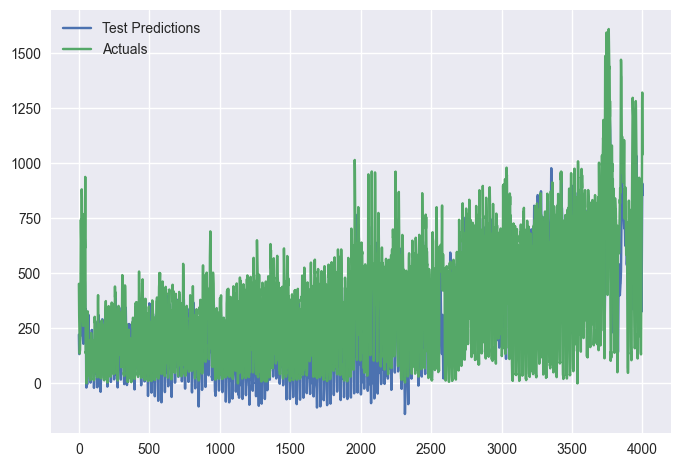

In [31]:
model = load_model('4H_Forecast/4H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(4,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D003_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D003_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 5 hours forecast

In [32]:
%%time

Trainer(5,6,12,50)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 64)                17920     
                                                                 
 dense_58 (Dense)            (None, 8)                 520       
                                                                 
 dense_59 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 13:28:39.179509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:28:39.294484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:28:39.663375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6531 - mae: 0.6450 - mse: 0.6531 - mape: 206.4896

2023-02-10 13:28:45.883386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:28:45.934581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.71215, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 13s 32ms/step - loss: 0.6531 - mae: 0.6450 - mse: 0.6531 - mape: 206.4896 - val_loss: 0.7121 - val_mae: 0.6429 - val_mse: 0.7121 - val_mape: 208.0596
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5403 - mae: 0.5645 - mse: 0.5403 - mape: 242.9307
Epoch 2: val_loss improved from 0.71215 to 0.67952, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.5403 - mae: 0.5645 - mse: 0.5403 - mape: 242.9307 - val_loss: 0.6795 - val_mae: 0.6255 - val_mse: 0.6795 - val_mape: 226.8131
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.5067 - mae: 0.5383 - mse: 0.5067 - mape: 248.1465
Epoch 3: val_loss improved from 0.67952 to 0.65116, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.5067 - mae: 0.5383 - mse: 0.5067 - mape: 248.1465 - val_loss: 0.6512 - val_mae: 0.6117 - val_mse: 0.6512 - val_mape: 235.0612
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4817 - mae: 0.5206 - mse: 0.4817 - mape: 244.9170
Epoch 4: val_loss improved from 0.65116 to 0.64348, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.4817 - mae: 0.5206 - mse: 0.4817 - mape: 244.9170 - val_loss: 0.6435 - val_mae: 0.6039 - val_mse: 0.6435 - val_mape: 231.9529
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4608 - mae: 0.5069 - mse: 0.4608 - mape: 250.8752
Epoch 5: val_loss improved from 0.64348 to 0.63535, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.4608 - mae: 0.5069 - mse: 0.4608 - mape: 250.8752 - val_loss: 0.6354 - val_mae: 0.5965 - val_mse: 0.6354 - val_mape: 229.4626
Epoch 6/50
374/376 [============================>.] - ETA: 0s - loss: 0.4464 - mae: 0.4969 - mse: 0.4464 - mape: 246.5773
Epoch 6: val_loss did not improve from 0.63535
376/376 [==============================] - 6s 16ms/step - loss: 0.4458 - mae: 0.4967 - mse: 0.4458 - mape: 246.3070 - val_loss: 0.6354 - val_mae: 0.5943 - val_mse: 0.6354 - val_mape: 229.5212
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.4346 - mae: 0.4887 - mse: 0.4346 - mape: 241.5439
Epoch 7: val_loss improved from 0.63535 to 0.62594, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.4346 - mae: 0.4887 - mse: 0.4346 - mape: 241.5439 - val_loss: 0.6259 - val_mae: 0.5876 - val_mse: 0.6259 - val_mape: 229.9718
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.4259 - mae: 0.4826 - mse: 0.4259 - mape: 249.8147
Epoch 8: val_loss improved from 0.62594 to 0.62005, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 9s 25ms/step - loss: 0.4259 - mae: 0.4826 - mse: 0.4259 - mape: 249.8147 - val_loss: 0.6201 - val_mae: 0.5836 - val_mse: 0.6201 - val_mape: 224.9473
Epoch 9/50
373/376 [============================>.] - ETA: 0s - loss: 0.4177 - mae: 0.4770 - mse: 0.4177 - mape: 247.2310
Epoch 9: val_loss did not improve from 0.62005
376/376 [==============================] - 6s 15ms/step - loss: 0.4184 - mae: 0.4773 - mse: 0.4184 - mape: 247.5168 - val_loss: 0.6319 - val_mae: 0.5876 - val_mse: 0.6319 - val_mape: 229.9579
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.4121 - mae: 0.4725 - mse: 0.4121 - mape: 253.6775
Epoch 10: val_loss improved from 0.62005 to 0.61982, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.4121 - mae: 0.4725 - mse: 0.4121 - mape: 253.6775 - val_loss: 0.6198 - val_mae: 0.5809 - val_mse: 0.6198 - val_mape: 223.8643
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.4072 - mae: 0.4690 - mse: 0.4072 - mape: 252.3551
Epoch 11: val_loss improved from 0.61982 to 0.61477, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.4072 - mae: 0.4690 - mse: 0.4072 - mape: 252.3551 - val_loss: 0.6148 - val_mae: 0.5796 - val_mse: 0.6148 - val_mape: 220.5933
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.4020 - mae: 0.4652 - mse: 0.4020 - mape: 250.5781
Epoch 12: val_loss improved from 0.61477 to 0.60420, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4020 - mae: 0.4652 - mse: 0.4020 - mape: 250.5781 - val_loss: 0.6042 - val_mae: 0.5740 - val_mse: 0.6042 - val_mape: 223.6144
Epoch 13/50
375/376 [============================>.] - ETA: 0s - loss: 0.3991 - mae: 0.4630 - mse: 0.3991 - mape: 247.8754
Epoch 13: val_loss did not improve from 0.60420
376/376 [==============================] - 7s 19ms/step - loss: 0.3988 - mae: 0.4628 - mse: 0.3988 - mape: 247.8608 - val_loss: 0.6047 - val_mae: 0.5728 - val_mse: 0.6047 - val_mape: 213.5816
Epoch 14/50
375/376 [============================>.] - ETA: 0s - loss: 0.3951 - mae: 0.4601 - mse: 0.3951 - mape: 247.3285
Epoch 14: val_loss did not improve from 0.60420
376/376 [==============================] - 6s 17ms/step - loss: 0.3953 - mae: 0.4602 - mse: 0.3953 - mape: 247.2602 - val_loss: 0.6190 - val_mae: 0.5791 - val_mse: 0.6190 - val_mape: 223.9796
Epoch 15/50
374/376 [============================>.] - ETA: 0s - loss: 0.3922 - m

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 15s 41ms/step - loss: 0.3677 - mae: 0.4397 - mse: 0.3677 - mape: 249.0051 - val_loss: 0.5956 - val_mae: 0.5693 - val_mse: 0.5956 - val_mape: 212.4707
Epoch 26/50
375/376 [============================>.] - ETA: 0s - loss: 0.3656 - mae: 0.4382 - mse: 0.3656 - mape: 250.9294
Epoch 26: val_loss did not improve from 0.59556
376/376 [==============================] - 8s 21ms/step - loss: 0.3654 - mae: 0.4380 - mse: 0.3654 - mape: 250.7970 - val_loss: 0.6044 - val_mae: 0.5719 - val_mse: 0.6044 - val_mape: 210.8591
Epoch 27/50
375/376 [============================>.] - ETA: 0s - loss: 0.3640 - mae: 0.4362 - mse: 0.3640 - mape: 261.3701
Epoch 27: val_loss did not improve from 0.59556
376/376 [==============================] - 7s 18ms/step - loss: 0.3638 - mae: 0.4361 - mse: 0.3638 - mape: 261.3083 - val_loss: 0.5999 - val_mae: 0.5712 - val_mse: 0.5999 - val_mape: 209.1737
Epoch 28/50
376/376 [==============================] - ETA: 0s - loss: 0.3614 - m

375/376 [============================>.] - ETA: 0s - loss: 0.3271 - mae: 0.4133 - mse: 0.3271 - mape: 254.5017
Epoch 48: val_loss did not improve from 0.59556
376/376 [==============================] - 6s 17ms/step - loss: 0.3270 - mae: 0.4133 - mse: 0.3270 - mape: 254.3913 - val_loss: 0.6497 - val_mae: 0.5962 - val_mse: 0.6497 - val_mape: 224.1927
Epoch 49/50
373/376 [============================>.] - ETA: 0s - loss: 0.3245 - mae: 0.4117 - mse: 0.3245 - mape: 258.3272
Epoch 49: val_loss did not improve from 0.59556
376/376 [==============================] - 6s 17ms/step - loss: 0.3257 - mae: 0.4122 - mse: 0.3257 - mape: 257.4364 - val_loss: 0.6411 - val_mae: 0.5910 - val_mse: 0.6411 - val_mape: 221.2800
Epoch 50/50
376/376 [==============================] - ETA: 0s - loss: 0.3244 - mae: 0.4116 - mse: 0.3244 - mape: 253.8387
Epoch 50: val_loss did not improve from 0.59556
376/376 [==============================] - 7s 18ms/step - loss: 0.3244 - mae: 0.4116 - mse: 0.3244 - mape: 253.8387

2023-02-10 13:34:58.353933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:34:58.538428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:34:59.000049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.7763 - mae: 0.6942 - mse: 0.7763 - mape: 165.6205

2023-02-10 13:35:05.758373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:35:05.812386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.25512, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 15s 36ms/step - loss: 0.7763 - mae: 0.6942 - mse: 0.7763 - mape: 165.6205 - val_loss: 1.2551 - val_mae: 0.8194 - val_mse: 1.2551 - val_mape: 182.8080
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.6621 - mae: 0.6257 - mse: 0.6621 - mape: 181.5506
Epoch 2: val_loss improved from 1.25512 to 1.03351, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.6621 - mae: 0.6257 - mse: 0.6621 - mape: 181.5506 - val_loss: 1.0335 - val_mae: 0.7354 - val_mse: 1.0335 - val_mape: 203.3008
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.5637 - mae: 0.5681 - mse: 0.5637 - mape: 241.0190
Epoch 3: val_loss improved from 1.03351 to 0.76124, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.5637 - mae: 0.5681 - mse: 0.5637 - mape: 241.0190 - val_loss: 0.7612 - val_mae: 0.6345 - val_mse: 0.7612 - val_mape: 233.9749
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.5152 - mae: 0.5351 - mse: 0.5152 - mape: 281.4215
Epoch 4: val_loss improved from 0.76124 to 0.71313, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.5152 - mae: 0.5351 - mse: 0.5152 - mape: 281.4215 - val_loss: 0.7131 - val_mae: 0.6127 - val_mse: 0.7131 - val_mape: 239.7347
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4940 - mae: 0.5196 - mse: 0.4940 - mape: 276.2121
Epoch 5: val_loss improved from 0.71313 to 0.69550, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.4940 - mae: 0.5196 - mse: 0.4940 - mape: 276.2121 - val_loss: 0.6955 - val_mae: 0.6051 - val_mse: 0.6955 - val_mape: 235.9160
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.4773 - mae: 0.5080 - mse: 0.4773 - mape: 270.3492
Epoch 6: val_loss improved from 0.69550 to 0.68475, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.4773 - mae: 0.5080 - mse: 0.4773 - mape: 270.3492 - val_loss: 0.6847 - val_mae: 0.5989 - val_mse: 0.6847 - val_mape: 231.0548
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.4623 - mae: 0.4985 - mse: 0.4623 - mape: 275.7077
Epoch 7: val_loss improved from 0.68475 to 0.65067, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.4623 - mae: 0.4985 - mse: 0.4623 - mape: 275.7077 - val_loss: 0.6507 - val_mae: 0.5833 - val_mse: 0.6507 - val_mape: 226.8649
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.4496 - mae: 0.4899 - mse: 0.4496 - mape: 271.3318
Epoch 8: val_loss did not improve from 0.65067
376/376 [==============================] - 6s 16ms/step - loss: 0.4496 - mae: 0.4899 - mse: 0.4496 - mape: 271.3318 - val_loss: 0.6720 - val_mae: 0.5932 - val_mse: 0.6720 - val_mape: 225.6984
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.4380 - mae: 0.4825 - mse: 0.4380 - mape: 275.4731
Epoch 9: val_loss improved from 0.65067 to 0.64737, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.4380 - mae: 0.4825 - mse: 0.4380 - mape: 275.4731 - val_loss: 0.6474 - val_mae: 0.5842 - val_mse: 0.6474 - val_mape: 219.5543
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.4270 - mae: 0.4757 - mse: 0.4270 - mape: 281.5221
Epoch 10: val_loss improved from 0.64737 to 0.64564, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.4270 - mae: 0.4757 - mse: 0.4270 - mape: 281.5221 - val_loss: 0.6456 - val_mae: 0.5831 - val_mse: 0.6456 - val_mape: 223.4294
Epoch 11/50
375/376 [============================>.] - ETA: 0s - loss: 0.4173 - mae: 0.4704 - mse: 0.4173 - mape: 274.2236
Epoch 11: val_loss improved from 0.64564 to 0.64283, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.4171 - mae: 0.4703 - mse: 0.4171 - mape: 274.1209 - val_loss: 0.6428 - val_mae: 0.5808 - val_mse: 0.6428 - val_mape: 221.0738
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.4087 - mae: 0.4645 - mse: 0.4087 - mape: 268.7427
Epoch 12: val_loss improved from 0.64283 to 0.63199, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.4087 - mae: 0.4645 - mse: 0.4087 - mape: 268.7427 - val_loss: 0.6320 - val_mae: 0.5789 - val_mse: 0.6320 - val_mape: 217.6893
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.4012 - mae: 0.4599 - mse: 0.4012 - mape: 256.3101
Epoch 13: val_loss improved from 0.63199 to 0.62375, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.4012 - mae: 0.4599 - mse: 0.4012 - mape: 256.3101 - val_loss: 0.6237 - val_mae: 0.5746 - val_mse: 0.6237 - val_mape: 221.7353
Epoch 14/50
376/376 [==============================] - ETA: 0s - loss: 0.3955 - mae: 0.4561 - mse: 0.3955 - mape: 264.5070
Epoch 14: val_loss did not improve from 0.62375
376/376 [==============================] - 6s 16ms/step - loss: 0.3955 - mae: 0.4561 - mse: 0.3955 - mape: 264.5070 - val_loss: 0.6496 - val_mae: 0.5830 - val_mse: 0.6496 - val_mape: 216.9223
Epoch 15/50
375/376 [============================>.] - ETA: 0s - loss: 0.3897 - mae: 0.4532 - mse: 0.3897 - mape: 252.2864
Epoch 15: val_loss improved from 0.62375 to 0.62003, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.3895 - mae: 0.4531 - mse: 0.3895 - mape: 252.2126 - val_loss: 0.6200 - val_mae: 0.5732 - val_mse: 0.6200 - val_mape: 216.2601
Epoch 16/50
373/376 [============================>.] - ETA: 0s - loss: 0.3838 - mae: 0.4482 - mse: 0.3838 - mape: 252.5276
Epoch 16: val_loss did not improve from 0.62003
376/376 [==============================] - 7s 19ms/step - loss: 0.3840 - mae: 0.4485 - mse: 0.3840 - mape: 251.9298 - val_loss: 0.6206 - val_mae: 0.5739 - val_mse: 0.6206 - val_mape: 215.8481
Epoch 17/50
376/376 [==============================] - ETA: 0s - loss: 0.3790 - mae: 0.4458 - mse: 0.3790 - mape: 245.0741
Epoch 17: val_loss did not improve from 0.62003
376/376 [==============================] - 7s 19ms/step - loss: 0.3790 - mae: 0.4458 - mse: 0.3790 - mape: 245.0741 - val_loss: 0.6343 - val_mae: 0.5817 - val_mse: 0.6343 - val_mape: 224.4714
Epoch 18/50
376/376 [==============================] - ETA: 0s - loss: 0.3746 - m

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.3694 - mae: 0.4404 - mse: 0.3694 - mape: 243.4249 - val_loss: 0.6103 - val_mae: 0.5696 - val_mse: 0.6103 - val_mape: 220.8358
Epoch 20/50
376/376 [==============================] - ETA: 0s - loss: 0.3656 - mae: 0.4380 - mse: 0.3656 - mape: 225.7996
Epoch 20: val_loss improved from 0.61030 to 0.60597, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.3656 - mae: 0.4380 - mse: 0.3656 - mape: 225.7996 - val_loss: 0.6060 - val_mae: 0.5701 - val_mse: 0.6060 - val_mape: 217.8797
Epoch 21/50
373/376 [============================>.] - ETA: 0s - loss: 0.3612 - mae: 0.4349 - mse: 0.3612 - mape: 212.3358
Epoch 21: val_loss did not improve from 0.60597
376/376 [==============================] - 6s 16ms/step - loss: 0.3614 - mae: 0.4351 - mse: 0.3614 - mape: 212.0083 - val_loss: 0.6250 - val_mae: 0.5732 - val_mse: 0.6250 - val_mape: 215.2472
Epoch 22/50
376/376 [==============================] - ETA: 0s - loss: 0.3578 - mae: 0.4328 - mse: 0.3578 - mape: 205.0954
Epoch 22: val_loss improved from 0.60597 to 0.60120, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.3578 - mae: 0.4328 - mse: 0.3578 - mape: 205.0954 - val_loss: 0.6012 - val_mae: 0.5694 - val_mse: 0.6012 - val_mape: 215.7057
Epoch 23/50
376/376 [==============================] - ETA: 0s - loss: 0.3544 - mae: 0.4313 - mse: 0.3544 - mape: 213.0898
Epoch 23: val_loss improved from 0.60120 to 0.59807, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.3544 - mae: 0.4313 - mse: 0.3544 - mape: 213.0898 - val_loss: 0.5981 - val_mae: 0.5680 - val_mse: 0.5981 - val_mape: 215.7851
Epoch 24/50
374/376 [============================>.] - ETA: 0s - loss: 0.3515 - mae: 0.4288 - mse: 0.3515 - mape: 211.6850
Epoch 24: val_loss did not improve from 0.59807
376/376 [==============================] - 6s 17ms/step - loss: 0.3512 - mae: 0.4286 - mse: 0.3512 - mape: 211.3070 - val_loss: 0.6069 - val_mae: 0.5690 - val_mse: 0.6069 - val_mape: 209.2620
Epoch 25/50
376/376 [==============================] - ETA: 0s - loss: 0.3482 - mae: 0.4273 - mse: 0.3482 - mape: 212.6556
Epoch 25: val_loss did not improve from 0.59807
376/376 [==============================] - 6s 17ms/step - loss: 0.3482 - mae: 0.4273 - mse: 0.3482 - mape: 212.6556 - val_loss: 0.5989 - val_mae: 0.5695 - val_mse: 0.5989 - val_mape: 215.5890
Epoch 26/50
376/376 [==============================] - ETA: 0s - loss: 0.3454 - m

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3382 - mae: 0.4204 - mse: 0.3382 - mape: 202.0367 - val_loss: 0.5942 - val_mae: 0.5690 - val_mse: 0.5942 - val_mape: 214.7534
Epoch 30/50
375/376 [============================>.] - ETA: 0s - loss: 0.3360 - mae: 0.4193 - mse: 0.3360 - mape: 192.7276
Epoch 30: val_loss did not improve from 0.59420
376/376 [==============================] - 6s 17ms/step - loss: 0.3362 - mae: 0.4194 - mse: 0.3362 - mape: 192.6479 - val_loss: 0.6032 - val_mae: 0.5722 - val_mse: 0.6032 - val_mape: 210.8385
Epoch 31/50
373/376 [============================>.] - ETA: 0s - loss: 0.3337 - mae: 0.4184 - mse: 0.3337 - mape: 210.8485
Epoch 31: val_loss did not improve from 0.59420
376/376 [==============================] - 7s 19ms/step - loss: 0.3344 - mae: 0.4186 - mse: 0.3344 - mape: 210.1059 - val_loss: 0.5977 - val_mae: 0.5663 - val_mse: 0.5977 - val_mape: 214.6804
Epoch 32/50
376/376 [==============================] - ETA: 0s - loss: 0.3319 - m

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.3304 - mae: 0.4154 - mse: 0.3304 - mape: 205.2062 - val_loss: 0.5921 - val_mae: 0.5673 - val_mse: 0.5921 - val_mape: 212.1333
Epoch 34/50
375/376 [============================>.] - ETA: 0s - loss: 0.3278 - mae: 0.4146 - mse: 0.3278 - mape: 201.4768
Epoch 34: val_loss did not improve from 0.59210
376/376 [==============================] - 7s 18ms/step - loss: 0.3277 - mae: 0.4145 - mse: 0.3277 - mape: 201.4040 - val_loss: 0.6171 - val_mae: 0.5738 - val_mse: 0.6171 - val_mape: 210.8167
Epoch 35/50
375/376 [============================>.] - ETA: 0s - loss: 0.3264 - mae: 0.4134 - mse: 0.3264 - mape: 207.1124
Epoch 35: val_loss did not improve from 0.59210
376/376 [==============================] - 7s 19ms/step - loss: 0.3264 - mae: 0.4134 - mse: 0.3264 - mape: 207.0607 - val_loss: 0.5954 - val_mae: 0.5673 - val_mse: 0.5954 - val_mape: 217.9957
Epoch 36/50
376/376 [==============================] - ETA: 0s - loss: 0.3243 - m

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.3221 - mae: 0.4108 - mse: 0.3221 - mape: 197.2176 - val_loss: 0.5903 - val_mae: 0.5691 - val_mse: 0.5903 - val_mape: 211.5603
Epoch 38/50
375/376 [============================>.] - ETA: 0s - loss: 0.3207 - mae: 0.4099 - mse: 0.3207 - mape: 206.0462
Epoch 38: val_loss did not improve from 0.59029
376/376 [==============================] - 7s 18ms/step - loss: 0.3207 - mae: 0.4100 - mse: 0.3207 - mape: 205.9609 - val_loss: 0.6281 - val_mae: 0.5792 - val_mse: 0.6281 - val_mape: 211.8319
Epoch 39/50
373/376 [============================>.] - ETA: 0s - loss: 0.3187 - mae: 0.4086 - mse: 0.3187 - mape: 207.5569
Epoch 39: val_loss did not improve from 0.59029
376/376 [==============================] - 8s 20ms/step - loss: 0.3194 - mae: 0.4088 - mse: 0.3194 - mape: 207.1158 - val_loss: 0.6026 - val_mae: 0.5703 - val_mse: 0.6026 - val_mape: 209.7024
Epoch 40/50
376/376 [==============================] - ETA: 0s - loss: 0.3179 - m

2023-02-10 13:41:51.077697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:41:51.218077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:41:51.644389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6488 - mae: 0.6339 - mse: 0.6488 - mape: 207.9400

2023-02-10 13:41:58.753461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:41:58.822129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.72364, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 15s 34ms/step - loss: 0.6488 - mae: 0.6339 - mse: 0.6488 - mape: 207.9400 - val_loss: 0.7236 - val_mae: 0.6446 - val_mse: 0.7236 - val_mape: 216.2493
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5477 - mae: 0.5661 - mse: 0.5477 - mape: 267.6466
Epoch 2: val_loss improved from 0.72364 to 0.68462, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 31ms/step - loss: 0.5477 - mae: 0.5661 - mse: 0.5477 - mape: 267.6466 - val_loss: 0.6846 - val_mae: 0.6228 - val_mse: 0.6846 - val_mape: 228.4047
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.5164 - mae: 0.5425 - mse: 0.5164 - mape: 283.2017
Epoch 3: val_loss improved from 0.68462 to 0.66593, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 33ms/step - loss: 0.5164 - mae: 0.5425 - mse: 0.5164 - mape: 283.2017 - val_loss: 0.6659 - val_mae: 0.6084 - val_mse: 0.6659 - val_mape: 223.4180
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4909 - mae: 0.5244 - mse: 0.4909 - mape: 290.8832
Epoch 4: val_loss improved from 0.66593 to 0.64590, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.4909 - mae: 0.5244 - mse: 0.4909 - mape: 290.8832 - val_loss: 0.6459 - val_mae: 0.5967 - val_mse: 0.6459 - val_mape: 228.9115
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4698 - mae: 0.5086 - mse: 0.4698 - mape: 297.0575
Epoch 5: val_loss improved from 0.64590 to 0.62925, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4698 - mae: 0.5086 - mse: 0.4698 - mape: 297.0575 - val_loss: 0.6293 - val_mae: 0.5859 - val_mse: 0.6293 - val_mape: 228.0521
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.4521 - mae: 0.4964 - mse: 0.4521 - mape: 302.6555
Epoch 6: val_loss improved from 0.62925 to 0.62012, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.4521 - mae: 0.4964 - mse: 0.4521 - mape: 302.6555 - val_loss: 0.6201 - val_mae: 0.5800 - val_mse: 0.6201 - val_mape: 228.3834
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.4360 - mae: 0.4858 - mse: 0.4360 - mape: 306.0256
Epoch 7: val_loss did not improve from 0.62012
376/376 [==============================] - 7s 19ms/step - loss: 0.4360 - mae: 0.4858 - mse: 0.4360 - mape: 306.0256 - val_loss: 0.6225 - val_mae: 0.5767 - val_mse: 0.6225 - val_mape: 214.1884
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.4238 - mae: 0.4775 - mse: 0.4238 - mape: 289.5100
Epoch 8: val_loss improved from 0.62012 to 0.61151, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.4238 - mae: 0.4775 - mse: 0.4238 - mape: 289.5100 - val_loss: 0.6115 - val_mae: 0.5730 - val_mse: 0.6115 - val_mape: 216.8930
Epoch 9/50
375/376 [============================>.] - ETA: 0s - loss: 0.4123 - mae: 0.4706 - mse: 0.4123 - mape: 264.5440
Epoch 9: val_loss did not improve from 0.61151
376/376 [==============================] - 6s 17ms/step - loss: 0.4121 - mae: 0.4705 - mse: 0.4121 - mape: 264.4279 - val_loss: 0.6123 - val_mae: 0.5736 - val_mse: 0.6123 - val_mape: 223.8231
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.4037 - mae: 0.4642 - mse: 0.4037 - mape: 264.2030
Epoch 10: val_loss did not improve from 0.61151
376/376 [==============================] - 6s 17ms/step - loss: 0.4037 - mae: 0.4642 - mse: 0.4037 - mape: 264.2030 - val_loss: 0.6280 - val_mae: 0.5769 - val_mse: 0.6280 - val_mape: 213.4642
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.3968 - mae

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.3968 - mae: 0.4600 - mse: 0.3968 - mape: 255.7954 - val_loss: 0.5997 - val_mae: 0.5692 - val_mse: 0.5997 - val_mape: 233.1268
Epoch 12/50
374/376 [============================>.] - ETA: 0s - loss: 0.3906 - mae: 0.4547 - mse: 0.3906 - mape: 251.3159
Epoch 12: val_loss did not improve from 0.59970
376/376 [==============================] - 7s 17ms/step - loss: 0.3901 - mae: 0.4545 - mse: 0.3901 - mape: 251.0343 - val_loss: 0.6209 - val_mae: 0.5736 - val_mse: 0.6209 - val_mape: 209.8769
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.3838 - mae: 0.4512 - mse: 0.3838 - mape: 247.1141
Epoch 13: val_loss did not improve from 0.59970
376/376 [==============================] - 7s 18ms/step - loss: 0.3838 - mae: 0.4512 - mse: 0.3838 - mape: 247.1141 - val_loss: 0.6011 - val_mae: 0.5669 - val_mse: 0.6011 - val_mape: 218.7919
Epoch 14/50
374/376 [============================>.] - ETA: 0s - loss: 0.3771 - m

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3663 - mae: 0.4390 - mse: 0.3663 - mape: 238.3718 - val_loss: 0.5960 - val_mae: 0.5647 - val_mse: 0.5960 - val_mape: 209.6686
Epoch 17/50
376/376 [==============================] - ETA: 0s - loss: 0.3613 - mae: 0.4361 - mse: 0.3613 - mape: 232.4109
Epoch 17: val_loss did not improve from 0.59603
376/376 [==============================] - 6s 17ms/step - loss: 0.3613 - mae: 0.4361 - mse: 0.3613 - mape: 232.4109 - val_loss: 0.6044 - val_mae: 0.5657 - val_mse: 0.6044 - val_mape: 212.1869
Epoch 18/50
376/376 [==============================] - ETA: 0s - loss: 0.3562 - mae: 0.4321 - mse: 0.3562 - mape: 229.2444
Epoch 18: val_loss did not improve from 0.59603
376/376 [==============================] - 6s 17ms/step - loss: 0.3562 - mae: 0.4321 - mse: 0.3562 - mape: 229.2444 - val_loss: 0.5999 - val_mae: 0.5643 - val_mse: 0.5999 - val_mape: 216.3120
Epoch 19/50
375/376 [============================>.] - ETA: 0s - loss: 0.3519 - m

373/376 [============================>.] - ETA: 0s - loss: 0.2915 - mae: 0.3906 - mse: 0.2915 - mape: 244.7793
Epoch 39: val_loss did not improve from 0.59603
376/376 [==============================] - 6s 17ms/step - loss: 0.2911 - mae: 0.3904 - mse: 0.2911 - mape: 244.6281 - val_loss: 0.7030 - val_mae: 0.6116 - val_mse: 0.7030 - val_mape: 223.5307
Epoch 40/50
375/376 [============================>.] - ETA: 0s - loss: 0.2885 - mae: 0.3890 - mse: 0.2885 - mape: 239.8012
Epoch 40: val_loss did not improve from 0.59603
376/376 [==============================] - 6s 17ms/step - loss: 0.2887 - mae: 0.3891 - mse: 0.2887 - mape: 240.0452 - val_loss: 0.6945 - val_mae: 0.6072 - val_mse: 0.6945 - val_mape: 227.5590
Epoch 41/50
376/376 [==============================] - ETA: 0s - loss: 0.2878 - mae: 0.3885 - mse: 0.2878 - mape: 248.0010
Epoch 41: val_loss did not improve from 0.59603
376/376 [==============================] - 7s 18ms/step - loss: 0.2878 - mae: 0.3885 - mse: 0.2878 - mape: 248.0010

2023-02-10 13:48:02.644434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:48:02.880099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:48:03.361418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6967 - mae: 0.6621 - mse: 0.6967 - mape: 198.4758

2023-02-10 13:48:10.402349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:48:10.462006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.77916, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 15s 34ms/step - loss: 0.6967 - mae: 0.6621 - mse: 0.6967 - mape: 198.4758 - val_loss: 0.7792 - val_mae: 0.6688 - val_mse: 0.7792 - val_mape: 212.3258
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5332 - mae: 0.5555 - mse: 0.5332 - mape: 287.8261
Epoch 2: val_loss improved from 0.77916 to 0.70024, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.5332 - mae: 0.5555 - mse: 0.5332 - mape: 287.8261 - val_loss: 0.7002 - val_mae: 0.6297 - val_mse: 0.7002 - val_mape: 235.5531
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.4961 - mae: 0.5298 - mse: 0.4961 - mape: 288.8485
Epoch 3: val_loss improved from 0.70024 to 0.66011, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.4961 - mae: 0.5298 - mse: 0.4961 - mape: 288.8485 - val_loss: 0.6601 - val_mae: 0.6095 - val_mse: 0.6601 - val_mape: 244.6572
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4703 - mae: 0.5109 - mse: 0.4703 - mape: 295.1868
Epoch 4: val_loss improved from 0.66011 to 0.63028, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.4703 - mae: 0.5109 - mse: 0.4703 - mape: 295.1868 - val_loss: 0.6303 - val_mae: 0.5961 - val_mse: 0.6303 - val_mape: 254.7162
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4512 - mae: 0.4962 - mse: 0.4512 - mape: 298.5739
Epoch 5: val_loss did not improve from 0.63028
376/376 [==============================] - 7s 18ms/step - loss: 0.4512 - mae: 0.4962 - mse: 0.4512 - mape: 298.5739 - val_loss: 0.6456 - val_mae: 0.5965 - val_mse: 0.6456 - val_mape: 246.7799
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.4356 - mae: 0.4847 - mse: 0.4356 - mape: 297.9286
Epoch 6: val_loss did not improve from 0.63028
376/376 [==============================] - 7s 18ms/step - loss: 0.4356 - mae: 0.4847 - mse: 0.4356 - mape: 297.9286 - val_loss: 0.6401 - val_mae: 0.5897 - val_mse: 0.6401 - val_mape: 240.0702
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.4230 - mae: 0

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.4038 - mae: 0.4630 - mse: 0.4038 - mape: 272.9003 - val_loss: 0.6254 - val_mae: 0.5758 - val_mse: 0.6254 - val_mape: 224.8535
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.3954 - mae: 0.4570 - mse: 0.3954 - mape: 278.9746
Epoch 10: val_loss did not improve from 0.62539
376/376 [==============================] - 6s 17ms/step - loss: 0.3954 - mae: 0.4570 - mse: 0.3954 - mape: 278.9746 - val_loss: 0.6314 - val_mae: 0.5773 - val_mse: 0.6314 - val_mape: 217.9170
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.3875 - mae: 0.4517 - mse: 0.3875 - mape: 269.6713
Epoch 11: val_loss improved from 0.62539 to 0.62309, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3875 - mae: 0.4517 - mse: 0.3875 - mape: 269.6713 - val_loss: 0.6231 - val_mae: 0.5746 - val_mse: 0.6231 - val_mape: 224.3795
Epoch 12/50
373/376 [============================>.] - ETA: 0s - loss: 0.3799 - mae: 0.4464 - mse: 0.3799 - mape: 244.4392
Epoch 12: val_loss did not improve from 0.62309
376/376 [==============================] - 7s 18ms/step - loss: 0.3801 - mae: 0.4464 - mse: 0.3801 - mape: 243.7089 - val_loss: 0.6247 - val_mae: 0.5706 - val_mse: 0.6247 - val_mape: 210.5068
Epoch 13/50
374/376 [============================>.] - ETA: 0s - loss: 0.3721 - mae: 0.4415 - mse: 0.3721 - mape: 232.6610
Epoch 13: val_loss improved from 0.62309 to 0.61288, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.3720 - mae: 0.4415 - mse: 0.3720 - mape: 232.5885 - val_loss: 0.6129 - val_mae: 0.5682 - val_mse: 0.6129 - val_mape: 220.2957
Epoch 14/50
376/376 [==============================] - ETA: 0s - loss: 0.3657 - mae: 0.4370 - mse: 0.3657 - mape: 236.4317
Epoch 14: val_loss did not improve from 0.61288
376/376 [==============================] - 6s 17ms/step - loss: 0.3657 - mae: 0.4370 - mse: 0.3657 - mape: 236.4317 - val_loss: 0.6271 - val_mae: 0.5718 - val_mse: 0.6271 - val_mape: 209.6492
Epoch 15/50
375/376 [============================>.] - ETA: 0s - loss: 0.3597 - mae: 0.4331 - mse: 0.3597 - mape: 251.9509
Epoch 15: val_loss did not improve from 0.61288
376/376 [==============================] - 6s 17ms/step - loss: 0.3597 - mae: 0.4331 - mse: 0.3597 - mape: 251.8421 - val_loss: 0.6145 - val_mae: 0.5646 - val_mse: 0.6145 - val_mape: 206.0473
Epoch 16/50
375/376 [============================>.] - ETA: 0s - loss: 0.3536 - m

376/376 [==============================] - ETA: 0s - loss: 0.2892 - mae: 0.3858 - mse: 0.2892 - mape: 244.2928
Epoch 36: val_loss did not improve from 0.61288
376/376 [==============================] - 7s 18ms/step - loss: 0.2892 - mae: 0.3858 - mse: 0.2892 - mape: 244.2928 - val_loss: 0.6893 - val_mae: 0.5901 - val_mse: 0.6893 - val_mape: 216.2261
Epoch 37/50
373/376 [============================>.] - ETA: 0s - loss: 0.2872 - mae: 0.3842 - mse: 0.2872 - mape: 241.2205
Epoch 37: val_loss did not improve from 0.61288
376/376 [==============================] - 8s 21ms/step - loss: 0.2866 - mae: 0.3839 - mse: 0.2866 - mape: 240.6700 - val_loss: 0.6860 - val_mae: 0.5877 - val_mse: 0.6860 - val_mape: 208.0638
Epoch 38/50
374/376 [============================>.] - ETA: 0s - loss: 0.2842 - mae: 0.3824 - mse: 0.2842 - mape: 232.8832
Epoch 38: val_loss did not improve from 0.61288
376/376 [==============================] - 7s 19ms/step - loss: 0.2844 - mae: 0.3826 - mse: 0.2844 - mape: 232.4172

2023-02-10 13:54:14.137120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:54:14.290154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:54:14.697186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6255 - mae: 0.6223 - mse: 0.6255 - mape: 224.6033

2023-02-10 13:54:21.354833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:54:21.411876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.76590, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 14s 33ms/step - loss: 0.6255 - mae: 0.6223 - mse: 0.6255 - mape: 224.6033 - val_loss: 0.7659 - val_mae: 0.6647 - val_mse: 0.7659 - val_mape: 203.4939
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5200 - mae: 0.5478 - mse: 0.5200 - mape: 273.5408
Epoch 2: val_loss improved from 0.76590 to 0.68315, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.5200 - mae: 0.5478 - mse: 0.5200 - mape: 273.5408 - val_loss: 0.6831 - val_mae: 0.6218 - val_mse: 0.6831 - val_mape: 208.3170
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.4795 - mae: 0.5177 - mse: 0.4795 - mape: 278.3865
Epoch 3: val_loss did not improve from 0.68315
376/376 [==============================] - 6s 17ms/step - loss: 0.4795 - mae: 0.5177 - mse: 0.4795 - mape: 278.3865 - val_loss: 0.6895 - val_mae: 0.6186 - val_mse: 0.6895 - val_mape: 202.0630
Epoch 4/50
375/376 [============================>.] - ETA: 0s - loss: 0.4529 - mae: 0.4981 - mse: 0.4529 - mape: 272.6725
Epoch 4: val_loss improved from 0.68315 to 0.61761, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.4529 - mae: 0.4980 - mse: 0.4529 - mape: 272.5577 - val_loss: 0.6176 - val_mae: 0.5896 - val_mse: 0.6176 - val_mape: 216.9516
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4348 - mae: 0.4838 - mse: 0.4348 - mape: 283.4459
Epoch 5: val_loss did not improve from 0.61761
376/376 [==============================] - 6s 17ms/step - loss: 0.4348 - mae: 0.4838 - mse: 0.4348 - mape: 283.4459 - val_loss: 0.6477 - val_mae: 0.5941 - val_mse: 0.6477 - val_mape: 208.5344
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.4188 - mae: 0.4732 - mse: 0.4188 - mape: 267.6982
Epoch 6: val_loss did not improve from 0.61761
376/376 [==============================] - 6s 16ms/step - loss: 0.4188 - mae: 0.4732 - mse: 0.4188 - mape: 267.6982 - val_loss: 0.6222 - val_mae: 0.5816 - val_mse: 0.6222 - val_mape: 217.8923
Epoch 7/50
375/376 [============================>.] - ETA: 0s - loss: 0.4052 - mae: 0

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.3929 - mae: 0.4560 - mse: 0.3929 - mape: 268.9878 - val_loss: 0.6074 - val_mae: 0.5713 - val_mse: 0.6074 - val_mape: 213.2337
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.3824 - mae: 0.4497 - mse: 0.3824 - mape: 264.2195
Epoch 9: val_loss did not improve from 0.60738
376/376 [==============================] - 6s 17ms/step - loss: 0.3824 - mae: 0.4497 - mse: 0.3824 - mape: 264.2195 - val_loss: 0.6223 - val_mae: 0.5764 - val_mse: 0.6223 - val_mape: 219.8346
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.3730 - mae: 0.4430 - mse: 0.3730 - mape: 258.2235
Epoch 10: val_loss did not improve from 0.60738
376/376 [==============================] - 6s 17ms/step - loss: 0.3730 - mae: 0.4430 - mse: 0.3730 - mape: 258.2235 - val_loss: 0.6126 - val_mae: 0.5694 - val_mse: 0.6126 - val_mape: 216.9015
Epoch 11/50
375/376 [============================>.] - ETA: 0s - loss: 0.3652 - mae

376/376 [==============================] - ETA: 0s - loss: 0.2862 - mae: 0.3840 - mse: 0.2862 - mape: 240.5579
Epoch 31: val_loss did not improve from 0.60738
376/376 [==============================] - 6s 16ms/step - loss: 0.2862 - mae: 0.3840 - mse: 0.2862 - mape: 240.5579 - val_loss: 0.7267 - val_mae: 0.6036 - val_mse: 0.7267 - val_mape: 213.9522
Epoch 32/50
374/376 [============================>.] - ETA: 0s - loss: 0.2843 - mae: 0.3824 - mse: 0.2843 - mape: 237.8905
Epoch 32: val_loss did not improve from 0.60738
376/376 [==============================] - 6s 16ms/step - loss: 0.2842 - mae: 0.3824 - mse: 0.2842 - mape: 237.4113 - val_loss: 0.7065 - val_mae: 0.5986 - val_mse: 0.7065 - val_mape: 216.1411
Epoch 33/50
374/376 [============================>.] - ETA: 0s - loss: 0.2816 - mae: 0.3801 - mse: 0.2816 - mape: 231.0265
Epoch 33: val_loss did not improve from 0.60738
376/376 [==============================] - 7s 18ms/step - loss: 0.2818 - mae: 0.3802 - mse: 0.2818 - mape: 230.6900

2023-02-10 13:59:44.912021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:59:45.076926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:59:45.611157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6113 - mae: 0.6067 - mse: 0.6113 - mape: 222.0666

2023-02-10 13:59:52.536928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:59:52.591144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.69680, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 14s 33ms/step - loss: 0.6113 - mae: 0.6067 - mse: 0.6113 - mape: 222.0666 - val_loss: 0.6968 - val_mae: 0.6329 - val_mse: 0.6968 - val_mape: 246.8978
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5248 - mae: 0.5498 - mse: 0.5248 - mape: 293.5396
Epoch 2: val_loss improved from 0.69680 to 0.66976, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.5248 - mae: 0.5498 - mse: 0.5248 - mape: 293.5396 - val_loss: 0.6698 - val_mae: 0.6165 - val_mse: 0.6698 - val_mape: 233.1815
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.4915 - mae: 0.5272 - mse: 0.4915 - mape: 291.1122
Epoch 3: val_loss improved from 0.66976 to 0.64270, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.4915 - mae: 0.5272 - mse: 0.4915 - mape: 291.1122 - val_loss: 0.6427 - val_mae: 0.5980 - val_mse: 0.6427 - val_mape: 219.0811
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4626 - mae: 0.5055 - mse: 0.4626 - mape: 291.8326
Epoch 4: val_loss did not improve from 0.64270
376/376 [==============================] - 6s 16ms/step - loss: 0.4626 - mae: 0.5055 - mse: 0.4626 - mape: 291.8326 - val_loss: 0.6659 - val_mae: 0.6006 - val_mse: 0.6659 - val_mape: 204.2489
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4409 - mae: 0.4899 - mse: 0.4409 - mape: 298.9642
Epoch 5: val_loss improved from 0.64270 to 0.63590, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4409 - mae: 0.4899 - mse: 0.4409 - mape: 298.9642 - val_loss: 0.6359 - val_mae: 0.5839 - val_mse: 0.6359 - val_mape: 207.3630
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.4241 - mae: 0.4773 - mse: 0.4241 - mape: 298.3802
Epoch 6: val_loss did not improve from 0.63590
376/376 [==============================] - 6s 17ms/step - loss: 0.4241 - mae: 0.4773 - mse: 0.4241 - mape: 298.3802 - val_loss: 0.6411 - val_mae: 0.5844 - val_mse: 0.6411 - val_mape: 217.5283
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.4102 - mae: 0.4669 - mse: 0.4102 - mape: 282.9821
Epoch 7: val_loss improved from 0.63590 to 0.62758, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4102 - mae: 0.4669 - mse: 0.4102 - mape: 282.9821 - val_loss: 0.6276 - val_mae: 0.5768 - val_mse: 0.6276 - val_mape: 219.5256
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.3974 - mae: 0.4588 - mse: 0.3974 - mape: 274.5578
Epoch 8: val_loss did not improve from 0.62758
376/376 [==============================] - 7s 17ms/step - loss: 0.3974 - mae: 0.4588 - mse: 0.3974 - mape: 274.5578 - val_loss: 0.6534 - val_mae: 0.5838 - val_mse: 0.6534 - val_mape: 204.0345
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.3853 - mae: 0.4513 - mse: 0.3853 - mape: 257.8922
Epoch 9: val_loss improved from 0.62758 to 0.62281, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3853 - mae: 0.4513 - mse: 0.3853 - mape: 257.8922 - val_loss: 0.6228 - val_mae: 0.5726 - val_mse: 0.6228 - val_mape: 207.1912
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.3740 - mae: 0.4429 - mse: 0.3740 - mape: 253.0989
Epoch 10: val_loss did not improve from 0.62281
376/376 [==============================] - 6s 17ms/step - loss: 0.3740 - mae: 0.4429 - mse: 0.3740 - mape: 253.0989 - val_loss: 0.6614 - val_mae: 0.5871 - val_mse: 0.6614 - val_mape: 199.6223
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.3640 - mae: 0.4369 - mse: 0.3640 - mape: 252.2640
Epoch 11: val_loss did not improve from 0.62281
376/376 [==============================] - 6s 17ms/step - loss: 0.3640 - mae: 0.4369 - mse: 0.3640 - mape: 252.2640 - val_loss: 0.6396 - val_mae: 0.5774 - val_mse: 0.6396 - val_mape: 211.3960
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.3550 - m

375/376 [============================>.] - ETA: 0s - loss: 0.2676 - mae: 0.3683 - mse: 0.2676 - mape: 255.0147
Epoch 32: val_loss did not improve from 0.62281
376/376 [==============================] - 6s 16ms/step - loss: 0.2681 - mae: 0.3685 - mse: 0.2681 - mape: 254.9486 - val_loss: 0.7689 - val_mae: 0.6132 - val_mse: 0.7689 - val_mape: 217.7617
Epoch 33/50
375/376 [============================>.] - ETA: 0s - loss: 0.2655 - mae: 0.3678 - mse: 0.2655 - mape: 237.7071
Epoch 33: val_loss did not improve from 0.62281
376/376 [==============================] - 6s 17ms/step - loss: 0.2655 - mae: 0.3679 - mse: 0.2655 - mape: 237.6239 - val_loss: 0.8031 - val_mae: 0.6217 - val_mse: 0.8031 - val_mape: 226.5403
Epoch 34/50
373/376 [============================>.] - ETA: 0s - loss: 0.2624 - mae: 0.3648 - mse: 0.2624 - mape: 246.5074
Epoch 34: val_loss did not improve from 0.62281
376/376 [==============================] - 6s 16ms/step - loss: 0.2624 - mae: 0.3648 - mse: 0.2624 - mape: 245.8407

2023-02-10 14:05:26.185657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:05:26.340042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:05:26.767351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6857 - mae: 0.6463 - mse: 0.6857 - mape: 218.4796

2023-02-10 14:05:33.866876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:05:33.923405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.73132, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 15s 34ms/step - loss: 0.6857 - mae: 0.6463 - mse: 0.6857 - mape: 218.4796 - val_loss: 0.7313 - val_mae: 0.6364 - val_mse: 0.7313 - val_mape: 230.0684
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5355 - mae: 0.5522 - mse: 0.5355 - mape: 287.7142
Epoch 2: val_loss improved from 0.73132 to 0.67904, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.5355 - mae: 0.5522 - mse: 0.5355 - mape: 287.7142 - val_loss: 0.6790 - val_mae: 0.6046 - val_mse: 0.6790 - val_mape: 227.6602
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.4982 - mae: 0.5260 - mse: 0.4982 - mape: 289.6722
Epoch 3: val_loss improved from 0.67904 to 0.66309, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.4982 - mae: 0.5260 - mse: 0.4982 - mape: 289.6722 - val_loss: 0.6631 - val_mae: 0.5921 - val_mse: 0.6631 - val_mape: 223.5842
Epoch 4/50
374/376 [============================>.] - ETA: 0s - loss: 0.4684 - mae: 0.5054 - mse: 0.4684 - mape: 296.5391
Epoch 4: val_loss improved from 0.66309 to 0.64614, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.4682 - mae: 0.5055 - mse: 0.4682 - mape: 296.4754 - val_loss: 0.6461 - val_mae: 0.5827 - val_mse: 0.6461 - val_mape: 217.3463
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4438 - mae: 0.4886 - mse: 0.4438 - mape: 291.0142
Epoch 5: val_loss did not improve from 0.64614
376/376 [==============================] - 7s 18ms/step - loss: 0.4438 - mae: 0.4886 - mse: 0.4438 - mape: 291.0142 - val_loss: 0.6515 - val_mae: 0.5847 - val_mse: 0.6515 - val_mape: 213.3390
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.4229 - mae: 0.4750 - mse: 0.4229 - mape: 273.2243
Epoch 6: val_loss improved from 0.64614 to 0.61704, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.4229 - mae: 0.4750 - mse: 0.4229 - mape: 273.2243 - val_loss: 0.6170 - val_mae: 0.5705 - val_mse: 0.6170 - val_mape: 210.4735
Epoch 7/50
375/376 [============================>.] - ETA: 0s - loss: 0.4054 - mae: 0.4635 - mse: 0.4054 - mape: 272.4395
Epoch 7: val_loss did not improve from 0.61704
376/376 [==============================] - 6s 16ms/step - loss: 0.4053 - mae: 0.4635 - mse: 0.4053 - mape: 272.3595 - val_loss: 0.6318 - val_mae: 0.5741 - val_mse: 0.6318 - val_mape: 195.9346
Epoch 8/50
374/376 [============================>.] - ETA: 0s - loss: 0.3890 - mae: 0.4531 - mse: 0.3890 - mape: 260.0228
Epoch 8: val_loss improved from 0.61704 to 0.58898, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.3889 - mae: 0.4530 - mse: 0.3889 - mape: 260.4191 - val_loss: 0.5890 - val_mae: 0.5532 - val_mse: 0.5890 - val_mape: 197.1831
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.3756 - mae: 0.4444 - mse: 0.3756 - mape: 260.6712
Epoch 9: val_loss did not improve from 0.58898
376/376 [==============================] - 6s 16ms/step - loss: 0.3756 - mae: 0.4444 - mse: 0.3756 - mape: 260.6712 - val_loss: 0.6205 - val_mae: 0.5714 - val_mse: 0.6205 - val_mape: 183.2904
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.3630 - mae: 0.4359 - mse: 0.3630 - mape: 252.6109
Epoch 10: val_loss did not improve from 0.58898
376/376 [==============================] - 6s 17ms/step - loss: 0.3630 - mae: 0.4359 - mse: 0.3630 - mape: 252.6109 - val_loss: 0.6144 - val_mae: 0.5654 - val_mse: 0.6144 - val_mape: 195.7399
Epoch 11/50
375/376 [============================>.] - ETA: 0s - loss: 0.3532 - mae

376/376 [==============================] - ETA: 0s - loss: 0.2635 - mae: 0.3633 - mse: 0.2635 - mape: 223.7996
Epoch 31: val_loss did not improve from 0.58898
376/376 [==============================] - 6s 16ms/step - loss: 0.2635 - mae: 0.3633 - mse: 0.2635 - mape: 223.7996 - val_loss: 0.7179 - val_mae: 0.5897 - val_mse: 0.7179 - val_mape: 213.5832
Epoch 32/50
375/376 [============================>.] - ETA: 0s - loss: 0.2606 - mae: 0.3621 - mse: 0.2606 - mape: 233.9551
Epoch 32: val_loss did not improve from 0.58898
376/376 [==============================] - 6s 16ms/step - loss: 0.2605 - mae: 0.3620 - mse: 0.2605 - mape: 233.9433 - val_loss: 0.7487 - val_mae: 0.6043 - val_mse: 0.7487 - val_mape: 213.8267
Epoch 33/50
374/376 [============================>.] - ETA: 0s - loss: 0.2579 - mae: 0.3593 - mse: 0.2579 - mape: 223.5991
Epoch 33: val_loss did not improve from 0.58898
376/376 [==============================] - 6s 16ms/step - loss: 0.2578 - mae: 0.3594 - mse: 0.2578 - mape: 223.9877

In [33]:
%%time

modelsEvaluator(5,6,12)

(12008, 6, 5) (12008,) (4003, 6, 5) (4003,) (4003, 6, 5) (4003,)
Loading: 5H_Forecast/5H_ForecastModel_6_SizeWindow/


2023-02-10 14:11:04.732126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:04.807124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 35s

2023-02-10 14:11:06.731260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:06.763060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12007, 7, 5) (12007,) (4003, 7, 5) (4003,) (4003, 7, 5) (4003,)
Loading: 5H_Forecast/5H_ForecastModel_7_SizeWindow/


2023-02-10 14:11:10.902558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:10.968821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 2s 11ms/step - loss: 0.5603 - mae: 0.5638 - mse: 0.5603 - mape: 340.9527


2023-02-10 14:11:12.832139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:12.883386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12006, 8, 5) (12006,) (4003, 8, 5) (4003,) (4003, 8, 5) (4003,)
Loading: 5H_Forecast/5H_ForecastModel_8_SizeWindow/


2023-02-10 14:11:17.198430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:17.252476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 39s

2023-02-10 14:11:19.109509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:19.144990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12006, 9, 5) (12006,) (4002, 9, 5) (4002,) (4003, 9, 5) (4003,)
Loading: 5H_Forecast/5H_ForecastModel_9_SizeWindow/


2023-02-10 14:11:23.433330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:23.523013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 38s

2023-02-10 14:11:25.297905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:25.331853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12006, 10, 5) (12006,) (4002, 10, 5) (4002,) (4002, 10, 5) (4002,)
Loading: 5H_Forecast/5H_ForecastModel_10_SizeWindow/


2023-02-10 14:11:30.051764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:30.149970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 41s

2023-02-10 14:11:32.139182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:32.172506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12005, 11, 5) (12005,) (4002, 11, 5) (4002,) (4002, 11, 5) (4002,)
Loading: 5H_Forecast/5H_ForecastModel_11_SizeWindow/


2023-02-10 14:11:36.787863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:36.854675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 40s

2023-02-10 14:11:38.957870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:38.997817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 6ms/step
(12004, 12, 5) (12004,) (4002, 12, 5) (4002,) (4002, 12, 5) (4002,)
Loading: 5H_Forecast/5H_ForecastModel_12_SizeWindow/


2023-02-10 14:11:43.540256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:43.594736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 40s

2023-02-10 14:11:45.584068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:45.623368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
CPU times: user 39.6 s, sys: 6.43 s, total: 46 s
Wall time: 45.8 s


  1/126 [..............................] - ETA: 39s

2023-02-10 14:11:50.480188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:50.512922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step


,Test Predictions,Actuals
0,135.215530,452.508000
1,127.076210,354.636000
2,96.182076,308.158333
3,93.816658,252.036667
4,117.519966,234.740000
5,167.488083,188.511667
6,211.640579,136.190000
7,245.044617,150.125000
8,266.674744,151.265000
9,291.055206,179.690000


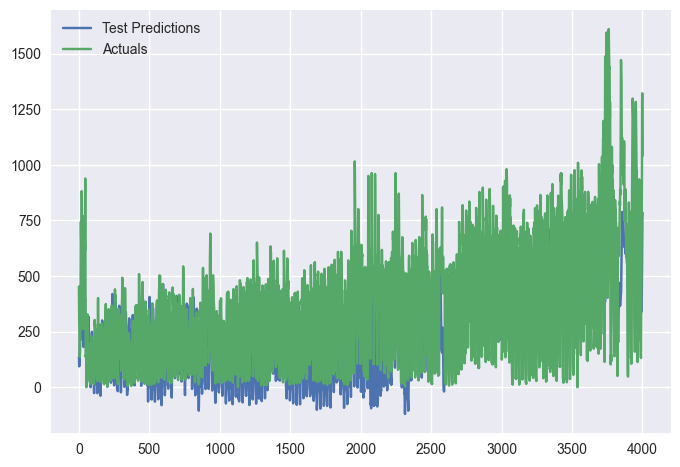

In [34]:
model = load_model('5H_Forecast/5H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(5,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D003_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D003_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 6 hours forecast

In [35]:
%%time

Trainer(6,6,12,50)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 64)                17920     
                                                                 
 dense_72 (Dense)            (None, 8)                 520       
                                                                 
 dense_73 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 14:11:52.495574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:52.631661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:53.042037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.7086 - mae: 0.6736 - mse: 0.7086 - mape: 211.5906

2023-02-10 14:11:59.712341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:11:59.765916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.78325, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 14s 33ms/step - loss: 0.7086 - mae: 0.6736 - mse: 0.7086 - mape: 211.5906 - val_loss: 0.7833 - val_mae: 0.6729 - val_mse: 0.7833 - val_mape: 197.4690
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5842 - mae: 0.5915 - mse: 0.5842 - mape: 263.5768
Epoch 2: val_loss improved from 0.78325 to 0.71852, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.5842 - mae: 0.5915 - mse: 0.5842 - mape: 263.5768 - val_loss: 0.7185 - val_mae: 0.6439 - val_mse: 0.7185 - val_mape: 224.8087
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.5539 - mae: 0.5683 - mse: 0.5539 - mape: 283.9035
Epoch 3: val_loss improved from 0.71852 to 0.70437, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.5539 - mae: 0.5683 - mse: 0.5539 - mape: 283.9035 - val_loss: 0.7044 - val_mae: 0.6336 - val_mse: 0.7044 - val_mape: 232.0182
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.5329 - mae: 0.5537 - mse: 0.5329 - mape: 280.6405
Epoch 4: val_loss improved from 0.70437 to 0.68979, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.5329 - mae: 0.5537 - mse: 0.5329 - mape: 280.6405 - val_loss: 0.6898 - val_mae: 0.6254 - val_mse: 0.6898 - val_mape: 239.5090
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.5162 - mae: 0.5423 - mse: 0.5162 - mape: 302.2773
Epoch 5: val_loss did not improve from 0.68979
376/376 [==============================] - 6s 17ms/step - loss: 0.5162 - mae: 0.5423 - mse: 0.5162 - mape: 302.2773 - val_loss: 0.6926 - val_mae: 0.6232 - val_mse: 0.6926 - val_mape: 234.4567
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.5019 - mae: 0.5326 - mse: 0.5019 - mape: 304.9256
Epoch 6: val_loss did not improve from 0.68979
376/376 [==============================] - 6s 16ms/step - loss: 0.5019 - mae: 0.5326 - mse: 0.5019 - mape: 304.9256 - val_loss: 0.6940 - val_mae: 0.6216 - val_mse: 0.6940 - val_mape: 243.7393
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.4903 - mae: 0

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.4903 - mae: 0.5246 - mse: 0.4903 - mape: 300.4475 - val_loss: 0.6778 - val_mae: 0.6124 - val_mse: 0.6778 - val_mape: 241.4168
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.4804 - mae: 0.5169 - mse: 0.4804 - mape: 306.7081
Epoch 8: val_loss improved from 0.67781 to 0.65635, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.4804 - mae: 0.5169 - mse: 0.4804 - mape: 306.7081 - val_loss: 0.6564 - val_mae: 0.6027 - val_mse: 0.6564 - val_mape: 242.6948
Epoch 9/50
375/376 [============================>.] - ETA: 0s - loss: 0.4714 - mae: 0.5100 - mse: 0.4714 - mape: 309.7304
Epoch 9: val_loss did not improve from 0.65635
376/376 [==============================] - 6s 15ms/step - loss: 0.4717 - mae: 0.5101 - mse: 0.4717 - mape: 309.5806 - val_loss: 0.6736 - val_mae: 0.6066 - val_mse: 0.6736 - val_mape: 237.4875
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.4645 - mae: 0.5054 - mse: 0.4645 - mape: 303.3918
Epoch 10: val_loss did not improve from 0.65635
376/376 [==============================] - 6s 17ms/step - loss: 0.4645 - mae: 0.5054 - mse: 0.4645 - mape: 303.3918 - val_loss: 0.6684 - val_mae: 0.6044 - val_mse: 0.6684 - val_mape: 239.0765
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.4584 - mae

376/376 [==============================] - ETA: 0s - loss: 0.3816 - mae: 0.4528 - mse: 0.3816 - mape: 268.4474
Epoch 31: val_loss did not improve from 0.65635
376/376 [==============================] - 6s 15ms/step - loss: 0.3816 - mae: 0.4528 - mse: 0.3816 - mape: 268.4474 - val_loss: 0.6986 - val_mae: 0.6081 - val_mse: 0.6986 - val_mape: 225.8882
Epoch 32/50
375/376 [============================>.] - ETA: 0s - loss: 0.3794 - mae: 0.4516 - mse: 0.3794 - mape: 272.3089
Epoch 32: val_loss did not improve from 0.65635
376/376 [==============================] - 6s 16ms/step - loss: 0.3793 - mae: 0.4515 - mse: 0.3793 - mape: 272.2295 - val_loss: 0.7030 - val_mae: 0.6095 - val_mse: 0.7030 - val_mape: 222.4529
Epoch 33/50
374/376 [============================>.] - ETA: 0s - loss: 0.3766 - mae: 0.4497 - mse: 0.3766 - mape: 281.9612
Epoch 33: val_loss did not improve from 0.65635
376/376 [==============================] - 6s 16ms/step - loss: 0.3764 - mae: 0.4496 - mse: 0.3764 - mape: 281.3770

2023-02-10 14:17:26.392166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:17:26.552132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:17:27.422216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.7102 - mae: 0.6688 - mse: 0.7102 - mape: 198.7433

2023-02-10 14:17:34.028324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:17:34.083520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.80025, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 14s 32ms/step - loss: 0.7102 - mae: 0.6688 - mse: 0.7102 - mape: 198.7433 - val_loss: 0.8003 - val_mae: 0.6774 - val_mse: 0.8003 - val_mape: 218.4948
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5688 - mae: 0.5791 - mse: 0.5688 - mape: 273.2986
Epoch 2: val_loss improved from 0.80025 to 0.72009, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.5688 - mae: 0.5791 - mse: 0.5688 - mape: 273.2986 - val_loss: 0.7201 - val_mae: 0.6390 - val_mse: 0.7201 - val_mape: 228.4157
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.5389 - mae: 0.5581 - mse: 0.5389 - mape: 295.1187
Epoch 3: val_loss improved from 0.72009 to 0.70357, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.5389 - mae: 0.5581 - mse: 0.5389 - mape: 295.1187 - val_loss: 0.7036 - val_mae: 0.6267 - val_mse: 0.7036 - val_mape: 227.2885
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.5184 - mae: 0.5439 - mse: 0.5184 - mape: 298.4534
Epoch 4: val_loss improved from 0.70357 to 0.68431, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 26ms/step - loss: 0.5184 - mae: 0.5439 - mse: 0.5184 - mape: 298.4534 - val_loss: 0.6843 - val_mae: 0.6187 - val_mse: 0.6843 - val_mape: 244.3663
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.5014 - mae: 0.5313 - mse: 0.5014 - mape: 300.8205
Epoch 5: val_loss did not improve from 0.68431
376/376 [==============================] - 6s 16ms/step - loss: 0.5014 - mae: 0.5313 - mse: 0.5014 - mape: 300.8205 - val_loss: 0.6893 - val_mae: 0.6191 - val_mse: 0.6893 - val_mape: 247.9910
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.4860 - mae: 0.5204 - mse: 0.4860 - mape: 299.9532
Epoch 6: val_loss improved from 0.68431 to 0.67439, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.4860 - mae: 0.5204 - mse: 0.4860 - mape: 299.9532 - val_loss: 0.6744 - val_mae: 0.6109 - val_mse: 0.6744 - val_mape: 244.8317
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.4725 - mae: 0.5112 - mse: 0.4725 - mape: 305.0807
Epoch 7: val_loss did not improve from 0.67439
376/376 [==============================] - 7s 17ms/step - loss: 0.4725 - mae: 0.5112 - mse: 0.4725 - mape: 305.0807 - val_loss: 0.6997 - val_mae: 0.6192 - val_mse: 0.6997 - val_mape: 245.7917
Epoch 8/50
375/376 [============================>.] - ETA: 0s - loss: 0.4612 - mae: 0.5041 - mse: 0.4612 - mape: 299.2328
Epoch 8: val_loss improved from 0.67439 to 0.66934, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.4613 - mae: 0.5041 - mse: 0.4613 - mape: 299.1305 - val_loss: 0.6693 - val_mae: 0.6077 - val_mse: 0.6693 - val_mape: 256.5128
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.4521 - mae: 0.4971 - mse: 0.4521 - mape: 304.7326
Epoch 9: val_loss did not improve from 0.66934
376/376 [==============================] - 6s 17ms/step - loss: 0.4521 - mae: 0.4971 - mse: 0.4521 - mape: 304.7326 - val_loss: 0.6963 - val_mae: 0.6166 - val_mse: 0.6963 - val_mape: 248.5296
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.4429 - mae: 0.4913 - mse: 0.4429 - mape: 303.6358
Epoch 10: val_loss did not improve from 0.66934
376/376 [==============================] - 6s 17ms/step - loss: 0.4429 - mae: 0.4913 - mse: 0.4429 - mape: 303.6358 - val_loss: 0.7177 - val_mae: 0.6205 - val_mse: 0.7177 - val_mape: 243.8260
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.4363 - mae

376/376 [==============================] - ETA: 0s - loss: 0.3547 - mae: 0.4368 - mse: 0.3547 - mape: 260.7996
Epoch 31: val_loss did not improve from 0.66934
376/376 [==============================] - 6s 16ms/step - loss: 0.3547 - mae: 0.4368 - mse: 0.3547 - mape: 260.7996 - val_loss: 0.7279 - val_mae: 0.6232 - val_mse: 0.7279 - val_mape: 247.3694
Epoch 32/50
375/376 [============================>.] - ETA: 0s - loss: 0.3525 - mae: 0.4357 - mse: 0.3525 - mape: 252.5386
Epoch 32: val_loss did not improve from 0.66934
376/376 [==============================] - 6s 16ms/step - loss: 0.3525 - mae: 0.4357 - mse: 0.3525 - mape: 252.4724 - val_loss: 0.7232 - val_mae: 0.6232 - val_mse: 0.7232 - val_mape: 251.8570
Epoch 33/50
374/376 [============================>.] - ETA: 0s - loss: 0.3505 - mae: 0.4341 - mse: 0.3505 - mape: 269.2747
Epoch 33: val_loss did not improve from 0.66934
376/376 [==============================] - 6s 16ms/step - loss: 0.3501 - mae: 0.4339 - mse: 0.3501 - mape: 268.9994

2023-02-10 14:22:59.664085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:22:59.876341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:23:00.276392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.7697 - mae: 0.7098 - mse: 0.7697 - mape: 191.6249

2023-02-10 14:23:07.135305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:23:07.191193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.84868, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 14s 33ms/step - loss: 0.7697 - mae: 0.7098 - mse: 0.7697 - mape: 191.6249 - val_loss: 0.8487 - val_mae: 0.7129 - val_mse: 0.8487 - val_mape: 174.1429
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5793 - mae: 0.5907 - mse: 0.5793 - mape: 270.8326
Epoch 2: val_loss improved from 0.84868 to 0.74295, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.5793 - mae: 0.5907 - mse: 0.5793 - mape: 270.8326 - val_loss: 0.7429 - val_mae: 0.6522 - val_mse: 0.7429 - val_mape: 212.2139
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.5379 - mae: 0.5619 - mse: 0.5379 - mape: 288.9012
Epoch 3: val_loss improved from 0.74295 to 0.70835, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.5379 - mae: 0.5619 - mse: 0.5379 - mape: 288.9012 - val_loss: 0.7084 - val_mae: 0.6332 - val_mse: 0.7084 - val_mape: 227.5492
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.5130 - mae: 0.5438 - mse: 0.5130 - mape: 293.1799
Epoch 4: val_loss improved from 0.70835 to 0.69278, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.5130 - mae: 0.5438 - mse: 0.5130 - mape: 293.1799 - val_loss: 0.6928 - val_mae: 0.6227 - val_mse: 0.6928 - val_mape: 229.6678
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4938 - mae: 0.5304 - mse: 0.4938 - mape: 303.2783
Epoch 5: val_loss improved from 0.69278 to 0.67706, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.4938 - mae: 0.5304 - mse: 0.4938 - mape: 303.2783 - val_loss: 0.6771 - val_mae: 0.6143 - val_mse: 0.6771 - val_mape: 235.6678
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.4774 - mae: 0.5170 - mse: 0.4774 - mape: 300.4868
Epoch 6: val_loss did not improve from 0.67706
376/376 [==============================] - 7s 17ms/step - loss: 0.4774 - mae: 0.5170 - mse: 0.4774 - mape: 300.4868 - val_loss: 0.6776 - val_mae: 0.6096 - val_mse: 0.6776 - val_mape: 237.7598
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.4631 - mae: 0.5067 - mse: 0.4631 - mape: 303.2075
Epoch 7: val_loss improved from 0.67706 to 0.66573, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.4631 - mae: 0.5067 - mse: 0.4631 - mape: 303.2075 - val_loss: 0.6657 - val_mae: 0.6030 - val_mse: 0.6657 - val_mape: 240.4246
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.4515 - mae: 0.4982 - mse: 0.4515 - mape: 297.9427
Epoch 8: val_loss improved from 0.66573 to 0.66106, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.4515 - mae: 0.4982 - mse: 0.4515 - mape: 297.9427 - val_loss: 0.6611 - val_mae: 0.5983 - val_mse: 0.6611 - val_mape: 241.4179
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.4422 - mae: 0.4922 - mse: 0.4422 - mape: 303.4930
Epoch 9: val_loss improved from 0.66106 to 0.65790, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.4422 - mae: 0.4922 - mse: 0.4422 - mape: 303.4930 - val_loss: 0.6579 - val_mae: 0.5940 - val_mse: 0.6579 - val_mape: 234.6909
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.4343 - mae: 0.4871 - mse: 0.4343 - mape: 299.8186
Epoch 10: val_loss improved from 0.65790 to 0.64628, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4343 - mae: 0.4871 - mse: 0.4343 - mape: 299.8186 - val_loss: 0.6463 - val_mae: 0.5932 - val_mse: 0.6463 - val_mape: 245.4893
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.4278 - mae: 0.4829 - mse: 0.4278 - mape: 295.6647
Epoch 11: val_loss did not improve from 0.64628
376/376 [==============================] - 6s 17ms/step - loss: 0.4278 - mae: 0.4829 - mse: 0.4278 - mape: 295.6647 - val_loss: 0.6660 - val_mae: 0.5932 - val_mse: 0.6660 - val_mape: 226.0735
Epoch 12/50
375/376 [============================>.] - ETA: 0s - loss: 0.4219 - mae: 0.4788 - mse: 0.4219 - mape: 282.3805
Epoch 12: val_loss did not improve from 0.64628
376/376 [==============================] - 6s 17ms/step - loss: 0.4220 - mae: 0.4788 - mse: 0.4220 - mape: 282.2750 - val_loss: 0.6588 - val_mae: 0.5947 - val_mse: 0.6588 - val_mape: 242.3882
Epoch 13/50
374/376 [============================>.] - ETA: 0s - loss: 0.4165 - m

373/376 [============================>.] - ETA: 0s - loss: 0.3412 - mae: 0.4270 - mse: 0.3412 - mape: 253.6326
Epoch 33: val_loss did not improve from 0.64628
376/376 [==============================] - 6s 16ms/step - loss: 0.3411 - mae: 0.4270 - mse: 0.3411 - mape: 252.8395 - val_loss: 0.7031 - val_mae: 0.6038 - val_mse: 0.7031 - val_mape: 226.0707
Epoch 34/50
376/376 [==============================] - ETA: 0s - loss: 0.3377 - mae: 0.4240 - mse: 0.3377 - mape: 250.6833
Epoch 34: val_loss did not improve from 0.64628
376/376 [==============================] - 6s 17ms/step - loss: 0.3377 - mae: 0.4240 - mse: 0.3377 - mape: 250.6833 - val_loss: 0.7224 - val_mae: 0.6101 - val_mse: 0.7224 - val_mape: 227.4613
Epoch 35/50
376/376 [==============================] - ETA: 0s - loss: 0.3356 - mae: 0.4235 - mse: 0.3356 - mape: 248.0166
Epoch 35: val_loss did not improve from 0.64628
376/376 [==============================] - 6s 16ms/step - loss: 0.3356 - mae: 0.4235 - mse: 0.3356 - mape: 248.0166

2023-02-10 14:29:00.164469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:29:00.379070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:29:01.018052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.7287 - mae: 0.6900 - mse: 0.7287 - mape: 249.0624

2023-02-10 14:29:09.368070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:29:09.433006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.81145, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 16s 38ms/step - loss: 0.7287 - mae: 0.6900 - mse: 0.7287 - mape: 249.0624 - val_loss: 0.8114 - val_mae: 0.6981 - val_mse: 0.8114 - val_mape: 166.6619
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5854 - mae: 0.5980 - mse: 0.5854 - mape: 254.4768
Epoch 2: val_loss improved from 0.81145 to 0.75741, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.5854 - mae: 0.5980 - mse: 0.5854 - mape: 254.4768 - val_loss: 0.7574 - val_mae: 0.6622 - val_mse: 0.7574 - val_mape: 223.9544
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.5309 - mae: 0.5584 - mse: 0.5309 - mape: 280.0064
Epoch 3: val_loss improved from 0.75741 to 0.74562, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.5309 - mae: 0.5584 - mse: 0.5309 - mape: 280.0064 - val_loss: 0.7456 - val_mae: 0.6513 - val_mse: 0.7456 - val_mape: 246.3341
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4984 - mae: 0.5341 - mse: 0.4984 - mape: 293.8795
Epoch 4: val_loss improved from 0.74562 to 0.71027, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 10s 28ms/step - loss: 0.4984 - mae: 0.5341 - mse: 0.4984 - mape: 293.8795 - val_loss: 0.7103 - val_mae: 0.6346 - val_mse: 0.7103 - val_mape: 263.0106
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4771 - mae: 0.5182 - mse: 0.4771 - mape: 301.5228
Epoch 5: val_loss did not improve from 0.71027
376/376 [==============================] - 7s 18ms/step - loss: 0.4771 - mae: 0.5182 - mse: 0.4771 - mape: 301.5228 - val_loss: 0.7144 - val_mae: 0.6323 - val_mse: 0.7144 - val_mape: 271.7828
Epoch 6/50
375/376 [============================>.] - ETA: 0s - loss: 0.4611 - mae: 0.5058 - mse: 0.4611 - mape: 304.1952
Epoch 6: val_loss did not improve from 0.71027
376/376 [==============================] - 6s 17ms/step - loss: 0.4613 - mae: 0.5059 - mse: 0.4613 - mape: 304.0829 - val_loss: 0.7156 - val_mae: 0.6259 - val_mse: 0.7156 - val_mape: 252.3735
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.4499 - mae: 0

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4408 - mae: 0.4909 - mse: 0.4408 - mape: 295.0348 - val_loss: 0.6986 - val_mae: 0.6159 - val_mse: 0.6986 - val_mape: 263.1565
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.4318 - mae: 0.4850 - mse: 0.4318 - mape: 296.7421
Epoch 9: val_loss did not improve from 0.69864
376/376 [==============================] - 7s 18ms/step - loss: 0.4318 - mae: 0.4850 - mse: 0.4318 - mape: 296.7421 - val_loss: 0.7229 - val_mae: 0.6212 - val_mse: 0.7229 - val_mape: 252.7280
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.4246 - mae: 0.4800 - mse: 0.4246 - mape: 284.5470
Epoch 10: val_loss did not improve from 0.69864
376/376 [==============================] - 6s 17ms/step - loss: 0.4246 - mae: 0.4800 - mse: 0.4246 - mape: 284.5470 - val_loss: 0.7065 - val_mae: 0.6140 - val_mse: 0.7065 - val_mape: 249.5291
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.4167 - mae

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.4167 - mae: 0.4746 - mse: 0.4167 - mape: 278.2367 - val_loss: 0.6889 - val_mae: 0.6064 - val_mse: 0.6889 - val_mape: 251.7459
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.4104 - mae: 0.4707 - mse: 0.4104 - mape: 278.4758
Epoch 12: val_loss improved from 0.68895 to 0.67742, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4104 - mae: 0.4707 - mse: 0.4104 - mape: 278.4758 - val_loss: 0.6774 - val_mae: 0.6028 - val_mse: 0.6774 - val_mape: 252.9332
Epoch 13/50
376/376 [==============================] - ETA: 0s - loss: 0.4039 - mae: 0.4666 - mse: 0.4039 - mape: 272.5220
Epoch 13: val_loss did not improve from 0.67742
376/376 [==============================] - 7s 17ms/step - loss: 0.4039 - mae: 0.4666 - mse: 0.4039 - mape: 272.5220 - val_loss: 0.7361 - val_mae: 0.6186 - val_mse: 0.7361 - val_mape: 235.2681
Epoch 14/50
375/376 [============================>.] - ETA: 0s - loss: 0.3986 - mae: 0.4631 - mse: 0.3986 - mape: 268.2933
Epoch 14: val_loss did not improve from 0.67742
376/376 [==============================] - 6s 17ms/step - loss: 0.3985 - mae: 0.4631 - mse: 0.3985 - mape: 268.1887 - val_loss: 0.7068 - val_mae: 0.6083 - val_mse: 0.7068 - val_mape: 242.8730
Epoch 15/50
375/376 [============================>.] - ETA: 0s - loss: 0.3925 - m

375/376 [============================>.] - ETA: 0s - loss: 0.3159 - mae: 0.4101 - mse: 0.3159 - mape: 234.1817
Epoch 35: val_loss did not improve from 0.67742
376/376 [==============================] - 6s 17ms/step - loss: 0.3160 - mae: 0.4102 - mse: 0.3160 - mape: 234.0983 - val_loss: 0.8064 - val_mae: 0.6291 - val_mse: 0.8064 - val_mape: 217.0964
Epoch 36/50
376/376 [==============================] - ETA: 0s - loss: 0.3134 - mae: 0.4093 - mse: 0.3134 - mape: 230.1195
Epoch 36: val_loss did not improve from 0.67742
376/376 [==============================] - 6s 17ms/step - loss: 0.3134 - mae: 0.4093 - mse: 0.3134 - mape: 230.1195 - val_loss: 0.7941 - val_mae: 0.6249 - val_mse: 0.7941 - val_mape: 234.9608
Epoch 37/50
374/376 [============================>.] - ETA: 0s - loss: 0.3101 - mae: 0.4076 - mse: 0.3101 - mape: 230.9563
Epoch 37: val_loss did not improve from 0.67742
376/376 [==============================] - 6s 17ms/step - loss: 0.3103 - mae: 0.4078 - mse: 0.3103 - mape: 230.5044

2023-02-10 14:34:54.547756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:34:54.702436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:34:55.173884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6822 - mae: 0.6574 - mse: 0.6822 - mape: 243.8247

2023-02-10 14:35:02.346451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:35:02.406250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.84181, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 14s 34ms/step - loss: 0.6822 - mae: 0.6574 - mse: 0.6822 - mape: 243.8247 - val_loss: 0.8418 - val_mae: 0.6985 - val_mse: 0.8418 - val_mape: 206.6931
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5507 - mae: 0.5686 - mse: 0.5507 - mape: 280.2076
Epoch 2: val_loss improved from 0.84181 to 0.76367, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.5507 - mae: 0.5686 - mse: 0.5507 - mape: 280.2076 - val_loss: 0.7637 - val_mae: 0.6576 - val_mse: 0.7637 - val_mape: 216.4086
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.5108 - mae: 0.5394 - mse: 0.5108 - mape: 285.2328
Epoch 3: val_loss improved from 0.76367 to 0.72497, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 12s 30ms/step - loss: 0.5108 - mae: 0.5394 - mse: 0.5108 - mape: 285.2328 - val_loss: 0.7250 - val_mae: 0.6369 - val_mse: 0.7250 - val_mape: 238.1724
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4832 - mae: 0.5188 - mse: 0.4832 - mape: 293.3026
Epoch 4: val_loss did not improve from 0.72497
376/376 [==============================] - 7s 18ms/step - loss: 0.4832 - mae: 0.5188 - mse: 0.4832 - mape: 293.3026 - val_loss: 0.7399 - val_mae: 0.6322 - val_mse: 0.7399 - val_mape: 222.4686
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4619 - mae: 0.5035 - mse: 0.4619 - mape: 295.4029
Epoch 5: val_loss improved from 0.72497 to 0.71064, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4619 - mae: 0.5035 - mse: 0.4619 - mape: 295.4029 - val_loss: 0.7106 - val_mae: 0.6167 - val_mse: 0.7106 - val_mape: 224.9480
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.4443 - mae: 0.4908 - mse: 0.4443 - mape: 283.2397
Epoch 6: val_loss did not improve from 0.71064
376/376 [==============================] - 7s 18ms/step - loss: 0.4443 - mae: 0.4908 - mse: 0.4443 - mape: 283.2397 - val_loss: 0.7313 - val_mae: 0.6193 - val_mse: 0.7313 - val_mape: 206.2187
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.4301 - mae: 0.4823 - mse: 0.4301 - mape: 278.2929
Epoch 7: val_loss improved from 0.71064 to 0.69631, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.4301 - mae: 0.4823 - mse: 0.4301 - mape: 278.2929 - val_loss: 0.6963 - val_mae: 0.6035 - val_mse: 0.6963 - val_mape: 211.7723
Epoch 8/50
376/376 [==============================] - ETA: 0s - loss: 0.4182 - mae: 0.4749 - mse: 0.4182 - mape: 289.4905
Epoch 8: val_loss did not improve from 0.69631
376/376 [==============================] - 7s 19ms/step - loss: 0.4182 - mae: 0.4749 - mse: 0.4182 - mape: 289.4905 - val_loss: 0.7026 - val_mae: 0.6057 - val_mse: 0.7026 - val_mape: 216.4698
Epoch 9/50
376/376 [==============================] - ETA: 0s - loss: 0.4089 - mae: 0.4691 - mse: 0.4089 - mape: 258.9523
Epoch 9: val_loss improved from 0.69631 to 0.67787, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


376/376 [==============================] - 11s 29ms/step - loss: 0.4089 - mae: 0.4691 - mse: 0.4089 - mape: 258.9523 - val_loss: 0.6779 - val_mae: 0.5983 - val_mse: 0.6779 - val_mape: 223.8397
Epoch 10/50
376/376 [==============================] - ETA: 0s - loss: 0.4007 - mae: 0.4639 - mse: 0.4007 - mape: 272.4966
Epoch 10: val_loss did not improve from 0.67787
376/376 [==============================] - 7s 19ms/step - loss: 0.4007 - mae: 0.4639 - mse: 0.4007 - mape: 272.4966 - val_loss: 0.6990 - val_mae: 0.6018 - val_mse: 0.6990 - val_mape: 209.4542
Epoch 11/50
376/376 [==============================] - ETA: 0s - loss: 0.3927 - mae: 0.4592 - mse: 0.3927 - mape: 270.0733
Epoch 11: val_loss did not improve from 0.67787
376/376 [==============================] - 7s 18ms/step - loss: 0.3927 - mae: 0.4592 - mse: 0.3927 - mape: 270.0733 - val_loss: 0.7124 - val_mae: 0.6038 - val_mse: 0.7124 - val_mape: 213.2227
Epoch 12/50
376/376 [==============================] - ETA: 0s - loss: 0.3866 - m

376/376 [==============================] - ETA: 0s - loss: 0.3025 - mae: 0.3972 - mse: 0.3025 - mape: 277.9509
Epoch 32: val_loss did not improve from 0.67787
376/376 [==============================] - 6s 17ms/step - loss: 0.3025 - mae: 0.3972 - mse: 0.3025 - mape: 277.9509 - val_loss: 0.8540 - val_mae: 0.6422 - val_mse: 0.8540 - val_mape: 216.0948
Epoch 33/50
376/376 [==============================] - ETA: 0s - loss: 0.2979 - mae: 0.3951 - mse: 0.2979 - mape: 271.6226
Epoch 33: val_loss did not improve from 0.67787
376/376 [==============================] - 7s 19ms/step - loss: 0.2979 - mae: 0.3951 - mse: 0.2979 - mape: 271.6226 - val_loss: 0.7798 - val_mae: 0.6236 - val_mse: 0.7798 - val_mape: 225.4696
Epoch 34/50
376/376 [==============================] - ETA: 0s - loss: 0.2947 - mae: 0.3923 - mse: 0.2947 - mape: 263.6319
Epoch 34: val_loss did not improve from 0.67787
376/376 [==============================] - 7s 18ms/step - loss: 0.2947 - mae: 0.3923 - mse: 0.2947 - mape: 263.6319

2023-02-10 14:40:46.082801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:40:46.234573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:40:46.695926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6523 - mae: 0.6323 - mse: 0.6523 - mape: 194.3444

2023-02-10 14:40:53.674513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:40:53.758956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.78431, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 15s 35ms/step - loss: 0.6523 - mae: 0.6323 - mse: 0.6523 - mape: 194.3444 - val_loss: 0.7843 - val_mae: 0.6635 - val_mse: 0.7843 - val_mape: 242.0966
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5388 - mae: 0.5565 - mse: 0.5388 - mape: 265.8383
Epoch 2: val_loss improved from 0.78431 to 0.72812, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 28ms/step - loss: 0.5388 - mae: 0.5565 - mse: 0.5388 - mape: 265.8383 - val_loss: 0.7281 - val_mae: 0.6327 - val_mse: 0.7281 - val_mape: 235.9838
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.5082 - mae: 0.5331 - mse: 0.5082 - mape: 277.6684
Epoch 3: val_loss improved from 0.72812 to 0.72501, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 12s 32ms/step - loss: 0.5082 - mae: 0.5331 - mse: 0.5082 - mape: 277.6684 - val_loss: 0.7250 - val_mae: 0.6254 - val_mse: 0.7250 - val_mape: 226.9814
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4838 - mae: 0.5146 - mse: 0.4838 - mape: 268.7270
Epoch 4: val_loss improved from 0.72501 to 0.68092, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


376/376 [==============================] - 11s 30ms/step - loss: 0.4838 - mae: 0.5146 - mse: 0.4838 - mape: 268.7270 - val_loss: 0.6809 - val_mae: 0.6047 - val_mse: 0.6809 - val_mape: 229.6236
Epoch 5/50
376/376 [==============================] - ETA: 0s - loss: 0.4636 - mae: 0.4995 - mse: 0.4636 - mape: 264.7572
Epoch 5: val_loss did not improve from 0.68092
376/376 [==============================] - 7s 18ms/step - loss: 0.4636 - mae: 0.4995 - mse: 0.4636 - mape: 264.7572 - val_loss: 0.7042 - val_mae: 0.6106 - val_mse: 0.7042 - val_mape: 220.4546
Epoch 6/50
376/376 [==============================] - ETA: 0s - loss: 0.4472 - mae: 0.4890 - mse: 0.4472 - mape: 268.3533
Epoch 6: val_loss did not improve from 0.68092
376/376 [==============================] - 7s 18ms/step - loss: 0.4472 - mae: 0.4890 - mse: 0.4472 - mape: 268.3533 - val_loss: 0.6867 - val_mae: 0.5994 - val_mse: 0.6867 - val_mape: 203.5678
Epoch 7/50
376/376 [==============================] - ETA: 0s - loss: 0.4342 - mae: 0

375/376 [============================>.] - ETA: 0s - loss: 0.2897 - mae: 0.3843 - mse: 0.2897 - mape: 237.3143
Epoch 27: val_loss did not improve from 0.68092
376/376 [==============================] - 6s 16ms/step - loss: 0.2898 - mae: 0.3843 - mse: 0.2898 - mape: 237.2622 - val_loss: 1.0123 - val_mae: 0.6790 - val_mse: 1.0123 - val_mape: 222.7326
Epoch 28/50
376/376 [==============================] - ETA: 0s - loss: 0.2859 - mae: 0.3815 - mse: 0.2859 - mape: 255.6415
Epoch 28: val_loss did not improve from 0.68092
376/376 [==============================] - 6s 16ms/step - loss: 0.2859 - mae: 0.3815 - mse: 0.2859 - mape: 255.6415 - val_loss: 0.9560 - val_mae: 0.6636 - val_mse: 0.9560 - val_mape: 227.3866
Epoch 29/50
374/376 [============================>.] - ETA: 0s - loss: 0.2837 - mae: 0.3802 - mse: 0.2837 - mape: 228.0207
Epoch 29: val_loss did not improve from 0.68092
376/376 [==============================] - 6s 15ms/step - loss: 0.2843 - mae: 0.3804 - mse: 0.2843 - mape: 227.7306

Epoch 50/50
373/376 [============================>.] - ETA: 0s - loss: 0.2322 - mae: 0.3457 - mse: 0.2322 - mape: 202.6167
Epoch 50: val_loss did not improve from 0.68092
376/376 [==============================] - 6s 16ms/step - loss: 0.2318 - mae: 0.3456 - mse: 0.2318 - mape: 202.4911 - val_loss: 1.2744 - val_mae: 0.7457 - val_mse: 1.2744 - val_mape: 226.8720

-----------------------------------------------------------------------------------------------------------

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 64)                17920     
                                                                 
 dense_84 (Dense)            (None, 8)                 520       
                                                                 
 dense_85 (Dense)            (None, 1)                 9         
                                          

2023-02-10 14:46:18.977315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:46:19.135858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:46:19.558081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - ETA: 0s - loss: 0.6348 - mae: 0.6278 - mse: 0.6348 - mape: 209.8476

2023-02-10 14:46:26.421638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:46:26.487248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.77050, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 14s 32ms/step - loss: 0.6348 - mae: 0.6278 - mse: 0.6348 - mape: 209.8476 - val_loss: 0.7705 - val_mae: 0.6617 - val_mse: 0.7705 - val_mape: 194.6027
Epoch 2/50
376/376 [==============================] - ETA: 0s - loss: 0.5339 - mae: 0.5550 - mse: 0.5339 - mape: 266.6147
Epoch 2: val_loss improved from 0.77050 to 0.72602, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 10s 27ms/step - loss: 0.5339 - mae: 0.5550 - mse: 0.5339 - mape: 266.6147 - val_loss: 0.7260 - val_mae: 0.6369 - val_mse: 0.7260 - val_mape: 213.6547
Epoch 3/50
376/376 [==============================] - ETA: 0s - loss: 0.4984 - mae: 0.5277 - mse: 0.4984 - mape: 270.4389
Epoch 3: val_loss improved from 0.72602 to 0.68279, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


376/376 [==============================] - 9s 25ms/step - loss: 0.4984 - mae: 0.5277 - mse: 0.4984 - mape: 270.4389 - val_loss: 0.6828 - val_mae: 0.6146 - val_mse: 0.6828 - val_mape: 236.7879
Epoch 4/50
376/376 [==============================] - ETA: 0s - loss: 0.4726 - mae: 0.5079 - mse: 0.4726 - mape: 264.3358
Epoch 4: val_loss did not improve from 0.68279
376/376 [==============================] - 6s 15ms/step - loss: 0.4726 - mae: 0.5079 - mse: 0.4726 - mape: 264.3358 - val_loss: 0.7028 - val_mae: 0.6156 - val_mse: 0.7028 - val_mape: 223.7160
Epoch 5/50
374/376 [============================>.] - ETA: 0s - loss: 0.4522 - mae: 0.4947 - mse: 0.4522 - mape: 263.0673
Epoch 5: val_loss did not improve from 0.68279
376/376 [==============================] - 6s 15ms/step - loss: 0.4522 - mae: 0.4948 - mse: 0.4522 - mape: 262.8893 - val_loss: 0.7073 - val_mae: 0.6160 - val_mse: 0.7073 - val_mape: 230.3476
Epoch 6/50
375/376 [============================>.] - ETA: 0s - loss: 0.4357 - mae: 0.

376/376 [==============================] - ETA: 0s - loss: 0.3030 - mae: 0.3959 - mse: 0.3030 - mape: 234.2862
Epoch 26: val_loss did not improve from 0.68279
376/376 [==============================] - 6s 15ms/step - loss: 0.3030 - mae: 0.3959 - mse: 0.3030 - mape: 234.2862 - val_loss: 0.8987 - val_mae: 0.6493 - val_mse: 0.8987 - val_mape: 207.9209
Epoch 27/50
376/376 [==============================] - ETA: 0s - loss: 0.2982 - mae: 0.3931 - mse: 0.2982 - mape: 253.2096
Epoch 27: val_loss did not improve from 0.68279
376/376 [==============================] - 6s 16ms/step - loss: 0.2982 - mae: 0.3931 - mse: 0.2982 - mape: 253.2096 - val_loss: 0.8848 - val_mae: 0.6462 - val_mse: 0.8848 - val_mape: 217.4821
Epoch 28/50
374/376 [============================>.] - ETA: 0s - loss: 0.2940 - mae: 0.3899 - mse: 0.2940 - mape: 239.0626
Epoch 28: val_loss did not improve from 0.68279
376/376 [==============================] - 6s 16ms/step - loss: 0.2941 - mae: 0.3901 - mse: 0.2941 - mape: 238.7610

Epoch 49/50
374/376 [============================>.] - ETA: 0s - loss: 0.2375 - mae: 0.3500 - mse: 0.2375 - mape: 246.4425
Epoch 49: val_loss did not improve from 0.68279
376/376 [==============================] - 6s 17ms/step - loss: 0.2374 - mae: 0.3499 - mse: 0.2374 - mape: 245.9021 - val_loss: 1.1944 - val_mae: 0.7184 - val_mse: 1.1944 - val_mape: 235.3918
Epoch 50/50
375/376 [============================>.] - ETA: 0s - loss: 0.2348 - mae: 0.3479 - mse: 0.2348 - mape: 253.7314
Epoch 50: val_loss did not improve from 0.68279
376/376 [==============================] - 6s 17ms/step - loss: 0.2347 - mae: 0.3479 - mse: 0.2347 - mape: 253.6792 - val_loss: 1.1294 - val_mae: 0.7037 - val_mse: 1.1294 - val_mape: 250.0835

-----------------------------------------------------------------------------------------------------------

CPU times: user 33min 16s, sys: 11min 43s, total: 44min 59s
Wall time: 39min 33s


In [36]:
%%time

modelsEvaluator(6,6,12)

(12007, 6, 5) (12007,) (4003, 6, 5) (4003,) (4003, 6, 5) (4003,)
Loading: 6H_Forecast/6H_ForecastModel_6_SizeWindow/


2023-02-10 14:51:29.373190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:51:29.436013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 42s

2023-02-10 14:51:31.338627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:51:31.372582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12006, 7, 5) (12006,) (4003, 7, 5) (4003,) (4003, 7, 5) (4003,)
Loading: 6H_Forecast/6H_ForecastModel_7_SizeWindow/


2023-02-10 14:51:35.756932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:51:35.819607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 40s

2023-02-10 14:51:37.610512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:51:37.643141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12006, 8, 5) (12006,) (4002, 8, 5) (4002,) (4003, 8, 5) (4003,)
Loading: 6H_Forecast/6H_ForecastModel_8_SizeWindow/


2023-02-10 14:51:42.036719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:51:42.094253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 37s

2023-02-10 14:51:43.988474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:51:44.019616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12006, 9, 5) (12006,) (4002, 9, 5) (4002,) (4002, 9, 5) (4002,)
Loading: 6H_Forecast/6H_ForecastModel_9_SizeWindow/


2023-02-10 14:51:48.139883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:51:48.188471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 37s

2023-02-10 14:51:50.052598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:51:50.084709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 6ms/step
(12005, 10, 5) (12005,) (4002, 10, 5) (4002,) (4002, 10, 5) (4002,)
Loading: 6H_Forecast/6H_ForecastModel_10_SizeWindow/


2023-02-10 14:51:54.749308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:51:54.803613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 36s

2023-02-10 14:51:56.665377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:51:56.696746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 5ms/step
(12004, 11, 5) (12004,) (4002, 11, 5) (4002,) (4002, 11, 5) (4002,)
Loading: 6H_Forecast/6H_ForecastModel_11_SizeWindow/


2023-02-10 14:52:00.711104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:52:00.777472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 2s 11ms/step - loss: 0.6622 - mae: 0.6323 - mse: 0.6622 - mape: 368.3249


2023-02-10 14:52:02.583502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:52:02.616173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 4ms/step
(12003, 12, 5) (12003,) (4002, 12, 5) (4002,) (4002, 12, 5) (4002,)
Loading: 6H_Forecast/6H_ForecastModel_12_SizeWindow/


2023-02-10 14:52:07.298010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:52:07.414479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/126 [..............................] - ETA: 41s

2023-02-10 14:52:10.185372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:52:10.225875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 7ms/step
CPU times: user 39.9 s, sys: 6.3 s, total: 46.2 s
Wall time: 46 s


2023-02-10 14:52:15.554077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:52:15.590589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1s 6ms/step


,Test Predictions,Actuals
0,193.260574,452.508000
1,169.176880,354.636000
2,213.758591,308.158333
3,225.161819,252.036667
4,242.914902,234.740000
5,272.888855,188.511667
6,311.409241,136.190000
7,331.734161,150.125000
8,340.091431,151.265000
9,346.896423,179.690000


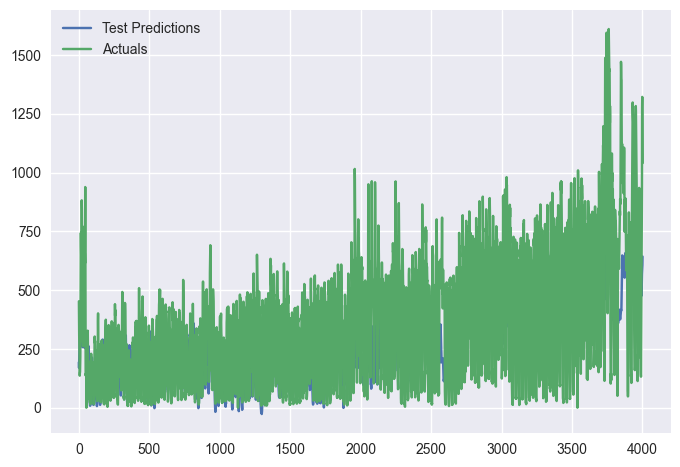

In [37]:
model = load_model('6H_Forecast/6H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(6,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D003_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D003_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)